In [ ]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import shutil
import importlib
import matplotlib.pyplot as plt
import re
from skimage import io
import tifffile
from scipy.ndimage import median_filter
from skimage.util import img_as_ubyte,  img_as_float
import skimage
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import scipy
import seaborn as sns
from scipy import stats
from skimage.filters import unsharp_mask
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import color, morphology
from skimage.transform import rescale
import matplotlib as mpl
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test

from statannotations.Annotator import Annotator
from itertools import combinations
import statsmodels
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from bokeh.palettes import Colorblind
d_colorblind = {'Liver':'#d55e00','Lung':'#0072b2',
               'high':'#e69f00','low': '#56b4e9',
               'basal-like':'#000000','classical':'#cc79a7',
               'high pSUB': '#f0e442','low pSUB':'#009E73'}

pal_porg_r = ('#56B4E9','#E69F00',)
pal_liv_r = ('#0072B2','#D55E00',)
# Set Paths
codedir = os.getcwd()
import util

%matplotlib inline

In [ ]:
#images: dowload from synapse.org syn51068458
# (free account required)
rootdir = codedir#'/home/groups/BCC_Chin_Lab/ChinData/Cyclic_Workflow/cmIF_2021-05-03_PDAC'
regdir = f'{rootdir}/RegisteredImages'
segdir = f'{codedir}/Segmentation'
segdiro = f'{rootdir}/Segmentation'

# clone mplex_image at https://gitlab.com/engje/mplex_image
os.chdir('../..')
from mplex_image import preprocess, mpimage #, cmif
os.chdir(codedir)

# Table of contents <a name="contents"></a>
0. [functions](#func)
1. [skimage blobs](#sk)
2. [Foci analysis](#focifoci)
3. [mIHC analysis](#mihc)
4. [Patient metadata](#meta)  [Primary vs met](#primet)

   [Gene alteration vs GSVA](#genes) [DDR vs TMB](#DDR) 
4. Survival Analysis [CPH modeling](#clin)  [CPH forest plots](#cphplot)
5. [gene expression analysis](#geneexp) correlation heatmap, quadrant plot, gene expression versus cohort
6. [TCR analysis](#tcell) [TCR survival](#tcells) [TCR Met site](#TCRmet)
7. [GSVA violins](#violin2)  [GSEA bar plots](#bars2)
8. [OLD](#split) (not used)

## functions <a name="func"></a> 

import from util.py

[contents](#contents)

##  Section 1: skimage blob detection

Foci are detected here from images plus segmentation masks

**You can skip and use pre-computed foci counts**

 <a name="sk"></a> 

[contents](#contents)

In [ ]:
#intensity data: dowload from synapse.org syn51068458
df_mi = pd.read_csv(f'{codedir}/data/20220720_U54-TMA_FilteredMeanIntensity_Link.csv',index_col=0)

In [ ]:
#skimage blob detection
#requires images: dowload from synapse.org syn51068458
threshold=0.002
d_thresh = {'pRPA':1100, 'gH2AX':1100, 'RAD51':1300}
os.chdir(regdir)
ls_slide = sorted(set(df_mi.slide_scene)) 
ls_marker = ['pRPA','gH2AX','RAD51',] 
df_result_all = pd.DataFrame()
for s_slide in ls_slide:
    print(s_slide)
    os.chdir(f'{segdiro}/U54-TMA-9_CellposeSegmentation') #change this to path for your downloaded segmentation masks
    s_seg = pd.Series(sorted(os.listdir()),dtype='object')[pd.Series(index=sorted(os.listdir()),dtype='object').index.str.contains(f'{s_slide}_nuc30_NucleiSegmentationBasins')].iloc[0]
    label_image = io.imread(s_seg)
    os.chdir(f'{regdir}/{s_slide}') # change this to path to your downloaded registered tifs
    df_img=mpimage.parse_org()
    for idxs, s_marker in enumerate(ls_marker):
        intensity_image = io.imread(df_img[df_img.marker==s_marker].index[0])
        props = skimage.measure.regionprops_table(label_image, intensity_image=intensity_image, properties=('label','bbox','mean_intensity')) # 'image','intensity_image',
        df_props = pd.DataFrame(props,dtype='float').set_index('label')
        df_props.columns = [item.replace('-','') for item in df_props.columns]
        ls_index = df_props[df_props.mean_intensity>d_thresh[s_marker]].index
        print(f'{s_marker} {len(ls_index)}')
        for i_cell in ls_index:
            se_cell = df_props.loc[i_cell].dropna().astype('int')
            image = intensity_image[se_cell.bbox0:se_cell.bbox2,se_cell.bbox1:se_cell.bbox3]
            if s_marker == 'pRPA':
                blobs, fig = util.get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            elif s_marker == 'gH2AX':
                blobs, fig = util.get_blobs2(image,min_sigma=1,max_sigma=2,threshold=threshold,exclude_border=1)
            else:
                blobs, fig = util.get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            df_props.loc[i_cell,'blobs'] = len(blobs)
            if len(blobs) > 1:
                fig.suptitle(s_marker)
                plt.tight_layout()
                fig.savefig(f'{codedir}/blobs/{s_marker}/{s_slide}_{s_marker}_{i_cell}.png',dpi=200)
                plt.close(fig)
        df_props.index = [s_slide + '_cell' + str(item) for item in df_props.index]
        if len(ls_index)==0:
                df_props['blobs'] = np.NaN
        if idxs == 0:
            df_result = df_props.rename({'blobs':f'{s_marker}_foci'},axis=1)
        else:
            df_result.loc[df_props.index,f'{s_marker}_foci'] = df_props.blobs
    df_result_all = df_result_all.append(df_result)

#uncomment to save (this data has been pre-computed and saved in the repo)
#df_result_all.loc[:,df_result_all.columns.str.contains('foci')].dropna(how='all').to_csv(f'{codedir}/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv')


### Section 2: FOCI Analysis <a name="focifoci"></a>

Load saved foci for plotting and downstream analysis

liver/lung

**You don't need to run section 1 to run this**


[contents](#contents)

In [ ]:
df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link.csv')
len(df_surv)
#df_pORG = pd.read_csv(f'{codedir}/data/GSVA_Scores_Link.csv')#=,index_col='Public_Specimen_ID'
#df_pORG = pd.read_csv(f'{codedir}/20230526_GSVA_Scores.csv')
df_pORG = pd.read_csv(f'data/20230608_GSVA_Scores.csv')
#df_pORG
df_primary = df_surv[((df_surv.Tissue=='PDAC') | (df_surv.Tissue=='Intestinal'))].copy()
print(len(df_primary))
df_primary = df_primary.merge(df_pORG[df_pORG.Group=='GSVA_All'],on='Public_Specimen_ID',how='left')
df_primary.set_index("Public_Specimen_ID", inplace = True)
len(df_primary)

In [ ]:
df_mapper = df_primary[~df_primary.index.duplicated()]
ls_add = ['txi_pORG_Up_42_Genes',
          'trim_padj_0.2_pORG_Up_55_Genes',
          'trim_padj_0.2_pSUB_Up_100_Genes',
        'txi_pSUB_Up_100_Genes']
for s_add in ls_add:
    d_map = dict(zip(df_mapper.index,df_mapper.loc[:,s_add]))
    print(len(d_map))
    df_surv[s_add] = df_surv.Public_Specimen_ID.map(d_map)

### TMA survival

In [ ]:
# ##
# %matplotlib inline
# alpha = 0.06
# s_propo = ''
# savedir = f'{codedir}'
# s_time=  'Survival_time'#
# s_censor='Survival'#
# s_subtype = ''
# s_cell = ''
# s_type_title = ''
 
# for s_col in ls_add:
#     print(s_col)
#     for cutp in [0.33,0.5,0.66]: #np.round(np.arange(0.25,1,0.25),3):#
#             print(cutp)
#             df_km, pvalue = util.single_km(df_surv[~df_surv.Public_Patient_ID.duplicated()],s_cell,s_subtype,s_type_title,s_col,savedir,alpha,cutp, #
#                                        s_time,s_censor,s_propo)
#             print(pvalue)
#     #break

### define high/low pORG

based on survival differences on TMA samples

In [ ]:
df_pri = df_surv[~(df_surv.Public_Patient_ID.duplicated(keep='first')) & (df_surv.Tissue.isin(['PDAC','Intestinal']))]
s_select_porg = 'trim_padj_0.2_pORG_Up_55_Genes'#'txi_pORG_Up_42_Genes'
i_pORG_txi = 0.0249 #np.quantile(df_pri.loc[:,s_select_porg].dropna(),0.66)#0.66 #0.5
print(i_pORG_txi)
# df_surv.loc[df_surv['Original_pORG_Up_78_Genes'] >= i_pORG_ori,'pORG_binary_orig'] = 'high'
# df_surv.loc[df_surv['Original_pORG_Up_78_Genes'] < i_pORG_ori,'pORG_binary_orig'] = 'low'

df_surv.loc[df_surv[s_select_porg] > i_pORG_txi,'pORG_binary'] = 'High'
df_surv.loc[df_surv[s_select_porg] <= i_pORG_txi,'pORG_binary'] = 'Low'

In [ ]:
#save the 0608
#df_surv.drop(['Unnamed: 0','pORG_binary','pORG_Score'],axis=1).to_csv(f'{codedir}/data/u54_tma_sampleannot_Link_new.csv')
#df_surv.Tissue

In [ ]:
#print(df_surv.pORG_binary_orig.value_counts())
print(df_surv[(df_surv.Tissue.isin(['PDAC','Intestinal'])) & (~df_surv.Public_Specimen_ID.duplicated())].pORG_binary.value_counts())

In [ ]:
#load combined
s_sample = '20220721_U54-TMA'#'20220711_U54-TMA' #'20220409_JP-TMAs_IMC-TMAs'
s_names = 'Combined' #'unnamed' #
s_type = 'PDAC'
df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_{s_names}Celltypes_{s_type}_Link.csv',index_col=0)

d_patient = dict(zip(df_surv.coor_mplexable,df_surv.Public_Patient_ID))

df_lei['Tissue'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Tissue)))
# number of epithelial
df_epi = pd.read_csv(f'{codedir}/data/results_20220721_U54-TMA_CellTypeCounts_byPatient_byleidencelltype5_PDAC_Link.csv',index_col=0)


In [ ]:

ls_marker = ['gH2AX','pRPA','RAD51']
threshold=0.002
df_foci2 = pd.read_csv(f'{codedir}/data/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv',index_col=0)
df_foci2.index = [item.replace('.0','') for item in df_foci2.index]
df_foci2 = df_foci2.fillna(0)
df_foci2['scene'] = [item.split('_cell')[0] for item in df_foci2.index]
df_foci2['Patient'] = df_foci2.scene.map(d_patient)


In [ ]:
# plot Ki67 versus pRPA foci
s_define = 'pORG_binary'#'pORG_binary_txi'#'pORG_binary_orig'#
df_lei['Cohort'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Cohort)))
df_lei['pORG_binary'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.loc[:,s_define])))
df_lei['Ki67pos'] = np.nan
df_lei.loc[df_lei.Ki67>3*256,'Ki67pos'] = 'Ki67+'
df_lei.Ki67pos.fillna('Ki67-',inplace=True)
ls_foci =['pRPA_foci','gH2AX_foci','RAD51_foci']
df_lei_foci = df_lei.merge(df_foci2.loc[:,ls_foci],left_index=True,right_index=True,how='left')
df_lei_foci.loc[:,ls_foci] = df_lei_foci.loc[:,ls_foci].fillna(0)
for s_col in ls_foci:
    print(s_col)
    df_lei_foci[f'{s_col}_pos'] = df_lei_foci.loc[:,s_col] > 0


In [ ]:
#use df foci sum 2 (lower threshold)

ls_index = df_lei[(df_lei.leidencelltype5=='epithelial')].index
print(len(ls_index))
df_foci_sum2 = df_lei_foci.loc[df_lei_foci.index.isin(ls_index)].groupby('Patient').sum()
df_foci_sum2.drop(df_foci_sum2.columns[df_foci_sum2.dtypes=='object'],axis=1,inplace=True)
for s_marker in ls_marker:
    print(s_marker)
    df_foci_sum2[f'mean_{s_marker}_foci'] = (df_foci_sum2.loc[df_foci_sum2.index.isin(df_epi.index),f'{s_marker}_foci']/df_epi.epithelial).fillna(0)
    df_foci_sum2[f'log_mean_{s_marker}_foci'] = np.log(df_foci_sum2.loc[:,f'mean_{s_marker}_foci'] + 1)
    df_foci_sum2[f'mean_{s_marker}_foci_pos'] = (df_foci_sum2.loc[df_foci_sum2.index.isin(df_epi.index),f'{s_marker}_foci_pos']/df_epi.epithelial).fillna(0)

df_foci_sum2['Public_Patient_ID'] = df_foci_sum2.index
df_surv = df_surv.merge(df_foci_sum2,on='Public_Patient_ID',how='left',suffixes=('_1',''))


In [ ]:
#use df foci sum 2 (Ki67 lower threshold)
for s_ki67 in df_lei.Ki67pos.dropna().unique():
    ls_index = df_lei[(df_lei.Ki67pos==s_ki67) & (df_lei.leidencelltype5=='epithelial')].index
    df_ki67 = df_lei.loc[ls_index].groupby('Patient').count()
    df_foci_sum2 = df_lei_foci.loc[df_lei_foci.index.isin(ls_index)].groupby('Patient').sum()
    df_foci_sum2.drop(df_foci_sum2.columns[df_foci_sum2.dtypes=='object'],axis=1,inplace=True)
    for s_marker in ls_marker:
        df_foci_sum2[f'mean_{s_marker}_foci_in_{s_ki67}'] = (df_foci_sum2.loc[df_foci_sum2.index.isin(df_epi.index),f'{s_marker}_foci']/df_ki67.Ki67).fillna(0)
        df_foci_sum2[f'log_mean_{s_marker}_foci_in_{s_ki67}'] = np.log(df_foci_sum2.loc[:,f'mean_{s_marker}_foci_in_{s_ki67}'] + 1)
        df_foci_sum2[f'mean_{s_marker}_foci_pos_in_{s_ki67}'] = (df_foci_sum2.loc[df_foci_sum2.index.isin(df_epi.index),f'{s_marker}_foci_pos']/df_ki67.Ki67).fillna(0)
    
df_foci_sum2['Public_Patient_ID'] = df_foci_sum2.index
df_surv = df_surv.merge(df_foci_sum2,on='Public_Patient_ID',how='left',suffixes=('_1',''))


In [ ]:
df_surv.pORG_binary.replace('low','Low',inplace=True)

In [ ]:
importlib.reload(util)
pal_porg = ('#E69F00','#56B4E9',)
pal_liv = ('#0072B2','#D55E00')
sns.set_palette(pal_porg)

for s_group in ['pORG_binary','Cohort']:
    s_type = ''
    s_cell = 'epithelial'
    ls_tissue = ['Intestinal', #'Liver_Met','Lung_Met',
                 'PDAC',]
    s_propo='in'
    df_plot = df_surv.loc[(df_surv.Tissue.isin(ls_tissue))& (~df_surv.coor_mplexable.duplicated())]#& (~df_surv.Public_Patient_ID.duplicated())
    ls_foci = ['mean_pRPA_foci',#'log_mean_pRPA_foci','mean_pRPA_foci_pos',
                     #'log_mean_pRPA_foci_in_Ki67+',  'mean_pRPA_foci_pos_in_Ki67+'
               'mean_pRPA_foci_in_Ki67+',
                  ]
    
    for s_marker in ls_foci:
        #util.qq_plot_hist(df_plot,s_group,s_marker)
        df_mean = df_plot.loc[:,[s_marker,'Public_Patient_ID']].groupby('Public_Patient_ID').mean()
        df_mean[s_group] = df_mean.index.map(dict(zip(df_plot.Public_Patient_ID,df_plot.loc[:,s_group])))
        fig, __,__,__ = util.categorical_correlation_boxplot(df_mean,s_group,s_marker,s_type,s_cell,
                                             alpha=1.05,s_propo=s_propo,b_ttest=True) #
        if s_marker == 'mean_pRPA_foci_in_Ki67+':
            fig.get_axes()[0].set_ylabel(f"{s_marker.replace('_',' ').replace('mean','Mean').replace('in','per')}\n {s_cell} cell")
        else:
            fig.get_axes()[0].set_ylabel(f"{s_marker.replace('_',' ').replace('mean','Mean')}\n{s_propo.replace('in','per')} {s_cell} cell")
        fig.get_axes()[0].set_xlabel(f"{s_group.split('_')[0]}")
        fig.get_axes()[0].set_title(fig.get_axes()[0].title.get_text().split('\n ')[-1])
        #break

In [ ]:
# additonal foci figures, not used

In [ ]:
#linear correlation
sns.set_palette(pal_liv)
s_score = 'pORG_Score'
for s_foci in ls_foci:
    df_plot = df_plot[(~df_plot.Public_Patient_ID.duplicated()) & (df_surv.Tissue.isin(ls_tissue))] # primary tumors
    b_score = df_plot.loc[:,s_score].notna()
    r, pvalue = stats.pearsonr(x=df_plot.loc[b_score,s_foci].fillna(0),y=df_plot.loc[b_score,s_score])
    #if s_foci.find('Ki67') > -1:
    #r, pvalue =stats.spearmanr(df_plot.loc[b_score,s_foci].fillna(0),df_plot.loc[b_score,s_score])
    print(pvalue)
    if pvalue < 1.1:
        fig, ax = plt.subplots(figsize=(3,2),dpi=200)
        sns.regplot(x=df_plot.loc[b_score,s_foci],y=df_plot.loc[b_score,s_score],
                    ax=ax,scatter_kws={'s':3})
        ax.set_title(f'{s_foci} p = {pvalue:.3}')

In [ ]:
#compare Ki67+ versus negative, double violinplots
#compare all the combinations, double violinplots
%matplotlib inline
import seaborn as sns
from scipy import stats
from statannotations.Annotator import Annotator
from itertools import combinations
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
ls_foci =['pRPA_foci','gH2AX_foci','RAD51_foci']
s_compare = 'Ki67'#'all' #
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
for s_cat in ['pORG_binary','Cohort']:
    ls_order = ['Ki67-','Ki67+']
    for s_foci in [ls_foci[0]]:
        if s_compare == 'all':
            figsize=(3.5,3)
        else:
            figsize=(2.8,2.8)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        order = []
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial')
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            statistic, pvalue = stats.ttest_ind(df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67+',s_foci],
                                                df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67-',s_foci],
                                               alternative='greater')
            for s_order in ls_order:
                order.append((s_cohort,s_order))
            df_both = pd.concat([df_both,df_plot_foci])
            d_pval.update({s_cohort:pvalue})
        sns.violinplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,ax=ax,alpha=0.5,linewidth=0.5)
        sns.stripplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,s=1,dodge=True,ax=ax,palette='dark',jitter=0.2)
        #annotate
        if s_compare == 'all':
            pairs = list(combinations(order, r=2))
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.configure(test="t-test_ind",line_width=1)#,alternative='greater
            pvalues = annotator.apply_test().annotations #annotator.apply_and_annotate() # 
            pvalues = [item.data.pvalue for item in pvalues]     
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        else:
            pairs = [(order[0],order[1]),(order[2],order[3])]
            pvalues = [d_pval[pairs[0][0][0]],d_pval[pairs[1][0][0]]]
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        
        ax.set_title(f"{s_foci.replace('_',' ')} vs. {s_cat.split('_')[0]}", fontsize='x-large')
        ax.set_xlabel(s_cat)
        ax.set_ylabel(f"No. {s_foci.replace('_',' ')}")
        h, l = ax.get_legend_handles_labels()
        labels =  [f'_{item}' if ind < 2 else item for ind,item in enumerate(l)]
        ax.legend(h,labels,title='',fontsize='small',markerscale=.5,bbox_to_anchor=(1.01,0.9))
        plt.tight_layout()
        fig.savefig(f'{codedir}/violinplot_both_{s_foci}_{s_cohort}_{s_compare}.png')
    if s_cat == 'pORG_binary':
        df_both.to_csv(f'results_foci_Ki67.csv')
        #break
    break

In [ ]:
## make the bargraphs
# percent pRPA epithelial cells
ls_foci =['pRPA_foci','gH2AX_foci','RAD51_foci']
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in [ls_foci[0]]:
        figsize=(2.8,2.5)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial')
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_obs = df_both[df_both.loc[:,s_foci] > 0].loc[:,s_cat]
        df_exp = df_both.loc[:,s_cat]
        #chi
        f_obs = df_obs.value_counts().loc[ls_order]
        f_exp = f_obs.sum() * df_exp.value_counts(normalize=True).loc[ls_order]
        statistic, pvalue =  stats.chisquare(f_obs, f_exp)
        df_obs.value_counts(normalize=True).loc[ls_order].plot(kind='bar',ax=ax,color=['mediumpurple','deepskyblue'])
        ax.set_title(f'{s_foci} vs. {s_cat}\nChi-squared p={pvalue:.3}')
        ax.set_ylabel(f'Fraction of {s_foci.split("_")[0]}+ Epithelial')
        ax.set_xticklabels([item.replace('_cohort','') for item in ls_order])
        plt.tight_layout()
        xtickslocs = ax.get_xticks()
        for idx, s_order in enumerate(ls_order):
            s = f'{df_obs.value_counts().loc[s_order]}\nof\n{df_exp.value_counts().loc[s_order]}'
            plt.text(-0.2+idx,0.3,s)
        break
    #break

In [ ]:
## make the boxplots
# percent pRPA epithelial cells
pal_porg = ('#E69F00','#56B4E9',)
pal_liv = ('#0072B2','#D55E00')
sns.set_palette(pal_porg)
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in [ls_foci[0]]:
        figsize=(2.8,2.5)
        #fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') #& (df_lei_foci.loc[:,s_foci] > 0)
                                      & (df_lei_foci.Tissue.isin(ls_tissue)) & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            print(df_plot_foci.Patient.nunique())
            df_both = pd.concat([df_both,df_plot_foci])
        df_mean = pd.DataFrame(df_both.loc[:,[f'{s_foci}_pos','Patient']].groupby('Patient').mean())
        df_mean[s_cat] = df_mean.index.map(dict(zip(df_both.Patient,df_both.loc[:,s_cat])))
        fig, __, __, __ = util.categorical_correlation_boxplot(df_mean,s_cat,f'{s_foci}_pos',s_type='',s_cell=f"epithelial",
                                         alpha=1.05,s_propo='in',b_ttest=True)
        #fig.get_axes()[0].set_ylabel(f"{s_marker.replace('_',' ').replace('mean ','')} per\n{s_cell} cell")
        #fig.get_axes()[0].set_xlabel(f"{s_group.split('_')[0]}")
        #fig.get_axes()[0].set_title(fig.get_axes()[0].title.get_text().split('\n ')[-1])
        #break
    #break

In [ ]:
## make the bargraphs
# percent pRPA epithelial cells
# percent of those that are Ki67+
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in [ls_foci[0]]:
        figsize=(2.8,2.5)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') & (df_lei_foci.loc[:,s_foci] > 0)
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_obs = df_both[df_both.loc[:,'Ki67pos']=='Ki67+'].loc[:,s_cat]
        df_exp = df_both.loc[:,s_cat]
        #chi
        f_obs = df_obs.value_counts().loc[ls_order]
        f_exp = f_obs.sum() * df_exp.value_counts(normalize=True).loc[ls_order]
        statistic, pvalue =  stats.chisquare(f_obs, f_exp)
        df_plot = df_obs.value_counts()/df_exp.value_counts()
        df_plot.loc[ls_order].plot(kind='bar',ax=ax,color=['mediumpurple','deepskyblue'])
        ax.set_title(f'{s_foci} vs. {s_cat}\nChi-squared p={pvalue:.3}')
        ax.set_ylabel(f'Fration of {s_foci.split("_")[0]}+ Epithelial\nthat are Proliferating')
        ax.set_xticklabels([item.replace('_cohort','') for item in ls_order])
        plt.tight_layout()
        xtickslocs = ax.get_xticks()
        for idx, s_order in enumerate(ls_order):
            s = f'{df_obs.value_counts().loc[s_order]}\nof\n{df_exp.value_counts().loc[s_order]}'
            plt.text(-0.2+idx,0.15,s)
        #break
    #break

In [ ]:
## make the boxplots
# percent pRPA epithelial cells
# percent of those that are Ki67+
pal_porg = ('#E69F00','#56B4E9',)
pal_liv = ('#0072B2','#D55E00')
sns.set_palette(pal_porg)
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in [ls_foci[0]]:
        figsize=(2.8,2.5)
        #fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') & (df_lei_foci.loc[:,s_foci] > 0)
                                      & (df_lei_foci.Tissue.isin(ls_tissue)) & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_sum = df_both.loc[:,[s_cat,'Patient','Ki67pos']].groupby('Patient').value_counts().unstack().reset_index().fillna(0)
        df_sum['Frac. Prolif.'] = df_sum.loc[:,'Ki67+']/(df_sum.loc[:,['Ki67+','Ki67-']].sum(axis=1))
        fig, __, __, __ = util.categorical_correlation_boxplot(df_sum,s_cat,'Frac. Prolif.',s_type='',s_cell=f"{s_foci.split('_')[0]}+",
                                         alpha=1.05,s_propo='in',b_ttest=True)
        #fig.get_axes()[0].set_ylabel(f"{s_marker.replace('_',' ').replace('mean ','')} per\n{s_cell} cell")
        #fig.get_axes()[0].set_xlabel(f"{s_group.split('_')[0]}")
        #fig.get_axes()[0].set_title(fig.get_axes()[0].title.get_text().split('\n ')[-1])
        #break
    #break

In [ ]:
## make the boxplots
# percent pRPA epithelial cells
# percent of those that are Ki67+
# percent of prolif with pRPA+
pal_porg = ('#E69F00','#56B4E9',)
pal_liv = ('#0072B2','#D55E00')
sns.set_palette(pal_porg)
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in [ls_foci[0]]:
        figsize=(2.8,2.5)
        #fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') & (df_lei_foci.loc[:,'Ki67pos']=='Ki67+')
                                      & (df_lei_foci.Tissue.isin(ls_tissue)) & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_sum = df_both.loc[:,[s_cat,'Patient',f'{s_foci}_pos']].groupby('Patient').value_counts().unstack().reset_index().fillna(0)
        df_sum.columns = df_sum.columns.astype('str')
        df_sum[f'Frac. Pos. {s_foci}'] = df_sum.loc[:,'True']/(df_sum.loc[:,['True','False']].sum(axis=1))
        fig, __, __, __ = util.categorical_correlation_boxplot(df_sum,s_cat,f'Frac. Pos. {s_foci}',s_type='',s_cell=f"Ki67+",
                                         alpha=1.05,s_propo='in',b_ttest=True)
        #fig.get_axes()[0].set_ylabel(f"{s_marker.replace('_',' ').replace('mean ','')} per\n{s_cell} cell")
        #fig.get_axes()[0].set_xlabel(f"{s_group.split('_')[0]}")
        #fig.get_axes()[0].set_title(fig.get_axes()[0].title.get_text().split('\n ')[-1])
        #break
    #break

In [ ]:
df_lei_foci.loc[:,'Ki67pos'].unique()

### Section 3: mIHC Analysis <a name="mihc"></a>

Stacked barplot


[contents](#contents)

In [288]:
df_patient_all = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)


In [289]:
# load sam's data
df_patient = pd.read_csv(f'{codedir}/data/BCCLiverLung_V4_sampleavg_Density.csv')

# look as carl's youden cutoff for pORG
cutoff = 0.0249
df_patient.loc[df_patient.loc[:,'pORG_0.2_Primary'] > cutoff,f'pORG>{cutoff}'] = 'high' # 'pORG_0.2_Primary','pORG_0.2_Met','pORG_0.2_allPrimary','pORG_0.2_allMet',
df_patient.loc[df_patient.loc[:,'pORG_0.2_Primary'] <= cutoff,f'pORG>{cutoff}'] = 'low'
df_patient.pORG.value_counts()

pORG
low     7
high    5
Name: count, dtype: int64

In [290]:
df_patient = df_patient.merge(df_patient_all.loc[:,['Days from Diagnosis to FU','Vital Status at FU','Public_Patient_ID']],on='Public_Patient_ID',how='left')
ls_lung_short = ['ST-00007206',
 'ST-00011168',
 'ST-00017440',
 'ST-00018232',
 'ST-00020081',
 'ST-00020149',
 'ST-00020207',
 'ST-00021880']
#df_patient = df_patient[~df_patient.Public_Patient_ID.isin(ls_lung_short)]

In [291]:
df_patient.loc[:,['pORG>0.0249','pORG_0.2_Primary']].groupby('pORG>0.0249').std()
from scipy.stats import sem
for s_col in ['pORG>0.0249','Cohort']:
    for s_col_col in df_patient.loc[:,s_col].dropna().unique():
        print(s_col_col)
        print(sem(df_patient.loc[df_patient.loc[:,s_col]==s_col_col,'pORG_0.2_Primary']))

high
0.037723847447465354
low
0.07761359384983865
Liver
0.10981190539986062
Lung
0.08826893006589097


In [292]:
# #survival
# df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link_new.csv',index_col=0)
# df_surv['Sample_ID'] = [item.split('-T')[0][-6::] for item in df_surv.loc[:,'Public_Patient_ID'].fillna('none')]
# s_out = 'annotation/20231205_Patient_Metadata.csv'#'annotation/20230921_Patient_Metadata.csv'
# df_surv = pd.read_csv(s_out,index_col=0)
# df_surv = df_surv[df_surv.Public_Patient_ID.isin(df_patient.Public_Patient_ID)]

In [293]:
df_density = pd.read_csv(f'{codedir}/pORGCohort_DBT_ROI_Density.csv')
for s_col in ['pORG>0.0249','Cohort']:
    df_density[s_col] = df_density.Sample_ID.map(dict(zip(df_patient.Sample_ID,df_patient.loc[:,s_col])))

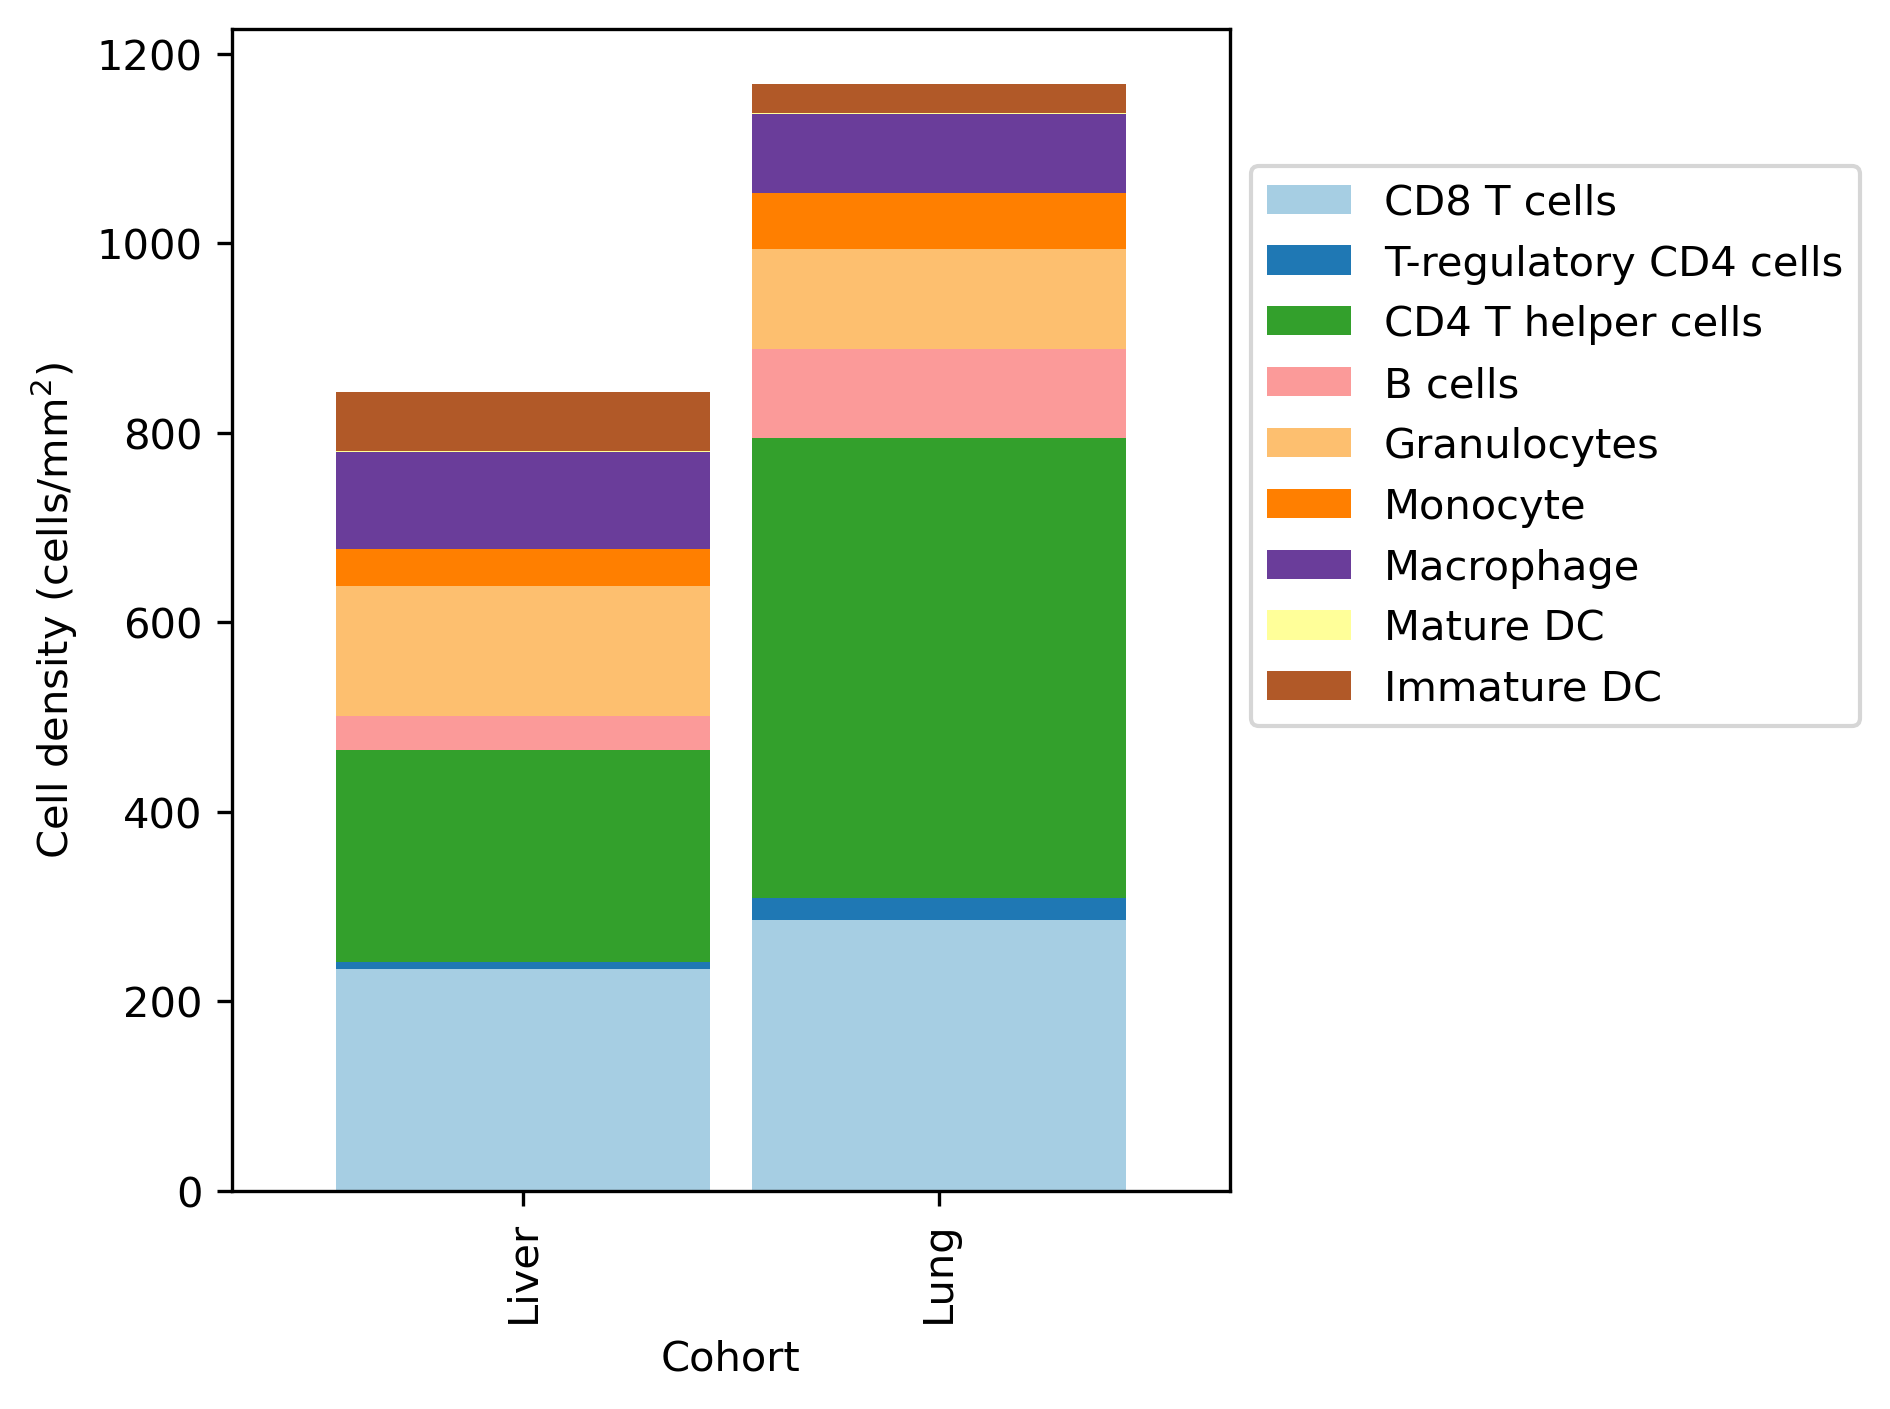

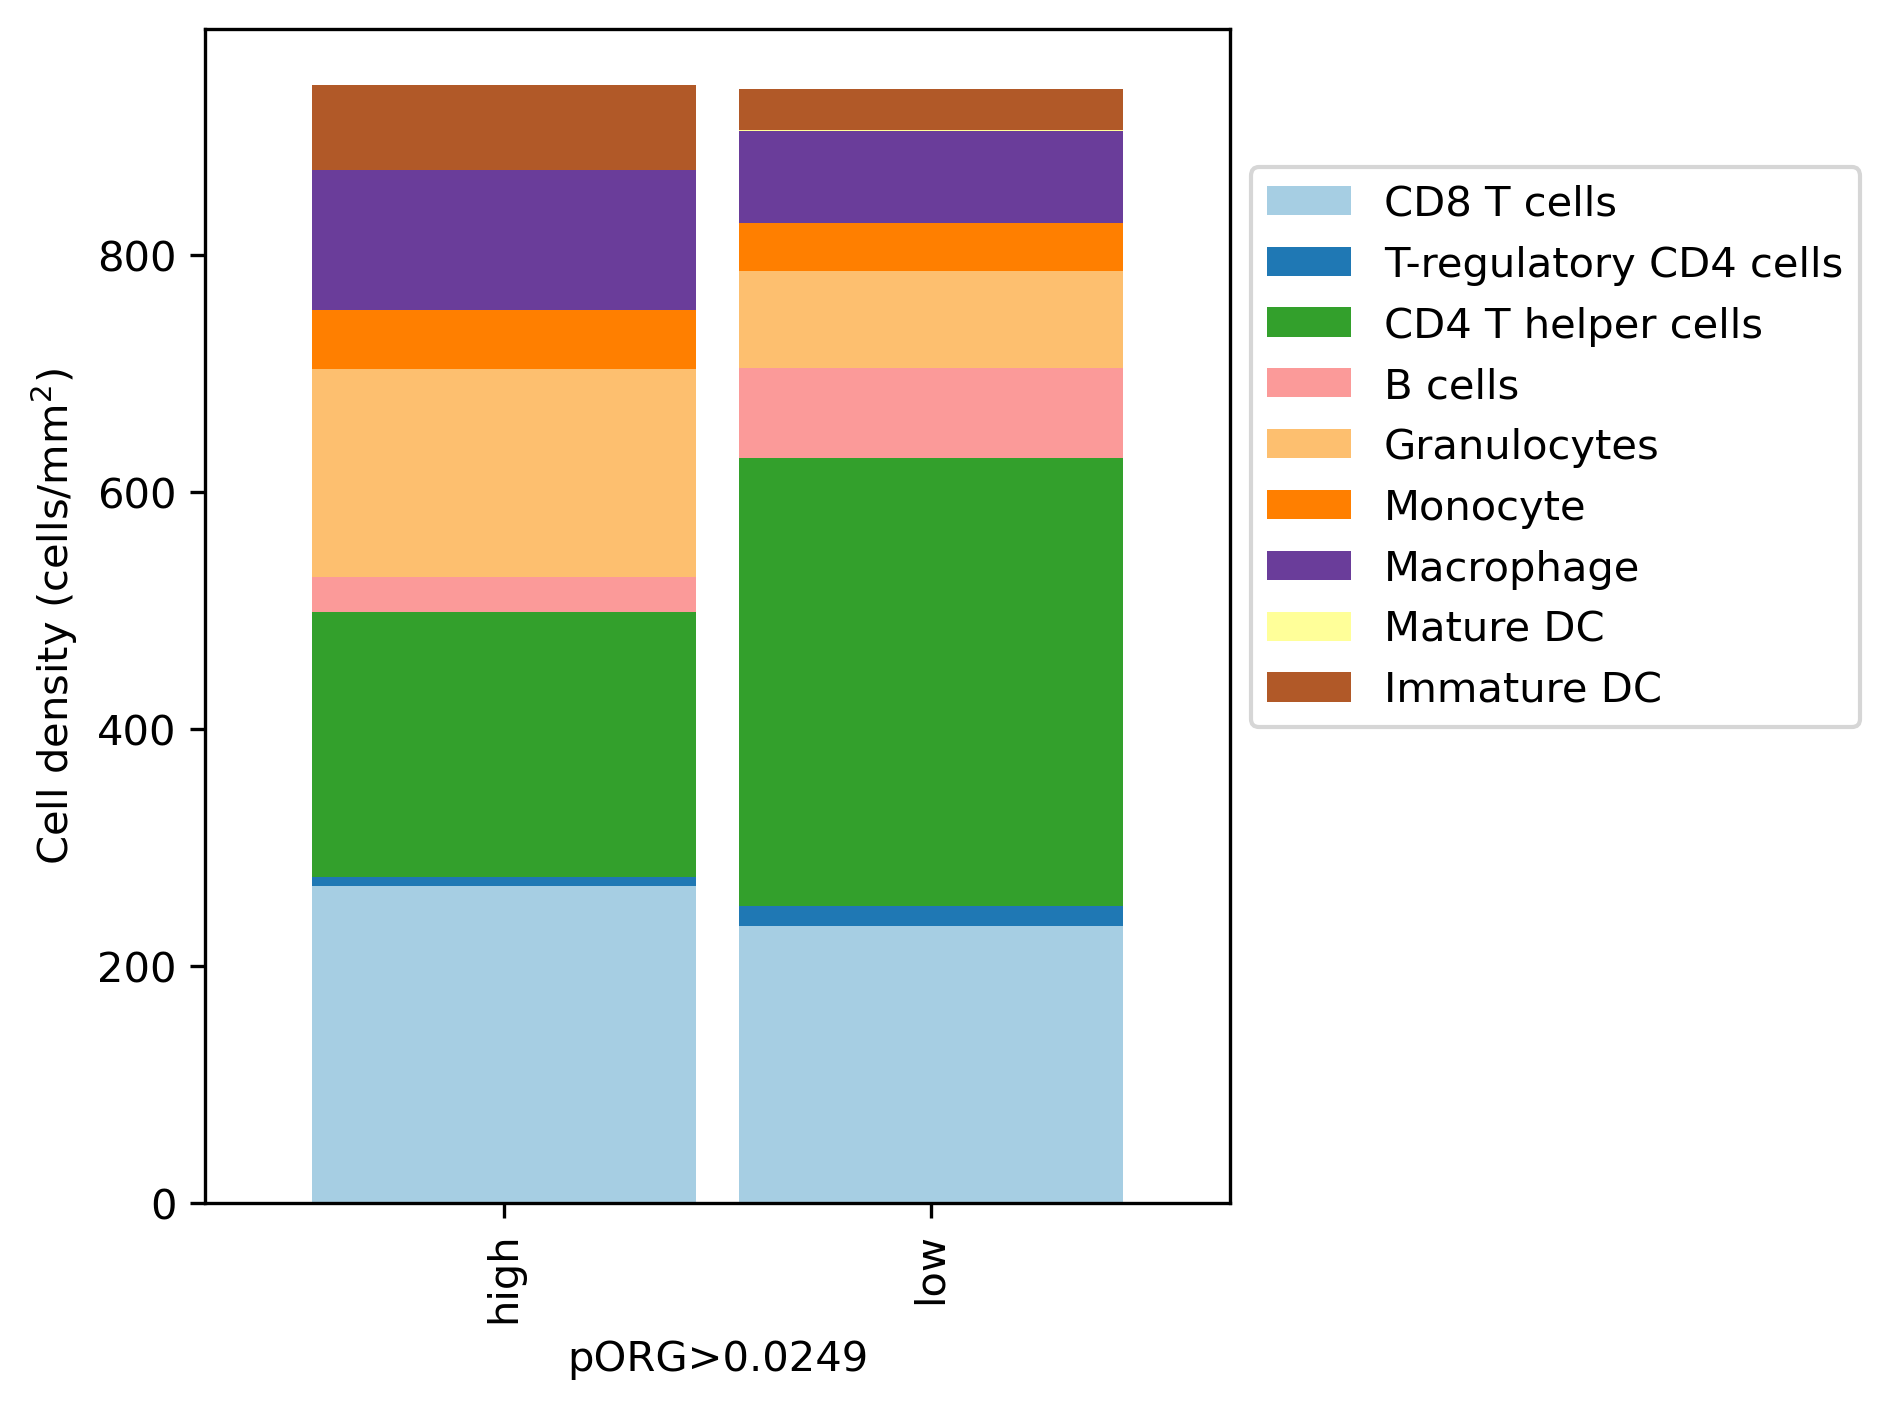

In [294]:
# stacked bar
ls_mihc = ['CD8 T cells', 'T-regulatory CD4 cells',
       'CD4 T helper cells', 'B cells', 'Granulocytes', 'Monocyte',
       'Macrophage', 'Mature DC', 'Immature DC', #'Immune Other', 'PanCK+',
       #'aSMA+', 'Other Cells', 
          ]

for s_group in ['Cohort','pORG>0.0249']:
    fig,ax=plt.subplots(dpi=300)
    df_mean = df_density.loc[:,ls_mihc+[s_group]].groupby(s_group).mean()
    df_mean.plot(kind='bar',width=.9,stacked=True,ax=ax,colormap='Paired')
    ax.legend(bbox_to_anchor=(1,.9))
    ax.set_ylabel('Cell density (cells/mm$^2$)')
    plt.tight_layout()

In [295]:
df_density.loc[:,s_group].value_counts()

pORG>0.0249
low     90
high    84
Name: count, dtype: int64

In [298]:
df_density.Patient.unique()
df_density

,Sample_ID,Location,Cohort,pORG,Patient,CD8 T cells,T-regulatory CD4 cells,CD4 T helper cells,B cells,Granulocytes,Monocyte,Macrophage,Mature DC,Immature DC,pORG>0.0249
0,1127,T,Liver,high_pORG,4826-T,140.655585,4.697731,134.023494,1.934360,562.069665,11.882495,75.163692,0.276337,72.400321,high
1,1127,T,Liver,high_pORG,4826-T,71.344559,2.366881,56.805147,0.676252,523.756977,5.410014,36.517594,0.676252,62.553287,high
2,1127,B,Liver,high_pORG,4826-T,288.723414,9.889670,212.902613,5.494261,331.853363,20.603479,81.589775,0.549426,84.336906,high
3,1127,B,Liver,high_pORG,4826-T,340.151078,5.584570,216.275163,4.315349,324.158900,19.799839,76.153226,0.253844,71.076345,high
4,1127,T,Liver,high_pORG,4826-T,341.259173,3.094319,266.553473,16.355686,311.200075,22.102278,109.627299,0.442046,31.827280,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,248041,D,Lung,low_pORG,4594-T,57.849962,3.708331,96.416603,0.000000,42.645805,31.891646,50.433300,0.000000,7.416662,low
170,248041,T,Lung,low_pORG,4594-T,125.777297,20.162773,216.989840,0.640088,38.725326,48.966734,46.086338,0.000000,23.683257,low
171,248041,D,Lung,low_pORG,4594-T,158.076385,16.313933,222.488293,0.281275,36.565712,48.379249,111.103509,0.562549,15.751384,low
172,248041,D,Lung,low_pORG,4594-T,193.880486,15.411013,232.656583,0.497129,36.290450,42.753133,67.609605,0.000000,20.382307,low


In [299]:
df_patient

,Sample_ID,Patient_x,Public_Patient_ID,pORG_0.2_Primary,pORG_0.2_allPrimary,pSUB1e-04_Primary,pSUB1e-04_allPrimary,Cohort,pORG,Days to FU,...,KI67,PD1,PDL1,CD163,CCR2,HLAII,EOMES,pORG>0.0249,Days from Diagnosis to FU,Vital Status at FU
0,1127,4826-T,ST-00018955,0.484875,0.445509,0.516487,0.546079,Liver,high,372,...,245.744396,61.473013,8.350387,303.934313,210.130859,62.403804,46.972480,high,883,Alive
1,1749,4537-T,ST-00017804,-0.340131,-0.292597,-0.371146,-0.359650,Lung,high,403,...,96.985948,16.601002,9.608996,258.365146,85.100518,337.847957,36.692072,low,1681,Dead
2,6951,4793-T,ST-00019367,-0.450600,-0.377037,0.107381,0.074922,Liver,high,406,...,189.975193,15.209388,2.256448,277.741103,86.297556,99.452846,15.094711,low,391,Dead
3,7080,4759-T,ST-00019368,0.341185,0.189588,0.178912,0.123498,Liver,high,883,...,107.311877,2.681445,2.063189,282.479105,21.073090,17.223574,1.466247,high,499,Dead
4,8049,4456-T,ST-00016289,0.301062,0.347179,0.170814,0.143582,Liver,high,1258,...,905.923498,63.775708,33.970351,360.965788,304.397388,160.836130,84.898445,high,406,Dead
5,8122,4723-T,ST-00020181,0.451879,0.358552,-0.481534,-0.456484,Liver,low,391,...,50.432459,8.172715,3.901025,230.508823,16.311604,342.192777,14.896756,high,403,Dead
6,15475,4511-T,ST-00017078,-0.195148,-0.259069,-0.544573,-0.551558,Liver,low,1104,...,1192.162630,31.415225,6.841105,600.271450,94.982238,379.870887,26.738365,low,1678,Alive
7,18268,4544-T,ST-00017310,0.294011,0.216501,0.327145,0.311805,Liver,low,1264,...,506.678091,12.006510,2.259449,220.072324,33.541497,133.040264,5.202446,high,1264,Dead
8,19234,4509-T,ST-00017381,0.288409,0.257662,-0.621047,-0.624557,Liver,low,1678,...,974.008060,36.282276,33.532378,680.000531,310.824788,127.418536,17.402115,high,1258,Dead
9,164354,4432-T,ST-00015839,-0.639320,-0.604123,-0.521509,-0.559595,Lung,low,192,...,466.288337,35.900238,10.312963,931.406951,1088.084378,711.831936,25.612572,low,1104,Dead


In [297]:
df_density.loc[:,'Cohort'].value_counts()

Cohort
Liver    121
Lung      53
Name: count, dtype: int64

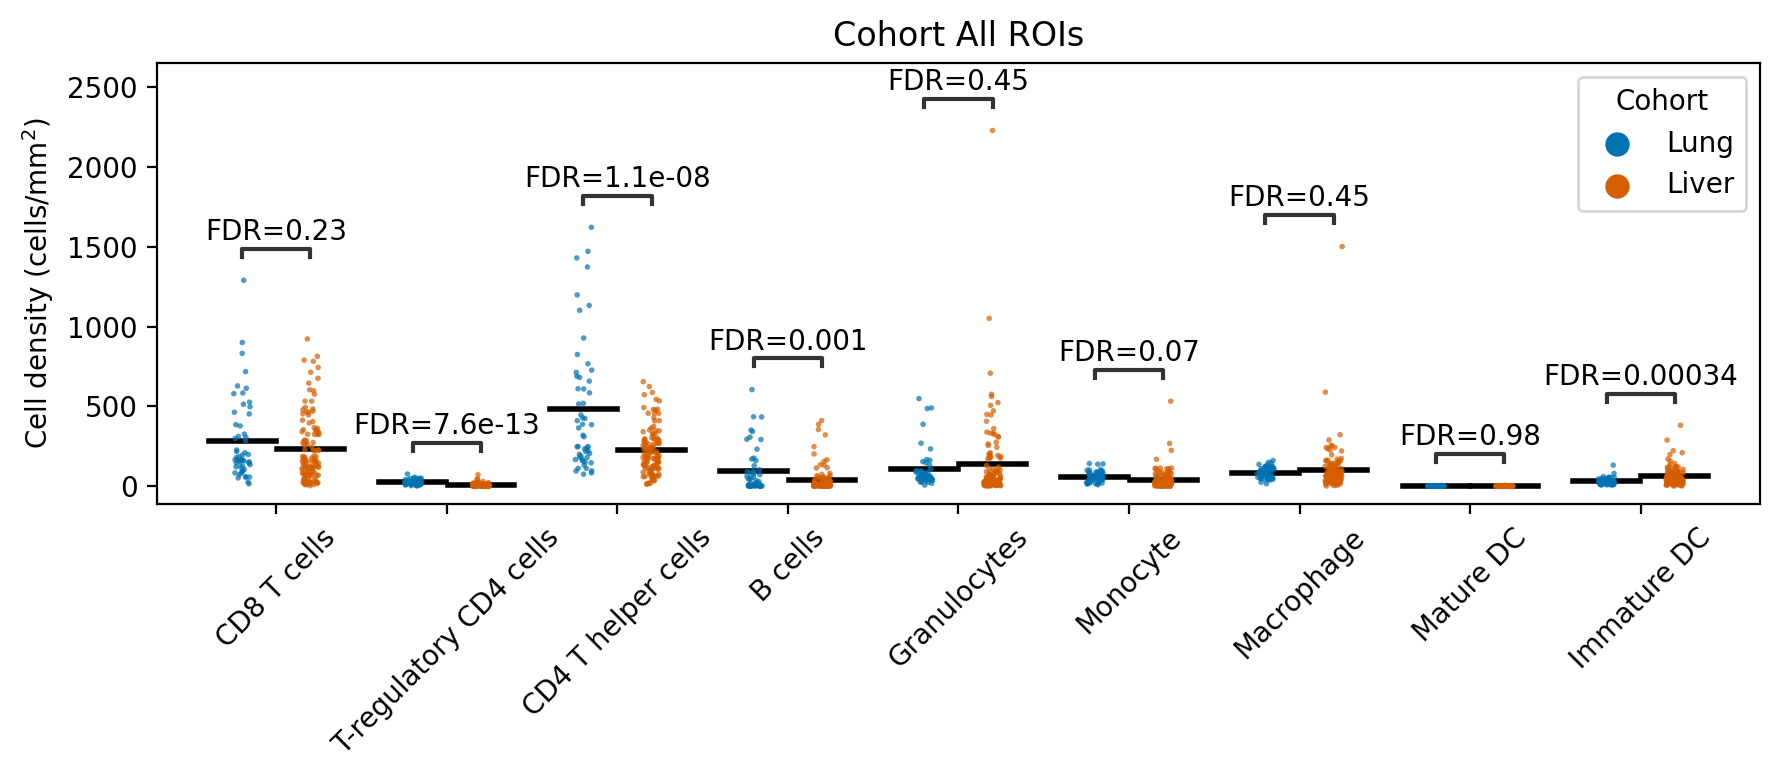

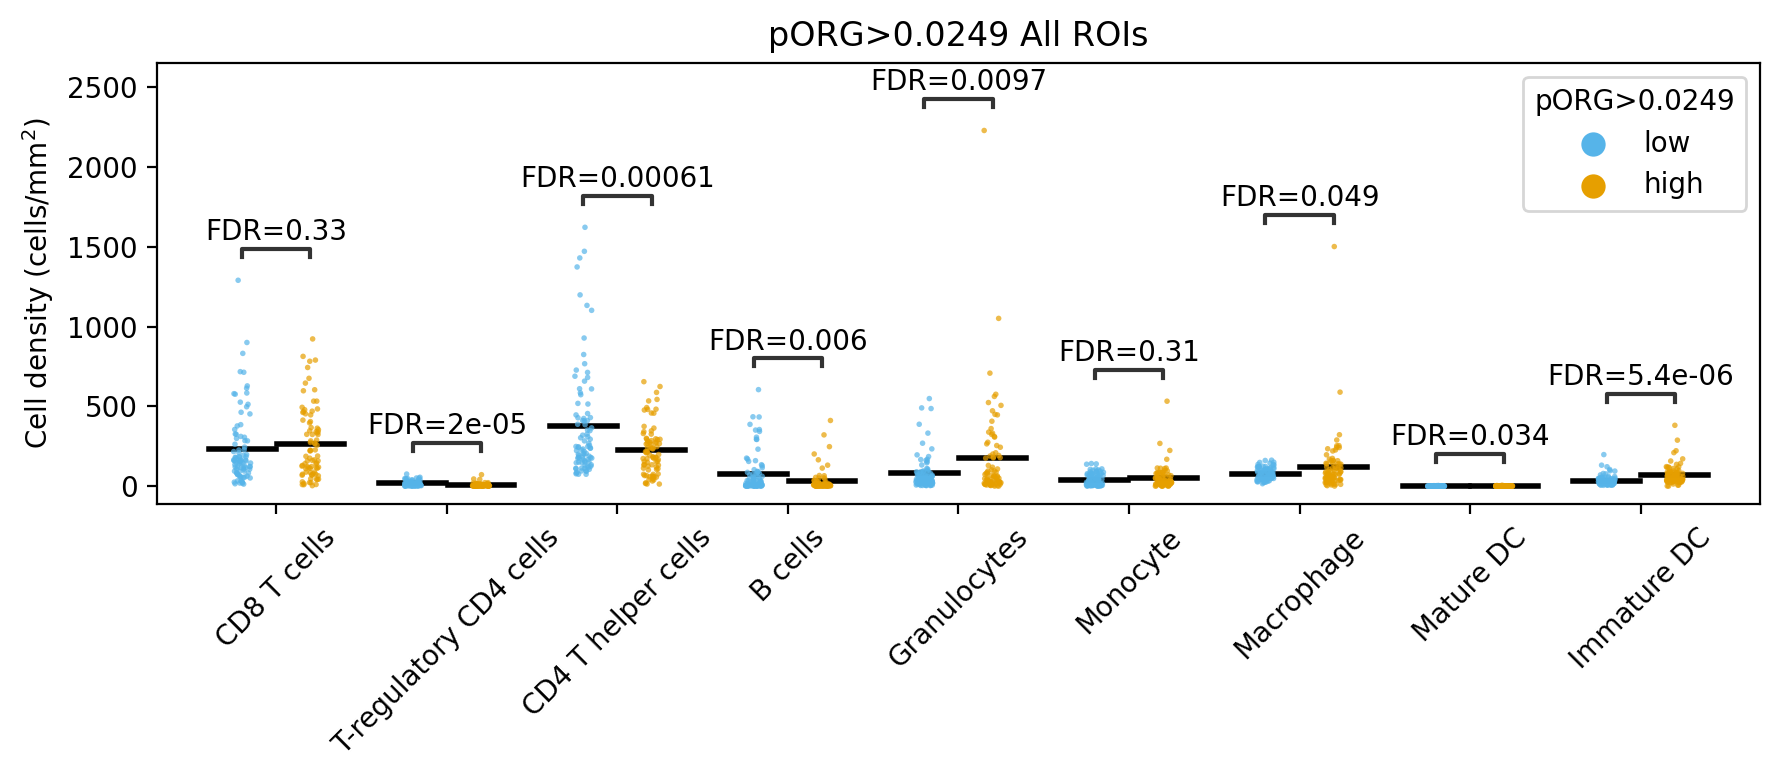

In [313]:
# roi
from statannotations.Annotator import Annotator
importlib.reload(util)
d_hue = {'Cohort':['Lung','Liver',],'pORG>0.0249':['low','high',]}
x = "cell_type"
y = "density"
order = ['CD8 T cells','T-regulatory CD4 cells','CD4 T helper cells',
         'B cells','Granulocytes', 'Monocyte', 'Macrophage',
       'Mature DC','Immature DC',  
       ]
pal_porg_r = ('#56B4E9','#E69F00',)
pal_liv_r = ('#0072B2','#D55E00',)
%matplotlib inline
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for hue in ['Cohort','pORG>0.0249']:
        if hue == 'Cohort':
            sns.set_palette(pal_liv_r)
        else:
            sns.set_palette(pal_porg_r)
        for s_region in ['All']:#,'Tumor','Border','Distal'
            if s_region == 'All':
                df_mean = df_density.loc[:,ls_mihc+['Sample_ID']]#.groupby(['Sample_ID']).mean()
            else:
                continue
                #df_mean = df_density.loc[df_density.Location==s_region[0],ls_mihc+['Sample_ID']].groupby(['Sample_ID']).mean()
            df_mean = df_mean.reset_index().set_index('Sample_ID')
            df_long = df_mean.stack().reset_index().rename({'level_1':'cell_type',0:'density'},axis=1)
            df_long[hue] = df_long.Sample_ID.map(dict(zip(df_patient.Sample_ID,df_patient.loc[:,hue])))
            #plot
            figsize = (9,4)
            hue_order = d_hue[hue]
            fig, ax = util.annotated_stripplot_hue(df_long,x,y,hue,order,hue_order,figsize,b_correct=True)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
            ax.set_ylabel('Cell density (cells/mm$^2$)')
            ax.set_xlabel('')
            ax.set_title(f'{hue} {s_region} ROIs')
            plt.tight_layout()
            plt.savefig(f'figures/mIHC_per_patient_by_{hue}_density_in_{s_region}.png', dpi=300, bbox_inches='tight')
        #break

In [312]:
pvals = np.array([0.156317606,8.49E-14,2.37E-09,0.000461868,
0.402545821,0.039025283,0.374874377,0.983725258,0.000113532,])
pvals = np.array([0.32718848,
4.37E-06,
0.000201767,
0.002671442,
0.005402357,
0.277169408,
0.038489462,
0.022766419,
6.05E-07])
reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvals,method='fdr_bh')
[print(f'{item:.3}')  for item in corrected]

0.327
1.97e-05
0.000605
0.00601
0.00972
0.312
0.0495
0.0341
5.45e-06


[None, None, None, None, None, None, None, None, None]

In [ ]:
#patient level
importlib.reload(util)
d_hue = {'Cohort':['Lung','Liver',],'pORG>0.0249':['low','high',]}
x = "cell_type"
y = "density"
d_order = {'Cohort':['CD4 T helper cells', #'CD8 T cells', 'Granulocytes', 'Macrophage',
       'Immature DC', 'B cells',  'T-regulatory CD4 cells'],#'Monocyte',       'Mature DC'],
           'pORG>0.0249':['CD4 T helper cells',  'Granulocytes', 'Macrophage',#'CD8 T cells',
       'Immature DC', 'B cells',  'T-regulatory CD4 cells','Mature DC']}#'Monocyte',       ],
pal_porg_r = ('#56B4E9','#E69F00',)
pal_liv_r = ('#0072B2','#D55E00',)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for hue in ['Cohort','pORG>0.0249']:
        order = d_order[hue]
        if hue == 'Cohort':
            figsize = (5,4)
            sns.set_palette(pal_liv_r)
        else:
            figsize = (7,4)
            sns.set_palette(pal_porg_r)
        for s_region in ['All','Border','Tumor','Distal']:#
            if s_region == 'All':
                df_mean = df_density.loc[:,ls_mihc+['Sample_ID']].groupby(['Sample_ID']).mean()
            else:
                df_mean = df_density.loc[df_density.Location==s_region[0],ls_mihc+['Sample_ID']].groupby(['Sample_ID']).mean()
            df_mean = df_mean.reset_index().set_index('Sample_ID')
            df_long = df_mean.stack().reset_index().rename({'level_1':'cell_type',0:'density'},axis=1)
            df_long[hue] = df_long.Sample_ID.map(dict(zip(df_patient.Sample_ID,df_patient.loc[:,hue])))
            #plot
            
            hue_order = d_hue[hue]
            fig, ax = util.annotated_stripplot_hue(df_long,x,y,hue,order,hue_order,figsize,b_correct=True,loc='upper right',s=5)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
            ax.set_ylabel('Cell density (cells/mm$^2$)')
            ax.set_xlabel('')
            ax.set_title(f'{s_region} ROIs: Mean per Patient')
            plt.tight_layout()
            plt.savefig(f'figures/mIHC_per_patient_by_{hue}_density_in_{s_region}.png', dpi=300, bbox_inches='tight')
            break

In [ ]:
# # boxplot starthere

# df = df_patient.loc[:,ls_mihc].unstack().reset_index().rename({'level_0':'cell type',0:'Density'},axis=1)
# df['pORG'] = df.level_1.map(dict(zip(df_patient.index,df_patient.pORG)))
# df['Cohort'] = df.level_1.map(dict(zip(df_patient.index,df_patient.Cohort)))
# for s_group in ['Cohort','pORG']:
#     if s_group == 'Cohort':
#         pal_liv = ('#D55E00','#0072B2',)
#         sns.set_palette(pal_liv)
#     else:
#         pal_porg = ('#E69F00','#56B4E9',)
#         sns.set_palette(pal_porg)
#     fig,ax=plt.subplots(figsize=(8,4),dpi=200)
#     #sns.violinplot(data=df,x='cell type',y='Density',hue=s_group,cut=0,ax=ax)
#     sns.stripplot(data=df,x='cell type',y='Density',hue=s_group,dodge=True,ax=ax)
#     sns.boxplot(data=df,x='cell type',y='Density',hue=s_group,ax=ax,showmeans=True,
#                 medianprops={'visible': False},whiskerprops={'visible': False},
#                 meanline=True,showcaps=False,
#                 meanprops={'color': 'k', 'ls': '-', 'lw': 2},
#                 showfliers=False,showbox=False)#
#     # Rotating X-axis labels
#     ax.set_xticklabels(ax.get_xticklabels(), rotation = 50)
#     ax.set_xlabel('')
#     h, l = ax.get_legend_handles_labels()
#     ax.legend(h[0:2],l[0:2],loc='upper right',title=s_group)
#     ls_group = sorted(df.loc[:,s_group].unique())
#     pairs = [((item,ls_group[1]),(item,ls_group[0])) for item in ls_mihc]
#     annot = Annotator(ax, pairs, data=df,x='cell type',y='Density',hue=s_group,
#                       order=ls_mihc,hue_order=ls_group)
#     annot.configure(test='t-test_ind', text_format='star',fontsize=7) #,comparisons_correction='fdr_bh'
#     res = annot.apply_test()
#     d_pval = dict([(res.data.group1[0],res.data.pvalue) for res in annot.annotations])
#     pvalues = [d_pval[item] for item in ls_mihc]
#     reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
#     formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(pvalues)]
#     annot.set_custom_annotations(formatted_pvalues)
#     annot.annotate()


In [ ]:
# # dowload mIHC data from https://www.synapse.org/#!Synapse:syn51078766
# # combine ROIs into large dataframe and save
# if not os.path.exists(f'data/20221123_mIHC_LiverLung_Celltypes.csv'):
#     ls_col = ['Sample_ID','class','Location_Center_X', 'Location_Center_Y', 
#            'GRZB_func', 'KI67_func', 'PD1_func', 'PDL1_func', 'CD163_func',
#            'CCR2_func', 'HLAII_func', 'EOMES_func','Area']
#     df_ll =pd.DataFrame()
#     for s_file in sorted(os.listdir('mIHC_Data')):
#         df = pd.read_csv(f'mIHC_Data/{s_file}',index_col=0)
#         s_sample = s_file.split('LiverLungBCC')[1].split('.')[0]
#         df['Sample_ID'] = s_sample
#         df.index = [f'{s_sample.split("Nuclei_")[1].replace("ROI","_scene")}_cell{item}' for item in df.index]
#         df_ll = pd.concat([df_ll,df.loc[:,ls_col]])
#         break
#     df_ll['Organ'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Met Site'])))
#     df_ll['Location'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Location'])))
#     df_ll['Desc'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Desc'])))
#     df_ll.to_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv')

In [ ]:
#load data
df_ll = pd.read_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv',index_col=0,low_memory=False)
print(len(df_ll))

df_ll_ann = pd.read_csv('data/LiverLung_annotations.csv',index_col=0)
df_ll_roi = pd.read_csv('data/annotated_LiverLung_perROI.csv',index_col=0)

In [ ]:
#add annotation
df_ll['Sample_ID_short'] = [item.split('Nuclei_')[1].split('ROI')[0] for item in df_ll.Sample_ID]
df_ll['Sample_ID_int'] = [int(item) for item in df_ll.Sample_ID_short]
df_ll['ROI'] = [int(item.split('ROI')[1]) for item in df_ll.Sample_ID]
df_ll['Cohort'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Cohort)))
df_ll['Patient'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Patient)))
df_ll['Sample_ROI'] = df_ll.Sample_ID_int.astype('str') + '_' + df_ll.ROI.astype('str')
df_ll_roi['Sample_ROI'] = df_ll_roi.index.astype('str') + '_' + df_ll_roi.ROI.astype('str')
df_ll['Location'] = df_ll.Sample_ROI.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Location'])))

In [ ]:
df_ll['classII'] = df_ll.loc[:,'class'].replace({'T-regulatory CD4 cells':'T cells',
                                                 'CD4 T helper cells':'T cells','CD8 T cells':'T cells'}) #
df_ll.rename({'class':'classI'},axis=1,inplace=True)

In [ ]:
d_color = dict(zip(['ST-00016289', 'ST-00017078', 'ST-00017310', 'ST-00017381',
       'ST-00018269', 'ST-00018955', 'ST-00019367', 'ST-00019368',
       'ST-00020181'],sns.color_palette('Purples',9)))
d_color.update(dict(zip(['ST-00015839', 'ST-00017440', 'ST-00017804'],sns.color_palette('Blues',3))))


In [ ]:
# boxplot figure friendly
# look as carl's youden cutoff for pORG
if s_column == 'classI':
    cutoff = 0.0249
    df_group.loc[df_group.loc[:,'pORG_Primary'] > cutoff,f'pORG'] = 'high' # 'pORG_0.2_Primary','pORG_0.2_Met','pORG_0.2_allPrimary','pORG_0.2_allMet',
    df_group.loc[df_group.loc[:,'pORG_Primary'] <= cutoff,f'pORG'] = 'low'
    print(df_group.pORG.value_counts())
    ls_mihc = [ #'PanCK+','aSMA+',
               'CD4 T helper cells','CD8 T cells','B cells', 'T-regulatory CD4 cells',
        'Granulocytes', 'Monocyte',
     'Macrophage', 'Mature DC','Immature DC']
    df = df_group.loc[:,ls_mihc].unstack().reset_index().rename({'level_0':'cell type',0:'Fraction'},axis=1)
    df['pORG'] = df.level_1.map(dict(zip(df_group.index,df_group.pORG)))
    df['Cohort'] = df.level_1.map(dict(zip(df_group.index,df_group.Cohort)))
    for s_group in ['Cohort','pORG']:
        if s_group == 'Cohort':
            pal_liv = ('#0072B2','#D55E00')
            sns.set_palette(pal_liv)
        else:
            pal_porg = ('#56B4E9','#E69F00',)
            sns.set_palette(pal_porg)
        fig,ax=plt.subplots(figsize=(8,4),dpi=200)
        #sns.violinplot(data=df,x='cell type',y='Density',hue=s_group,cut=0,ax=ax)
        sns.stripplot(data=df,x='cell type',y='Fraction',hue=s_group,dodge=True,ax=ax)
        sns.boxplot(data=df,x='cell type',y='Fraction',hue=s_group,ax=ax,showmeans=True,
                    medianprops={'visible': False},whiskerprops={'visible': False},
                    meanline=True,showcaps=False,
                    meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                    showfliers=False,showbox=False)#
        # Rotating X-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 50)
        ax.set_xlabel('')
        h, l = ax.get_legend_handles_labels()
        ax.legend(h[0:2],l[0:2],loc='upper right',title=s_group)
        ls_group = sorted(df.loc[:,s_group].unique())
        pairs = [((item,ls_group[1]),(item,ls_group[0])) for item in ls_mihc]
        annot = Annotator(ax, pairs, data=df,x='cell type',y='Fraction',hue=s_group,
                          order=ls_mihc,hue_order=ls_group)
        annot.configure(test='t-test_ind', text_format='star',fontsize=7) #,comparisons_correction='fdr_bh'
        res = annot.apply_test()
        d_pval = dict([(res.data.group1[0],res.data.pvalue) for res in annot.annotations])
        pvalues = [d_pval[item] for item in ls_mihc]
        reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
        formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(pvalues)]
        annot.set_custom_annotations(formatted_pvalues)
        annot.annotate()


In [ ]:
#by location
s_define = 'pORG_Primary'#'trim_padj_0.2_pORG_Up_55_Genes'#'txi_pORG_Up_42_Genes'#''#
s_group = 'Cohort'
alpha = 0.05
s_column = 'classI'#'classII'#
if s_column == 'classI':
    ls_mihc = [ 'T-regulatory CD4 cells', 'CD4 T helper cells','PanCK+','aSMA+','CD8 T cells','B cells', 'Granulocytes', 'Monocyte',
 'Macrophage', 'Mature DC','Immature DC']
elif s_column == 'classII':
    ls_mihc = ['T cells', #'B cells', 'Granulocytes', 'Monocyte', 'Macrophage',
       #'Mature DC', 'Immature DC', 'Immune Other', 'PanCK+', 'aSMA+','Other Cells'
       ]
s_patient = 'Public_Patient_ID'

for s_loc in ['all','T','B','D']: 
    if s_loc == 'all':
        df_loc = df_ll
    else:
        df_loc = df_ll[df_ll.Location==s_loc]
    print(len(df_loc.Sample_ID_short.unique()))
    df_group = (df_loc.groupby(['Patient',s_column]).count().Sample_ID/(df_loc.groupby(['Patient']).count().Sample_ID)).unstack()
    df_group[s_patient] = df_group.index
    df_group['Cohort'] = df_group.index.map(dict(zip(df_ll_roi.Patient,df_ll_roi.loc[:,'Cohort'])))
    df_group = df_group.merge(df_surv.loc[:,['Survival','Days from Diagnosis to FU',s_define,s_patient]],on=s_patient)
    df_group = df_group[~df_group.loc[:,s_patient].duplicated()]
    df_group = df_group[df_group.Cohort!='Liver met'].fillna(0)
    ls_order = sorted(df_group.loc[:,s_group].unique())
    for s_marker in ls_mihc:
        try:
            s_high = df_group.loc[:,s_group].unique()[0]
            s_low = df_group.loc[:,s_group].unique()[1]
        except:
            continue
        n_high = sum(df_group.loc[:,s_group]==s_high)
        n_low = sum(df_group.loc[:,s_group]==s_low)
        statistic,pvalue = stats.ttest_ind(df_group.loc[df_group.loc[:,s_group]==s_high,s_marker],
                                           df_group.loc[df_group.loc[:,s_group]==s_low,s_marker])
        if pvalue <= alpha:
            df_group_roi = (df_loc.groupby(['Sample_ROI',s_column]).count().Sample_ID/(df_loc.groupby(['Sample_ROI']).count().Sample_ID)).unstack()
            df_group_roi['Cohort'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Cohort'])))
            df_group_roi['Patient'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Patient'])))
            df_group_roi = df_group_roi[df_group_roi.Cohort.isin(['liver_cohort','lung_cohort'])]
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            sns.boxplot(data=df_group_roi,x=s_group,y=s_marker,showfliers=False,ax=ax,order=[str(item) for item in ls_order],palette=['mediumpurple','deepskyblue'])
            sns.stripplot(data=df_group_roi,x=s_group,y=s_marker,ax=ax,hue='Patient',s=3,palette=d_color)
            ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
            ax.set_title(f'{s_group} versus\n {s_marker}\n p={pvalue:.4f} (n={n_low}, {n_high})')
            ax.set_ylabel(f'{s_marker} in {s_loc}')
            #ax.set_ylabel(f'{s_marker}')
            ax.get_legend().remove()
            plt.tight_layout()
            #fig.savefig(f'{s_date}/boxplot_mIHC_{s_marker}_versus_{s_group}_in_{s_loc}.png')
    #     break
    # break

In [ ]:

print(df_group.groupby('Cohort').mean(numeric_only=True).loc[:,s_define])
print(df_group.groupby('Cohort').sem(numeric_only=True).loc[:,s_define])

In [ ]:
fig,ax=plt.subplots(dpi=300)
df_group.groupby('Cohort').mean().loc[:,ls_mihc].plot(kind='bar',width=.9,stacked=True,ax=ax,colormap='Paired')
ax.legend(bbox_to_anchor=(1,.9))
ax.set_ylabel('Fraction in Tissue')
plt.tight_layout()

# Section 4 <a name="meta"></a>

old code to create patient metadata tidy data

saved as supplemental dataset 1


[contents](#contents)

### Patients in LabKey

In [ ]:
# # load patient vital status
# #also had stage/ grade/ lymph nodes etc.
# df_vital = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/FMP_Patients_Nov17_2021.xlsx',sheet_name='Sheet1')

# #Stage 1 pancreatic cancer means the cancer is not more than 4cm in size and it hasn't spread outside the pancreas. It is split into 1A and 1B.
# # 1A In TNM staging, this is the same as T1, N0, M0 1B In TNM staging, this is the same as T2, N0, M0

# # Stage 2A means the cancer is bigger than 4cm but is still within the pancreas. It has not spread to the lymph nodes Open a glossary item or other areas of the body.
# #2A in TNM staging, this is the same as T3, N0, M0. 2B In TNM staging, this is the same as T1, 2 or 3, N1, M0.

# #3 Stage 3 can mean that the cancer is any size within the pancreas and has spread to 4 or more nearby lymph nodes Open a glossary item.
# #In TNM staging, this is the same as T1, 2 or 3, N2, M0.
# #Or stage 3 can mean the cancer has started to grow outside the pancreas into the major blood vessels nearby. It may or may not have spread into the lymph nodes. It hasn't spread to any other areas of the body.
# #In TNM staging, this is the same as T4, Any N, M0.

# #4 Your doctor might call this advanced (metastatic) cancer.
# #In TNM staging, this is the same as Any T, Any N, M1.

# #collapse stage
# d_stage = {'2B - IIB':'II', 'p2A':'II', 'p2B':'II', '4 - IV':'IV', '2A - IIA':'II', 'p3':'III', '1B - IB':'I',
#     'c1B':'I', 'c2B':'I', 'nan':pd.NA, 'p4':'IV','2B - T1-3, N1, M0':'II','p0':'0','p1B':'I','c1':'I',
#     'c4':'IV','c3':'III','p1A':'I','pNA':pd.NA,'3 - T4, Any N, M0':'III','c2A':'II','p4B':'IV','c4B':'IV',
#      '2B - T1, N1, M0 / T2, N1, M0 / T3, N1, M0':'II','pUNK':pd.NA,'p2':'II','p3B':'III','c2':'II','p3A':'III',
#     '3 - III':'III','99 - Unknown':pd.NA,'1A - IA':'I','c3A':'III','c4A':'IV','p1':'I','c1A':'I','p4A':'IV',
#     '88 - Not applicable to 7th Edition staging':pd.NA,
#            '88 - No classification is recommended in 6th Edition':pd.NA,
#     '2A - T3, N0, M0':'II','4 - Any T, Any N, M1':'IV'}
# df_vital['Stage'] = pd.NA
# df_vital['Stage'] = df_vital.loc[:,'Stage Grouping _ Dominant'].replace(d_stage) 

# #collapse grade

# d_grade = {'Grade II  Moderately Diff / Mod Well Diff':'2',
#        'Grade I   Well Differentiated/Differentiated':'1',
#        'Cell type not determined; not stated;N/A;Unk; high grade dysplas':pd.NA,
#        'Grade III Poorly Differentiated':'3', 'nan':pd.NA,'Grade IV Undifferentiated, Anaplastic':'4',
#          'B-CELL    LYMPHOMA OR LEUKEMIA ONLY':pd.NA}
# df_vital['Grade'] = pd.NA
# df_vital['Grade'] = df_vital.loc[:,'Grade_Differentiation'].replace(d_grade)

# #collapse LV invasion
# d_replace = {'nan':pd.NA,np.nan:pd.NA, 'LYMPHOVASCULAR INVASION STATED AS NOT PRESENT':'NO',
#        'LYMPHOVASCULAR INVASION PRESENT/IDENTIFIED':'YES',
#        'Unknown/Indeterminate':pd.NA, 'NOT APPLICABLE':pd.NA,
#        'Lymph-vascular Invasion Present/Identified':'YES',
#        'LYMPHATIC AND SMALL VESSEL INVASION ONLY (L)':'YES',
#        'BOTH LYMPHATIC AND SMALL VESSEL AND VENOUS (LARGE VESSEL) INVASION':'YES'}
# df_vital['LV_Invasion'] = pd.NA
# df_vital['LV_Invasion'] = df_vital.loc[:,'Lymph_vascular Invasion'].replace(d_replace)

# # LN positivity
# df_vital['LN_Pos'] = pd.NA
# df_vital.loc[df_vital.loc[:,'Regional Lymph Nodes Positive'] >= 1,'LN_Pos'] = True
# df_vital.loc[df_vital.loc[:,'Regional Lymph Nodes Positive'] < 1,'LN_Pos'] = False
# df_vital.loc[df_vital.loc[:,'Regional Lymph Nodes Positive'].isna(),'LN_Pos'] = pd.NA
# df_vital['LN_Pos']  = df_vital.LN_Pos.replace({True:'YES',False:'NO'})

# df_vital['Survival'] = df_vital.cVitalStatus.replace({'Alive':0,'Dead':1})
# print(df_vital.Grade.unique())
# print(df_vital.Stage.unique())
# print(df_vital.LN_Pos.unique())
# print(df_vital.LV_Invasion.unique())
# print(len(df_vital))

In [ ]:
# # kaplan meier
# # %matplotlib inline
# # # check prognostic value of clinicopathologiocal variables

# # ls_vital = ['Stage', 'Grade','LV_Invasion','LN_Pos'] 
# # s_time = 'cDays from Diagnosis to FU'
# # s_censor = 'Survival'
# # for s_vital in ls_vital:
# #     print(s_vital)
# #     df = df_vital.loc[df_vital.loc[:,'Primary Site _ Major Groups For Staging']=='Pancreas',[s_vital,s_time,s_censor]].dropna(how='any')
# #     fig, __ = util.km_plot(df,s_vital,s_time,s_censor)
# #     fig.savefig(f'figures/KM_clinicopath_{s_vital}.png')
# #     #break

# #CPH
# s_time = 'cDays from Diagnosis to FU'
# #df_vital['Survival_time'] = df_vital.loc[:,s_time]
# s_censor = 'Survival'
# ls_vital = ['LV_Invasion','Stage', 'Grade','LN_Pos'] #,'Age'
# for s_vital in ls_vital:
#     print(s_vital)
#     df = df_vital.loc[df_vital.loc[:,'Primary Site _ Major Groups For Staging']=='Pancreas',[s_vital,s_time,s_censor]].dropna(how='any')
#     if df.columns.isin(['Stage']).any():
#         df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4}).astype('int')
#     if df.columns.isin(['Grade']).any():
#         df.Grade = df.Grade.astype('int')
#     if df.loc[:,s_vital].dtype=='O':
#         df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
#         df.drop(s_vital,axis=1,inplace=True)
#         s_vital = df_dummy.columns[0]
#         df[s_vital] = df_dummy
#     fig, cph = util.cph_plot(df,s_vital,s_time,s_censor,figsize=(3,1.5))
#     plt.tight_layout()
#     fig.savefig(f'figures/CPH_single_{s_vital}_all.png')
#     plt.close(fig)
#     break

### Patients in Paper 

n=434 specimens

n=422 patients

In [ ]:
# #load full patient data, neoadjuvant
# df_patient = pd.read_excel(f'data/SupplementalDataset1.xlsx',
#                            sheet_name='Patients - Tab 1')
# df_patient.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
# df_patient['Cohort'] = pd.NA
# df_patient.loc[df_patient.loc[:,'Lung Met Present']=='YES','Cohort'] = 'Lung'
# df_patient.loc[df_patient.loc[:,'Liver Met Present']=='YES','Cohort'] = 'Liver'
# #how many in cohorts
# for s_site in df_patient.Cohort.dropna().unique():
#     n_patients = df_patient[df_patient.Cohort==s_site].Public_Patient_ID.nunique()
#     print(f'{s_site} {n_patients}')
# print(f'number rows {len(df_patient)}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

# #define neodjuvant binary
# df_patient.loc[:,'Neoadjuvant Treatment'].unique()
# df_patient.loc[df_patient.loc[:,'Neoadjuvant Treatment'] == 'Yes Neoadjuvant','Neoadjuvant'] = 'Yes'
# df_patient['Neoadjuvant'] = df_patient.Neoadjuvant.fillna('No').replace('nan','No')

# #load T cell data
# df_tcell_tumor = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
#                          sheet_name='Tumor Samples')

# df_tcell_blood = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
#                          sheet_name='Blood Samples')

# #merge T cell blood and tumor
# df_tcell = df_tcell_tumor.merge(df_tcell_blood,on='Patient ID',suffixes=(' tumor',' blood'),how='outer')

# df_tcell.rename({'Productive Rearrangements (Observed Richness)':'Productive_Rearrangements',
#                 'Templates per ng':'Templates_per_ng','Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
# print(f'Add TCR patients {len(df_tcell)}')
# # #merge - no, add TCR later
# # df_patient = df_patient.merge(df_tcell,on='Public_Patient_ID',how='left',suffixes=('','_x'))
# # df_patient['INDEX'] = df_patient.index + 1
# print(f'number rows {len(df_patient)}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')
# #all 422 have OS and vital status
# print(f"Missing OS: {df_patient.loc[:,'Days from Diagnosis to FU'].isna().sum()}")
# print(f"Missing Vital Status: {df_patient.loc[:,'Vital Status at FU'].isna().sum()}")

In [ ]:
# #61?
# set([item.split('-')[2] for item in df_gsva.loc[:,'Patient Specimen ID']])
# df_purist.loc['ST-00014524']
# df_gsva[df_gsva.Public_Patient_ID=='ST-00014524']

In [ ]:
# #load Purist
# d_gsva = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx', sheet_name=None)
# df_gsva = d_gsva['Specimen Subtype - Tab 2'].loc[:,['PurIST Score','Patient Specimen ID','PurIST Subtype','Patient ID']]
# df_gsva.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
# df_gsva['Specimen_ID'] = [item.split('-')[-1] for item in df_gsva.loc[:,'Patient Specimen ID']]
# df_gsva.drop('Patient Specimen ID',axis=1,inplace=True)
# df_purist = df_gsva.pivot(index='Public_Patient_ID',columns=['Specimen_ID'],values='PurIST Score')
# df_purist['PurIST_Primary'] = df_purist.loc[:,'T'].fillna(df_purist.F).fillna(df_purist.T2)
# df_purist['PurIST_Primary_T2'] = df_purist.T2
# #odd that there are only 71 mets with purist calls
# df_purist['PurIST_Met'] = df_purist.loc[:,'M'].fillna(df_purist.M2)
# print(f'Pts with RNAseq: {df_purist.reset_index().Public_Patient_ID.nunique()}')
# df_patient = df_patient.merge(df_purist.reset_index().loc[:,['PurIST_Primary','PurIST_Met',
#                             'PurIST_Primary_T2','Public_Patient_ID']],
#                             on='Public_Patient_ID',how='left')
# print(f'number rows {len(df_patient)}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

In [ ]:
# df_gene2 = pd.read_csv('data/HighMedImpactVariantDataForStatsFromMH.tsv',sep='\t')
# df_gene2.columns = [item.replace('.',' ') for item in df_gene2.columns]

# #use tempus
# df_gene = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset2.xlsx',
#                             sheet_name='Mutation Data')

# def catch(func, handle=lambda e : e, *args, **kwargs):
#     try:
#         return func(*args, **kwargs)
#     except Exception as e:
#         return np.nan
# df_gene['Alteration_Function'] = [catch(lambda : item.split(' - ')[1]) for item in df_gene.loc[:,'Alteration Type']]
# df_gene['Gene_Function'] = df_gene.Gene + '_' + df_gene.Alteration_Function.fillna('__')
# df_gene['Gene_Function'] = [item.replace('___','') for item in df_gene['Gene_Function']]
# df_gene.head()

In [ ]:
# df_gene.Alteration_Function.value_counts()/len(df_gene)
# df_gene.Alteration_Function.isna().sum()/len(df_gene)

In [ ]:
# #add mutation data, if there are more than 9 patient with a mutation
# # df_gene = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset2.xlsx',
# #                            sheet_name='Mutation Data')
# #which patients were sequencedL
# se_patients = pd.Series(df_gene.loc[:,'Patient Specimen ID'].unique())
# print(f"number of genomics specimens: {len(se_patients)}")
# se_mets = se_patients[se_patients.str.contains('-M')]
# ls_met = [item.split('-')[0] + '-' + item.split('-')[1] for item in se_mets]
# se_pri = se_patients[~se_patients.str.contains('-M')]
# ls_pri = [item.split('-')[0] + '-' + item.split('-')[1] for item in se_pri]
# print(f'no. primary specimens {len(ls_pri)}')
# print(f'no. met specimens {len(ls_met)}')
# print(f'no. unique pts {len(set(ls_pri+ls_met))}')
# print(f'no. matched pts {len(set(ls_pri).intersection(set(ls_met)))}')
# print(f'no. duplicated pri specimens {pd.Series(ls_pri).duplicated().sum()}')
# print(f'no. duplicated met specimens {pd.Series(ls_met).duplicated().sum()}')

# d_fill = {'_Primary':ls_pri,'_Met':ls_met,'':ls_pri+ls_met}
# ls_genes = []
# for s_gene in df_gene.Gene.unique():  
#     df_gene_alt = df_gene.loc[df_gene.Gene==s_gene,['Patient ID','Patient Specimen ID','Gene']].copy()
#     if df_gene_alt.loc[:,'Patient ID'].nunique() > 9 or s_gene.find('BRCA') > -1:
#         print(s_gene)
#         df_gene_alt['Specimen_ID'] = [item.split('-')[-1] for item in df_gene_alt.loc[:,'Patient Specimen ID']]
#         df_pivot = df_gene_alt.drop_duplicates().pivot(index='Patient ID',columns=['Specimen_ID'],values='Gene')
#         try:
#             df_pivot[f'{s_gene}_Altered_Primary'] = df_pivot.loc[:,'T'].fillna(df_pivot.F).replace({s_gene:True})#.fillna(False)
#         except:
#             df_pivot[f'{s_gene}_Altered_Primary'] = df_pivot.loc[:,'T'].replace({s_gene:True})#.fillna(False)
#         if df_pivot.columns.isin(['M']).any():
#             ls_col = [f'{s_gene}_Altered_Primary',f'{s_gene}_Altered_Met']
#             try:
#                 df_pivot[f'{s_gene}_Altered_Met'] = df_pivot.loc[:,'M'].fillna(df_pivot.M2).replace({s_gene:True})#.fillna(False)
#             except:
#                 df_pivot[f'{s_gene}_Altered_Met'] = df_pivot.loc[:,'M'].replace({s_gene:True})#.fillna(False)
#         else:
#             ls_col = [f'{s_gene}_Altered_Primary']
#         df_pivot = df_pivot.loc[:,ls_col]
#         df_pivot[f'{s_gene}_Altered'] = pd.NA 
#         df_pivot = df_pivot.reset_index().rename({'Patient ID':'Public_Patient_ID'},axis=1)#,inplace=True
#         df_pivot.loc[(df_pivot.iloc[:,1::]).any(axis=1),f'{s_gene}_Altered'] = True
#         df_patient = df_patient.merge(df_pivot,on='Public_Patient_ID',how='left',suffixes=('','__'))
#         # add the false values (differnet from na)
#         for s_loc in ['_Primary','_Met','']:
#             try:
#                 b_na = df_patient.loc[:,f'{s_gene}_Altered{s_loc}'].isna()
#                 b_loc = df_patient.Public_Patient_ID.isin(d_fill[s_loc])
#                 df_patient.loc[(b_na) & (b_loc),f'{s_gene}_Altered{s_loc}'] = False 
#                 #print(df_patient.loc[:,f'{s_gene}_Altered{s_loc}'].value_counts())
#                 ls_genes.append(f'{s_gene}_Altered{s_loc}')
#             except:
#                 print(f'no {s_loc}')
#     #break
# #gain versus loss
# #'''
# ls_arid_pts =['ST-00007313','ST-00007175','ST-00015114','ST-00020482',
#  'ST-00019171','ST-00019171','ST-00007120','ST-00007120'] #LOF
# print(df_patient.ARID1A_Altered.value_counts())
# df_patient['ARID1aLOF_Altered'] = pd.NA
# df_patient.loc[df_patient.ARID1A_Altered.notna(),'ARID1aLOF_Altered'] = False
# df_patient.loc[(df_patient.Public_Patient_ID.isin(ls_arid_pts)) & ((df_patient.ARID1A_Altered)),'ARID1aLOF_Altered'] = True
# df_patient.loc[df_patient.Public_Patient_ID.isin(ls_arid_pts),'ARID1A_Altered'] = False
# ls_genes.append('ARID1aLOF_Altered')
# print(df_patient.ARID1A_Altered.value_counts())
# print(df_patient.ARID1aLOF_Altered.value_counts())

# ls_more_than_10 = sorted(set([item.split('_')[0] for item in ls_genes]))
# se_test = df_patient.loc[:,[f'{item}_Altered' for item in ls_more_than_10]].sum()
# print(f"genes with 10 or more: {len(ls_more_than_10) - len(se_test[se_test < 10])}")
# #'''

In [ ]:
# print(df_patient.RNF43_Altered.notna().sum())
# print(df_patient.RNF43_Altered_Primary.notna().sum())
# print(df_patient.RNF43_Altered_Met.notna().sum())

In [ ]:
# #add age, filter patients who died after surgery
# d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/OLD Versions/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

# df_id = d_ids['RnaSeqKey']
# ls_ids = df_id.loc[:,'Public.Specimen.ID']

# # add patients w/o RNA seq
# for s_key in ['TcrTumorKey','TcrBloodKey','SuppTable2Key','DnaPanelKey']:
#     df_add = d_ids[s_key].loc[~d_ids[s_key].loc[:,'Public.Specimen.ID'].isin(ls_ids)]
#     df_id = pd.concat([df_id,df_add])

# #check
# print(df_id.loc[:,'OPTR.Specimen.ID'].duplicated().any())
# ls_drop = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T2')].index
# df_unique = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T')].drop(ls_drop)
# #check
# print(df_unique.OPTR.duplicated().any())

# #add id
# df_vital['Public_Patient_ID'] = df_vital.OPTR.map(dict(zip(df_unique.OPTR,df_unique.loc[:,'Biolibrary.Subject.ID'])))

# #omics data plus clinical data
# df_patient = df_patient.merge(df_vital,on='Public_Patient_ID',how='left',suffixes=('','_x'))
# print('adding cinical data')
# print(f'number rows {len(df_patient)}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')
# #df_id.to_csv('Patient_IDs.csv')

# #add age category
# df_patient.loc[df_patient.loc[:,'Age at Diagnosis'] > 70,'Age'] = '>70'
# df_patient.loc[df_patient.loc[:,'Age at Diagnosis'] <= 70,'Age'] = '<=70'

# # drop less than 30 days #died of surgery
# ls_drop_surgery = df_patient[(df_patient.loc[:,'Days from Resection to FU'] < 30) & (df_patient.loc[:,'cVitalStatus'] == 'Dead')].index
# print('patients who died 1 month after surgery')
# print(df_patient[df_patient.index.isin(ls_drop_surgery)].Public_Patient_ID)
# df_patient['Alive_30_days_post_surgery'] = True
# df_patient.loc[ls_drop_surgery,'Alive_30_days_post_surgery'] = False
# #df_patient.Alive_30_days_post_surgery.fillna(True,inplace=True)
# print('identifying died of surgery')
# print(f'{df_patient.Alive_30_days_post_surgery.value_counts()}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

# #add lung and liver versus all (not just lung, liver and NA)
# df_patient['Lung_Cohort'] = False
# df_patient.loc[df_patient.Cohort=='Lung','Lung_Cohort'] = True

# df_patient['Liver_Cohort'] = False
# df_patient.loc[df_patient.Cohort=='Liver','Liver_Cohort'] = True


# print(f'number rows {len(df_patient)}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

## Find survival diff in GOF, LOF, altered

In [ ]:
# sns.set_palette('tab10')
# s_time = 'Days from Diagnosis to FU'
# s_censor = 'Survival'
# df_patient['Survival'] = df_patient.loc[:,'Vital Status at FU'].replace({'Alive':0,'Dead':1})
# for s_gene in sorted(set([item.split('_')[0] for item in ls_genes])):

#     print(s_gene)
#     df_altered = df_gene[(df_gene.loc[:,'Gene_Function'].str.contains(f'{s_gene}_')) | (df_gene.loc[:,'Gene_Function'] == (f'{s_gene}'))].copy()
#     df_altered.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
#     df_merge = df_patient.merge(df_altered,on='Public_Patient_ID',how='left')
#     #df_merge.loc[(df_merge.loc[:,'Gene_Function'].isna()) & (df_merge.loc[:,'MTAP_Altered'].notna()),'Gene_Function'] = 'WT'
#     df_km = df_merge.loc[df_merge.Alive_30_days_post_surgery,['Public_Patient_ID',s_time,s_censor,'Gene_Function']].dropna()
#     try:
#         fig,ax,ls_order = util.km_plot(df_km,'Gene_Function',s_time,s_censor)
#         ax.set_ylabel('Fraction Alive')
#         ax.set_xlabel('Overall Survival (Days)')
#         fig.savefig(f'figures/KM_GOF_LOF_{s_gene}.png')
#         plt.close(fig)
#     except:
#         if s_gene == 'ARID1A':
#             ls_arid_pts = df_km.loc[df_km.Gene_Function=='ARID1A_LOF','Public_Patient_ID']
        

In [ ]:
# %matplotlib inline
# for s_gene in ['ARID1A_Altered','NOTCH1_Altered','ARID1aLOF_Altered']:
#     df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,['Public_Patient_ID',s_time,s_censor,s_gene]].dropna()
#     df_km.loc[:,s_gene].replace({True:'Yes',False:'No'},inplace=True)
#     fig,ax,ls_order = util.km_plot(df_km,s_gene,s_time,s_censor)
#     ax.set_ylabel('Fraction Alive')
#     ax.set_xlabel('Overall Survival (Days)')
#     fig.savefig(f'figures/KM_GOF_LOF_{s_gene}.png')

In [ ]:
# # a patient who has a period of resection to FU but not to recurrence had no recurrence and 
# #a patient who had a period of resection to recurrence but no liver or lung met had another site of recurrence.

# #has a recurrence, not in liver or lung
# b_recur = df_patient.loc[:,'Days from Resection to Recurrence'].notna() #& df_patient.Cohort.isna() 

# #had a resection, no recurrence,  not liver or lung
# b_no_recur = df_patient.loc[:,'Days from Resection to FU'].notna() & df_patient.loc[:,'Days from Resection to Recurrence'].isna()  #& df_patient.Cohort.isna() 

# #add recurrence other
# df_patient['Recurrence'] = False
# df_patient.loc[b_recur,'Recurrence'] = True
# #add recurrence none
# df_patient['No_Recurrence'] = False
# df_patient.loc[b_no_recur,'No_Recurrence'] = True
# # should be 73 and 103, but I get 184 with a recurrence and 113 without a recurrence
# print(df_patient.Recurrence.sum())
# print(df_patient.No_Recurrence.sum())

# print((df_patient.Recurrence & df_patient.No_Recurrence).sum())


In [ ]:
# #what is up with these patients?
# df_patient.loc[(df_patient.Cohort.notna()) & (df_patient.No_Recurrence)].loc[:,['Public_Patient_ID','Cohort','Days from Resection to FU','Days from Resection to Recurrence']]

In [ ]:
# #all recurrence in one
# df_patient.Cohort.replace('nan',np.nan,inplace=True)
# df_patient['Recurrence_Sites_4'] = np.nan
# df_patient['Recurrence_Sites_4'] = df_patient['Recurrence_Sites_4'].astype('object')
# df_patient.loc[df_patient.Recurrence,'Recurrence_Sites_4'] = 'Other_site'
# df_patient.loc[df_patient.No_Recurrence,'Recurrence_Sites_4'] = 'No_Doc_Recur'
# df_patient.loc[(df_patient.Cohort.notna()) & (df_patient.Recurrence),'Recurrence_Sites_4'] = df_patient.Cohort
# print(df_patient.Recurrence_Sites_4.isna().sum())
# df_patient.Recurrence_Sites_4.fillna('No_Resection',inplace=True)
# #lung ST-00020218
# df_patient.loc[df_patient.Public_Patient_ID=='ST-00020218','Recurrence_Sites_4'] = 'Lung'
# #liver ST-00024980
# df_patient.loc[df_patient.Public_Patient_ID=='ST-00024980','Recurrence_Sites_4'] = 'Liver'

# for s_site in df_patient.Recurrence_Sites_4.unique():
#     n_patients = df_patient[df_patient.Recurrence_Sites_4==s_site].Public_Patient_ID.nunique()
#     print(f'{s_site} {n_patients}')
# print(df_patient.Cohort.dropna().value_counts())
# print(f'number rows {len(df_patient)}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

# #looks good
# print(82 + 125 + 113 + 29 + 73) # all patients
# print(82 + 29 + 113 + 73)

In [ ]:
# #number of pateints alive 30 days after surgery and include in survival analysis
# for s_site in df_patient.Recurrence_Sites_4.unique():
#     n_patients = df_patient[(df_patient.Recurrence_Sites_4==s_site) &(df_patient.Alive_30_days_post_surgery)].Public_Patient_ID.nunique()
#     print(f'{s_site} {n_patients}')
# print(df_patient.loc[df_patient.Alive_30_days_post_surgery,'Cohort'].dropna().value_counts())

# # 82 + 29 + 73 + 105
# # 82 + 29 + 73 + 105 + 125
# # 82 + 29 + 113 + 73
# #add column for was resected
# df_patient['Resected'] = False
# df_patient.loc[df_patient.loc[:,'Days from Resection to FU'].notna(),'Resected'] = True
# print(df_patient.Resected.value_counts())

In [ ]:
# ls_file = ['data/GSVA_All_Kallisto55_pORG_Up_55_pSUB_Up_51.tsv',
#            'data/GSVA_Met_Kallisto55_pORG_Up_55_pSUB_Up_51.tsv',
#            'data/GSVA_Primary_Kallisto55_pORG_Up_55_pSUB_Up_51.tsv']
# d_rename = {'pORG_Up_55':'pORG', 'pSUB_Up_51':'pSUB'}
# d_public_id = dict(zip(d_ids['RnaSeqKey'].loc[:,'OPTR.Specimen.ID'],d_ids['RnaSeqKey'].loc[:,'Public.Specimen.ID']))

# for s_file in ls_file:
#     df_pORG = pd.read_csv(s_file,sep='\t',index_col=0)
#     s_type = s_file.split('_')[1]

#     if s_type == 'All':
#         #add 'GSVA_All': must pivot
#         # add public IDs
#         df_pORG['Public_Specimen_ID'] = df_pORG.index.map(d_public_id)
#         df_pORG['Specimen_ID'] = [item.split('-')[-1] for item in df_pORG.Public_Specimen_ID]
#         df_pORG['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_pORG.Public_Specimen_ID]
#         for key, item in d_rename.items():
#             df_group = df_pORG.pivot(index='Public_Patient_ID',columns='Specimen_ID',values=key)
#             df_group[f'{item}_allPrimary'] = df_group.loc[:,'T'].fillna(df_group.F)
#             df_group[f'{item}_allMet'] = df_group.loc[:,'M'].fillna(df_group.M2)
#             df_patient = df_patient.merge(df_group.reset_index().loc[:,['Public_Patient_ID',f'{item}_allPrimary',f'{item}_allMet']],on='Public_Patient_ID',how='left',suffixes=('','_x'))
#             df_patient[f'{item}_{s_type}_T2'] = df_patient.Public_Patient_ID.map(df_group.loc[:,'T2'])
#             print(len(df_patient))

#     else:
#         df_pORG.columns = [f'{d_rename[item]}_{s_type}' for item in df_pORG.columns]
#         # add public IDs
#         df_pORG['Public_Specimen_ID'] = df_pORG.index.map(d_public_id)
#         df_pORG['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_pORG.Public_Specimen_ID]
#         #drop 'T2'
#         df_t2 = df_pORG[df_pORG.Public_Specimen_ID.str.contains('-T2')]
#         ls_drop = df_pORG[df_pORG.Public_Specimen_ID.str.contains('-T2')].index
#         #merge
#         df_patient = df_patient.merge(df_pORG.drop(ls_drop),on='Public_Patient_ID',suffixes=('','_x'),how='left')
#         if s_type == 'Primary':
#             for key, item in d_rename.items():
#                 se_t2 = df_pORG.loc[ls_drop,['Public_Patient_ID',f'{item}_{s_type}']].set_index('Public_Patient_ID')
#                 df_patient[f'{item}_{s_type}_T2'] = df_patient.Public_Patient_ID.map(se_t2.to_dict()[f'{item}_{s_type}'])
#             print(len(df_patient))
#     #break

In [ ]:
# df_carl = pd.read_csv('../annotation/JasonsPaperMetaDataWithPublicIDs.tsv',sep='\t')
# print(len(df_carl))
# ls_col = ['Tumor.Cellularity.by.DNA','cHas.DDR.Alteration','Specimen.Site','Public.Specimen.ID']
# df_carl = df_carl.loc[:,ls_col]
# df_carl.columns = [item.replace('.','_').replace('cHas_','') for item in df_carl.columns]
# ls_drop = df_carl[df_carl['Public_Specimen_ID'].str.contains('T2')].index
# df_carl = df_carl.drop(ls_drop)
# df_carl['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_carl.Public_Specimen_ID]
# df_carl['Specimen_ID'] = [item.split('-')[-1] for item in df_carl.Public_Specimen_ID]
# print(len(df_carl))
# df_carl.head()

In [ ]:
# df_optr = pd.DataFrame(index=df_carl.Public_Patient_ID.unique(),dtype='O')
# df_optr.index.name = 'Public_Patient_ID'
# ls_col = ['Specimen_Site','DDR_Alteration','Tumor_Cellularity_by_DNA']
# df_group = df_carl.pivot(index='Public_Patient_ID',columns='Specimen_ID',values=ls_col)
# for s_col in ls_col:
#     df_col = df_group.loc[:,s_col]
#     if s_col == 'Specimen_Site':
#         df_optr[f'RNA_DNA_{s_col}_Primary'] = df_col.loc[:,'T'].fillna(df_col.F)
#         df_optr[f'RNA_DNA_{s_col}_Met'] = df_col.loc[:,'M'].fillna(df_col.M2)
#     else:
#         df_optr[f'{s_col}_Primary'] = df_col.loc[:,'T'].fillna(df_col.F)
#         df_optr[f'{s_col}_Met'] = df_col.loc[:,'M'].fillna(df_col.M2)

# df_patient = df_patient.merge(df_optr.reset_index(),on='Public_Patient_ID',how='left')

In [ ]:
# print(f'number rows {len(df_patient)}')
# print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

In [ ]:
# df_gene[df_gene.loc[:,'Patient ID'].isin(se_optr)]
# df_gene.loc[:,'Patient Specimen ID'].nunique()

In [ ]:
# # Panel, but no mutation data: 4044 4139 4404 4701 4731 4793
# # We need to add a "place holder" gene for each of the samples with no calls.
# # This is so that these will be included in the statistics and shown on the graphs.
# OPTRsWithPanelButNoMutations = [4044, 4139, 4404, 4701, 4731, 4793]
# se_optr = df_id.loc[df_id.OPTR.isin(OPTRsWithPanelButNoMutations),'Biolibrary.Subject.ID']
# df_patient.loc[df_patient.Public_Patient_ID.isin(se_optr),df_patient.columns.str.contains('Altered_Primary')]=False
# #Primary: 5 or six already had a False in the data (should have been NA)
# #df_patient.loc[df_patient.Public_Patient_ID.isin(se_optr),df_patient.columns.str.endswith('Altered')]
# #Met: 6 of 6 had False in data
# #now we have 202 pri - but one has no RNA
# print(df_patient.TP53_Altered_Primary.notna().sum())
# len(set(df_patient.loc[df_patient.TP53_Altered_Primary.notna(),'Public_Patient_ID']).intersection(
#     df_patient.loc[df_patient.pORG_Primary.notna(),'Public_Patient_ID']))

In [ ]:
# df_dove = pd.read_excel('../annotation/Adaptive-total samples-metadata-mets.xlsx',index_col=0)
# print(df_dove.index.duplicated().any())
# df_dove['Public_Patient_ID'] = df_dove.index.map(dict(zip(df_id.OPTR,df_id.loc[:,'Biolibrary.Subject.ID'])))
# print(df_dove.Public_Patient_ID.duplicated().any())
# df_patient['TCR_Met_Site'] = df_patient.Public_Patient_ID.map(dict(zip(df_dove.Public_Patient_ID,df_dove.loc[:,'Tumor tissue site'])))
# d_replace = {'Supraclavicular lymph node':'Lymph Node','peritoneum':'Peritoneum',
#              'lung':'Lung','omentum':'Omentum'}
# df_patient['TCR_Met_Site'] = df_patient.TCR_Met_Site.replace(d_replace)
# df_patient.groupby('Cohort').TCR_Met_Site.value_counts()#.sum()

In [ ]:
# #histology: add Desmoplasia +/- !!
# df_ter = pd.read_excel('annotation/Histology Analyses - Terry and Brian.xlsx',sheet_name='final for TM batch4 list2')
# df_ter['OPTR'] = [int(item.split('-')[0]) for item in df_ter.loc[:,'OPTR Specimen ID']]
# df_ter.rename({'OPTR Specimen ID':'SpecimenID','PNI (Y/N)':'PNI'},axis=1,inplace=True)
# df_ter.loc[:,'Tertiary Lymph Strucures (Peritumoral, intratumoral)'].replace({'Rare peritumoral':'Peritumoral'},inplace=True)
# df_ter['TLS'] = df_ter.loc[:,'Tertiary Lymph Strucures (Peritumoral, intratumoral)'].replace({'Peritumoral':'Y', 'Intratumoral and peritumoral':'Y', 'Intratumoral':'Y'})

# s_replace = 'Acute, Chronic, and/or plasmacytoid inflammation'
# d_replace_imm = {'Acute, chronic':'Y', 'Acute':'Y', 'Chronic, plasmacytoid':'Y',
#  'Acute, chronic, plasmacytoid':'Y', 'Chronic':'Y', 'None':'N', ' Acute, chronic':'Y'}

# d_replace_acute = {'Acute, chronic':'Y', 'Acute':'Y', 'Chronic, plasmacytoid':'N',
#  'Acute, chronic, plasmacytoid':'Y', 'Chronic':'N', 'None':'N', ' Acute, chronic':'Y'}

# d_replace_chr = {'Acute, chronic':'Y', 'Acute':'N', 'Chronic, plasmacytoid':'Y',
#  'Acute, chronic, plasmacytoid':'Y', 'Chronic':'Y', 'None':'N', ' Acute, chronic':'Y'}

# d_replace_pl = {'Acute, chronic':'N', 'Acute':'N', 'Chronic, plasmacytoid':'Y',
#  'Acute, chronic, plasmacytoid':'Y', 'Chronic':'N', 'None':'N', ' Acute, chronic':'N'}
# d_pni = {'                           ':np.nan,'Y+':'Y',
#         'in  slide 2, but not circled ROI':'Y', 'n':'N', 'yes':'Y', 'N/a':np.nan}

# df_ter['Inflammation'] = df_ter.loc[:,s_replace].replace(d_replace_imm)
# df_ter['Acute Inflammation'] =df_ter.loc[:,s_replace].replace(d_replace_acute)
# df_ter['Chronic Inflammation'] =df_ter.loc[:,s_replace].replace(d_replace_chr)
# df_ter['Plasmacytoid Inflammation'] =df_ter.loc[:,s_replace].replace(d_replace_pl)
# df_ter['Tumor_Type'] = [item.split('-')[-1].replace('F','T') for item in df_ter.SpecimenID]
# df_ter['PNI'] =df_ter.loc[:,'PNI'].replace(d_pni)
# df_ter['Desmoplasia (Y/N)'].replace({'Y+':'Y'},inplace=True)

# # second
# df_ter2 = pd.read_excel('annotation/Digital Slide Tempus Final Dx tkm_bs_2021.xlsx',sheet_name='final for TM batch4 list2')
# df_ter2['OPTR'] = df_ter2.loc[:,'Subject ID (BC ID#)'].astype(pd.Int64Dtype())
# df_ter2.rename({'PN +/-':'PNI'},axis=1,inplace=True)
# #two
# #Acute or Chronic Inflammation
# # Diagnosis TM_Ben
# # for s_col in df_ter2.columns:
# #     print(s_col)
# #     ls_un = df_ter2.loc[:,s_col].unique()
# #     if len(ls_un) < 25:
# #         print(ls_un)
        


# d_replace_tls = { 'Negative':'N', 'LN aggregates with plasma cells':'Y',
#  'Severe acute inflammation':'N', 'mild chronic with plasma cells':'N',
#  'Acute inflammation':'N', 'Acute &  chronic with plasma cells':'N',
#  'LN aggregates &  plasma cells (acute in infarcted zone= false pos)':'Y',
#  'Areas of elastosis are negative for PDAC (seems FP were targeted for LCM)':np.nan,
#  'LN aggregates with numerous plasma cells':'Y', 'N/a':np.nan,
#  'mild chronic with plasma cells (at edges of tumor there are LN aggregates, not in tumor)':'Y',
#  'Marked LN aggregates with plasma cells throughout tumor':'Y',
#  'Amazing sheets of lymphocytes in papillary stroma of IPMN':'Y',
#  'Marked acute &  chronic with plasma cells':'N',
#  'Negative (inflammation only around PanIN 2)':'N',
#  'Negative (acute only in area of tumor infarction ~biopsy site)':'N'}

# d_replace_imm = { 'Negative':'N', 'LN aggregates with plasma cells':'Y',
#  'Severe acute inflammation':'Y', 'mild chronic with plasma cells':'Y',
#  'Acute inflammation':'Y', 'Acute &  chronic with plasma cells':'Y',
#  'LN aggregates &  plasma cells (acute in infarcted zone= false pos)':'Y',
#  'Areas of elastosis are negative for PDAC (seems FP were targeted for LCM)':np.nan,
#  'LN aggregates with numerous plasma cells':'Y', 'N/a':np.nan,
#  'mild chronic with plasma cells (at edges of tumor there are LN aggregates, not in tumor)':'Y',
#  'Marked LN aggregates with plasma cells throughout tumor':'Y',
#  'Amazing sheets of lymphocytes in papillary stroma of IPMN':'Y',
#  'Marked acute &  chronic with plasma cells':'Y',
#  'Negative (inflammation only around PanIN 2)':'N',
#  'Negative (acute only in area of tumor infarction ~biopsy site)':'N'}

# d_replace_acute = { 'Negative':'N', 'LN aggregates with plasma cells':'N',
#  'Severe acute inflammation':'Y', 'mild chronic with plasma cells':'N',
#  'Acute inflammation':'Y', 'Acute &  chronic with plasma cells':'Y',
#  'LN aggregates &  plasma cells (acute in infarcted zone= false pos)':'N',
#  'Areas of elastosis are negative for PDAC (seems FP were targeted for LCM)':np.nan,
#  'LN aggregates with numerous plasma cells':'N', 'N/a':np.nan,
#  'mild chronic with plasma cells (at edges of tumor there are LN aggregates, not in tumor)':'N',
#  'Marked LN aggregates with plasma cells throughout tumor':'N',
#  'Amazing sheets of lymphocytes in papillary stroma of IPMN':'N',
#  'Marked acute &  chronic with plasma cells':'Y',
#  'Negative (inflammation only around PanIN 2)':'N',
#  'Negative (acute only in area of tumor infarction ~biopsy site)':'N'}

# d_replace_chr = { 'Negative':'N', 'LN aggregates with plasma cells':'Y',
#  'Severe acute inflammation':'N', 'mild chronic with plasma cells':'Y',
#  'Acute inflammation':'N', 'Acute &  chronic with plasma cells':'Y',
#  'LN aggregates &  plasma cells (acute in infarcted zone= false pos)':'Y',
#  'Areas of elastosis are negative for PDAC (seems FP were targeted for LCM)':np.nan,
#  'LN aggregates with numerous plasma cells':'Y', 'N/a':np.nan,
#  'mild chronic with plasma cells (at edges of tumor there are LN aggregates, not in tumor)':'Y',
#  'Marked LN aggregates with plasma cells throughout tumor':'Y',
#  'Amazing sheets of lymphocytes in papillary stroma of IPMN':'Y',
#  'Marked acute &  chronic with plasma cells':'Y',
#  'Negative (inflammation only around PanIN 2)':'N',
#  'Negative (acute only in area of tumor infarction ~biopsy site)':'N'}


# d_replace_pl = { 'Negative':'N', 'LN aggregates with plasma cells':'Y',
#  'Severe acute inflammation':'N', 'mild chronic with plasma cells':'Y',
#  'Acute inflammation':'N', 'Acute &  chronic with plasma cells':'Y',
#  'LN aggregates &  plasma cells (acute in infarcted zone= false pos)':'Y',
#  'Areas of elastosis are negative for PDAC (seems FP were targeted for LCM)':np.nan,
#  'LN aggregates with numerous plasma cells':'Y', 'N/a':np.nan,
#  'mild chronic with plasma cells (at edges of tumor there are LN aggregates, not in tumor)':'Y',
#  'Marked LN aggregates with plasma cells throughout tumor':'Y',
#  'Amazing sheets of lymphocytes in papillary stroma of IPMN':'N',
#  'Marked acute &  chronic with plasma cells':'Y',
#  'Negative (inflammation only around PanIN 2)':'N',
#  'Negative (acute only in area of tumor infarction ~biopsy site)':'N'}

# d_replace_type = {'PDAC':'T', 'Adenosquamous':'T', 'PDAC + Pan1':'T', 'IPMN 3/PDAC':'T',
#        'IPMN 2':np.nan, 'Met PDAC (lung)':'M', 'PDAC (post Tx?) +Pan3':'T', 'PDAC ':'T',
#        'Negative (post Tx?)':np.nan, 'Colloid PDAC':'T', 'Met vs primary lung':'M',
#        'Met to liver (r/o Angiosarcoma)':'M', 'Met (PDAC) to lymph node':'M',
#        'PDAC (post Tx?)':'T', 'ACA r/o colon primary':np.nan, 'Cytology PDAC ':'T',
#        'IPMN ':np.nan, 'PDAC + Pan2':'T', 'Ampulllary ACA':'T'}
# d_ali = { 'n':'N', 'YES':'Y', 'N/a':np.nan, 'no':'N'}
# s_replace = 'Acute or Chronic Inflammation'
# df_ter2['TLS'] = df_ter2.loc[:,s_replace].replace(d_replace_tls)
# df_ter2['Inflammation'] = df_ter2.loc[:,s_replace].replace(d_replace_imm)
# df_ter2['Acute Inflammation'] =df_ter2.loc[:,s_replace].replace(d_replace_acute)
# df_ter2['Chronic Inflammation'] =df_ter2.loc[:,s_replace].replace(d_replace_chr)
# df_ter2['Plasmacytoid Inflammation'] =df_ter2.loc[:,s_replace].replace(d_replace_pl)
# df_ter2['Tumor_Type'] =df_ter2.loc[:,'Diagnosis TM_Ben'].replace(d_replace_type)
# df_ter2['PNI'] =df_ter2.loc[:,'PNI'].replace(d_pni)
# df_ter2['Desmoplasia (Y/N)'] = df_ter2.loc[:,'Desmoplasia +/-'].replace({np.nan:pd.NA, 'y':'Y',
#                                                                          'NO':'N', 'n':'N', 
#                                                                          'N/a':pd.NA, 'yes':'Y',})
# df_ter2['ALI (Y/N)'] =df_ter2.loc[:,'ALI +/-'].replace(d_ali)

# # 
# ls_col = [ 'TLS', 'Inflammation','PNI','ALI (Y/N)','Desmoplasia (Y/N)',
#        'Acute Inflammation', 'Chronic Inflammation',
#        'Plasmacytoid Inflammation','Tumor_Type','OPTR',]
# #'''
# df_ter = df_ter.loc[:,ls_col].dropna()
# df_ter2 = df_ter2.loc[:,ls_col].dropna()
# ls_drop = df_ter2[(df_ter2.OPTR.isin(df_ter.OPTR)) & (df_ter2.Tumor_Type=='T')].index

# #concat
# df_hist = pd.concat([df_ter,df_ter2.drop(ls_drop)])
# df_hist['Public_Patient_ID'] = df_hist.OPTR.map(dict(zip(df_id.OPTR,df_id.loc[:,'Biolibrary.Subject.ID'])))
# print(f'missing public ID: {df_hist.Public_Patient_ID.isna().sum()}')
# df_hist_tum = df_hist[df_hist.Tumor_Type.str.contains('T').fillna(False)].copy()
# print(f'duplicated primary {df_hist_tum.OPTR.duplicated().sum()}')
# df_hist_met = df_hist[df_hist.Tumor_Type.str.contains('M').fillna(False)].copy()
# print(f'duplicated mets {df_hist_met.OPTR.duplicated().sum()}')
# #merge
# df_patient = df_patient.merge(df_hist_tum.loc[:,ls_col[0:5]+['Public_Patient_ID']],on='Public_Patient_ID',how='left',suffixes=('','_x'))
# df_patient = df_patient.merge(df_hist_met.loc[:,ls_col[0:5]+['Public_Patient_ID']],on='Public_Patient_ID',how='left',suffixes=('','_Met'))
# #'''

In [ ]:
# #add recurrence censor
# df_patient['Recurrence'] = np.nan
# df_patient.loc[~df_patient.loc[:,'Days from Resection to Recurrence'].isna(),'Recurrence'] = 1
# df_patient.loc[df_patient.No_Recurrence,'Recurrence'] = 0
# print(len(df_patient))
# %matplotlib inline
# # add purist subtype
# # primary after met
# df_patient['PurIST_Subtype'] = pd.NA
# df_patient.loc[(df_patient.PurIST_Met <= 0.5),'PurIST_Subtype_Met'] = 'classical'
# df_patient.loc[(df_patient.PurIST_Primary <= 0.5),'PurIST_Subtype'] = 'classical'
# df_patient.loc[(df_patient.PurIST_Met > 0.5),'PurIST_Subtype_Met'] = 'basal-like'
# df_patient.loc[(df_patient.PurIST_Primary > 0.5),'PurIST_Subtype'] = 'basal-like'
# df_patient['PurIST_Subtype'] = df_patient.PurIST_Subtype.fillna(df_patient.PurIST_Subtype_Met)
# df_patient.loc[df_patient.PurIST_Subtype=='classical','Classical_Cohort'] = df_patient.loc[df_patient.PurIST_Subtype=='classical','Cohort']
# print(df_patient.Classical_Cohort.value_counts())

# #fix no recur and other recur - out of resected patients
# df_patient.loc[:,'No_Doc_Recur'] = pd.NA #np.nan #False
# df_patient.loc[df_patient.Recurrence_Sites_4!='No_Resection','No_Doc_Recur'] = False#0 #False
# df_patient.loc[df_patient.Recurrence_Sites_4=='No_Doc_Recur','No_Doc_Recur'] = True#1 #True
# print(df_patient.No_Recurrence.value_counts())

# df_patient.loc[:,'Other_Recurrence'] = pd.NA #np.nan #False
# df_patient.loc[df_patient.Recurrence_Sites_4!='No_Resection','Other_Recurrence'] = False #0#
# df_patient.loc[df_patient.Recurrence_Sites_4=='Other_site','Other_Recurrence'] = True #1#
# print(df_patient.Other_Recurrence.value_counts())

# d_replace = {'Yes Neoadjuvant':'Yes', 'No Neoadjuvant (but Yes Chemo)':'No',
#        'No Chemotherapy':'No', 'No Resection':np.nan, 'No Chemo and No Resection':np.nan}
# df_patient['Neoadjuvant'] = df_patient.loc[:,'Neoadjuvant Treatment'].replace(d_replace)
# print(df_patient.Neoadjuvant.value_counts())

In [ ]:
# #lung wedge resection, liver met resection versus survival
# df_lung = pd.read_excel(f'lung cohort-wedge resections_HPI_complete-v2.xlsx',index_col=0)
# se_lung = df_lung[df_lung.loc[:,'lung wedge resection?']=='yes'].index

# df_liver =  pd.read_csv(f'Liverlesions_supplemental_table122123.csv',index_col=0)
# se_liver = df_liver.loc[df_liver.loc[:,'Liver Met Resection']=='Yes','Public_Patient_ID']

# se_lung_pub = se_lung.map(dict(zip(df_id.OPTR,df_id.loc[:,'Biolibrary.Subject.ID'])))
# df_patient['Lung_Met_Resection'] = pd.NA
# df_patient.loc[df_patient.Cohort=='Lung','Lung_Met_Resection'] = 'No'
# df_patient.loc[df_patient.Public_Patient_ID.isin(se_lung_pub),'Lung_Met_Resection'] = 'Yes'

# df_patient['Cohort_Met_Resection'] = df_patient.Cohort.copy()
# df_patient.loc[df_patient.Public_Patient_ID.isin(se_lung_pub),'Cohort_Met_Resection'] = 'Lung_Met_Res'
# df_patient.loc[df_patient.Public_Patient_ID.isin(se_liver),'Cohort_Met_Resection'] = 'Liver_Met_Res'


In [ ]:
# #add TMB
# os.listdir()
# df = pd.read_csv('SelectedMetaDataForDnaSamples.tsv',sep='\t')
# df.columns = [item.replace('.','_') for item in df.columns]
# df['Public_Patient_ID'] = ['ST-'+item.split('-')[1] for item in df.PublicSampleID]
# df['Pri_met'] = [item.split('-')[-1] for item in df.PublicSampleID]
# d_tum = {'Primary':['T',  'F'],# 
#          'PrimaryT2':['T2' ],
#          'Met':['M','M2',]}
# ls_add = ['PercentTumorPathologistEstimate',
#           'Tumor_Mutation_Burden','Microsatellite_Instability']
# for s_type, ls_types in d_tum.items():
#     print(s_type)
#     df_tum = df[df.Pri_met.isin(ls_types)].copy()
#     print(df_tum.Public_Patient_ID.duplicated().sum())
#     df_tum.rename(dict(zip(ls_add, [item + f'_{s_type}' for item in ls_add])),axis=1,inplace=True)
#     df_tum_merge = df_tum.loc[:,['Public_Patient_ID']+[item + f'_{s_type}' for item in ls_add]]
#     df_patient = df_patient.merge(df_tum_merge,on='Public_Patient_ID',
#                 how='left', suffixes=('',f'_x'))

In [ ]:
# sorted(df_patient.columns.tolist())

In [ ]:
# s_out = '20230105_Patient_Metadata.csv'#'20230921_Patient_Metadata.csv'

# df_patient.Stage = df_patient.Stage.replace({'I':1,'II':2,'III':3,'IV':4,'0':0}).astype('Int64')
# df_patient.Grade = df_patient.Grade.astype('Int64')
# df_patient['Survival'] = df_patient.loc[:,'Vital Status at FU'].replace({'Alive':0,'Dead':1})
# ls_drop_columns = ['Public_Specimen_ID','OPTR',
#                    'Lung Met Present in Patient blood','Liver Met Present in Patient blood',
#     'Liver Met Present in Patient tumor','Lung Met Present in Patient tumor',
#     'cDays from Diagnosis to FU','cDays from Earliest Recur to FU','cDays from Resection to FU',
#     'cDays from Resection to Recurrence','cLiverMet','cLongTermRecurrer','cLongTermSurvivor',
#     'cLungMet','cNeoadjuvant Treatment','cRapidRecurrer','cVitalStatus'] + df_patient.columns[df_patient.columns.str.contains('_x')].tolist() + df_patient.columns[df_patient.columns.str.contains('OPTR')].tolist()
# se_col = df_patient.loc[:,~df_patient.columns.isin(ls_drop_columns)].columns
# ls_col = se_col[~se_col.str.contains('Altered')].tolist() + se_col[se_col.str.contains('Altered')].tolist()
# if not os.path.exists(s_out):
#     print('saving')
#     df_patient.loc[:,ls_col].to_csv(s_out)
    

## Primary versus Met  <a name="primet"></a>

plots

met resection

RNA, DNA, TCR datasets


[contents](#contents)


In [ ]:
%matplotlib inline
# s_out = '20240105_Patient_Metadata.csv'#'20230921_Patient_Metadata.csv'
# df_patient = pd.read_csv(f'annotation/{s_out}',index_col=0)
# which patients are in which dataset
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
#load gsva
df_gsva = pd.read_csv('data/results_GSVA_3_mets.csv',index_col=0)
df_gsva = df_gsva[df_gsva.Public_Specimen_ID.notna()]
df_gsva['Public_Patient_ID'] = ["ST-"+ item.split("-")[1] for item in df_gsva.Public_Specimen_ID] 
df_gsva['dash_end'] = [item.split("-")[-1] for item in df_gsva.Public_Specimen_ID] 
b_met = [item.find('M') > -1 for item in df_gsva['dash_end']]
df_gsva['Specimen_Type'] = pd.NA
df_gsva.loc[b_met,'Specimen_Type'] = 'Met'
df_gsva.loc[:,'Specimen_Type'].fillna('Primary',inplace=True)

sns.set_palette("tab10")
ls_site = [#['pORG_0.2_Primary', 'pORG_0.2_Met'],
           ['pORG_allPrimary', 'pORG_allMet'],
['pSUB_Primary', 'pSUB_allMet'],
 ['PurIST_Primary', 'PurIST_Met'] ]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for tu_site in ls_site:
        df_test = df_patient.loc[:,['Public_Patient_ID']+tu_site].dropna()
        s_value = tu_site[0].replace(f"_{tu_site[0].split('_')[-1]}",'')
        df_test.set_index('Public_Patient_ID',inplace=True)#.stack()
        df_test.columns = [item.split('_')[-1].replace('all','') for item in df_test.columns]
        df_long = df_test.stack().reset_index().rename({'level_1':'Specimen_Type',0:s_value},axis=1)
        df_long['Met_Site'] = df_long.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.RNA_DNA_Specimen_Site_Met)))
        df_long_gsva = df_long.merge(df_gsva,on="Public_Patient_ID",how='left')
        #by site
        fig,ax=plt.subplots(figsize=(4,2.5),dpi=200)
        sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,hue='Met_Site',
                      dodge=0.1,ax=ax,alpha=0.7,linestyles='-.')
        ax.legend(bbox_to_anchor=(1,1.1),title='Met_Site')
        ax.set_title(s_value)
        ax.set_ylabel('')
        plt.tight_layout()
        # average
        #'''
        # fig,ax=plt.subplots(figsize=(2,2),dpi=300)
        # sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,ax=ax)
        # ax.set_xlabel('')
        # ax.set_title(ax.get_ylabel())
        # ax.set_ylabel('')
        # plt.tight_layout()
        #by patient
        fig,ax=plt.subplots(figsize=(3.5,2.5),dpi=300)
        sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,hue="Public_Patient_ID",color="C1",ax=ax)
        ax.set_xlabel('')
        statistic, pvalue = stats.wilcoxon(x=df_test.Primary, y=df_test.Met)
        ax.set_title(f'{ax.get_ylabel()} p={pvalue:.2}')
        ax.set_ylabel('')
        ax.legend(bbox_to_anchor=(1,1.1),title='Patient',fontsize='small')
        plt.tight_layout()
        fig,ax=plt.subplots(figsize=(3.5,2.5),dpi=300)
        # i need met gsvas
        y="HALLMARK_MYC_TARGETS_V1"
        for s_type in ['Primary','Met']:
            df_gsva_type = df_gsva[df_gsva.Specimen_Type==s_type]
            d_y = dict(zip(df_gsva_type.loc[:,'Public_Patient_ID'],df_gsva_type.loc[:,y]))
            df_long.loc[df_long.Specimen_Type==s_type,y]=df_long.loc[df_long.Specimen_Type==s_type].Public_Patient_ID.map(d_y)

        #sns.pointplot(data=df_long_gsva,x='Specimen_Type',y=s_value,hue="HALLMARK_MYC_TARGETS_V1",color="C1",ax=ax)
        sns.pointplot(data=df_long,x=s_value,hue="Public_Patient_ID",y="HALLMARK_MYC_TARGETS_V1",ax=ax)
        ax.set_title(f'{ax.get_ylabel()} p={pvalue:.2}')
        ax.set_ylabel('')
        ax.legend(bbox_to_anchor=(1,1.1),title='Patient',fontsize='small')
        plt.tight_layout()
        #by cohort
        # df_long['Cohort'] = df_long.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
        # fig,ax=plt.subplots(figsize=(3,2),dpi=300)
        # sns.pointplot(data=df_long[df_long.Cohort!='nan'],x='Specimen_Type',y=s_value,hue='Cohort',
        #               ax=ax,palette=d_colorblind)
        # ax.legend(bbox_to_anchor=(1,1),title='Cohort')
        # ax.set_title(s_value)
        # ax.set_ylabel('')
        # ax.set_xlabel('')
        # plt.tight_layout()
        break#'''


In [ ]:
#make it a scatterplothere
df_long

In [ ]:
# which patients are in which dataset
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_tcr = pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',
                          index_col=0)

In [ ]:
#plot pORG scores versus metasectomy
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df_patient.columns[df_patient.columns.str.contains('pORG')]
    df_patient['pORG_All'] = df_patient.pORG_allPrimary.fillna(df_patient.pORG_Met)
    df_patient['pORG_All'] = df_patient.pORG_allPrimary.fillna(df_patient.pORG_allMet)
    ls_col = ['Public_Patient_ID','pORG_allPrimary','pORG_allMet','Days from Resection to Recurrence',
              'Days from Resection to FU','Resected','Vital Status at FU']
    #df_patient.loc[df_patient.Public_Patient_ID.isin(se_lung_pub),ls_col]#.to_csv('Lung_meta.csv')
    #df_patient.loc[df_patient.Public_Patient_ID.isin(se_liver),ls_col]#.to_csv('Liver_meta.csv')
    
    importlib.reload(util)
    ls_groups = ['Liver','Liver_Met_Res', 'Lung', 'Lung_Met_Res']
    for y in ['pORG_All','pORG_Primary','pORG_Met']:
        plotting = {"data": df_patient,"x":"Cohort_Met_Resection","y":y,"order":ls_groups}
        util.annotated_stripplot(plotting,ls_groups,y)

In [ ]:
se_match = {'ST-00004898',
 'ST-00006291',
 'ST-00007307',
 'ST-00010984',
 'ST-00014524',
 'ST-00015839',
 'ST-00017804',
 'ST-00017838',
 'ST-00019601'}
df_match = df_patient.loc[df_patient.Public_Patient_ID.isin(se_match),(df_patient.columns.str.contains('Altered_Primary')) | (df_patient.columns.str.contains('Altered_Met'))].copy()
df_match = df_match.astype('Int64')#
df_match = df_match.replace({True:1,False:0})
ls_gene = sorted(set([item.split('_')[0] for item in df_match.columns]))
df_match['Public_Patient_ID'] = df_patient.loc[df_patient.Public_Patient_ID.isin(se_match),'Public_Patient_ID']

# df_match = df_match.replace(np.nan,pd.NA)

In [ ]:
ls_genes = ['RNF43_Altered_Primary', 'RNF43_Altered_Met', 'RNF43_Altered', 'TP53_Altered_Primary', 'TP53_Altered_Met', 
            'TP53_Altered', 'GNAS_Altered_Primary', 'GNAS_Altered_Met', 'GNAS_Altered', 'KRAS_Altered_Primary', 
            'KRAS_Altered_Met', 'KRAS_Altered', 'APOB_Altered_Primary', 'APOB_Altered_Met', 'APOB_Altered', 
            'SMAD4_Altered_Primary', 'SMAD4_Altered_Met', 'SMAD4_Altered', 'BRCA1_Altered_Primary', 'BRCA1_Altered', 
            'CDKN2A_Altered_Primary', 'CDKN2A_Altered_Met', 'CDKN2A_Altered', 'NOTCH1_Altered_Primary', 'NOTCH1_Altered_Met',
            'NOTCH1_Altered', 'BCOR_Altered_Primary', 'BCOR_Altered_Met', 'BCOR_Altered', 'STK11_Altered_Primary', 
            'STK11_Altered_Met', 'STK11_Altered', 'TGFBR2_Altered_Primary', 'TGFBR2_Altered_Met', 'TGFBR2_Altered', 
            'ARID1B_Altered_Primary', 'ARID1B_Altered_Met', 'ARID1B_Altered', 'TSC2_Altered_Primary', 'TSC2_Altered_Met', 
            'TSC2_Altered', 'ATRX_Altered_Primary', 'ATRX_Altered_Met', 'ATRX_Altered', 'KDM6A_Altered_Primary', 
            'KDM6A_Altered_Met', 'KDM6A_Altered', 'ATM_Altered_Primary', 'ATM_Altered_Met', 'ATM_Altered',
            'LRP1B_Altered_Primary', 'LRP1B_Altered_Met', 'LRP1B_Altered', 'ARID1A_Altered_Primary', 'ARID1A_Altered_Met',
            'ARID1A_Altered', 'CUX1_Altered_Primary', 'CUX1_Altered_Met', 'CUX1_Altered', 'KMT2A_Altered_Primary',
            'KMT2A_Altered_Met', 'KMT2A_Altered', 'KMT2D_Altered_Primary', 'KMT2D_Altered_Met', 'KMT2D_Altered', 
            'PBRM1_Altered_Primary', 'PBRM1_Altered_Met', 'PBRM1_Altered', 'BRCA2_Altered_Primary', 'BRCA2_Altered_Met',
            'BRCA2_Altered', 'GATA1_Altered_Primary', 'GATA1_Altered_Met', 'GATA1_Altered', 'KDM5C_Altered_Primary', 
            'KDM5C_Altered_Met', 'KDM5C_Altered', 'RBM10_Altered_Primary', 'RBM10_Altered_Met', 'RBM10_Altered',
            'SMARCB1_Altered_Primary', 'SMARCB1_Altered_Met', 'SMARCB1_Altered', 'ELF3_Altered_Primary', 'ELF3_Altered_Met', 
            'ELF3_Altered', 'MTAP_Altered_Primary', 'MTAP_Altered_Met', 'MTAP_Altered', 'BRAF_Altered_Primary',
            'BRAF_Altered_Met', 'BRAF_Altered', 'CREBBP_Altered_Primary', 'CREBBP_Altered_Met', 'CREBBP_Altered',
            'CDKN2B_Altered_Primary', 'CDKN2B_Altered_Met', 'CDKN2B_Altered', 'ARID1aLOF_Altered']

In [ ]:
# genes
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
ls_all = []
for s_gene in ls_gene:    
    tu_site = [f'{s_gene}_Altered_Primary',f'{s_gene}_Altered_Met']
    try:
        df_test = df_match.loc[:,['Public_Patient_ID']+tu_site].dropna(how='any')
        df_test.set_index('Public_Patient_ID',inplace=True)
        df_test = df_test.astype('int')
        if (df_test>0).any().any(): #df_test.mean(numeric_only=True).mean(numeric_only=True) > 0:
            ls_all = ls_all + tu_site
            s_value = tu_site[0].replace(f"_{tu_site[0].split('_')[-1]}",'')
            #.stack()
            df_test.columns = [item.split('_')[-1].replace('all','') for item in df_test.columns]
            df_long = df_test.stack().reset_index().rename({'level_1':'Specimen_Type',0:s_value},axis=1)
            df_long['Met_Site'] = df_long.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.RNA_DNA_Specimen_Site_Met)))
            # average (rosie says dont need)
            # stat, pvalue = scipy.stats.fisher_exact(pd.crosstab(df_long.Specimen_Type, df_long.loc[:,s_value]))
            # fig,ax=plt.subplots(figsize=(2,2),dpi=200)
            # sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,ax=ax,errorbar=None)
            # ax.set_xlabel('')
            # ax.set_title(f"{s_value.replace('_',' ')}\nFisher's p={pvalue:.2}",fontsize=10)
            # ax.set_ylabel(f'Fraction Pts n={df_long.Public_Patient_ID.nunique()}')
            # ax.set_ylim(-0.1,1.1)
            # plt.tight_layout()
            # fig.savefig(f'figures/Fraction_{s_value}_Primary_met_matched.png')
            # if pvalue < 1.1:
            stat, pvalue = statsmodels.sandbox.stats.runs.mcnemar(x=df_test.iloc[:,0], y=df_test.iloc[:,1], exact=True)
            #stat, pvalue = scipy.stats.wilcoxon(x=df_test.iloc[:,0], y=df_test.iloc[:,1],)
            # result = scipy.stats.binomtest(k=sum(df_test.iloc[:,0]!=df_test.iloc[:,1]),
            #                                      n=len(df_test), p=0, alternative='greater')
            # pvalue = result.pvalue
            #by patient
            fig,ax=plt.subplots(figsize=(3.4,2.2),dpi=200)
            sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,hue='Public_Patient_ID',ax=ax,alpha=0.7,
                          linestyles='-.',dodge=.4)
            ax.set_xlabel('')
            ax.set_title(f"{s_value.replace('_',' ')}\nMcNemar'sp={pvalue:.2}",fontsize=10)
            ax.set_ylabel('')
            ax.set_yticklabels('')
            ax.legend(bbox_to_anchor=(1,1.3),title='Patient',fontsize='small')
            plt.tight_layout()
            fig.savefig(f'figures/Mcnemar_primary_met_{s_gene}.png')    
        else:
            print(f'{s_gene} not altered')
    except:
        print(f'{s_gene} failed')
    #break
# alterations primary to met
df_pri = df_match.loc[:,ls_all].loc[:,::2]
df_pri.columns = [item.split('_')[0] for item in df_pri.columns]
df_met = df_match.loc[:,ls_all].iloc[:,1::2]
df_met.columns = [item.split('_')[0] for item in df_met.columns]
fig,ax=plt.subplots(dpi=300,figsize=(3,2))
se_diff = (df_pri != df_met).sum(axis=1)
se_diff.plot(kind='hist',ax=ax)
ax.set_title(f'Matched Primary vs. Met\nMean changes={se_diff.mean():.2}')
ax.set_xlabel('No. Alterations Different')

In [ ]:
# genes - not matched - chort and primary versus met fishers exact

ls_pvalue = []
ls_gene_correct = []
dd_fdr = {'Specimen_Type':{'AMER1': 0.8853937569128851,'APOB': 0.89561556844377,'ARID1A': 0.8853937569128851,'ARID1B': 0.5299424678780686,
 'ATRX': 0.89561556844377,'BCOR': 0.89561556844377,'BRCA2': 1.0,'CDKN2A': 0.5299424678780686,'CDKN2B': 0.349877752253849,
 'CUX1': 0.89561556844377,'GATA1': 0.349877752253849,'GNAS': 0.561191957075014,'IRS2': 0.561191957075014,'KDM5C': 0.5299424678780686,
 'KDM6A': 1.0,'KMT2D': 0.8183021772923266, 'KRAS': 0.89561556844377,'LRP1B': 1.0,
 'MTAP': 0.06251890221846075,'NOTCH1': 0.89561556844377,'NOTCH3': 0.8853937569128851,'RBM10': 0.561191957075014,
 'RNF43': 1.0,'SMAD4': 0.8853937569128851,'SMARCB1': 0.06392308434351372,'TGFBR2': 0.89561556844377,'TP53': 0.89561556844377,
 'TSC2': 0.8674093953492792}}# michael
dd_fdr= {'Specimen_Type':{'KDM6A': 0.8366401256596958,'RNF43': 0.8366401256596958,'TGFBR2': 0.8667385017597867,'ARID1B': 0.9101123704474682,
 'KMT2A': 0.7387547787208116,'KRAS': 1.0,'ATM': 0.8667385017597867,'GATA1': 0.11746700480125209,
 'BRAF': 0.7387547787208116,'CREBBP': 0.7387547787208116,'ATRX': 0.9101123704474682,'CUX1': 0.9246912476384586,
 'GNAS': 0.8366401256596958,'BCOR': 1.0,'SMARCB1': 0.11746700480125209,'ELF3': 0.9101123704474682,
 'MTAP': 0.07677475369566632,'APOB': 0.7387547787208116,
 'ARID1A': 0.8366401256596958, 'CDKN2A': 0.8078087242382573,'NOTCH1': 1.0,
 'KMT2D': 0.7387547787208116,'STK11': 0.7397789776431964,
 'CDKN2B': 0.5248250565713328,'SMAD4': 0.8366401256596958,'PBRM1': 0.6918495424837988,
 'TP53': 0.8366401256596958,'TSC2': 0.8366401256596958,'BRCA2': 1.0,
 'LRP1B': 0.8366401256596958,'KDM5C': 0.11746700480125209,'RBM10': 0.43577065365578377},
 'Cohort':{'ARID1A': 1.0,'SMAD4': 1.0,'NOTCH1': 1.0,'BCOR': 1.0,'ELF3': 1.0,'GATA1': 0.8990812819973347,
 'KDM5C': 0.8990812819973347,'CDKN2A': 1.0,'KMT2D': 1.0,'PBRM1': 1.0,'TGFBR2': 1.0,'ATRX': 1.0,
 'CDKN2B': 1.0,'STK11': 1.0,'BRCA2': 1.0,'CUX1': 1.0,'APOB': 1.0,'RBM10': 1.0,'TP53': 0.8990812819973347,
 'ARID1B': 1.0,'BRAF': 1.0,'ATM': 0.8990812819973347,'CREBBP': 1.0,'KDM6A': 1.0,'LRP1B': 1.0,
 'GNAS': 0.8990812819973347,'MTAP': 1.0,'SMARCB1': 0.8990812819973347,'TSC2': 1.0,'KRAS': 0.8990812819973347,
 'RNF43': 1.0,'KMT2A': 1.0}}#tempus
ls_gene = set([item.split('_')[0] for item in ls_genes]) - {'BRCA1','ARID1aLOF'}
for s_type in ['Cohort','Specimen_Type']:
    d_fdr = dd_fdr[s_type]
    df_result = pd.DataFrame()
    for s_gene in ls_gene:
        try:
            tu_site = [f'{s_gene}_Altered_Primary',f'{s_gene}_Altered_Met']
            df_test = df_patient.loc[:,['Public_Patient_ID']+tu_site].dropna(how='all')
            s_value = tu_site[0].replace(f"_{tu_site[0].split('_')[-1]}",'')
            df_test.set_index('Public_Patient_ID',inplace=True)#.stack()
            df_test.columns = [item.split('_')[-1].replace('all','') for item in df_test.columns]
            df_long = df_test.stack().reset_index().rename({'level_1':s_type,0:s_value},axis=1)
            if s_type == 'Cohort':
                s_value = f'{s_gene}_Altered'
                df_long = df_patient.loc[:,['Public_Patient_ID',s_value,s_type]].dropna(how='all')
            # average
            stat, pvalue = scipy.stats.fisher_exact(pd.crosstab(df_long.loc[:,s_type], df_long.loc[:,s_value]))
            fig,ax=plt.subplots(figsize=(2,2),dpi=200)
            sns.pointplot(data=df_long,x=s_type,y=s_value,ax=ax,errorbar=None)
            ax.set_xlabel('')
            ax.set_title(f"{s_value.replace('_',' ')}\nFisher's p={pvalue:.2}\nFDR={d_fdr[s_gene]:.2}",fontsize=10)
            ax.set_ylabel(f'Fraction Pts n={df_long[df_long.loc[:,s_type].notna()].Public_Patient_ID.nunique()}')
            ax.set_ylim(-0.1,1.1)
            plt.tight_layout()
            fig.savefig(f'figures/Fraction_{s_value}_{s_type}_all.png')
            if pvalue > 0.1:
               plt.close(fig)
            ls_gene_correct.append(s_gene)
            ls_pvalue.append(pvalue)
            #update results
            se_result = df_long.groupby(s_type).mean(numeric_only=True).unstack().unstack()
            se_result.columns = [f'Percent_Altered_in_{item}' for item in se_result.columns]
            se_result["pvalue (Fisher's Exact)"] = pvalue
            se_result['FDR'] = d_fdr[s_gene]
            df_result = pd.concat([df_result,se_result])
        except:
            print(f'skipped {s_gene}')
        df_result.sort_values(by="pvalue (Fisher's Exact)").to_csv(f'results/Gene_Alteration_Fraction_{s_type}.csv')
    #break
# #correct pvalues
__, corrected = statsmodels.stats.multitest.fdrcorrection(np.array(ls_pvalue))
#dict(zip(ls_gene_correct,corrected))

In [ ]:
#df_result

## Gene alterations vs GSVA  <a name="genes"></a>



[contents](#contents)


In [ ]:
# which patients are in which dataset
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)

In [ ]:
#new, altered vs wt; my gene level analysis
d_fdr = {'pORG_Primary': {'ARID1A': 0.48617899229664635,'SMAD4': 0.09110462199827897,'NOTCH1': 0.269701902132145,'BCOR': 0.18980268443777357,
  'ELF3': 0.068428196785162,'GATA1': 0.068428196785162,'KDM5C': 0.14332513046948206,'CDKN2A': 0.0005185416797667346,
  'KMT2D': 0.7935733317589467,'PBRM1': 0.9978813766139409,'TGFBR2': 0.9570927059606049,'ATRX': 0.7935733317589467,
  'CDKN2B': 0.068428196785162,'STK11': 0.7935733317589467,'BRCA2': 0.6065665462681668,
  'CUX1': 0.14332513046948206,'APOB': 0.16323222392911738,'RBM10': 0.9978813766139409,
  'TP53': 9.271095789895771e-13,'ARID1B': 0.7935733317589467,'BRAF': 0.6510263072121756,
  'ATM': 0.14678185036349684,'CREBBP': 0.6656859632307156,'KDM6A': 0.9978813766139409,'LRP1B': 0.3853372172236763,
  'GNAS': 0.6510263072121756,'MTAP': 0.25270395066023793,'SMARCB1': 0.7935733317589467,'TSC2': 0.7935733317589467,'KRAS': 0.09110462199827897,
  'RNF43': 0.7935733317589467,'KMT2A': 0.6065665462681668},
 'pSUB_Primary': {'ARID1A': 0.7642071598173099,'SMAD4': 0.7642071598173099,'NOTCH1': 0.7741553663674001,'BCOR': 0.7642071598173099,
  'ELF3': 0.9261043757205508,'GATA1': 0.7104667208430149,'KDM5C': 0.7642071598173099,'CDKN2A': 0.9261043757205508,
  'KMT2D': 0.8361484568451376,'PBRM1': 0.8361484568451376,'TGFBR2': 0.7642071598173099,'ATRX': 0.8361484568451376,
  'CDKN2B': 0.8361484568451376,'STK11': 0.7642071598173099,'BRCA2': 0.5875349311964698,'CUX1': 0.7741553663674001,
  'APOB': 0.9261043757205508,'RBM10': 0.8361484568451376,'TP53': 0.8220600811875246,'ARID1B': 0.7642071598173099,
  'BRAF': 0.7642071598173099,'ATM': 0.8361484568451376,'CREBBP': 0.7642071598173099,'KDM6A': 0.8361484568451376,'LRP1B': 0.8220600811875246,
  'GNAS': 0.7642071598173099,'MTAP': 0.7642071598173099,'SMARCB1': 0.9261043757205508,'TSC2': 0.5875349311964698,
  'KRAS': 0.7642071598173099,'RNF43': 0.7642071598173099,'KMT2A': 0.7642071598173099},
 'PurIST_Primary': {'ARID1A': 0.9209640579424575,'SMAD4': 0.8883973415028421,'NOTCH1': 0.6558250857380629,
  'BCOR': 0.8542383497040145,'ELF3': 0.7866250472890529,'GATA1': 0.7866250472890529,'KDM5C': 0.7921369773641237,
  'CDKN2A': 0.8542383497040145,'KMT2D': 0.8542383497040145,'PBRM1': 0.6558250857380629,'TGFBR2': 0.18734445150072912,
  'ATRX': 0.8542383497040145,'CDKN2B': 0.8542383497040145,'STK11': 0.8542383497040145,'BRCA2': 0.6558250857380629,
  'CUX1': 0.6806846818672203,'APOB': 0.7866250472890529,'RBM10': 0.8542383497040145,'TP53': 0.9209640579424575,
  'ARID1B': 0.6558250857380629,'BRAF': 0.8542383497040145,'ATM': 0.21014498610428547,'CREBBP': 0.7866250472890529,
  'KDM6A': 0.8542383497040145,'LRP1B': 0.9209640579424575,'GNAS': 0.18734445150072912,'MTAP': 0.8542383497040145,
  'SMARCB1': 0.8542383497040145,'TSC2': 0.9209640579424575,'KRAS': 0.8542383497040145,'RNF43': 0.9396759291714212,'KMT2A': 0.8542383497040145},
'pORG_Met': {'ARID1A': 0.7992223964064106,'SMAD4': 0.8158385100954274,'NOTCH1': 0.9566495471426233,
  'BCOR': 0.8528607126790245,'ELF3': 0.8158385100954274,'GATA1': 0.8158385100954274,'KDM5C': 0.8158385100954274,
  'CDKN2A': 0.7992223964064106,'KMT2D': 0.8528607126790245,'PBRM1': 0.8158385100954274,'TGFBR2': 0.953053484174483,
  'ATRX': 0.953053484174483,'CDKN2B': 0.8158385100954274,'STK11': 0.8158385100954274,'BRCA2': 0.8174660409364153,
  'CUX1': 0.8158385100954274,'APOB': 0.8158385100954274,'RBM10': 0.953053484174483,'TP53': 0.00048434216457797074,
  'ARID1B': 0.9023526118594072,'BRAF': 0.8158385100954274,'ATM': 0.8158385100954274,'CREBBP': 0.9023526118594072,
  'KDM6A': 0.8158385100954274,'LRP1B': 0.7264937773913535, 'GNAS': 0.953053484174483,'MTAP': 0.7992223964064106,
  'SMARCB1': 0.8158385100954274,'TSC2': 0.8158385100954274,'KRAS': 0.8158385100954274,'RNF43': 0.7992223964064106,
  'KMT2A': 0.8158385100954274},
'PurIST_Met': {'ARID1A': 0.7380743812841982,'SMAD4': 0.9546982063202067,'NOTCH1': 0.31880329903072585,
  'BCOR': 0.7380743812841982,'ELF3': 0.7380743812841982,'GATA1': 0.9660177083900605,'KDM5C': 0.9546982063202067,
  'CDKN2A': 0.0190917574182068,'KMT2D': 0.9660177083900605,'PBRM1': 0.7380743812841982,'TGFBR2': 0.7380743812841982,
  'ATRX': 0.7380743812841982,'CDKN2B': 0.0022142918259284894,'STK11': 0.39327017037707046,'BRCA2': 0.7380743812841982,
  'CUX1': 0.12558426396976066,'APOB': 0.7380743812841982,'RBM10': 0.7380743812841982,'TP53': 0.7113905791758974,
  'ARID1B': 0.7380743812841982,'BRAF': 0.39327017037707046, 'ATM': 0.7380743812841982,'CREBBP': 0.9546982063202067,
  'KDM6A': 0.9546982063202067,'LRP1B': 0.9546982063202067,'GNAS': 0.7380743812841982,'MTAP': 0.014293658019648827,
  'SMARCB1': 0.7402092085135089,'TSC2': 0.7380743812841982,'KRAS': 0.7380743812841982,'RNF43': 0.9660177083900605,
  'KMT2A': 0.9546982063202067}}

df_patient['PurIST_All'] = df_patient.loc[:,'PurIST_Primary'].fillna(df_patient.loc[:,'PurIST_Met'])
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    d_all = {}
    d_all_p = {}
    cutoff = 0.1
    for s_gsva_name in ['pORG_Primary','pSUB_Primary','PurIST_Primary','pORG_Met','PurIST_Met']:
    #for s_gsva_name in ['pORG_Met','PurIST_Met']: #'pSUB_Met',
        print(s_gsva_name)
        b_rna = df_patient.loc[:,s_gsva_name].notna()
        ls_pvalue = []
        ls_gene_correct = []
        for s_col in ls_gene:
            s_gene = f'{s_col}_Altered_Primary'
            if s_gsva_name.find('_Met')>-1:
                s_gene = f'{s_col}_Altered_Met'
            try:
                b_dna = df_patient.loc[:,s_gene].notna()
            except:
                continue
            df_plot = df_patient.loc[b_rna & b_dna,['Public_Patient_ID',s_gene,s_gsva_name]].copy()
            a = df_plot.loc[df_plot.loc[:,s_gene]==0,s_gsva_name]
            b = df_plot.loc[df_plot.loc[:,s_gene]==1,s_gsva_name]
            try:
                stat, pvalue = scipy.stats.ttest_ind(a, b)
            except:
                    print('error')
                    pvalue = 1
            ls_gene_correct.append(s_col)
            ls_pvalue.append(pvalue)
            #plot
            fig,ax=plt.subplots(figsize=(1.8,2.5),dpi=300)
            sns.stripplot(data=df_plot,x=s_gene,y=s_gsva_name,ax=ax,order=[0,1],s=2,alpha=0.8)
            sns.boxplot(data=df_plot,x=s_gene,y=s_gsva_name,ax=ax,order=[0,1],
                       whiskerprops={'visible': False},showcaps=False,
                       #meanline=True,showmeans=True,medianprops={'visible': False},
                       medianprops={'color': 'k', 'ls': '-', 'lw': 1},#meanprops
                showfliers=False,showbox=False)
            ax.set_ylabel(s_gsva_name.replace("_"," "))
            ax.set_xlabel("")
            ax.set_xticklabels(['WT','Altered'])
            try:
                p_corr = d_fdr[s_gsva_name][s_col]
                ax.set_title(f'{s_gene.replace("_Altered_"," ")}\nFDR={p_corr:.2}',fontsize=10)
                if p_corr > 0.1:
                    plt.close(fig)
                else:
                   plt.tight_layout()
                   fig.savefig(f'figures/Ttest_FDR_{s_col}_{s_gsva_name}.png')
            except:
                ax.set_title(f'{s_gene.replace("_Altered_"," ")}\nT-test p={pvalue:.2}',fontsize=10)
                if pvalue > 0.05:
                    plt.close(fig)
                else:
                   plt.tight_layout()
                fig.savefig(f'figures/Ttest_{s_col}_{s_gsva_name}.png')
            #break
                    #correct pvalues
            __, corrected = statsmodels.stats.multitest.fdrcorrection(np.array(ls_pvalue))
            d_pval = dict(zip(ls_gene_correct,ls_pvalue))
            d_all_p.update({f'{s_gsva_name}':d_pval})
            d_qval = dict(zip(ls_gene_correct,corrected))
            d_all.update({f'{s_gsva_name}':d_qval})




## Tumor mutation burden vs GSVA, Cohort

In [ ]:
# #pORG primary versus TMB
d_fdr = {'pORG_Primary':{'KRAS' : 0.38287593347963944,
'GATA1' : 0.1855045586524062,
'CDKN2A' : 0.06609676055955013,
'TP53' : 1.038674992908113e-09,
'KDM5C' : 0.4251464077159879,},
        'pSUB_Primary':{'TSC2' : 1.0,},'Cohort':{'ATM' : 0.8990812819973347,
'GATA1' : 0.8990812819973347,},
        'PurIST_Primary':{'TGFBR2' : 0.284384813956165,
'ATM' : 0.284384813956165,
'GNAS' : 0.284384813956165,}}
se_normal = {'ST-00007288', 'ST-00020154', 'ST-00007313', 'ST-00021102', 'ST-00017838', 'ST-00020118', 'ST-00007183', 'ST-00015332', 'ST-00017966', 'ST-00020119', 'ST-00020102', 'ST-00013013', 'ST-00007168', 'ST-00007195', 'ST-00007067', 'ST-00011356', 'ST-00018260', 'ST-00007270', 'ST-00020092', 'ST-00012931', 'ST-00020105', 'ST-00020117', 'ST-00018988', 'ST-00020123', 'ST-00010984', 'ST-00019171', 'ST-00007180', 'ST-00014550', 'ST-00007595', 'ST-00020098', 'ST-00013861', 'ST-00011343', 'ST-00018179', 'ST-00015973', 'ST-00020213', 'ST-00020175', 'ST-00020168', 'ST-00013291', 'ST-00020149', 'ST-00020190', 'ST-00007279', 'ST-00006291', 'ST-00017310', 'ST-00020070', 'ST-00008043', 'ST-00020181', 'ST-00007303', 'ST-00007302', 'ST-00007307', 'ST-00017381', 'ST-00017762', 'ST-00020215', 'ST-00017340', 'ST-00018893', 'ST-00020085', 'ST-00012327', 'ST-00006650', 'ST-00013158', 'ST-00007178', 'ST-00020127', 'ST-00010924', 'ST-00007298', 'ST-00018525', 'ST-00013084', 'ST-00020077', 'ST-00013253', 'ST-00017297', 'ST-00020232', 'ST-00020205', 'ST-00007389', 'ST-00007585', 'ST-00018301', 'ST-00020236', 'ST-00020207', 'ST-00014391', 'ST-00007257', 'ST-00015839', 'ST-00007239', 'ST-00019368', 'ST-00019466', 'ST-00018002', 'ST-00016623', 'ST-00020069', 'ST-00020148', 'ST-00020164', 'ST-00012967', 'ST-00006625', 'ST-00020195', 'ST-00012742', 'ST-00018269', 'ST-00014524', 'ST-00019043', 'ST-00020285', 'ST-00012818', 'ST-00018584', 'ST-00007071', 'ST-00013526', 'ST-00014104', 'ST-00020221', 'ST-00020281', 'ST-00007146', 'ST-00020223', 'ST-00014575', 'ST-00020144', 'ST-00020824', 'ST-00018268', 'ST-00017227', 'ST-00007165', 'ST-00017549', 'ST-00007266', 'ST-00020203', 'ST-00021351', 'ST-00013091', 'ST-00018236', 'ST-00003662', 'ST-00020153', 'ST-00007208', 'ST-00020057', 'ST-00015184', 'ST-00017945', 'ST-00020106', 'ST-00020126', 'ST-00007174', 'ST-00007213', 'ST-00019367', 'ST-00020341', 'ST-00020291', 'ST-00017261', 'ST-00020064', 'ST-00012908', 'ST-00007284', 'ST-00017804', 'ST-00019682', 'ST-00020209', 'ST-00020308', 'ST-00020112', 'ST-00007234', 'ST-00020323', 'ST-00008056', 'ST-00016028', 'ST-00010919', 'ST-00019056', 'ST-00020165', 'ST-00011168', 'ST-00018362', 'ST-00012890', 'ST-00020206', 'ST-00013415', 'ST-00012975', 'ST-00017080', 'ST-00007380', 'ST-00020225', 'ST-00013971', 'ST-00007296', 'ST-00014023', 'ST-00007099', 'ST-00007381', 'ST-00007216', 'ST-00007300', 'ST-00009790', 'ST-00019945', 'ST-00020217', 'ST-00007120', 'ST-00017449', 'ST-00016968', 'ST-00018136', 'ST-00020218', 'ST-00020131', 'ST-00017985', 'ST-00020109', 'ST-00010889', 'ST-00008601', 'ST-00015136', 'ST-00020185', 'ST-00007590', 'ST-00018628', 'ST-00012319', 'ST-00018257', 'ST-00018955', 'ST-00016289', 'ST-00005536', 'ST-00017074', 'ST-00018360', 'ST-00009788', 'ST-00020045', 'ST-00015777', 'ST-00017440', 'ST-00013160', 'ST-00015760', 'ST-00020093', 'ST-00003635', 'ST-00016499', 'ST-00016806', 'ST-00018232', 'ST-00018426', 'ST-00007613', 'ST-00015114', 'ST-00020089', 'ST-00018963', 'ST-00014537', 'ST-00007377', 'ST-00018932', 'ST-00016742', 'ST-00017041', 'ST-00020178', 'ST-00007402', 'ST-00007203', 'ST-00007382', 'ST-00020108', 'ST-00007085', 'ST-00015163', 'ST-00020196', 'ST-00007267', 'ST-00012878', 'ST-00020186', 'ST-00017915', 'ST-00019006', 'ST-00019598', 'ST-00019590', 'ST-00017975', 'ST-00019458', 'ST-00020133', 'ST-00019194', 'ST-00020251', 'ST-00016257', 'ST-00018616', 'ST-00017967', 'ST-00019601', 'ST-00017003', 'ST-00020208', 'ST-00020081', 'ST-00005813', 'ST-00020072', 'ST-00007175', 'ST-00016911'}


df_patient['PurIST_All'] = df_patient.loc[:,'PurIST_Primary'].fillna(df_patient.loc[:,'PurIST_Met'])
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    d_all = {}
    d_all_p = {}
    cutoff = 0.1
    for s_gsva_name in ['pORG','Cohort','pSUB','PurIST']:
        print(s_gsva_name)
        for s_type in ['Primary','Met',]: #'All',
            if s_gsva_name == 'Cohort':
                s_gsva = 'Cohort'
            elif s_type == 'All' and s_gsva_name !='PurIST':
                ls = df_patient.columns[(df_patient.columns.str.contains(s_gsva_name)) & (df_patient.columns.str.contains(f'_all'))]
                s_gsva = f"{ls[0].split('_all')[0]}_All"
                df_patient[s_gsva] = df_patient.loc[:,ls[0]].fillna(df_patient.loc[:,ls[1]])
            else:
                s_gsva = df_patient.columns[(df_patient.columns.str.contains(s_gsva_name)) & (df_patient.columns.str.contains(f'_{s_type}'))][0]
            b_rna = df_patient.loc[:,s_gsva].notna()
            # define quartiles
            ls_pvalue = []
            ls_gene_correct = []
            for s_col in ls_gene:
                s_gene = f'{s_col}_Altered'
                try:
                    b_dna = df_patient.loc[:,s_gene].notna()
                except:
                    continue
                df_plot = df_patient.loc[b_rna & b_dna,['Public_Patient_ID',s_gene,s_gsva]].copy()
                if not s_gsva == 'Cohort':
                    #df_plot = df_patient.loc[b_rna & b_dna,['Public_Patient_ID',s_gene,s_gsva]].copy()
                    i_quart = df_plot.loc[:,s_gsva].notna().sum()//4
                    se_low = df_plot.loc[:,['Public_Patient_ID',s_gsva]].sort_values(by=s_gsva)[0:i_quart].Public_Patient_ID
                    se_high = df_plot.loc[:,['Public_Patient_ID',s_gsva]].sort_values(by=s_gsva)[-i_quart::].Public_Patient_ID
                    #df_plot['quartiles'] = pd.qcut(df_plot.loc[:,s_gsva],q=4,labels=['low','medX','med','high'])
                    #df_long = df_plot.loc[~df_plot.quartiles.str.contains('med'),[s_gene,'quartiles']]
                    df_plot['quartiles'] = pd.NA
                    df_plot.loc[df_plot.Public_Patient_ID.isin(se_low),'quartiles'] = 'low'
                    df_plot.loc[df_plot.Public_Patient_ID.isin(se_high),'quartiles'] = 'high'
                    #print(df_plot.quartiles.value_counts())
                    df_long = df_plot.dropna()
                    break
            #pORG primary versus TMB
            df_high_low = df_patient.merge(df_plot.loc[:,['Public_Patient_ID','quartiles']],
                             on='Public_Patient_ID',how='inner').copy()
            df_high_low = df_high_low[df_high_low.quartiles.notna()]
            for b_match in [True,False]:
                if b_match:
                    df = df_high_low[df_high_low.Public_Patient_ID.isin(se_normal)]
                else:
                    df = df_high_low
                ls_groups = ['low','high']
                if s_type == 'Met':
                    y = 'Tumor_Mutation_Burden_Met'
                elif s_type == 'Primary':
                    y = 'Tumor_Mutation_Burden_Primary'
                plotting = {"data": df,"x":"quartiles","y":y,"order":ls_groups}
                fig,ax,test_results = util.annotated_stripplot(plotting,ls_groups,y)
                for res in test_results:
                    pvalue=res.data.pvalue
                if b_match:
                    ax.set_title(f'Samples w/ Matched Normal\nTMB {y.split("_")[-1]} vs {s_gsva_name}\np={pvalue:.2} n={len(df)}')
                else:
                    ax.set_title(f'TMB {y.split("_")[-1]} vs {s_gsva_name}\np={pvalue:.2} n={len(df)}')
        break

In [ ]:
# 7. cohort vs TMB
# c. Authors suggest in 6B that an increase in shared clonal TCRs in the blood of liver cohort indicates 
#response to a limited set of tumor-initiating neoepitopes. This should be validated with comparison of TMB in each cohort.
 
# And
# 8. Figure 3E- DDR gene alteration+ tumors likely have high TMB- should be discussed if
#there are differences in liver and lung TMB in primary or met that confound the observation here. 
 
# Can you graph differences in TMB between cohorts and check if DDR gene altered have higher TMB?
ls_groups = ['Lung','Liver']
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for b_match in [True,False]:
        for y in ['Tumor_Mutation_Burden_Primary','Tumor_Mutation_Burden_Met']:
            if b_match:
                df = df_patient[(df_patient.Public_Patient_ID.isin(se_normal)) & (df_patient.loc[:,y].notna())]
            else:
                df = df_patient[df_patient.loc[:,y].notna()]
            plotting = {"data": df,"x":"Cohort","y":y,"order":ls_groups}
            fig,ax,test_results = util.annotated_stripplot(plotting,ls_groups,y)
            for res in test_results:
                pvalue=res.data.pvalue
            if b_match:
                ax.set_title(f'Samples w/ Matched Normal\nTMB {y.split("_")[-1]} vs Cohort\np={pvalue:.2} n={len(df)}')
            else:    
                ax.set_title(f'TMB {y.split("_")[-1]} vs Cohort\np={pvalue:.2} n={len(df)}')

In [ ]:
# d_fdr = {'pORG_Primary':{'KRAS' : 0.38287593347963944,
# 'GATA1' : 0.1855045586524062,
# 'CDKN2A' : 0.06609676055955013,
# 'TP53' : 1.038674992908113e-09,
# 'KDM5C' : 0.4251464077159879,},
#         'pSUB_Primary':{'TSC2' : 1.0,},'Cohort':{'ATM' : 0.8990812819973347,
# 'GATA1' : 0.8990812819973347,},
#         'PurIST_Primary':{'TGFBR2' : 0.284384813956165,
# 'ATM' : 0.284384813956165,
# 'GNAS' : 0.284384813956165,}}
# for big_key, big_item in d_all_p.items():
#     print(big_key)
#     for key, item in big_item.items():
#         if item < 0.1:
#             print(f"'{key}' : {d_all[big_key][key]},")
            

## Venn diagram

In [ ]:

import venn
#df_merge = pd.read_csv('annotation/20231215_Patient_Metadata_TCR_Metrics.csv',index_col=0)
df_merge = pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',
                          index_col=0)
b_tcr_pts = (df_merge.Clonality_Blood.notna() | df_merge.Clonality_Tumor.notna())
df = df_patient.merge(df_merge,on='Public_Patient_ID',how='left')
df_patient['PurIST_All'] = df_patient.loc[:,'PurIST_Primary'].fillna(df_patient.loc[:,'PurIST_Met'])
d_pat = { #'CT':((df_patient.Cohort.notna()) | (df_patient.Recurrence_Sites_4 == 'Other_site')),
         'RNA':df_patient.PurIST_All.notna(),
         'DNA':df_patient.BRAF_Altered.notna(),
         'TCR Tumor':df.Productive_Rearrangements.notna(),
         'TCR Blood':df.loc[:,"Simpson's Evenness blood"].notna(),
         #'TCR':(df.loc[:,"Simpson's Evenness blood"].notna()) | (df.Productive_Rearrangements.notna())
        }
s_col = 'Public_Patient_ID'
d_sets = {}
sets = {}
for s_key, b_key in d_pat.items():
        print(s_key)
        print(b_key.sum())
        d_sets.update({s_key:df_patient.loc[b_key,['Public_Patient_ID']]})
        sets.update({s_key:set(df_patient.loc[b_key,'Public_Patient_ID'])})
if len(d_pat) == 5:
    labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
    fig,ax = venn.venn5(labels, names=[key for key, item in d_sets.items()])#,ax=ax
elif len(d_pat) == 4:
    labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
    fig,ax = venn.venn4(labels, names=[key for key, item in d_sets.items()])#,ax=ax
elif len(d_pat) == 3:
    labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
    fig,ax = venn.venn3(labels, names=[key for key, item in d_sets.items()])#,ax=ax
elif len(d_pat) == 2:
    labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
    fig,ax = venn.venn2(labels, names=[key for key, item in d_sets.items()])#,ax=ax


In [ ]:
from venny4py.venny4py import *
venny4py(sets=sets)

# DDR vs TMB <a name="DDR"></a>


I will check if DDR gene altered have higher TMB.

[contents](#contents)


In [ ]:
%matplotlib inline
s_out = 'Supplemental_Dataset_1.xlsx'#'20230921_Patient_Metadata.csv'
d_patient = pd.read_excel(f'Supplemental_Data/{s_out}',sheet_name=None)
print(d_patient.keys())
df_patient = d_patient['Patient_Metadata']
df_spec = d_patient['DNA_Specimen_Metadata']
df_spec.columns = [item.replace('.','_').replace('_Alterations','') for item in df_spec.columns]
df_spec['Type'] = [item.split('-')[-1] for item in df_spec.Public_Specimen_ID]

#add pORG all
df_rna = d_patient['RNA_Specimen_Metadata'] #rna metadata update
df_spec = df_spec.merge(df_rna, on ='Public_Patient_ID',how='left',suffixes=('','_x'))

In [ ]:
#
ls_groups = [True,False]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    d_replace ={'blood':True, 'tumor only':False, 'spleen':True, 'colon':True}
    df_spec['Matched_Normal']=df_spec.NormalSampleSource.replace(d_replace)
    x = 'Matched_Normal'
    for y in ['Tumor_Mutation_Burden']:
            plotting = {"data": df_spec,"x":x,"y":y,"order":ls_groups}
            fig,ax,test_results = util.annotated_stripplot(plotting,ls_groups,y)
            h, l = ax.get_legend_handles_labels()
            for res in test_results:
                pvalue=res.data.pvalue
            ax.set_title(f'\np={pvalue:.2}')

In [ ]:
cutoff = 0.0249
df_spec['pORG_Pri']=pd.NA
df_spec.loc[df_spec.pORG_Up_55_Primaries > cutoff,'pORG_Pri'] = 'pORG high' 
df_spec.loc[df_spec.pORG_Up_55_Primaries < cutoff,'pORG_Pri'] = 'pORG low' 
s_porg = 'pORG_Up_55_Primaries'
df_spec = util.add_quartiles(df_spec,s_porg)
set(df_spec[df_spec.Matched_Normal].Public_Patient_ID)
se_normal = {'ST-00007288', 'ST-00020154', 'ST-00007313', 'ST-00021102', 'ST-00017838', 'ST-00020118', 'ST-00007183', 'ST-00015332', 'ST-00017966', 'ST-00020119', 'ST-00020102', 'ST-00013013', 'ST-00007168', 'ST-00007195', 'ST-00007067', 'ST-00011356', 'ST-00018260', 'ST-00007270', 'ST-00020092', 'ST-00012931', 'ST-00020105', 'ST-00020117', 'ST-00018988', 'ST-00020123', 'ST-00010984', 'ST-00019171', 'ST-00007180', 'ST-00014550', 'ST-00007595', 'ST-00020098', 'ST-00013861', 'ST-00011343', 'ST-00018179', 'ST-00015973', 'ST-00020213', 'ST-00020175', 'ST-00020168', 'ST-00013291', 'ST-00020149', 'ST-00020190', 'ST-00007279', 'ST-00006291', 'ST-00017310', 'ST-00020070', 'ST-00008043', 'ST-00020181', 'ST-00007303', 'ST-00007302', 'ST-00007307', 'ST-00017381', 'ST-00017762', 'ST-00020215', 'ST-00017340', 'ST-00018893', 'ST-00020085', 'ST-00012327', 'ST-00006650', 'ST-00013158', 'ST-00007178', 'ST-00020127', 'ST-00010924', 'ST-00007298', 'ST-00018525', 'ST-00013084', 'ST-00020077', 'ST-00013253', 'ST-00017297', 'ST-00020232', 'ST-00020205', 'ST-00007389', 'ST-00007585', 'ST-00018301', 'ST-00020236', 'ST-00020207', 'ST-00014391', 'ST-00007257', 'ST-00015839', 'ST-00007239', 'ST-00019368', 'ST-00019466', 'ST-00018002', 'ST-00016623', 'ST-00020069', 'ST-00020148', 'ST-00020164', 'ST-00012967', 'ST-00006625', 'ST-00020195', 'ST-00012742', 'ST-00018269', 'ST-00014524', 'ST-00019043', 'ST-00020285', 'ST-00012818', 'ST-00018584', 'ST-00007071', 'ST-00013526', 'ST-00014104', 'ST-00020221', 'ST-00020281', 'ST-00007146', 'ST-00020223', 'ST-00014575', 'ST-00020144', 'ST-00020824', 'ST-00018268', 'ST-00017227', 'ST-00007165', 'ST-00017549', 'ST-00007266', 'ST-00020203', 'ST-00021351', 'ST-00013091', 'ST-00018236', 'ST-00003662', 'ST-00020153', 'ST-00007208', 'ST-00020057', 'ST-00015184', 'ST-00017945', 'ST-00020106', 'ST-00020126', 'ST-00007174', 'ST-00007213', 'ST-00019367', 'ST-00020341', 'ST-00020291', 'ST-00017261', 'ST-00020064', 'ST-00012908', 'ST-00007284', 'ST-00017804', 'ST-00019682', 'ST-00020209', 'ST-00020308', 'ST-00020112', 'ST-00007234', 'ST-00020323', 'ST-00008056', 'ST-00016028', 'ST-00010919', 'ST-00019056', 'ST-00020165', 'ST-00011168', 'ST-00018362', 'ST-00012890', 'ST-00020206', 'ST-00013415', 'ST-00012975', 'ST-00017080', 'ST-00007380', 'ST-00020225', 'ST-00013971', 'ST-00007296', 'ST-00014023', 'ST-00007099', 'ST-00007381', 'ST-00007216', 'ST-00007300', 'ST-00009790', 'ST-00019945', 'ST-00020217', 'ST-00007120', 'ST-00017449', 'ST-00016968', 'ST-00018136', 'ST-00020218', 'ST-00020131', 'ST-00017985', 'ST-00020109', 'ST-00010889', 'ST-00008601', 'ST-00015136', 'ST-00020185', 'ST-00007590', 'ST-00018628', 'ST-00012319', 'ST-00018257', 'ST-00018955', 'ST-00016289', 'ST-00005536', 'ST-00017074', 'ST-00018360', 'ST-00009788', 'ST-00020045', 'ST-00015777', 'ST-00017440', 'ST-00013160', 'ST-00015760', 'ST-00020093', 'ST-00003635', 'ST-00016499', 'ST-00016806', 'ST-00018232', 'ST-00018426', 'ST-00007613', 'ST-00015114', 'ST-00020089', 'ST-00018963', 'ST-00014537', 'ST-00007377', 'ST-00018932', 'ST-00016742', 'ST-00017041', 'ST-00020178', 'ST-00007402', 'ST-00007203', 'ST-00007382', 'ST-00020108', 'ST-00007085', 'ST-00015163', 'ST-00020196', 'ST-00007267', 'ST-00012878', 'ST-00020186', 'ST-00017915', 'ST-00019006', 'ST-00019598', 'ST-00019590', 'ST-00017975', 'ST-00019458', 'ST-00020133', 'ST-00019194', 'ST-00020251', 'ST-00016257', 'ST-00018616', 'ST-00017967', 'ST-00019601', 'ST-00017003', 'ST-00020208', 'ST-00020081', 'ST-00005813', 'ST-00020072', 'ST-00007175', 'ST-00016911'}



In [ ]:

d_cohort =   dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort))
df_spec['Cohort'] = df_spec.Public_Patient_ID.map(d_cohort)
d_tumor = {'Primary':['T', 'F'],'Met':['M2','M',]}#'T2',
y = 'Tumor_Mutation_Burden'

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for key, items in d_tumor.items():
        for b_matched in [True,False]:
            print(df_spec.loc[df_spec.Type.isin(items), 'Public_Patient_ID'].duplicated().any())
            print(len(df_spec.loc[df_spec.Type.isin(items), 'Public_Patient_ID']))
            if b_matched:
                df_tum = df_spec.loc[(df_spec.Type.isin(items)) & (df_spec.Matched_Normal)]
            else:
                df_tum = df_spec.loc[(df_spec.Type.isin(items))]
            for x in ['HR_DDR_Altered_BioRel','quartiles','pORG_Pri','Cohort','HR_DDR_Altered_All']:
                df = df_tum[df_tum.loc[:,x].notna()]
                ls_groups = df_tum.loc[:,x].dropna().unique()
                plotting = {"data": df,"x":x,"y":y,"order":ls_groups}
                fig,ax,test_results = util.annotated_stripplot(plotting,ls_groups,y)
                for res in test_results:
                    pvalue=res.data.pvalue
                if b_matched:
                    ax.set_title(f'Samples w/ Matched Normal\n{key} HR/DDR\np={pvalue:.2} n={len(df)}')#\n{x.split("DDR")[1].replace(" _"," ").replace("_"," ")}')
                else:
                    ax.set_title(f'All Samples\n{key} HR/DDR\np={pvalue:.2} n={len(df)}')#\n{x.split("DDR")[1].replace(" _"," ").replace("_"," ")}')
                plt.tight_layout()
                fig.savefig(f'figures/TMB_vs_{x}_{key}.png')
                break
        #break

In [ ]:
#figure 3 F
df_spec['Type'] = df_spec.Type.replace('M2','M').replace('T','Pri').replace('M','Met')
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for s_cohort in ['Liver','Lung']:
        df = df_patient[df_patient.Cohort==s_cohort].copy()
        df['DDR_Alteration_'] = df['DDR_Alteration_Primary'].fillna(df['DDR_Alteration_Met'])
        for x in ['DDR_Alteration_','DDR_Alteration_Primary', 'DDR_Alteration_Met']:
            s=x.split('_')[-1]
            if s=='': 
                s_col = f'TP53_Altered'
                y = f"pORG_All"
                df["pORG_All"]=df.pORG_Primary.fillna(df.pORG_Met)
            else:
                s_col = f'TP53_Altered_{s}'
                y = f"pORG_{s}"
            b_dna = df.loc[:,s_col].notna()
            df.loc[:,x].fillna(0,inplace=True)
            df.loc[~b_dna,x] = pd.NA
            plotting = {"data": df,"x":x,"y":y,"order":ls_groups}
            fig,ax,test_results = util.annotated_stripplot(plotting,ls_groups,y)
            for res in test_results:
                pvalue=res.data.pvalue
            ax.set_title(f'{s_cohort} Cohort Patients\np={pvalue:.2}')
            ax.set_xlabel(f'{x.replace("_"," ")}')
            plt.tight_layout()
            fig.savefig(f'figures/{s_cohort}_{y}_vs_{x}.png')
        #specimens
        df2 = df_spec[df_spec.Public_Patient_ID.isin(df.Public_Patient_ID)].copy()
        y = 'pORG_Up_55_All'
        for x in ['HR_DDR_Altered_BioRel','HR_DDR_Altered_All']:
                plotting = {"data": df2,"x":x,"y":y,"order":ls_groups}
                fig,ax,test_results = util.annotated_stripplot3(plotting,ls_groups,y,hue='Type')
                h, l = ax.get_legend_handles_labels()
                ax.legend(h[2::],l[2::],bbox_to_anchor=(1,1),title='Specimen Type')
                for res in test_results:
                    pvalue=res.data.pvalue
                ax.set_title(f'{s_cohort} Cohort Specimens\np={pvalue:.2}')
                ax.set_ylabel('pORG_All')
                #break

In [ ]:
df_tum.loc[:,x].dropna().unique()#.value_counts()
df_tum.Cohort.value_counts()

# Survival Analysis - patients in paper <a name="clin"></a>

Kaplan Meier, Cox Propotional Hazards


[contents](#contents)



In [247]:
## all combos of liver, lung, liver w/ lung
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_patient['Lung'] = df_patient.loc[:,'Lung Met Present'].replace('YES','Lung').fillna('')
df_patient['Liver'] = df_patient.loc[:,'Liver Met Present'].replace('YES','Liver').fillna('')#
df_patient['Liver_Lung'] = df_patient['Liver'] + ' ' + df_patient['Lung']
df_patient['Liver_Lung'].replace('Liver Lung','Liver w/ Lung',inplace=True)
df_patient['Liver_Lung'].replace('Liver ','Liver w/o Lung',inplace=True)
df_patient['Liver_Lung'].replace(' ',pd.NA,inplace=True)
df_patient['Liver_Lung'].replace(' Lung','Lung w/o Liver',inplace=True)
df_patient['Liver_Only'] = df_patient['Liver_Lung'].replace('Lung w/o Liver',pd.NA)
df_patient['Liver_vs_Lung'] = df_patient['Liver_Lung'].replace('Liver w/ Lung',pd.NA)
df_patient['Liver_and_Lung'] = df_patient['Liver_Lung'].replace('Liver w/o Lung',pd.NA)
#df_patient['Liver_Lung'] = df_patient['Liver_Lung'].replace('Liver','Liver w/o Lung').replace('Lung','Lung w/o Liver')
df_patient['Recurrence_Sites'] = df_patient['Recurrence_Sites_4'].replace('No_Resection',pd.NA).replace('No_Doc_Recur','No Documented\nRecurrence').replace('Other_site',
                            'Other Recurrence\nSite').replace('Lung','Lung Cohort').replace('Liver','Liver Cohort')

df_patient['Other_vs_no_doc'] = df_patient.Recurrence_Sites.replace({'Lung Cohort':pd.NA,'Liver Cohort':pd.NA})
df_patient['Other_vs_Lung'] = df_patient.Recurrence_Sites.replace({'No Documented\nRecurrence':pd.NA,'Liver Cohort':pd.NA})
df_patient['Other_vs_Liver'] = df_patient.Recurrence_Sites.replace({'No Documented\nRecurrence':pd.NA,'Lung Cohort':pd.NA})

df_patient.Recurrence_Sites.unique()

array(['Liver Cohort', <NA>, 'Lung Cohort', 'No Documented\nRecurrence',
       'Other Recurrence\nSite'], dtype=object)

Recurrence_Sites Liver Cohort Median = 549.0
Recurrence_Sites Lung Cohort Median = 876.0
Recurrence_Sites No Documented
Recurrence Median = 869.0
Recurrence_Sites Other Recurrence
Site Median = 693.0
[83, 30, 103, 73]
['Liver Cohort', 'Lung Cohort', 'No Documented\nRecurrence', 'Other Recurrence\nSite']
Recurrence_Sites Liver Cohort Median = 166.0
Recurrence_Sites Lung Cohort Median = 303.0
Recurrence_Sites Other Recurrence
Site Median = 343.0
[82, 29, 73]
['Liver Cohort', 'Lung Cohort', 'Other Recurrence\nSite']


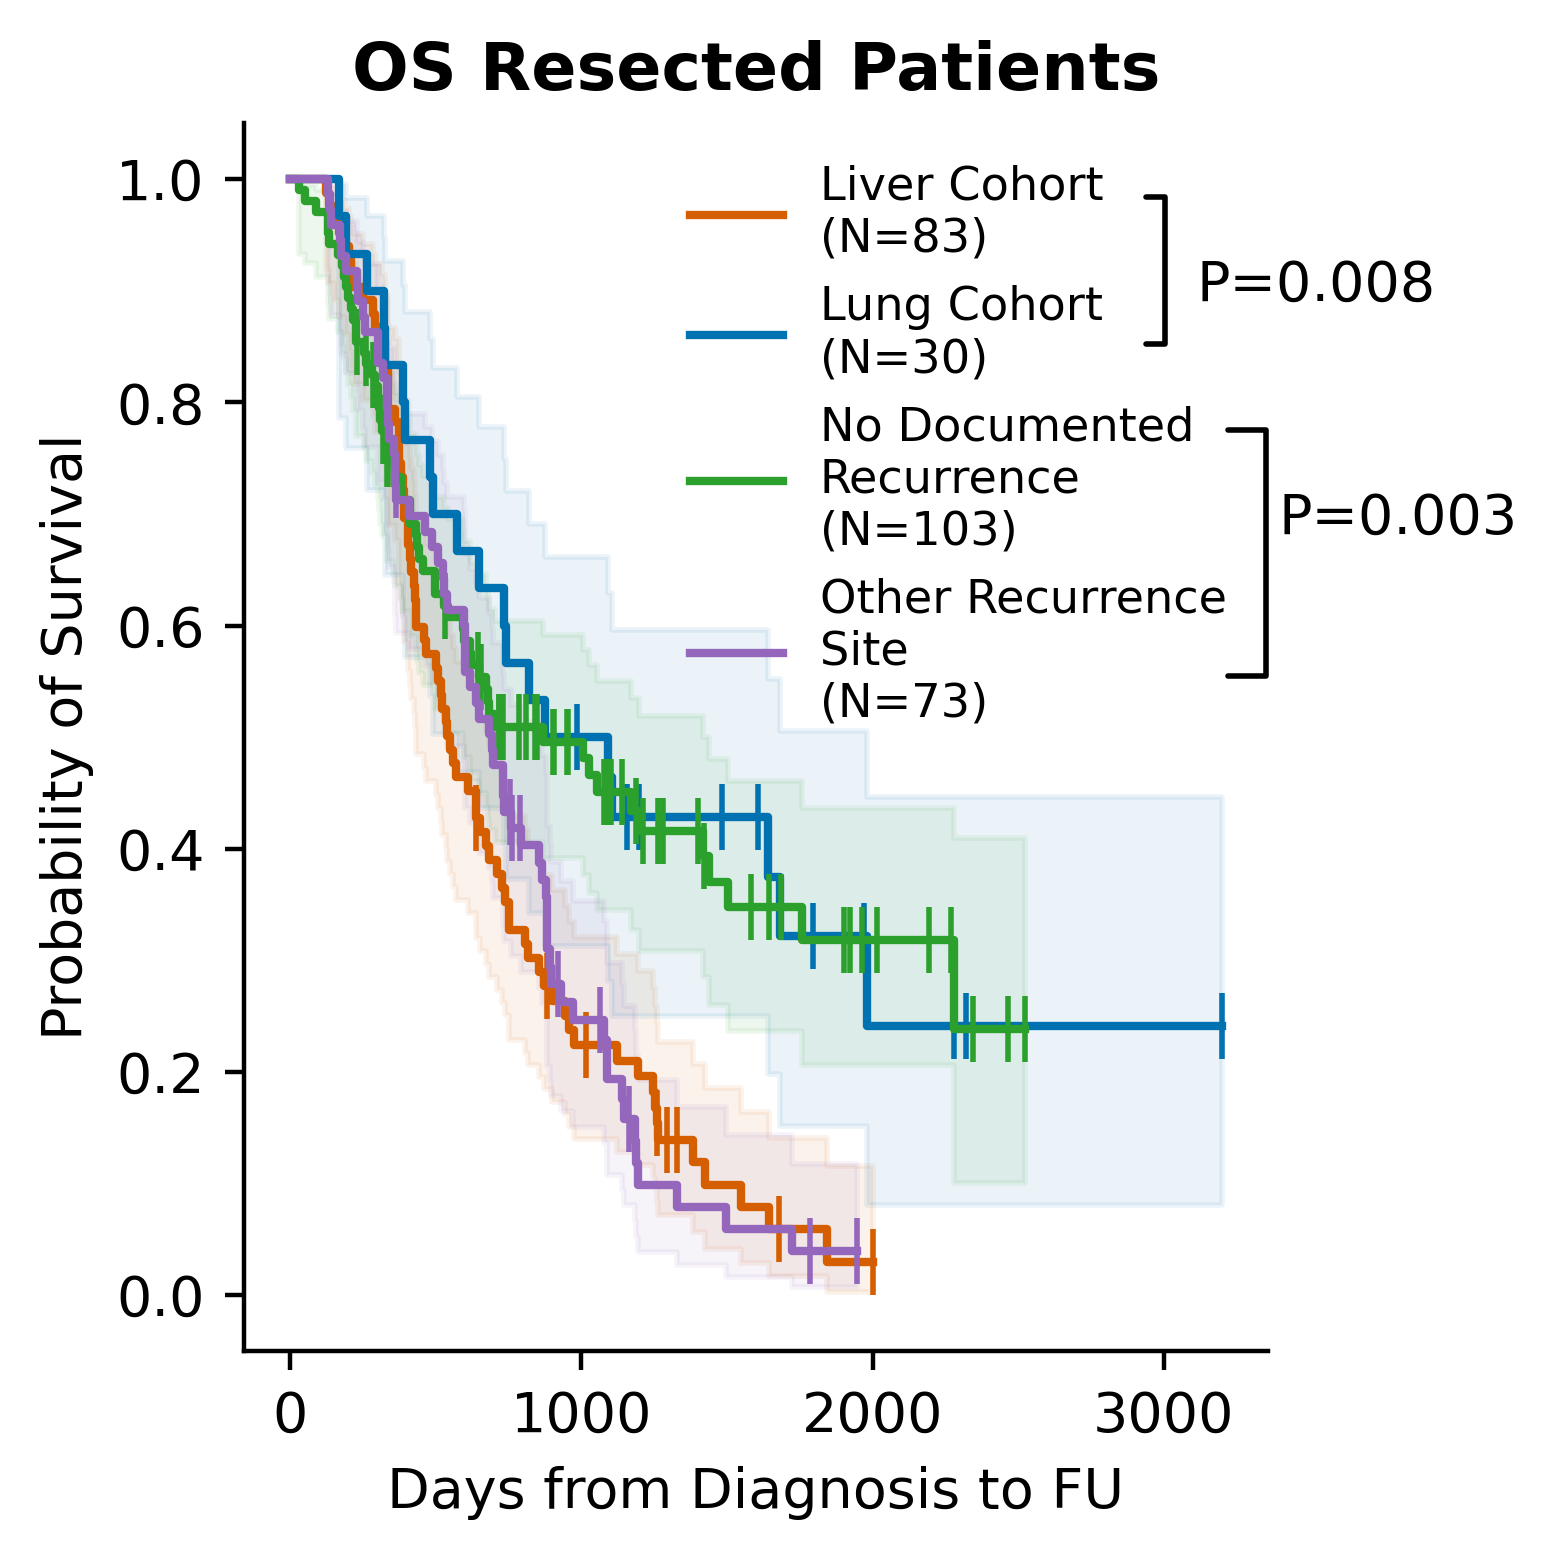

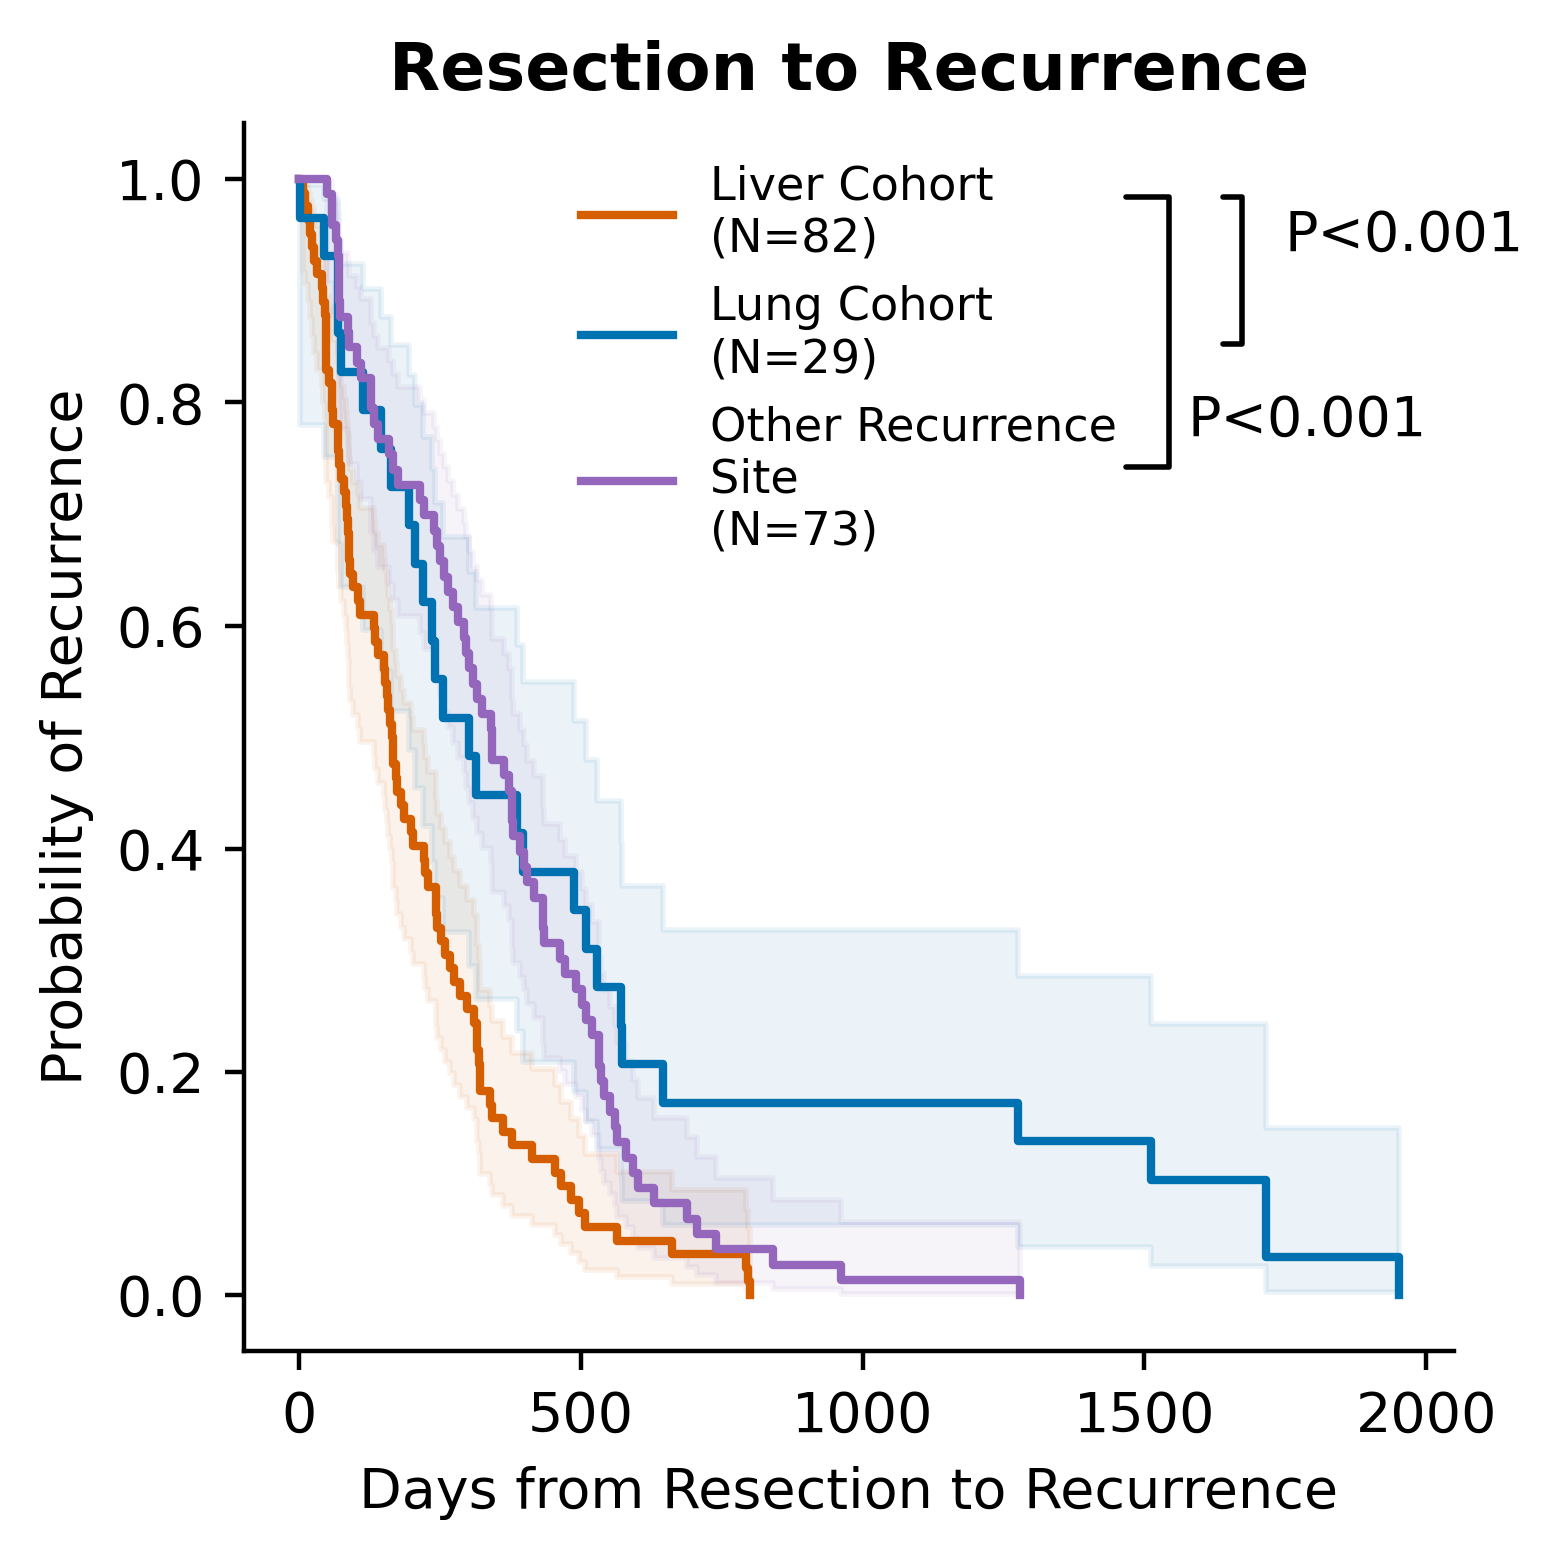

In [248]:
#KM
%matplotlib inline
importlib.reload(util)
df_patient.columns[df_patient.columns.str.contains('_Youden')]
ls_km = [#'Other_vs_Liver','Other_vs_Lung',#
    #'Other_vs_no_doc',#'Liver_Lung',
         #'Liver_Only','Liver_vs_Lung','Liver_and_Lung',#'Cohort_Met_Resection',
    'Recurrence_Sites',#'Cohort2',
       #   'Classical_Cohort',
       #   'PurIST_Subtype',#
       # 'Cohort',
       #         'Other_Recurrence', 'No_Doc_Recur',
       #      'Lung_Cohort','Liver_Cohort',
        ]
pal_liv = ('#D55E00','#0072B2')
pal_porg_r = ('#E69F00','#56B4E9')
pal_three = ('#d62728','#bcbd22',#'#D55E00',#(1.0, 0.4980392156862745, 0.054901960784313725),
             #'#d62728',#(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             '#0072B2'#(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
             )
pal_four = ('#D55E00','#0072B2','#2ca02c','#9467bd','#2ca02c',
             )
pal_four_r = ('#D55E00','#0072B2','#9467bd','#2ca02c','#2ca02c',
             )
tu_time_censor = (('Days from Diagnosis to FU','Survival'),
                  #('Days from Resection to FU','Survival'),
                  #('Days from Earliest Recur to FU','Survival'),
                  ('Days from Resection to Recurrence', 'Recurrence')
                 )
for (s_time, s_censor) in tu_time_censor:
    for s_km in ls_km:
        loc='upper center'
        if s_km == 'Liver_Lung':
            sns.set_palette(pal_three)
        elif s_km.find('Liver') > -1:
            sns.set_palette(pal_liv)
        elif s_km.find('Cohort') > -1:
            sns.set_palette(pal_liv)
        elif s_km == 'Recurrence_Sites':
            sns.set_palette(pal_four)
            if s_censor == 'Recurrence':
                sns.set_palette(pal_four_r)
            if s_censor == 'Survival':
                loc='upper right'
        else:
            sns.set_palette(pal_porg_r)
        df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,['Public_Patient_ID',s_km,s_time,s_censor]].dropna().copy()
        df_km[s_km] = df_km[s_km].astype('str')
        fig,ax,ls_order = util.km_plot(df_km,s_km,s_time,s_censor,fontsize='small',loc=loc)
        ax.set_ylabel(f'Probability of {s_censor}')
        ax.set_xlabel(f'{s_time}')
        if s_censor == 'Survival':
            if s_km == 'Liver_Lung':
                # ,x,top, bottom,ytext
                util.demo_con_style(ax,0.68,0.93,0.73,0.93, "P=0.005") # red vs blue
                util.demo_con_style(ax,0.74,0.84,0.73,0.81, "P=0.0007") # yellow vs blue
                ax.set_title('Overall Survival',fontweight='bold')
            if s_km == 'Recurrence_Sites':
                if s_time == 'Days from Diagnosis to FU':
                    util.demo_con_style(ax,0.87,0.94,0.82,0.89, "P=0.008") # liver vs lung
                    util.demo_con_style(ax,0.95,0.75,0.55,0.7, "P=0.003") # other vs no doc
                    ax.set_title('OS Resected Patients',fontweight='bold')
                elif s_time == 'Days from Resection to FU':
                    util.demo_con_style(ax,0.87,0.94,0.82,0.89, "P=0.003") # liver vs lung
                    util.demo_con_style(ax,0.95,0.75,0.55,0.7, "P=0.005") # other vs no doc
                    ax.set_title('')
        if s_censor == 'Recurrence':
            if s_km == 'Recurrence_Sites':
                util.demo_con_style(ax,0.8,0.94,0.82,0.93, "P<0.001") # liver vs lung
                util.demo_con_style(ax,0.72,0.94,0.72,0.78, "P<0.001") # liver vs other
                ax.set_title('Resection to Recurrence',fontweight='bold')
        plt.tight_layout()
        fig.savefig(f'figures/KM_{s_km}_{s_censor}.pdf')
    #     break
    #break  
    

PurIST_Subtype Basal-like Median = 394.0
PurIST_Subtype Classical Median = 600.0
Classical_Cohort Liver Classical Median = 520.0
Classical_Cohort Lung Classical Median = 1681.0
[63, 206, 61, 19]
['Basal-like', 'Classical', 'Liver Classical', 'Lung Classical']
PurIST_Subtype Basal-like Median = 153.0
PurIST_Subtype Classical Median = 244.0
Classical_Cohort Liver Classical Median = 162.0
Classical_Cohort Lung Classical Median = 303.0
[29, 100, 42, 15]
['Basal-like', 'Classical', 'Liver Classical', 'Lung Classical']


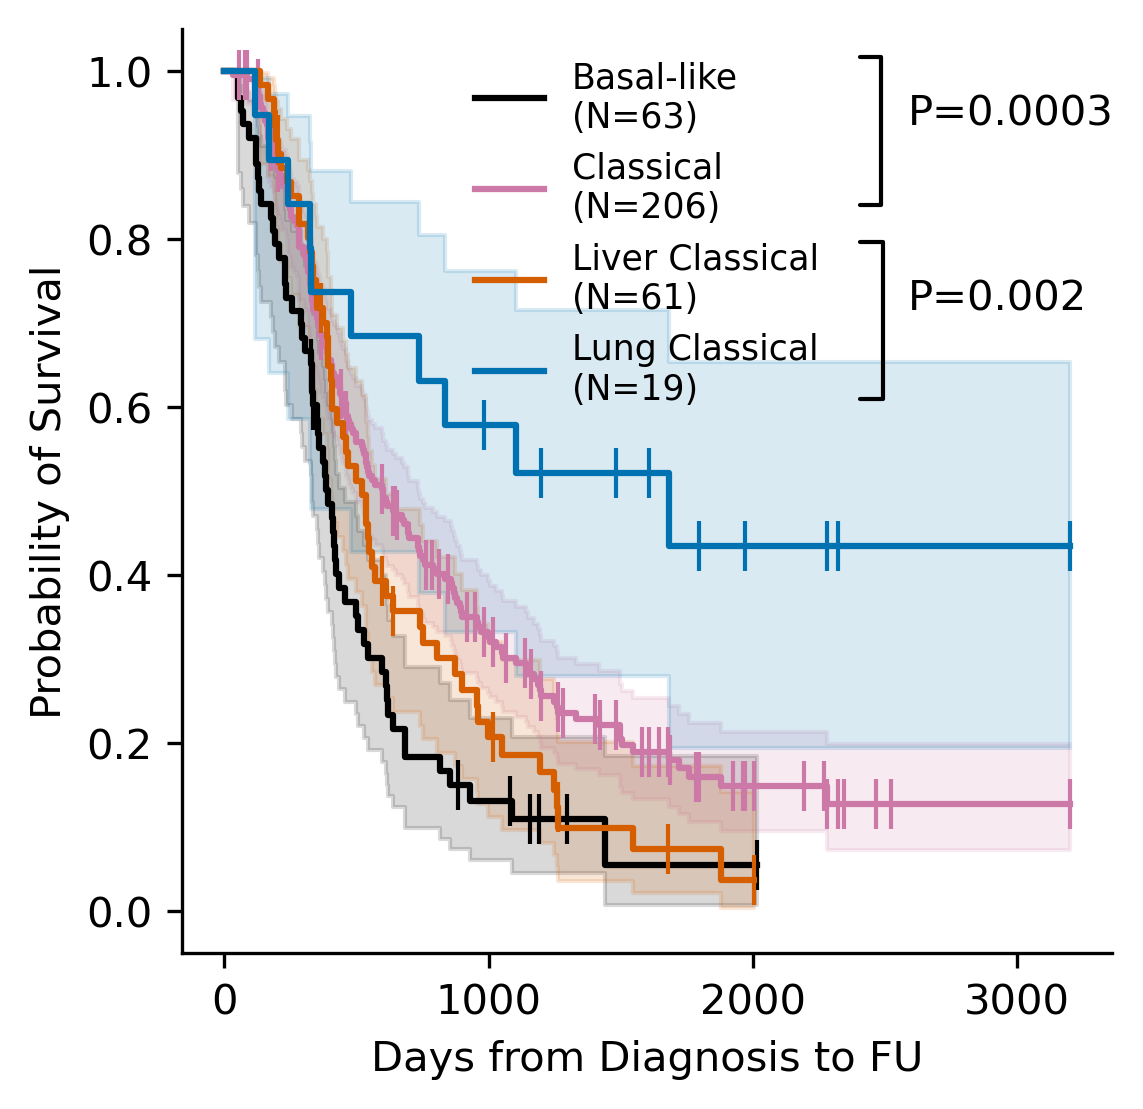

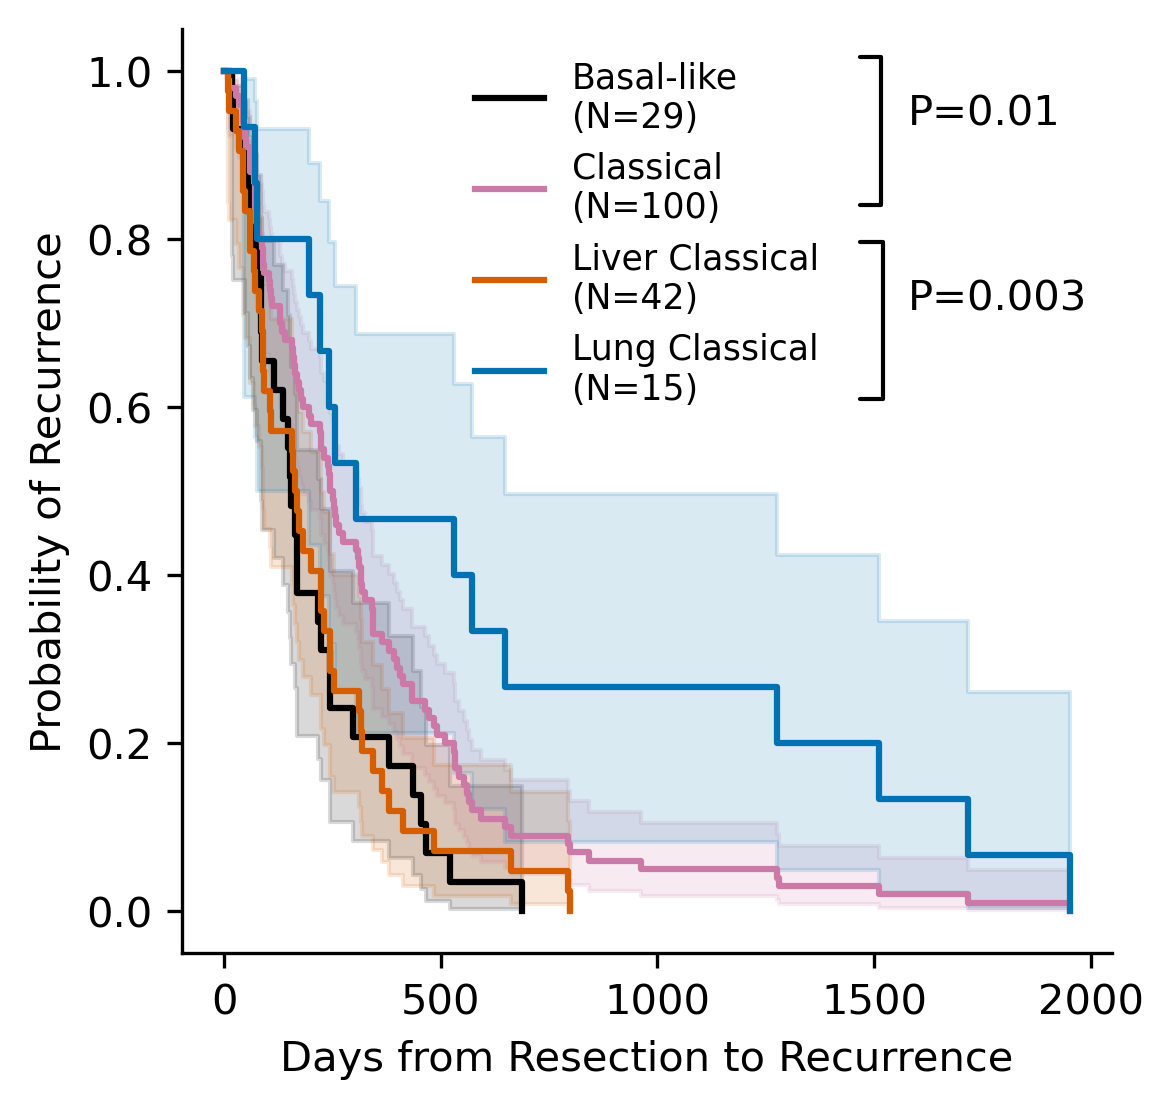

In [249]:
importlib.reload(util)
pal_4 = ('#000000','#cc79a7','#D55E00','#0072B2',)
sns.set_palette(pal_4)
df_patient['Classical_Cohort'] = df_patient['Classical_Cohort'].replace('Liver','Liver Classical').replace('Lung','Lung Classical')
df_patient['PurIST_Subtype'] = df_patient['PurIST_Subtype'].replace('basal-like','Basal-like').replace('classical','Classical')

df = df_patient.loc[df_patient.Alive_30_days_post_surgery]
for (s_time, s_censor) in tu_time_censor:
    ls_col = ['PurIST_Subtype', 'Classical_Cohort']
    fig,ax,ls_order = util.km_plot_overlay(df,ls_col,s_time,s_censor,fontsize='small',loc='upper center')
    ax.set_ylabel(f'Probability of {s_censor}')
    ax.set_xlabel(f'{s_time}')
    if s_censor == 'Survival':
        # ,x,top, bottom,ytext
        util.demo_con_style(ax,0.72,0.97,0.81,0.93, "P=0.0003") # purist
        util.demo_con_style(ax,0.72,0.77,0.6,0.73, "P=0.002") # ll classical
    if s_censor == 'Recurrence':
        util.demo_con_style(ax,0.72,0.97,0.81,0.93, "P=0.01") # purist
        util.demo_con_style(ax,0.72,0.77,0.6,0.73, "P=0.003") # ll classical
    fig.savefig(f'figures/KM_{".".join(ls_col)}_{s_censor}.pdf')

PurIST_Subtype Basal-like Basal-like_Neo_No Median = 424.0
PurIST_Subtype Basal-like Basal-like_Neo_Yes Median = 455.0
[39, 9]
['Basal-like_Neo_No', 'Basal-like_Neo_Yes']
PurIST_Subtype Classical Classical_Neo_No Median = 693.0
PurIST_Subtype Classical Classical_Neo_Yes Median = 734.0
[122, 36]
['Classical_Neo_No', 'Classical_Neo_Yes']
Cohort Liver Liver_Neo_No Median = 570.0
Cohort Liver Liver_Neo_Yes Median = 506.0
[66, 17]
['Liver_Neo_No', 'Liver_Neo_Yes']
Cohort Lung Lung_Neo_No Median = 819.0
Cohort Lung Lung_Neo_Yes Median = 1093.0
[20, 10]
['Lung_Neo_No', 'Lung_Neo_Yes']


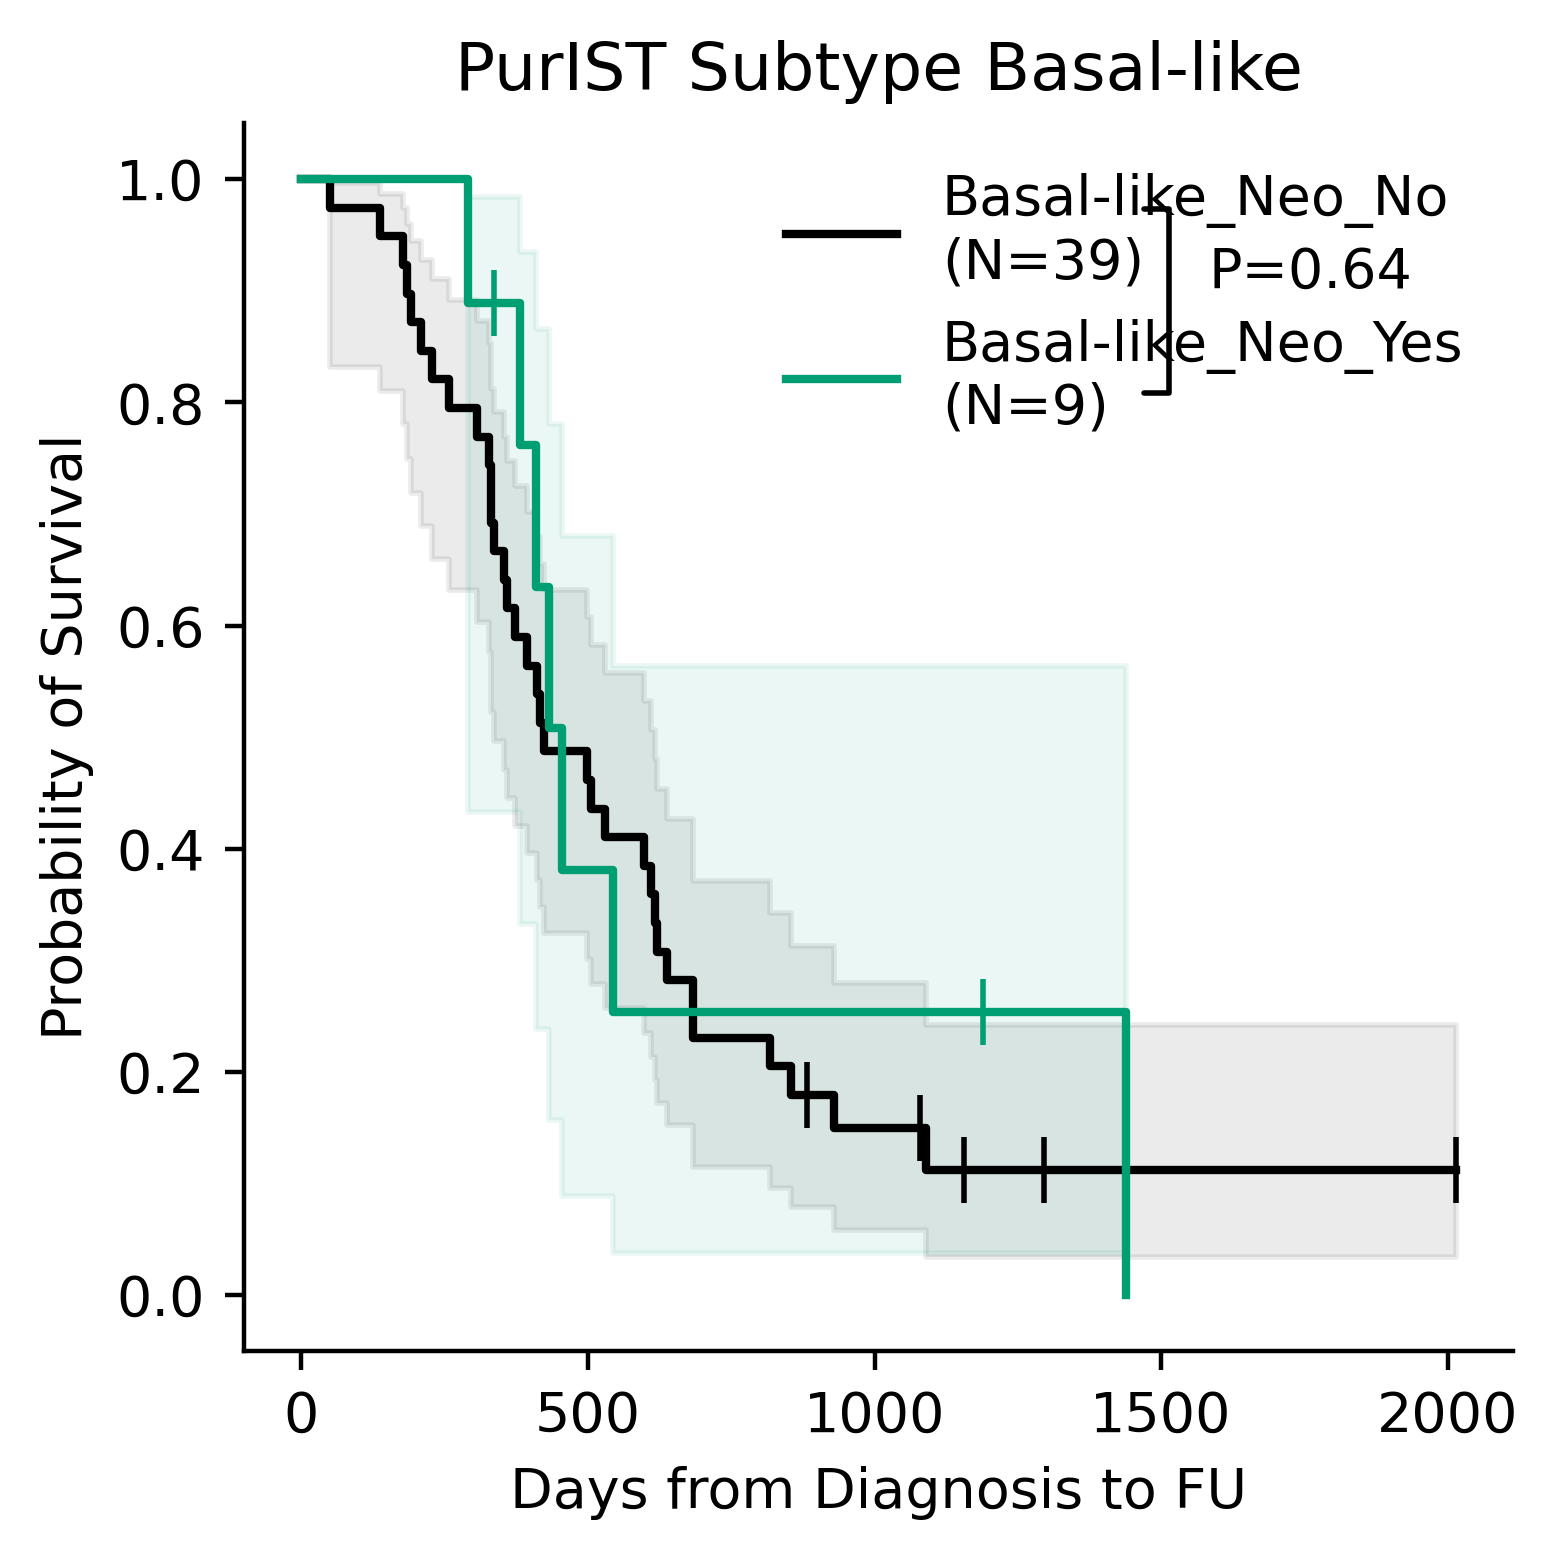

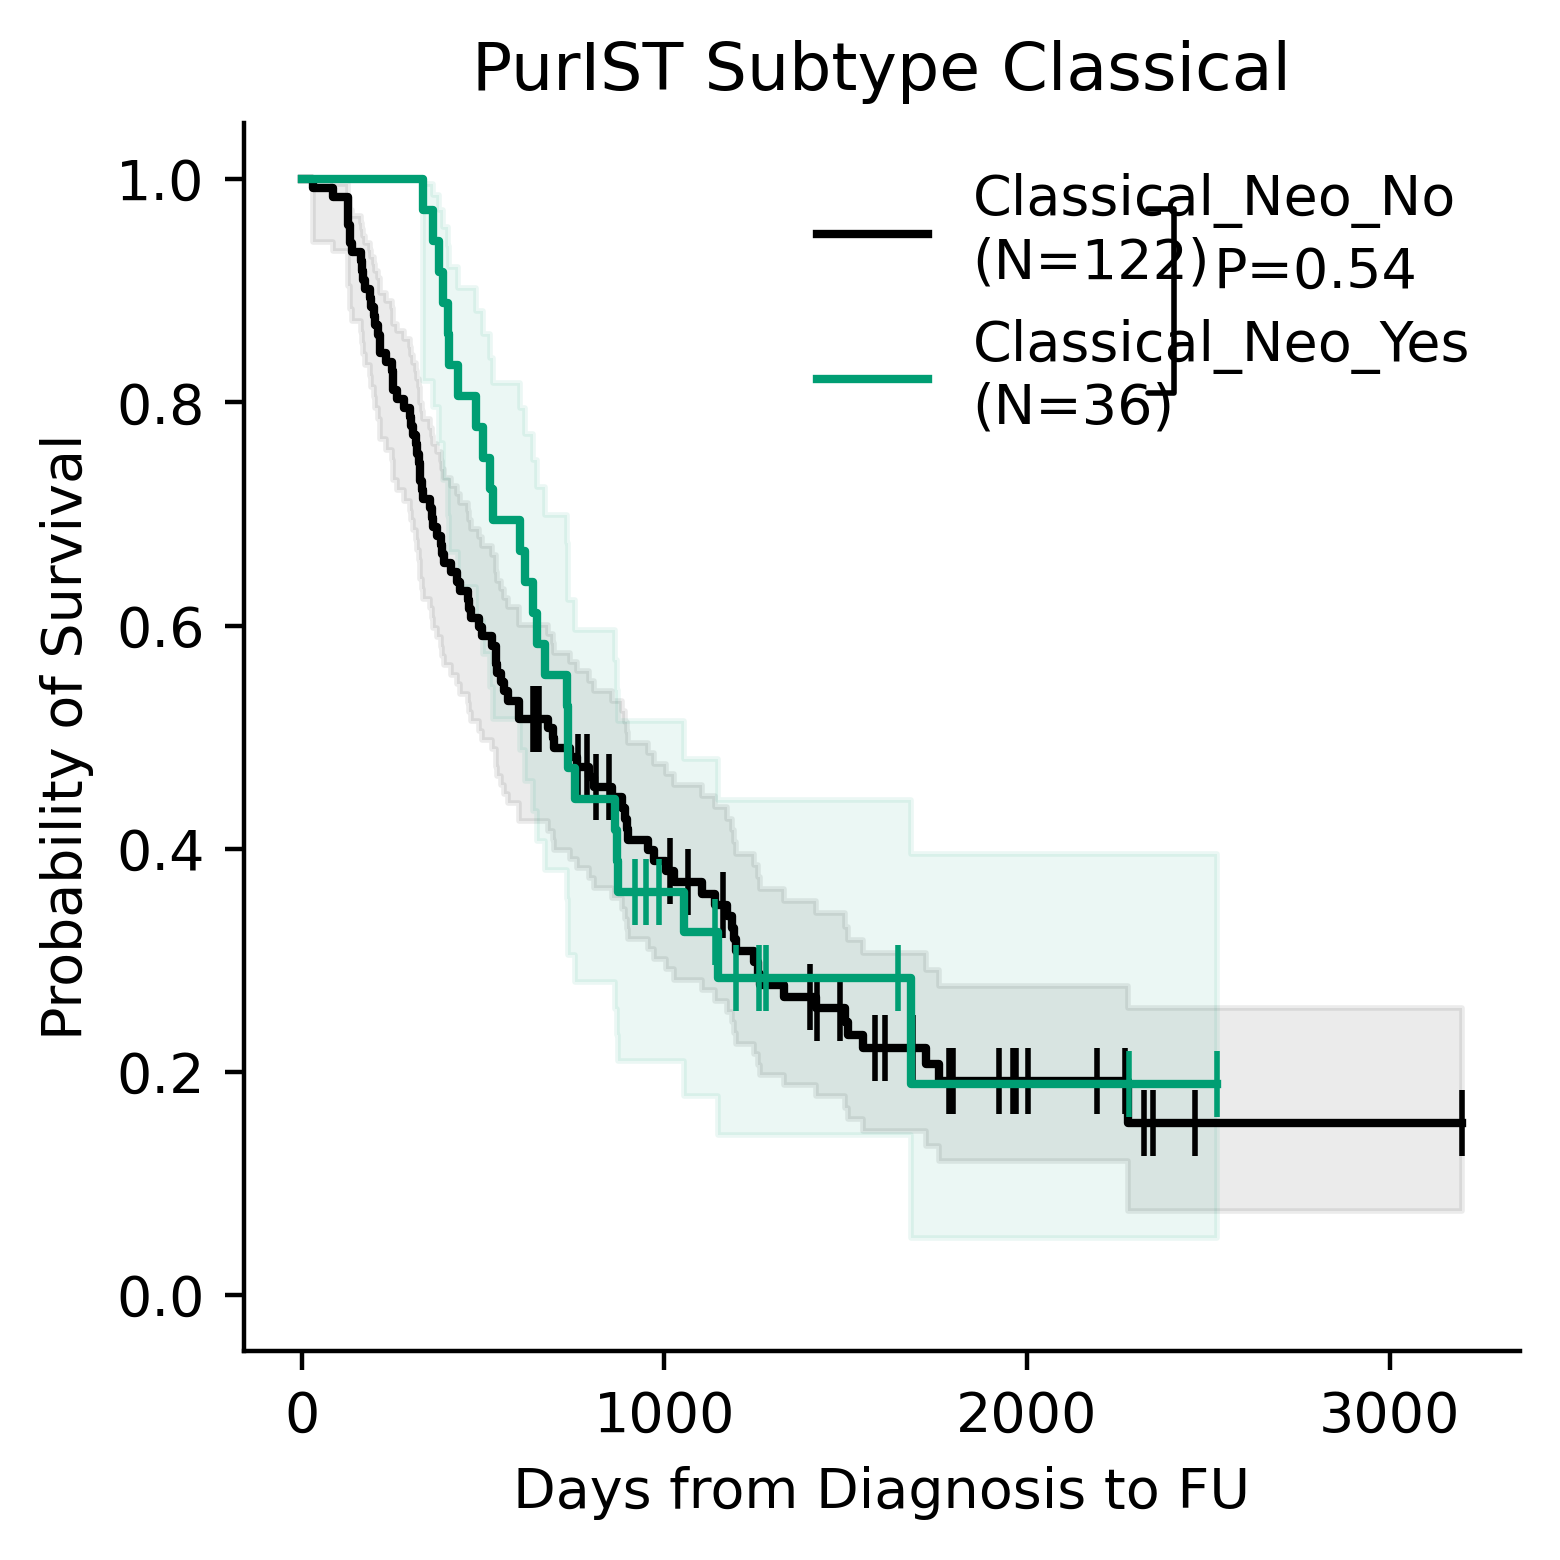

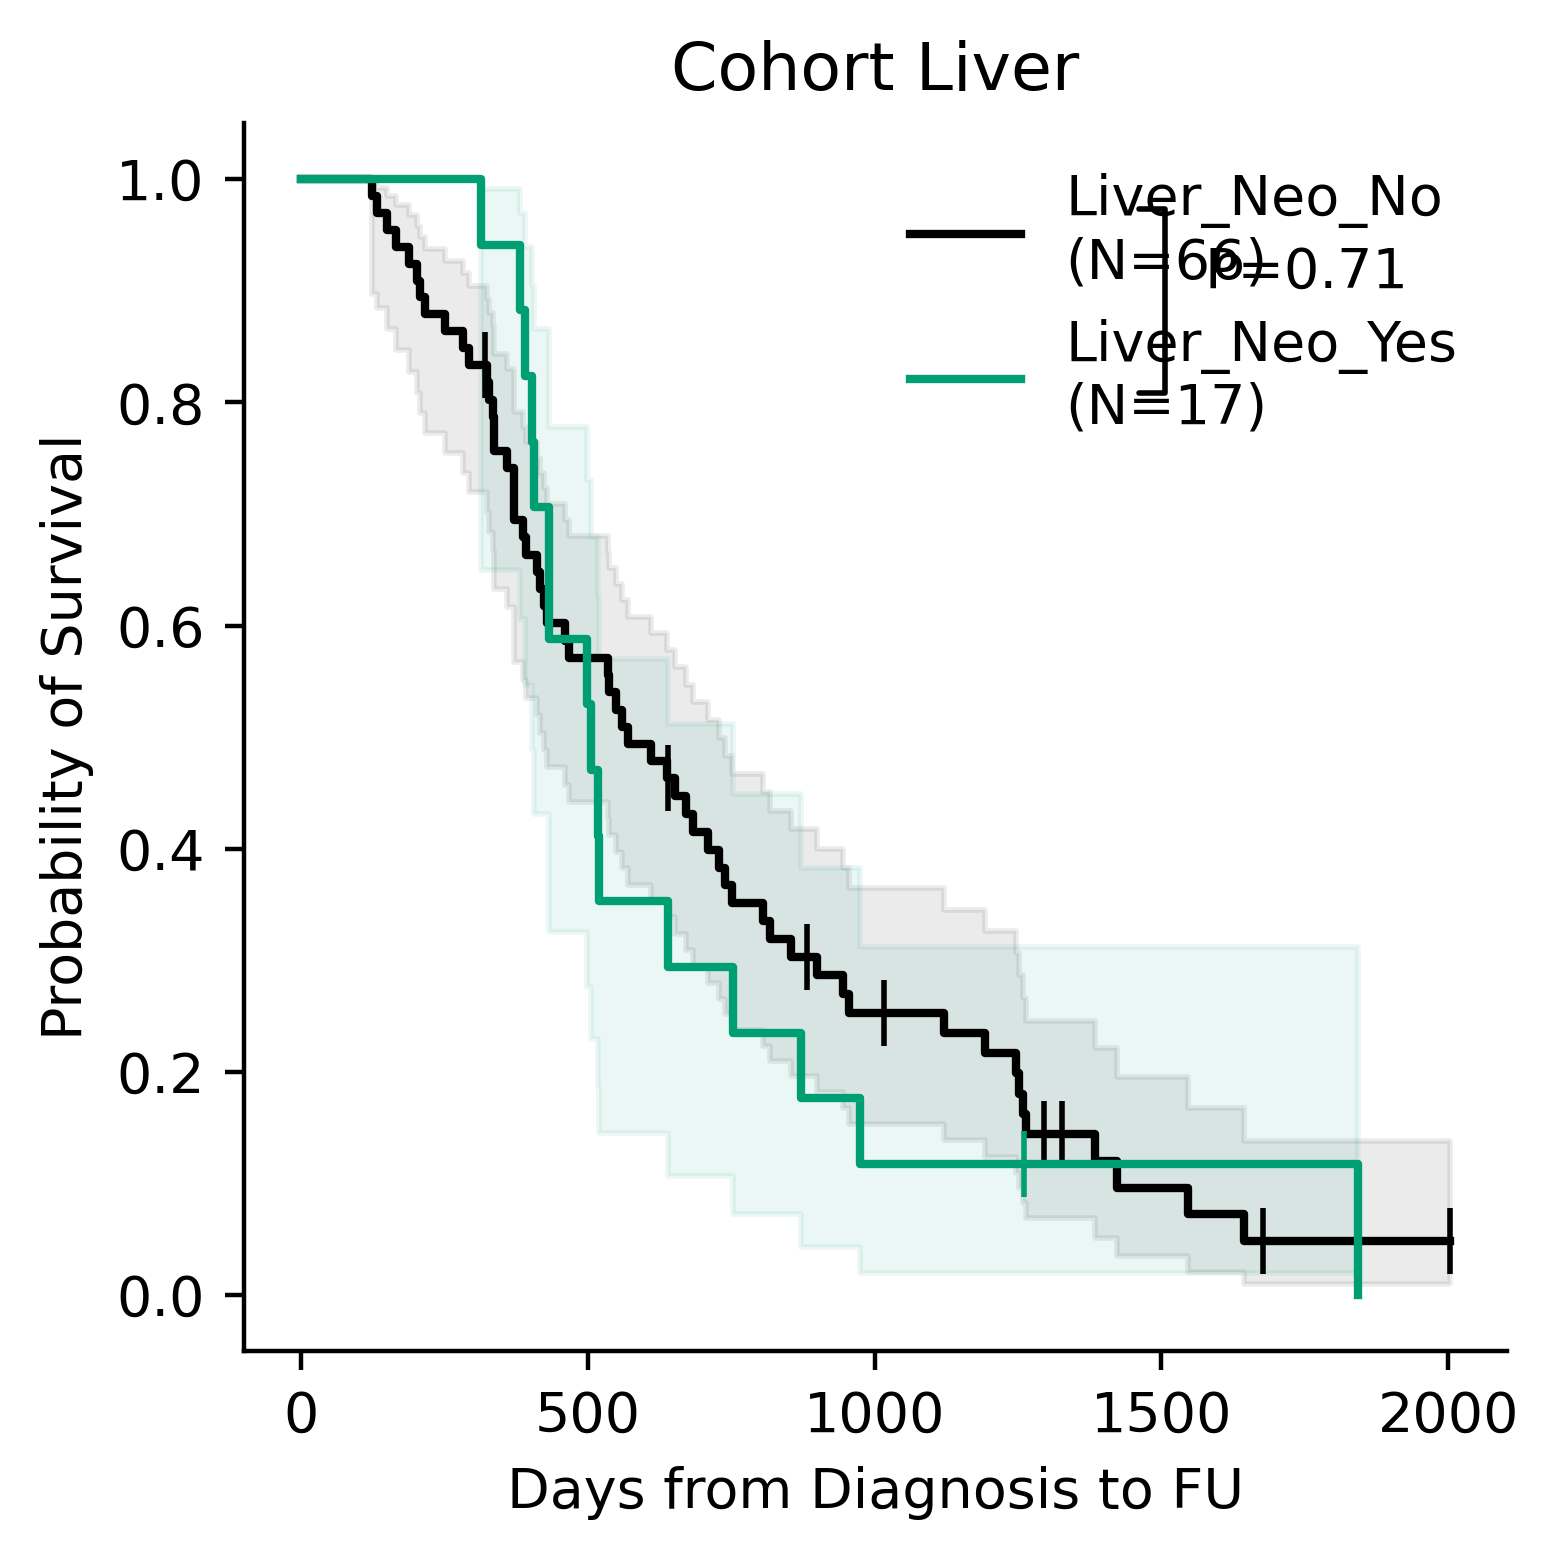

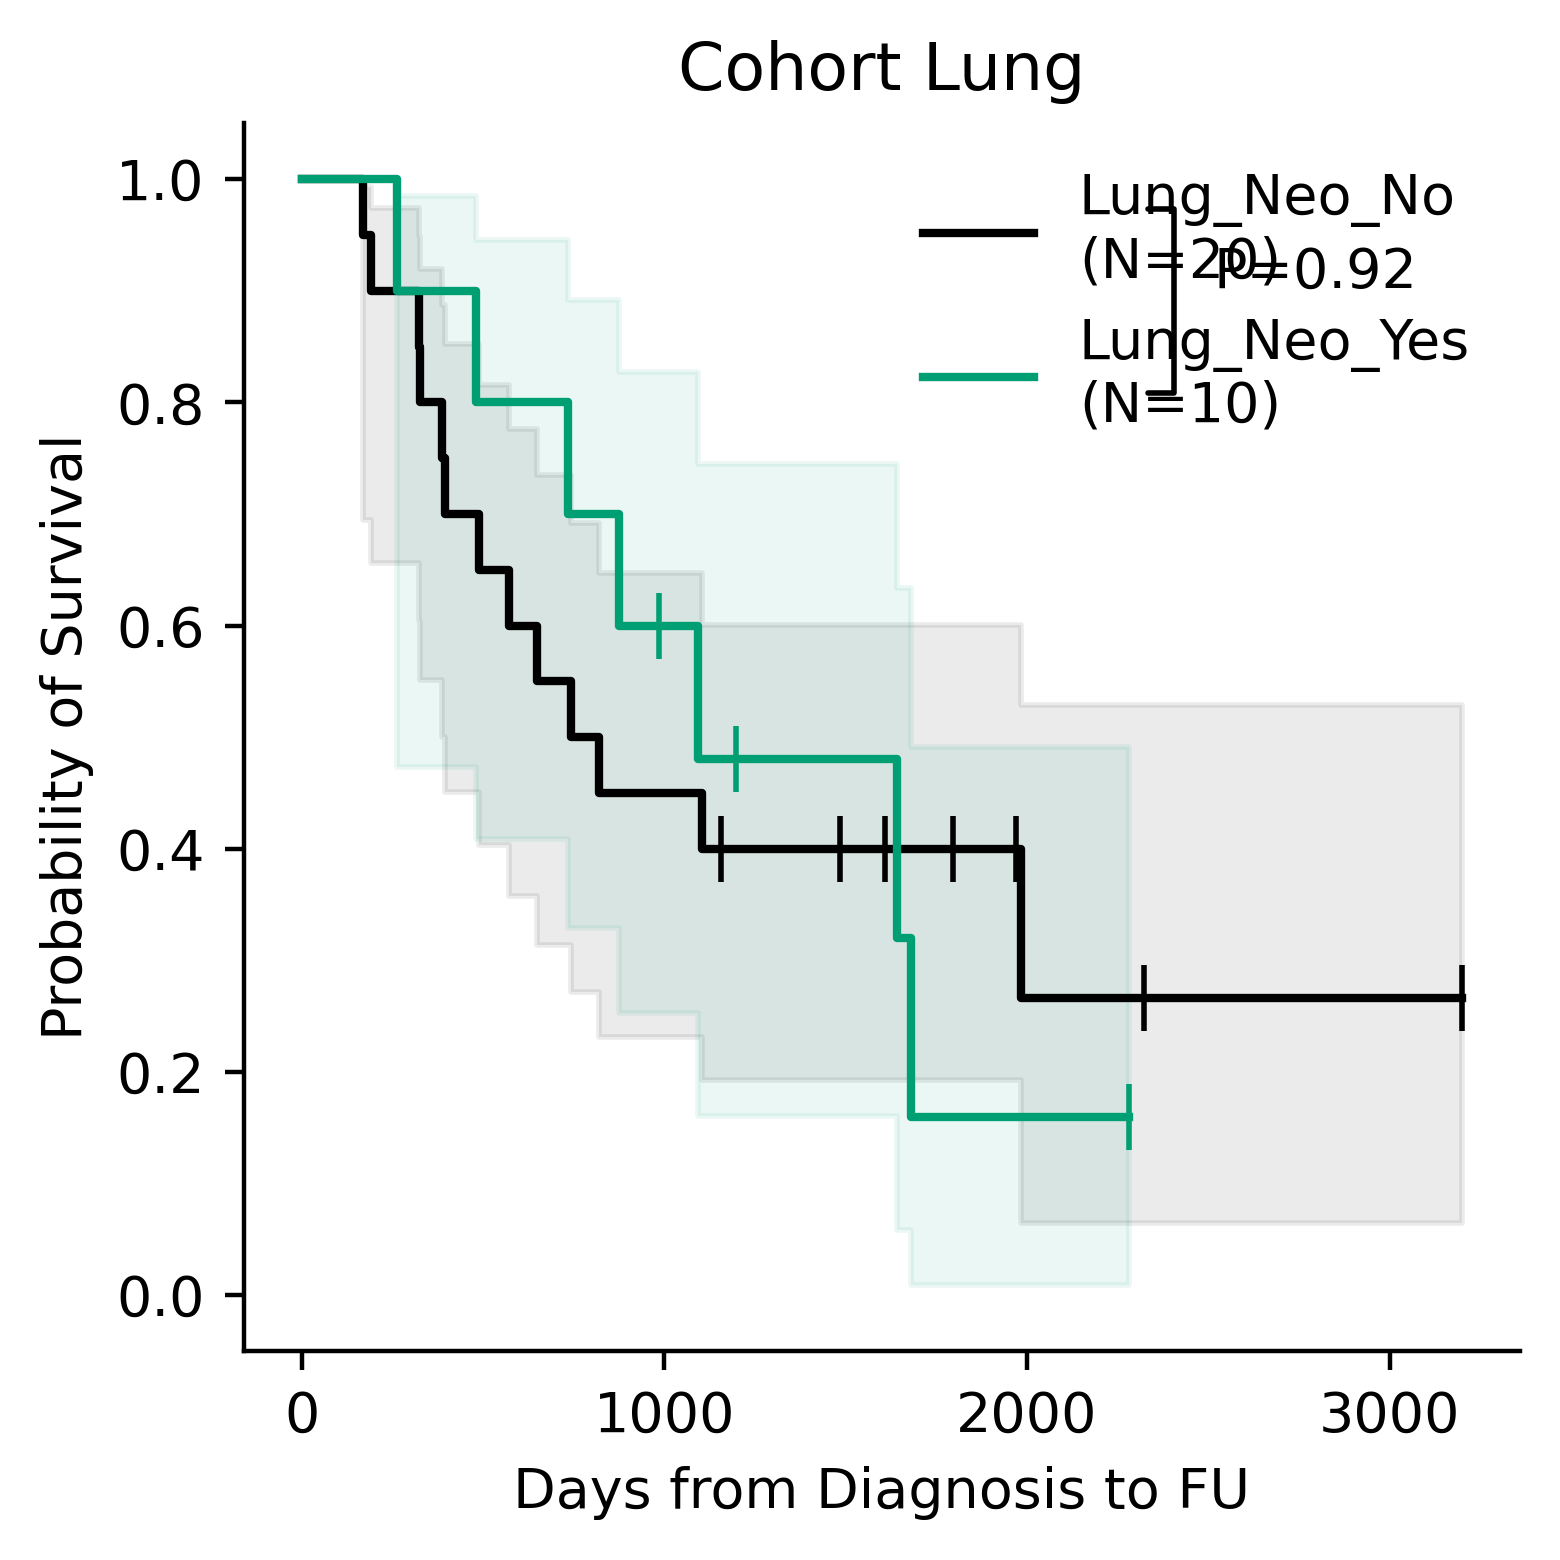

In [250]:
#supp fig 2
importlib.reload(util)
pal_gray = ('#000000','#009E73')#cc79a7','#D55E00','#0072B2',)
sns.set_palette(pal_gray)
df = df_patient[df_patient.Neoadjuvant.notna()]
for (s_time, s_censor) in tu_time_censor:
    for s_col in ['PurIST_Subtype', 'Cohort']:
        for s_group in df.loc[:,s_col].dropna().unique():
            df2 = df[df.loc[:,s_col]==s_group].copy()
            s_km = f'{s_col} {s_group}'
            df2[s_km] = df2.loc[:,s_col] + '_Neo_' + df2.Neoadjuvant
            df_km = df2.loc[df2.Alive_30_days_post_surgery,['Public_Patient_ID',s_km,s_time,s_censor]].dropna().copy()
            fig,ax,ls_order = util.km_plot(df_km,s_km,s_time,s_censor,fontsize='medium',loc='upper right')
            ax.set_ylabel(f'Probability of {s_censor}')
            ax.set_xlabel(f'{s_time}')
            plt.tight_layout()
            fig.savefig(f'figures/KM_neoadjuvant_{s_km}.pdf')
    break

In [286]:
#censors
#days survival after resection vs days survival after recurrence

df_patient.columns[df_patient.columns.str.contains('Days')]
df_patient['days survival after resection'] = df_patient.loc[:,'Days from Resection to Recurrence'] + df_patient.loc[:,'Days from Earliest Recur to FU']
df_patient['days survival after recurrence'] = df_patient.loc[:,'Days from Earliest Recur to FU']
#a
sx='days survival after resection'
sy= 'days survival after recurrence'
s_censors = 'Survival'
tau,p=patient_kendall(df_patient,sx,sy,s_censors)
r, pval = patient_pearson(df_patient,sx,sy)

censored Kendall tau: 0.085, p: 0.00934
pearson r: 0.803, p: 8.61e-43


In [287]:
# supp fig 2 censored correlation
#days survival after recurrence vs days from resection to recurrence\
sx = 'days survival after recurrence'
sy = 'Days from Resection to Recurrence'
s_censors = 'Survival'
tau,p=patient_kendall(df_patient,sx,sy,s_censors)
r, pval= patient_pearson(df_patient,sx,sy)

censored Kendall tau: 0.010, p: 0.757
pearson r: 0.094, p: 0.205


In [285]:

importlib.reload(util)
def patient_kendall(df_patient,sx,sy,s_censors):
    x = df_patient.loc[:,sx]
    y = df_patient.loc[:,sy]
    # gen random "upper limits"
    censors = np.ones((2,len(x)))
    uplims = df_patient.loc[:,s_censors]==0#np.unique(np.random.randint(0,high=len(x)-1,size=60))
    censors[1,uplims]=0
    #uncens = [i for i in range(len(x)) if i not in uplims]
    # faux uncertainties, accounting for upper limits
    x_err = 0.1*np.random.rand(len(x))*censors[0]
    y_err = 0.1*np.random.rand(len(y))*censors[1]
    # Kendall tau
    tau,p = util.kendall(x,y,censors=censors)
    #tau_lo,tau_up = util.tau_conf(x,y,censors,method='bootstrap')
    print(f'censored Kendall tau: {tau:.3f}, p: {p:.3}')#-{tau_lo:.3f}+{tau_up:.3f}
    return(tau,p)

def patient_pearson(df_patient,sx,sy):
    df = df_patient.loc[:,[sx,sy]].dropna()
    x = df.loc[:,sx]
    y = df.loc[:,sy]
    # gen random "upper limits"
    statistic,p=stats.pearsonr(x, y)
    print(f'pearson r: {statistic:.3f}, p: {p:.3}')#-{tau_lo:.3f}+{tau_up:.3f}
    return(statistic,p)

In [273]:
from kendall import *
# gen random data
np.random.seed(123)
x = np.random.rand(89)
y = x+0.1*np.random.randn(len(x))
# gen random "upper limits"
censors = np.ones((2,len(x)))
uplims = np.unique(np.random.randint(0,high=len(x)-1,size=60))
censors[1,uplims]=0
uncens = [i for i in range(len(x)) if i not in uplims]
# faux uncertainties, accounting for upper limits
x_err = 0.1*np.random.rand(len(x))*censors[0]
y_err = 0.1*np.random.rand(len(y))*censors[1]
# Kendall tau
tau,p = util.kendall(x,y,censors=censors)
tau_lo,tau_up = util.tau_conf(x,y,censors,method='bootstrap')
print(f'censored Kendall tau: {tau:.3f}-{tau_lo:.3f}+{tau_up:.3f}, p: {p:.3e}')

censored Kendall tau: 0.465-0.018+0.018, p: 1.094e-10


In [275]:
censors
uplims

array([ 0,  1,  2,  5,  6,  7, 12, 14, 16, 17, 19, 21, 22, 25, 29, 30, 35,
       37, 38, 39, 45, 47, 52, 53, 55, 58, 61, 62, 70, 71, 74, 77, 78, 80,
       81, 83, 87])

In [ ]:
#figure 2 The new Youden cutoffs are:
#pORG: 0.02491​ (same)
#pSUB: -0.31836​ (same)
#PuRIST: new: 0.01340
importlib.reload(util)
sns.set_palette(pal_porg_r)
d_cutoff = {'pORG Primary':0.02491, 'pSUB Primary':-0.31836, 'PurIST Primary':0.0134}
for s_col, cutoff in d_cutoff.items():
    df_patient[s_col] = pd.NA
    df_patient.loc[df_patient.loc[:,f'{s_col.replace(" ","_")}'] > cutoff,s_col] = f'High' #
    df_patient.loc[df_patient.loc[:,f'{s_col.replace(" ","_")}'] <= cutoff,s_col] = f'Low'
    df = df_patient[(df_patient.Alive_30_days_post_surgery) & (df_patient[s_col].notna())]
    for (s_time, s_censor) in tu_time_censor:
        fig,ax,ls_order = util.km_plot(df,s_col,s_time,s_censor,fontsize='medium',loc='upper center')
        ax.set_ylabel(f'Probability of {s_censor}')
        ax.set_xlabel(f'{s_time}')
        fig.suptitle(f'{s_col.replace("Primary","Score")}',fontweight='bold',fontsize='x-large',y=.94,x=.56)
        plt.tight_layout()
        fig.savefig(f'figures/km_{s_col}_{s_censor}.pdf')
        break
    #break

In [ ]:
# import pandas as pd
# import sys
# import os


# with pd.ExcelWriter('Supplemental_Table_2.xlsx') as writer:
#     for csvfilename in sorted(os.listdir('results/CPH')):
#         df = pd.read_csv(f'results/CPH/{csvfilename}',index_col=0)
#         sheet_name = csvfilename.split("results_")[1][:31]
#         df.to_excel(writer, sheet_name=sheet_name)

In [ ]:
#clinical covariates

#Lung Cohort TCR versus overall vs. Clinical Variables (chi squared)
ls_clin = ['Desmoplasia (Y/N)','Desmoplasia (Y/N)_Met','ALI (Y/N)',#'ALI (Y/N)_Met','PNI','PNI_Met',
    'Resected','Grade',
           'Age','Sex',
           'Neoadjuvant',#
           'Stage','LV_Invasion','LN_Pos',
          'TLS', 'Inflammation', #'Acute Inflammation', 'Chronic Inflammation','Plasmacytoid Inflammation',
     'TLS_Met', 'Inflammation_Met', #'Acute Inflammation_Met', 'Chronic Inflammation_Met','Plasmacytoid Inflammation_Met',
       
          ]
ls_cohort = ['Cohort',
             #'Lung_Cohort',#'No_Recurrence',
             #'Liver_Cohort',#'Other_Recurrence',
             ]
d_result = {}
for s_clin in ls_clin:
    for s_cohort in ls_cohort:
        crosstab = pd.crosstab(df_patient.loc[:,s_clin],df_patient.loc[:,s_cohort])
        df = crosstab.T.unstack().reset_index().rename({0:'Total Pts'},axis=1)
        sheet_name = f'{s_clin.replace("/","")}_vs_{s_cohort}'
        df.index.name = sheet_name
        statistic,pvalue, dof, expected_freq = stats.chi2_contingency(crosstab)
        d_result.update({sheet_name:df})
        if pvalue < 0.05:
            fig, ax = plt.subplots(figsize=(2,2),dpi=300)
            #sns.heatmap(crosstab - expected_freq,ax=ax,annot=True,cbar_kws={'label':'Obs - Exp'})
            sns.heatmap(crosstab/crosstab.sum(),ax=ax,annot=True,cbar_kws={'label':'Percent Pts.'})
            ax.set_title(f'{s_clin}\nvs. {s_cohort} p={pvalue:.3}')
            #break
        #break
    #break
with pd.ExcelWriter('Supplemental_Table_10.xlsx') as writer:
    for sheet_name, df in d_result.items():
        df.to_excel(writer, sheet_name=sheet_name)

In [ ]:
#effect of tumor cellularity
d_group = {#'PurIST_Subtype':['classical','basal-like',],
           'Cohort':['Lung','Liver',],
            #'pORG_Primary_quartiles':['low','high',], #'pORG_Met_quartiles', 'pORG_allMet_quartiles' #'pORG_allPrimary_quartiles',
            #'pSUB_Primary_quartiles':['low','high',],
          # 'pSUB_Met_quartiles':['low','high',],
          # 'pORG_Met_quartiles':['low','high',]
 }
ls_col = ['Tumor_Cellularity_by_DNA_Met','Tumor_Cellularity_by_DNA_Primary',]
sns.set_palette('tab10')
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for s_col in ls_col:
        for s_group, order  in d_group.items():
            df = df_patient.loc[:,[s_col,s_group]].dropna()
            #order = d_group[]#df.loc[:,s_group].unique()
            fig,ax = plt.subplots(figsize=(3,2),dpi=300)
            sns.stripplot(data=df,x=s_group,y=s_col,ax=ax,s=3,alpha=0.8,order=order)
            sns.boxplot(data=df,x=s_group,y=s_col,ax=ax,showmeans=True,medianprops={'visible': False},
                           whiskerprops={'visible': False},meanline=True,showcaps=False,order=order,
                           meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
            a = df.loc[df.loc[:,s_group]==order[0],s_col].values
            b = df.loc[df.loc[:,s_group]==order[1],s_col].values
            stat, pvalue = stats.ttest_ind(a, b)
            ax.set_title(f'{s_col.replace("_"," ")}\nvs {s_group.replace("_"," ")}\np={pvalue:.3}')

In [ ]:
# # matches kevin, 58 liver metastasis 18 lung metastasis 83 no documented recurrence 
# #53 other recurrence site 6 no resection
# print(df_patient[~df_patient.PurIST_Primary.isna()].Recurrence_Sites_4.value_counts())
# print(df_patient[~df_patient.PurIST_Primary_T2.isna()].Recurrence_Sites_4.value_counts())
# 58 + 18 + 83 + 53 + 6
# print(df_patient[~df_patient.loc[:,'pORG_0.2_Met'].isna()].Recurrence_Sites_4.value_counts().sum())

In [ ]:
#CPH single variable

tu_time_censor = (('Days from Diagnosis to FU','Survival'),
                  ('Days from Resection to Recurrence', 'Recurrence'))
for (s_time, s_censor) in tu_time_censor:
    print(s_censor)
    df_result=pd.DataFrame()
    se_recur = {'Other_Recurrence', 'No_Doc_Recur','Lung_Cohort','Liver_Cohort'} #don't compare to the 74 with no resection
    ls_vital = ['Cohort','pORG_Primary','pORG_Met','Neoadjuvant','Age','Sex','Stage', 'Grade','LV_Invasion','LN_Pos', #'Age at Diagnosis',
          'Other_Recurrence', 'No_Doc_Recur',
                'PurIST_Subtype',
                'Classical_Cohort',
                'Lung_Cohort','Liver_Cohort',
               'pSUB_Primary', 'pSUB_Met','Classical_Cohort',
           'PurIST_Primary', 'PurIST_Met']
    for s_vital in ls_vital:
        print(s_vital)
        if s_vital == 'Neoadjuvant':
            df = df_patient.loc[(df_patient.Alive_30_days_post_surgery) &(df_patient.Resected),[s_vital,s_time,s_censor]].copy()
        else:
            df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_vital,s_time,s_censor]].copy()#.dropna(how='any')
        if len(se_recur.intersection(set([s_vital]))):
            df.loc[df_patient.Recurrence_Sites_4=='No_Resection',s_vital] = np.nan
        df = df.dropna()    
        print(len(df))
        if df.columns.isin(['Stage']).any():
            df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4}).astype('int')
        if df.columns.isin(['Grade']).any():
            df.Grade = df.Grade.astype('int')
        if df.loc[:,s_vital].dtype=='O':
            df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
            if df_dummy.shape[1]>0:
                print(s_vital)
                df.drop(s_vital,axis=1,inplace=True)
                df[s_vital] = df_dummy
            else:
                continue
        try: 
            fig, cph = util.cph_plot(df,s_vital,s_time,s_censor,figsize=(3.8,1.5))
            pvalue = cph.summary.p[s_vital]
            plt.tight_layout()
            fig.savefig(f'figures/CPH_single_{s_vital}_{pvalue:.2}_{s_censor}.png')
            #if pvalue > 0.09:
            plt.close(fig)
            df_cph = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
            df_cph['n'] = len(df)
            df_result=pd.concat([df_result,df_cph])
        except:
            print('')
    #'''
    #all the recurrence combos
    s_vital = 'Recurrence_Sites_4'
    for tu_combo in combinations(["Lung","Liver",'Other_site','No_Doc_Recur','No_Resection'],r=2):#combinations(df_patient.Recurrence_Sites_4.unique(),r=2):
        print(tu_combo)
        df = df_patient.loc[(df_patient.Alive_30_days_post_surgery) &(df_patient.Resected),[s_vital,s_time,s_censor]]#.dropna(how='any')
        # df['Recurrence_Sites_4'] = df['Recurrence_Sites_4'].replace({'Liver':'liver'})
        print(len(df))
        df = df[df.loc[:,s_vital].isin(tu_combo)].dropna()
        #order them
        df.Recurrence_Sites_4 = df.Recurrence_Sites_4.astype('category')
        df.Recurrence_Sites_4 = df.Recurrence_Sites_4.cat.set_categories(list(tu_combo))
        #break
        df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=False)
        df.drop(s_vital,axis=1,inplace=True)
        s_compare = " to ".join((tu_combo))
        df[s_compare] = df_dummy.iloc[:,0]
        print(len(df))
        try:
            fig, cph = util.cph_plot(df,s_compare,s_time,s_censor,figsize=(4,1.5))
            plt.tight_layout()
            fig.savefig(f'figures/CPH_single_{s_vital}_{s_compare}_{s_censor}.png')
            plt.close(fig)
            df_cph = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
            df_cph['n'] = len(df)
            df_result=pd.concat([df_result,df_cph])
        except:
            print('cph error')
        #break
        #save results
    df_result.to_csv(f'results/results_single_CPH_{s_censor}.csv')
    df = df_patient.loc[(df_patient.Alive_30_days_post_surgery) &(df_patient.Resected),[s_vital,s_time,s_censor]]
    for s_recur in df.Recurrence_Sites_4.unique():
        print(f'{s_recur}: Median {s_censor} = {df.loc[df.Recurrence_Sites_4==s_recur,s_time].median()}')
    #'''


In [ ]:
#GENES
ls_vital = ls_genes

#CPH single variable

tu_time_censor = (('Days from Diagnosis to FU','Survival'),
                  ('Days from Resection to Recurrence', 'Recurrence'))
for (s_time, s_censor) in tu_time_censor:
    print(s_censor)
    df_result=pd.DataFrame()
    se_recur = {'Other_Recurrence', 'No_Recurrence','Lung_Cohort','Liver_Cohort','PurIST_All','pORG_All','pSUB_All',}
    for s_vital in ls_vital:
        print(s_vital)
        df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_vital,s_time,s_censor]].copy()#.dropna(how='any')
        df = df.dropna()    
        print(len(df))
        if df.loc[:,s_vital].dtype=='O':
            df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
            if df_dummy.shape[1]>0:
                df.drop(s_vital,axis=1,inplace=True)
                df[s_vital] = df_dummy
            else:
                continue
        try: 
            fig, cph = util.cph_plot(df,s_vital,s_time,s_censor,figsize=(3.8,1.5))
            pvalue = cph.summary.p[s_vital]
            plt.tight_layout()
            fig.savefig(f'figures/CPH_single_{s_vital}_{pvalue:.2}_{s_censor}.png')
            #if pvalue > 0.09:
            plt.close(fig)
            df_cph = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
            df_cph['n'] = len(df)
            df_result=pd.concat([df_result,df_cph])
        except:
            print('')
        #save results
    df_result.to_csv(f'results/results_single_CPH_{s_censor}_gene_alterations.csv')
    #'''
    #break

## multivariable

In [ ]:
#CPH multivariable
for s_porg in ['pORG','pSUB','PurIST']:
    if s_porg == 'PurIST':
        df_patient[f'{s_porg}_All'] = df_patient.loc[:,f'{s_porg}_Primary'].fillna(df_patient.loc[:,f'{s_porg}_Met'])
    else:
        df_patient[f'{s_porg}_All'] = df_patient.loc[:,f'{s_porg}_allPrimary'].fillna(df_patient.loc[:,f'{s_porg}_allMet'])
    #break
# CDKN2A_Altered# ARID1B_Altered # KMT2D_Altered# MTAP_Altered TP53_Altered
# CDKN2A_Altered_Primary  MTAP_Altered_Primary # ARID1B_Altered_Primary # KMT2D_Altered_Primary
# KDM6A_Altered_Met # CDKN2A_Altered_Met
b_primary = False
for (s_time, s_censor) in tu_time_censor:
    print(s_censor)
    for b_genes in [True,False,]:
        if b_genes:
            s_covar = 'gene_alterations'
            figsize = (5,3)
        else:
            s_covar = 'clinical_covariates'
            figsize = (4,3)
        df_result_multi = pd.DataFrame()
        ls_multi = ['PurIST_Primary','pORG_Primary','pSUB_Primary', #'pORG_0.2_Met', 'pORG_0.2_All',,'PurIST_Met',
                'PurIST_All','pORG_All','pSUB_All',
                    'Liver_Cohort','Lung_Cohort',#'pSUB1e-04_Met',#'pSUB1e-04_All'
            'Other_Recurrence', 'No_Doc_Recur',
                     'Classical_Cohort',
               ]
        ls_cats = ['LV_Invasion','LN_Pos'] #categorical,'Neoadjuvant'
        if b_genes:
            ls_cats =['ARID1B_Altered_Primary','KMT2D_Altered_Primary','MTAP_Altered_Primary','CDKN2A_Altered_Primary']# ['CDKN2A_Altered_Primary','ARID1B_Altered_Primary','KMT2D_Altered_Primary','MTAP_Altered_Primary','TP53_Altered_Primary']#
        for s_multi in ls_multi:
            if not b_primary:
                if len(se_recur.intersection(set([s_multi]))) and b_genes:
                    ls_cats = ['CDKN2A_Altered','ARID1B_Altered','KMT2D_Altered','MTAP_Altered','TP53_Altered']
            print(s_multi)
            df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_multi,s_time,s_censor,'Grade','Stage','Public_Patient_ID']].copy()#.dropna() #
            if ls_cats[0].find('Altered') > -1:
                df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_multi,s_time,s_censor,'Public_Patient_ID']].copy()#.dropna()
            #if len(se_recur.intersection(set([s_multi]))):
            #    df.loc[df_patient.Recurrence_Sites_4=='No_Resection',s_multi] = np.nan
            df = df.dropna()    
            if df.loc[:,s_multi].dtype=='O':
                df_dummy = pd.get_dummies(df.loc[df_patient.Alive_30_days_post_surgery,[s_multi]],drop_first=True)
                if df_dummy.shape[1]>0:
                    df.drop(s_multi,axis=1,inplace=True)
                    s_multi = df_dummy.columns[0]
                    df[s_multi] = df_dummy
                else:
                    continue
            df_dummy = pd.get_dummies(df_patient.loc[df_patient.Alive_30_days_post_surgery,ls_cats+['Public_Patient_ID']].dropna().set_index('Public_Patient_ID'),drop_first=True) #
            df = df.merge(df_dummy.reset_index(),on='Public_Patient_ID',how='left').set_index('Public_Patient_ID')
            df = df.dropna()
            print(len(df))
            try:
                fig, cph = util.cph_plot(df,s_multi,s_time,s_censor,figsize=figsize)
                fig.savefig(f'figures/CPH_multi_{s_multi}_{s_covar}_{s_censor}.png')
                #plt.close(fig)
                df_result_model = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']].reset_index()
                df_result_model['model'] = s_multi
                df_result_model['n'] = len(df)
                df_result_multi=pd.concat([df_result_multi,df_result_model])
            except:
                print('cph error')
        #     break
    #     break
    # break
    #all the recurrence combos - multi
    #'''
        s_vital = 'Recurrence_Sites_4'
        figsize=(5,3)
        for tu_combo in combinations(df_patient.Recurrence_Sites_4.unique(),r=2):
            print(tu_combo)
            if b_genes:
                df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_vital,s_time,s_censor]]
            else:
                df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_vital,s_time,s_censor,'Stage','Grade']]#.dropna(how='any')
            df = df[df.loc[:,s_vital].isin(tu_combo)].dropna()
            #order them
            df.Recurrence_Sites_4 = df.Recurrence_Sites_4.astype('category')
            df.Recurrence_Sites_4 = df.Recurrence_Sites_4.cat.set_categories((tu_combo))
            df_dummy = pd.get_dummies(df.loc[df_patient.Alive_30_days_post_surgery,[s_vital]],drop_first=False)
            df.drop(s_vital,axis=1,inplace=True)
            s_compare = " to ".join((tu_combo))
            df[s_compare] = df_dummy.iloc[:,0]
            df_dummy = pd.get_dummies(df_patient.loc[:,ls_cats].dropna(),drop_first=True) 
            df = pd.concat([df,df_dummy],axis=1)
            df = df.dropna()
            print(len(df))
            try:
                fig, cph = util.cph_plot(df,s_compare,s_time,s_censor,figsize=figsize)
                plt.tight_layout()
                fig.savefig(f'figures/CPH_mutli_{s_vital}_{s_compare}_{s_covar}_{s_censor}.png')
                plt.close(fig)
                df_result_model = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']].reset_index()
                df_result_model['model'] = s_compare
                df_result_model['n'] = len(df)
                df_result_multi=pd.concat([df_result_multi,df_result_model])
            except:
                print('cph error')
        
        df_result_multi.reset_index(drop=True).to_csv(f'results/results_multi_CPH_{s_covar}_{s_censor}.csv')
        #'''
        
    #     break
    # break
# save with edits
#df_patient.to_csv('annotation/20231206_Patient_Metadata.csv')

In [ ]:
# df_result_multi.reset_index(drop=True).to_csv(f'results/results_multi_CPH_{s_covar}_{s_censor}_All.csv')

## Cox PH plots <a name="cphplot"></a>


[contents](#contents)

In [ ]:
def forrest_plot(df_plot,s_title,figsize=(4,2.5),ymargin=0.1):
    '''
    plot hazard ratios as error bars
    df_plot: dataframe with HR 'exp(coef)', confidence 'ci', pvalue 'p'
    s_title: axis title string
    '''
    #colors
    fig,ax = plt.subplots(figsize=figsize,dpi=300)
    if len(df_plot) > 0:
        df_plot['color'] = 'k'
        df_plot.loc[((df_plot.loc[:,'exp(coef)']<1)&(df_plot.p<0.05)),'color'] = 'limegreen'
        df_plot.loc[((df_plot.loc[:,'exp(coef)']>1)&(df_plot.p<0.05)),'color'] = 'r'
        for idx, row in df_plot.iterrows():
            ax.errorbar(x=row['exp(coef)'], y=row.name, 
                        xerr=np.array([row.ci[0],row.ci[1]]).reshape(2,1), #row.ci,#[0],
                    ecolor="k", capsize=3, linestyle='None', linewidth=1, marker="s", 
                             markersize=5, mfc=row.color, mec=row.color)
        ax.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.set_xlabel('Hazard Ratio')
        ax.set_title(s_title)
        # for multivariable
        if df_plot.columns.isin(['model']).any():
            s_n = f"{df_plot.loc[df_plot.covariate==s_title,'n'][0]}"
            s_p = f"{df_plot.loc[df_plot.covariate==s_title,'p'][0]:.2}"
            s_hr = f"{df_plot.loc[df_plot.covariate==s_title,'exp(coef)'][0]:.2}"
            ax.set_title(f'{s_title}\nHR={s_hr} p={s_p} n={s_n}')
        ax.margins(y=ymargin)
        plt.tight_layout()
    return(fig,ax,df_plot)

def make_ci(df):
    df['upper'] = df['exp(coef) upper 95%'] - df['exp(coef)']
    df['lower'] = df['exp(coef)'] - df['exp(coef) lower 95%'] 
    df['ci'] = list(zip(df['lower'], df['upper']))
    return(df)

def bold_title(ax,s_title):
    labels = ax.get_yticklabels()
    for label in labels:
        if label.get_text() == s_title:
            label.set_fontweight('bold')
        else:
            continue
def title_replace(s_model): #
    s_new = s_model.replace('Classical_Cohort_Lung','Classical_Lung_vs_Classical_Liver').replace('_',' ').replace('True','').replace(' YES','').replace(' Classical ',' ')
    return(s_new)

In [ ]:
#load patient metadata#fix this #start here
%matplotlib inline
# s_out = 'annotation/20231219_Patient_Metadata.csv'#'annotation/20230921_Patient_Metadata.csv'
# df_patient = pd.read_csv(s_out,index_col=0)
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
# #add recurrence censor
# df_patient.loc[df_patient.loc[:,'Days from Resection to Recurrence'].notna(),'Recurrence'] = 1 #event observed
# df_patient.loc[df_patient.No_Recurrence.fillna(False),'Recurrence'] = 0

In [ ]:
# load saved CPH results
# for s_file in os.listdir('results'):
#     if s_file.find('results_multi') > -1:
#         print(s_file)
d_cph = pd.read_excel('Supplemental_Data/Supplemental_Dataset_2.xlsx',sheet_name=None)
list(d_cph.keys())

In [ ]:
#single compare resected
#df = pd.read_csv(f'results/results_single_CPH_Survival.csv',index_col=0)
df = d_cph['single_CPH_Survival.csv']
df=make_ci(df)
df.set_index('covariate',inplace=True)
df.rename({'Classical_Cohort':'Classical_Lung_vs_Liver'},axis=0,inplace=True)
# ls_row = ['Liver to No_Doc_Recur', 'Liver to Lung', 'Liver to Other_site',
#        'Lung to No_Doc_Recur', 'No_Doc_Recur to Other_site',
#        'Lung to Other_site']
# ls_row = ['Lung to Liver', 'Lung to Other_site',
#        'Lung to No_Doc_Recur', 'Liver to Other_site',
#        'Liver to No_Doc_Recur', 'Other_site to No_Doc_Recur']
ls_row = df.index[-6::]
df_plot = df.loc[ls_row]
#df_plot.index = [item.replace('_',' ').replace('Lung','Lung Cohort').replace('Liver','Liver Cohort') for item in df_plot.index]
df_plot.index = [item.replace('_',' ') for item in df_plot.index]
#df_plot.sort_index(ascending=False,inplace=True)
# # plot
s_title='Resected Patients'
s_title='Single Variable CPH\nSurvival'
fig,ax, __ = forrest_plot(df_plot,s_title,figsize=(3.5,2.5))
fig.savefig(f'figures/cph_final_cohorts_compare.png')
#########################################################
#compare to all patients

lls_row = [['PurIST_Subtype','Classical_Lung_vs_Liver'], #,'Classical_Cohort'
           [ 'Liver_Cohort','Other_Recurrence','No_Doc_Recur','Lung_Cohort',
         ]]
for ls_row in lls_row:
    df_plot = df.loc[ls_row].copy()
    df_plot.index = [item.replace('_',' ') for item in df_plot.index]
    df_plot = df_plot.iloc[::-1]
    # # plot
    s_title='Single Variable CPH: Survival'
    if len(ls_row)==2:
        fig,ax,__ = forrest_plot(df_plot,s_title,figsize=(1,0.8),ymargin=0.2)
    else:
        fig,ax,__ = forrest_plot(df_plot,s_title,figsize=(2.5,2),ymargin=0.1)
    fig.savefig(f'figures/cph_final_cohorts_{len(ls_row)}.png')
    break

In [ ]:
#single compare resected
#df = pd.read_csv(f'results/results_single_CPH_Recurrence.csv',index_col=0)
df = d_cph['single_CPH_Recurrence.csv']
df=make_ci(df)
df.set_index('covariate',inplace=True)

#compare to all patients
ls_row = df.index[-3::]#['Liver to Lung', 'Liver to Other_site', 'Lung to Other_site']
df_plot = df.loc[ls_row].copy()
df_plot.index = [item.replace('_',' ') for item in df_plot.index]
df_plot = df_plot.iloc[::-1]
# # plot
s_title='Single Variable CPH: Recurrence'
if len(ls_row)==2:
    fig,ax,__ = forrest_plot(df_plot,s_title,figsize=(1,0.8),ymargin=0.2)
else:
    fig,ax,__ = forrest_plot(df_plot,s_title,figsize=(3,2),ymargin=0.1)
fig.savefig(f'figures/cph_final_cohorts_recur.png')
#df.iloc[-3::,0:5]

In [ ]:
# clinical covariates/genetics
#results_multi_CPH_clinical_covariates_Recurrence_JE.csv
['multi_CPH_clinical_covariates_R',
 'multi_CPH_clinical_covariates_S',
 'multi_CPH_gene_alterations_Recu',
 'multi_CPH_gene_alterations_Surv',
 'single_CPH_Recurrence.csv',
 'single_CPH_Recurrence_gene_alte',
 'single_CPH_Survival.csv',
 'single_CPH_Survival_gene_altera',
 'single_CPH_TCR_Recurrence.csv',
 'single_CPH_TCR_Survival.csv']
s_variable = 'Survival' # 'Recurrence'# 
for s_covar in ['clinical_covariates','gene_alterations',]:#'gene_alterations_all',
    if s_covar == 'clinical_covariates':
        s_file = f'multi_CPH_{s_covar}_{s_variable[0:1]}'
    elif s_covar == 'gene_alterations_all':
        s_file = f'results_multi_CPH_{s_covar.split("_all")[0]}_{s_variable}_All.csv'
    else:
        s_file = f'multi_CPH_{s_covar}_{s_variable[0:4]}'
    #df = pd.read_csv(f'results/{s_file}',index_col=0)
    df = d_cph[s_file]
    df = make_ci(df)
    d_rename = {'pORG_0.2_Primary':'pORG_Primary', 'pSUB1e-04_Primary':'pSUB_Primary',}
    for s_col in ['covariate','model']:
        df[s_col] = df[s_col].replace(d_rename)
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        for s_model in df.model.unique(): #ls_model:
            print(s_model)
            df_plot = df[df.model==s_model].copy()
            df_plot.rename(d_rename,inplace=True)
            df_plot.covariate = [title_replace(item) for item in df_plot.covariate]
            df_plot.index = df_plot.covariate
            s_title = title_replace(s_model)
            df_plot.sort_values(by='exp(coef)',inplace=True)
            print(s_title)
            if s_model.find('to') > -1:
                figsize=(3.5,2.5)
            elif s_model.find('vs') > -1:
                figsize=(3,2.5)
            else:
                figsize=(2.8,2.5)
                #figsize = (2.5,2)
            fig,ax,__ = forrest_plot(df_plot,s_title,figsize=figsize)
            bold_title(ax,s_title)
            fig.savefig(f'figures/cph_final_{s_title}_{s_variable}_{s_covar}.png')
    break

# Section 6 <a name="geneexp"></a>

gene expresison correlation

The 7 genes used for the IRDS signature were: STAT1, IFI44, IFIT3, OAS1,208
IFIT1, G1P2, and MX1


[contents](#contents)

## Correlation heatmap

In [ ]:
# s_out = '20231215_Patient_Metadata.csv'
# df_patient= pd.read_csv(f'annotation/{s_out}',index_col=0)
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_vst = pd.read_csv('data/VST_Genes_Link.csv',index_col=0) #add to github
df_rna = df_vst.T.copy()
df_rna.index = [item[0:-2] for item in df_rna.index]
print(len(df_rna))

ls_add = ['pORG_Primary','pORG_Met','pSUB_Primary','PurIST_Primary']
for s_add in ls_add:
    d_map = dict(zip(df_patient.loc[:,'Public_Patient_ID'],df_patient.loc[:,s_add]))
    df_rna[s_add] = df_rna.index.map(d_map)


In [ ]:
%matplotlib inline
d_rename={'txi_pORG_Up_42_Genes':'pORG_42',
          'trim_padj_0.2_pORG_Up_55_Genes':'pORG_55',
          'pORG.14':'pORG_14', 'pORG.15':'pORG_15',
          'pORG_0.2_Primary':'pORG_Primary',
          'pSUB1e-04_Primary':'pSUB1e-04',
          'MRC1':'MRC1 (CD206)',
          'OLR1':'OLR1 (LOX1)',
          'MS4A1':'MS4A1 (CD20)'}
from scipy.stats import pearsonr
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    dim = (4,3)
    for s_add in ls_add:
        ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1',#'LAMP3','ITGAX','CD209',
                     'CD68','OLR1','MRC1','MX1','STAT1',
                     s_add] #
        df_all = df_rna.loc[:,ls_marker].corr().rename(d_rename,axis=1).rename(d_rename,axis=0)
        print(len(df_rna))
        g = sns.clustermap(df_all)
        plt.close()
        categories_order = df_all.iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
        df_all = df_all.loc[categories_order,categories_order]
        rho = df_rna.loc[:,ls_marker].corr() #df_all.corr()
        pval = df_rna.loc[:,ls_marker].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
        p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
        p_vals = p_vals.rename(d_rename,axis=1).rename(d_rename,axis=0)
        p_vals = p_vals.loc[categories_order,categories_order]
        #fdr correct
        pvalues = pval.loc[s_add,~pval.columns.isin([s_add])]
        reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
        df_corrected = pd.DataFrame(np.ones_like(pval),index=pval.index,columns=pval.columns)
        df_corrected.loc[s_add,~df_corrected.columns.isin([s_add])] = corrected
        df_corrected.loc[~df_corrected.columns.isin([s_add]),s_add] = corrected
        p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
        p_vals = df_corrected.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
        p_vals = p_vals.rename(d_rename,axis=1).rename(d_rename,axis=0)
        p_vals = p_vals.loc[categories_order,categories_order]
        fig, ax = plt.subplots(figsize=dim,dpi=300)
        sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax,
                   cbar_kws={'shrink':0.85,'label':s_add})
        # #triangle layout
        # plt.title(f'{s_add} n={len(df_rna)}')
        # fig, ax = plt.subplots(figsize=dim,dpi=300)
        # matrix = np.triu(np.ones_like(rho))
        # np.fill_diagonal(matrix, val=0)
        # np.fill_diagonal(p_vals.values,'')
        # sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',
        #             ax=ax,mask=matrix,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'},
        #            ) #'anchor':(-1.4,0.0)
        if s_add == 'pORG_Primary':
            ax.set_ylabel('IRDS     Neutrophils Macrophages         Lympocytes',fontsize='xx-small')
            trans = ax.get_xaxis_transform()
            ax.plot([-4.6,-4.6],[0.02,0.18], color="k", transform=trans, clip_on=False,linewidth=1)
            ax.plot([-4.6,-4.6],[0.32,0.39], color="k", transform=trans, clip_on=False,linewidth=1)
            ax.plot([-4.6,-4.6],[0.42,0.58], color="k", transform=trans, clip_on=False,linewidth=1)
            ax.plot([-4.6,-4.6],[0.62,1], color="k", transform=trans, clip_on=False,linewidth=1)
        break

In [ ]:
# viper
df_viper = pd.read_excel(f'Supplemental_Data/Supplemental_Dataset_6.xlsx',index_col=0)
df_viper.columns = [item[0:-2] for item in df_viper.columns]
df_viper = df_viper.T
#ls_add = ['pORG_0.2_Primary','pSUB1e-04_Primary','PurIST_Primary']
for s_add in ls_add:
    d_map = dict(zip(df_patient.loc[:,'Public_Patient_ID'],df_patient.loc[:,s_add]))
    df_viper[s_add] = df_viper.index.map(d_map)


In [ ]:
d_rename={'txi_pORG_Up_42_Genes':'pORG_42',
          'trim_padj_0.2_pORG_Up_55_Genes':'pORG_55',
          'pORG.14':'pORG_14', 'pORG.15':'pORG_15',
          'pORG_0.2_Primary':'pORG_0.2',
          'pSUB1e-04_Primary':'pSUB1e-04',
          'MRC1':'MRC1 (CD206)',
          'OLR1':'OLR1 (LOX1)',
          'MS4A1':'MS4A1 (CD20)',#'CD274':'CD274 (PD-L1)'
         }
from scipy.stats import pearsonr
dim = (4,3)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    for s_add in ls_add:
        ls_marker = ['CD3G', 'MS4A1',#'CD274',#'ITGAX',#'CD209','CD4', 'CD8A','LAMP3',
                    'IFNAR1','IFNAR2', 'IFNGR2','IFNG',#'CD164',#'FOXP3',#'OLR1','MRC1',
                     'MX1','STAT1',#'CD68',
                     s_add] #
        df_all = df_viper.loc[:,ls_marker].corr().rename(d_rename,axis=1).rename(d_rename,axis=0)
        print(len(df_viper))
        g = sns.clustermap(df_all)
        plt.close()
        categories_order = df_all.iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
        df_all = df_all.loc[categories_order,categories_order]
        rho = df_viper.loc[:,ls_marker].corr() #df_all.corr()
        pval = df_viper.loc[:,ls_marker].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
        #fdr correct
        pvalues = pval.loc[s_add,~pval.columns.isin([s_add])]
        reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
        df_corrected = pd.DataFrame(np.ones_like(pval),index=pval.index,columns=pval.columns)
        df_corrected.loc[s_add,~df_corrected.columns.isin([s_add])] = corrected
        df_corrected.loc[~df_corrected.columns.isin([s_add]),s_add] = corrected
        p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
        p_vals = df_corrected.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
        p_vals = p_vals.rename(d_rename,axis=1).rename(d_rename,axis=0)
        p_vals = p_vals.loc[categories_order,categories_order]
        fig, ax = plt.subplots(figsize=dim,dpi=300)
        sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax,
                   cbar_kws={'shrink':0.85,'label':s_add})
        # #triangle
        # plt.title(f'{s_add} n={len(df_viper)}')
        # fig, ax = plt.subplots(figsize=dim,dpi=300)
        # matrix = np.triu(np.ones_like(rho))
        # np.fill_diagonal(matrix, val=0)
        # np.fill_diagonal(p_vals.values,'')
        # sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',
        #             ax=ax,mask=matrix,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'},
        #            ) #'anchor':(-1.4,0.0)
        break

In [ ]:
df_viper['Cohort']=df_viper.index.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
df_viper.columns[df_viper.columns.str.contains('MYC')]

In [ ]:
df_viper.loc[df_viper.pORG_Primary > 0.02,'pORG_Pri'] = 'pORG high' 
df_viper.loc[df_viper.pORG_Primary < 0.02,'pORG_Pri'] = 'pORG low' 
df_viper.loc[df_viper.PurIST_Primary > 0.5,'PurIST'] = 'basal-like'
df_viper.loc[df_viper.PurIST_Primary < 0.5,'PurIST'] = 'classical'
df_viper['quadrant']=df_viper.pORG_Pri + '/'+ df_viper.PurIST
df_viper.head()

In [ ]:
#df_gsva.reset_index(drop=True).to_csv('data/results_GSVA_3_mets.csv')

In [ ]:
# ##
# # df_id = pd.read_csv('../annotation/Patient_IDs.csv')
# # d_id = dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Biolibrary.Subject.ID']))
# # df_gsva['Public_Patient_ID'] = df_gsva.index.map(d_id)
# df_gsva = pd.read_csv('../R/results_GSVA_3_mets.csv',index_col=0) #results_GSVA_3_mets
# df_gsva.index = [item.replace('X','').replace('.','-') for item in df_gsva.index]
# d_id = dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Public.Specimen.ID']))
# df_gsva['Public_Specimen_ID'] = df_gsva.index.map(d_id)
# df_gsva.reset_index(drop=True).to_csv('data/results_GSVA_3_mets.csv')

In [ ]:
## load hallmarks
# df_gsva.reset_index(drop=True).to_csv('data/results_GSVA_2.csv')
# (df_id.OPTR==3084).any()
# ##
# df_id = pd.read_csv('../annotation/Patient_IDs.csv')
# d_id = dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Biolibrary.Subject.ID']))
# df_gsva['Public_Patient_ID'] = df_gsva.index.map(d_id)
#df_gsva = pd.read_csv('../R/results_GSVA_2.csv',index_col=0) #results_GSVA_3_mets
df_gsva = pd.read_csv('data/results_GSVA_2.csv',index_col=0)
#df_gsva.index = [item.replace('X','').replace('.','-') for item in df_gsva.index]
df_gsva.rename({'neutrophil activation involved in immune response':'neut. act. invol. in imm. resp.',
               'T cell activation involved in immune response':'T cell act. invol. in imm. resp.'},axis=1,inplace=True)
df_viper = df_viper.reset_index().rename({'index':'Public_Patient_ID'},axis=1)
df_viper = df_viper.merge(df_gsva,on='Public_Patient_ID',how='left',suffixes=('','_x'))

In [ ]:
#quadrant
ls_hue =  ['HALLMARK_MYC_TARGETS_V1','MYC','IFNAR1']
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    for hue in ls_hue:
        fig, ax = plt.subplots(dpi=200)
        sns.scatterplot(data=df_viper,style='Cohort',
                        x='pORG_Primary',y='PurIST_Primary',hue=hue,ax=ax,alpha=.7,
                       palette='YlGnBu')
        ax.axvline(0.02,color='k',alpha=0.7,linestyle='--')
        ax.axhline(0.5,color='k',alpha=0.7,linestyle='--')
        ax.legend(bbox_to_anchor=(1,1))

In [ ]:
x = 'quadrant'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    for y in ls_hue:
        ls_groups =['pORG low/classical', 'pORG high/classical',
           'pORG high/basal-like', 'pORG low/basal-like',] #df_viper.loc[:,x].dropna().unique()
        plotting = {"data": df_viper,"x":x,"y":y,"order":ls_groups}
        fig,ax,test_results = util.annotated_stripplot(plotting,ls_groups,y)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
        if y.find('_') == -1:
            ax.set_ylabel(f"{y} Regulon")

In [ ]:
# #quadrant
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore",category=FutureWarning)
#     for hue in ['Cohort']:
#         fig, ax = plt.subplots(dpi=200)
#         sns.scatterplot(data=df_patient,#[df_patient.Clonality_Tumor.notna()],
#                         x='pORG_Primary',y='PurIST_Primary',hue=hue,ax=ax,alpha=.7)
#         ax.axvline(0.02,color='k',alpha=0.7,linestyle='--')
#         ax.axhline(0.5,color='k',alpha=0.7,linestyle='--')


## Quadrant plot

In [ ]:
sns.set_palette(pal_liv_r)
df_spec =  pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name='RNA_Specimen_Metadata',
                          index_col=0)
df_spec['Cohort'] = df_spec.index.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    fig, ax = plt.subplots(dpi=200)
    sns.scatterplot(data=df_spec,style='Tumor_Type',
                    x='pORG_Up_55_All',y='PurIST_Score',hue='Cohort',ax=ax,alpha=.7,
                   )
    ax.axvline(0.02,color='k',alpha=0.7,linestyle='--')
    ax.axhline(0.5,color='k',alpha=0.7,linestyle='--')
    ax.legend(bbox_to_anchor=(1,1))

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    fig, ax = plt.subplots(dpi=200)
    sns.scatterplot(data=df_spec,style='Tumor_Type',
                    x='pORG_Up_55_All',y='PurIST_Score',hue='Cohort',ax=ax,alpha=.7,
                   )
    ax.axvline(0.02,color='k',alpha=0.7,linestyle='--')
    ax.axhline(0.5,color='k',alpha=0.7,linestyle='--')
    ax.legend(bbox_to_anchor=(1,1))

In [ ]:
df_spec.loc[df_spec.pORG_Up_55_All > 0.02,'pORG_All'] = 'pORG high' 
df_spec.loc[df_spec.pORG_Up_55_All < 0.02,'pORG_All'] = 'pORG low' 
df_spec.loc[df_spec.PurIST_Score > 0.5,'PurIST'] = 'basal-like'
df_spec.loc[df_spec.PurIST_Score < 0.5,'PurIST'] = 'classical'
df_spec['quadrant']=df_spec.pORG_All + '/'+ df_spec.PurIST
s_time='Days_from_Diagnosis_to_FU'
s_censor = 'Survival'
df_spec['Survival']=df_spec.Vital_Status_at_FU.replace({'Dead':1,'Alive':0})
for s_cohorts in ['Liver','Lung']:
    df2 = df_spec.loc[(df_spec.Cohort==s_cohorts) & (~df_spec.Public_Specimen_ID.str.endswith('2')),:]
    fig, ax, __=util.km_plot(df2,'pORG_All',s_time,s_censor)
    fig.suptitle(f'{s_cohorts}: Primary + Met',y=1.02)

In [ ]:
s_time='Days_from_Diagnosis_to_FU'
# for s_cohorts in ['Liver','Lung']:
#     df2 = df_spec[(df_spec.Cohort==s_cohorts) & (~df_spec.Public_Specimen_ID.str.endswith('2')) & (~df_spec.Public_Specimen_ID.str.endswith('M'))]
#     fig, ax, __=util.km_plot(df2,'pORG_All',s_time,s_censor)
#     fig.suptitle(f'{s_cohorts}: Primary',y=1.02)

for s_cohorts in ['Liver','Lung']:
    df2 = df_spec[(df_spec.Cohort==s_cohorts) & (df_spec.Public_Specimen_ID.str.endswith('M'))]
    fig, ax, __=util.km_plot(df2,'pORG_All',s_time,s_censor)
    fig.suptitle(f'{s_cohorts}: Mets',y=1.02)

In [ ]:
s_time='Days from Diagnosis to FU'
df_patient['pORG_Pri'] = pd.NA
df_patient.loc[df_patient.pORG_Primary > 0.02,'pORG_Pri'] = 'pORG high' 
df_patient.loc[df_patient.pORG_Primary < 0.02,'pORG_Pri'] = 'pORG low' 
# for s_cohorts in ['Liver','Lung']:
#     df2 = df_patient.loc[(df_patient.Cohort==s_cohorts),['pORG_Pri',s_time,s_censor]].dropna()
#     fig, ax, __=util.km_plot(df2,'pORG_Pri',s_time,s_censor)
#     fig.suptitle(f'{s_cohorts}: Primary',y=1.02)
df_patient['pORG Met'] = pd.NA
df_patient.loc[df_patient.pORG_Met > 0.02,'pORG Met'] = 'pORG high' 
df_patient.loc[df_patient.pORG_Met < 0.02,'pORG Met'] = 'pORG low' 
for s_cohorts in ['Liver','Lung']:
    df2 = df_patient.loc[(df_patient.Cohort==s_cohorts),['pORG Met',s_time,s_censor]].dropna()
    fig, ax, __=util.km_plot(df2,'pORG Met',s_time,s_censor)
    fig.suptitle(f'{s_cohorts}: Mets',y=1.02)

In [ ]:
for s_cohorts in ['Liver','Lung']:
        #for s_fill in ['Primary','Met']:
        s_clin = 'quadrant' #_Primary
        s_cohort = 'Tumor_Type'#'Cohort'
        df2 = df_spec.loc[(df_spec.Cohort==s_cohorts),[s_clin,s_cohort]].dropna()
        crosstab= pd.crosstab(df2[s_clin], df2[s_cohort]) 
        annot = pd.crosstab(df2[s_clin], df2[s_cohort],normalize='columns') 
        try:
            statistic,pvalue, dof, expected_freq = stats.chi2_contingency(crosstab)
            # if pvalue < 0.99:
            fig, ax = plt.subplots(dpi=300,figsize=(3,3))
            sns.heatmap(crosstab/crosstab.sum(),ax=ax,annot=True,cbar_kws={'label':'Percent Pts.'}) #/crosstab.sum()
            ax.set_title(f'{s_cohorts}\nChi sq. p={pvalue:.3} n={len(df2)}')
        except:
            print('error')

In [ ]:
# df_patient.columns.tolist()
df_patient['DDR_Alteration'] = df_patient.DDR_Alteration_Primary.fillna(df_patient.DDR_Alteration_Met)
s_clin = 'DDR_Alteration' #_Primary
s_cohort = 'Lung_Met_Resection'#'Cohort'
s_fill = 'DNAseq_Patient'#'RNF43_Altered_Primary'

df2 = df_patient.loc[df_patient.loc[:,s_fill].notna(),[s_clin,s_cohort]].copy()
df2.loc[:,s_clin].fillna(0,inplace=True)
df2 = df2.dropna()
crosstab= pd.crosstab(df2[s_clin], df2[s_cohort]) 
annot = pd.crosstab(df2[s_clin], df2[s_cohort],normalize='columns') 
try:
    statistic,pvalue, dof, expected_freq = stats.chi2_contingency(crosstab)
    # if pvalue < 0.99:
    fig, ax = plt.subplots(dpi=200)
    sns.heatmap(crosstab/crosstab.sum(),ax=ax,annot=True,cbar_kws={'label':'Percent Pts.'}) #/crosstab.sum()
    ax.set_title(f'Chi sq. p={pvalue:.3} n={len(df2)}')
except:
    print('error')

In [ ]:
# s_time = 'Days from Diagnosis to FU'
# s_censor = 'Survival'
# sns.set_palette('tab10')
# df_km = df_patient[(df_patient.TCRseq_Tumor_Patient) & (df_patient.Cohort_Met_Resection.notna())]
# fig, ax, __ = util.km_plot(df_km,'Cohort_Met_Resection',s_time, s_censor)
# ax.set_title('TCR patients')

## gene expresison versus liver lung

In [ ]:
Colorblind[8]
pal_porg = ('#56B4E9','#E69F00')
pal_liv = ('#0072B2','#D55E00')
sns.set_palette(pal_liv)
#sns.palplot(Colorblind[8])

In [ ]:
# add cohort
df_rna['Public_Patient_ID'] = df_rna.index
df_rna['Cohort'] = df_rna.index.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
#liver vs lung (t cell)
for s_samples in ['All Samples']:#'T cell samples',
    ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1','CD68','OLR1','MRC1','MX1','STAT1']
    if s_samples == 'T cell samples':
        df_plot = df_rna.loc[df_rna.Public_Patient_ID.isin(df_tcell.Public_Patient_ID),ls_marker].unstack().reset_index()
    else:
        df_plot = df_rna.loc[:,ls_marker].unstack().reset_index()
    df_plot['Public_Patient_ID'] = df_plot.level_1#[item[0:-2] for item in df_plot.level_1]
    df_plot['Cohort'] = df_plot.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
    df_plot.rename({0:'Expression','level_0':'Gene'},axis=1,inplace=True)
    fig,ax = plt.subplots(dpi=200,figsize=(5,3))
    sns.stripplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',dodge=True,ax=ax,s=2)
    sns.boxplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',ax=ax,showmeans=True,medianprops={'visible': False},
                           whiskerprops={'visible': False},meanline=True,showcaps=False,
                           meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[0:2],l[0:2],bbox_to_anchor=(1,1))#
    pairs = [((item,'Lung'),(item,'Liver')) for item in ls_marker]
    annot = Annotator(ax, pairs, data=df_plot,x='Gene',y='Expression',hue='Cohort',
                      order=ls_marker,hue_order=('Lung','Liver'))
    annot.configure(test='t-test_ind',comparisons_correction='fdr_bh')
    annot.apply_and_annotate()
    ax.set_title(f'Liver vs Lung: {s_samples}')
    plt.tight_layout()

In [ ]:
s_time = 'Days from Diagnosis to FU'
short_long = 365 #
df_patient.loc[df_patient.loc[:,s_time] > short_long,'TCR_Lung_Median_Surv'] = 'Lung'
df_patient.loc[df_patient.loc[:,s_time] < short_long,'TCR_Lung_Median_Surv'] = 'lung_short'
df_patient.loc[(df_patient.Cohort!='Lung'),'TCR_Lung_Median_Surv'] = np.nan

df_patient['Cohort_Long'] = df_patient.Cohort.replace({'Lung':pd.NA}).copy()
df_patient['Cohort_Long'].fillna(df_patient.TCR_Lung_Median_Surv,inplace=True)
df_patient['Cohort_Long'] = df_patient.Cohort_Long.replace({'lung_short':pd.NA})
df_patient['Cohort_Long'].value_counts()

In [ ]:
sorted(df_patient.loc[df_patient.TCR_Lung_Median_Surv == 'lung_short','Public_Patient_ID'])

In [ ]:
# viper
df_viper = pd.read_excel(f'Supplemental_Data/Supplemental_Dataset_6.xlsx',index_col=0)
df_viper.columns = [item[0:-2] for item in df_viper.columns]
df_viper = df_viper.T

In [ ]:
# viper vs  cohort

pal_liv_r = ('#D55E00','#0072B2',)
sns.set_palette(pal_liv_r)

df_viper['Public_Patient_ID'] = df_viper.index
df_viper['Cohort'] = df_viper.index.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
df_viper['Cohort_Long'] = df_viper.index.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort_Long)))

hue_order = ('Liver','Lung')
order = ls_marker
x="Regulon"
y='VIPER Score'


figsize=(4.5,2.5)
b_correct =True

for s_samples in ['All Samples']:#,'T cell samples',
    for s_group in ['Cohort','Cohort_Long']:
        hue=s_group
        ls_marker = ['CD3G', 'MS4A1','MX1','STAT1','IFNAR1','IFNAR2']#'CD274',
        if s_samples == 'T cell samples':
            df_plot = df_viper.loc[df_viper.Public_Patient_ID.isin(df_tcell.Public_Patient_ID),ls_marker].unstack().reset_index()
        else:
            df_plot = df_viper.loc[:,ls_marker].unstack().reset_index()
        df_plot['Public_Patient_ID'] = df_plot.level_1#[item[0:-2] for item in df_plot.level_1]
        df_plot[s_group] = df_plot.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.loc[:,s_group])))
        df_plot.rename({0:'VIPER Score','level_0':'Regulon'},axis=1,inplace=True)
        df_plot = df_plot[df_plot.loc[:,s_group].notna()]
        fig, ax = util.annotated_stripplot_hue(df_plot,x,y,hue,order,hue_order,figsize=(6,3),b_correct=True)
        ax.set_title(s_group)
        ax.set_title(f'{s_group.replace("_"," ")}')
        h, l = ax.get_legend_handles_labels()
        ax.legend(h[0:2],l[0:2],bbox_to_anchor=(1,1))#
        plt.tight_layout()
        break
    break

In [ ]:
df_plot

## Section 7 <a name="tcell"></a>

re-analyze t cell data

289 blood samples with matching 175 primary
tumors (141 overlapping with the RNA-seq dataset) and 43 metastatic tumors (33 overlapping with
the RNA-seq dataset). (218)

**missing 2 tumor (have 216), all 289 blood there**

290 unique patients (one primary tumor w/o blood: ST-00018360)

215 blood and tumor are matched

TOTAL = 174 primary, 42 met (216 total)

Of the 290 patients, 284 are analyzed (some dropped surgery)

we analyzed blood samples from 77 patients in the liver cohort and 16
patients in the lung cohort, of which 60 and 16 were matched with tumor samples from the same
patient, respectively

TOTAL = 94 blood
TOTAL = 76 tumor

tumor distinct clones
used data from 214 matched pairs of tumor and blood samples

**213 are there, missing 1**

(TCR tumor: 59 and 16)

#### Exclude those who died of surgery

yes      ST-00018963

yes      ST-00020077

yes     ST-00016968

yes     ST-00006625

yes     ST-00007146

yes    ST-00018260

#### Actually analyzed 
Liver    76
Lung     16

| Cohort  | Tumor Type  |  number pts.  |
|---------|-------------|---------------|
| Liver   | Met         | 17            |
|         | Primary     | 42            |
| Lung    | Met         | 3             |
|         | Primary     | 13            |

[contents](#contents)

In [ ]:
# #load full patient data
# # s_out = '20230921_Patient_Metadata.csv' #'20231206_Patient_Metadata.csv'#
# # df_patient= pd.read_csv(f'annotation/{s_out}',index_col=0)

# s_out = 'skip'#'20231222_Patient_Metadata.csv'#'20230921_Patient_Metadata.csv'
# #df_patient= pd.read_csv(f'annotation/{s_out}',index_col=0)
# df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
#                           index_col=0)
# if s_out == '20230921_Patient_Metadata.csv':
#     d_rename = {'pORG_0.2_Primary':'pORG_Primary', 'pORG_0.2_Met':'pORG_Met', 
#            'pORG_0.2_allPrimary':'pORG_allPrimary', 'pORG_0.2_allMet':'pORG_allMet' }
#     df_patient.rename(d_rename,axis=1,inplace=True)
# elif s_out == '20231206_Patient_Metadata.csv':
#     df_patient.drop('pORG_All',axis=1,inplace=True)
# elif s_out == '20231222_Patient_Metadata.csv':
#     df_patient.drop('pORG_All',axis=1,inplace=True)
# else:
#     print(s_out)

# # old patient data
# df_patient_old = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx',
#                            sheet_name='Patients - Tab 1')
# #load T cell data - tumor
# df_tcell = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
#                          sheet_name='Tumor Samples')
# print(f'T cell tumor {len(df_tcell)}')
# df_tcell.rename({'Tumor Type':'Tumor_Type'},axis=1,inplace=True)
# #blood
# df_tcell_blood = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
#                          sheet_name='Blood Samples')
# #df_tcell_blood['Tumor Type'] = 'Blood'
# print(f'T cell blood {len(df_tcell_blood)}')

# #both
# df_tcell = df_tcell.merge(df_tcell_blood,on='Patient ID',suffixes=(' tumor',' blood'),how='outer')
# df_tcell.rename({'Productive Rearrangements (Observed Richness)':'Productive_Rearrangements',
#                 'Templates per ng':'Templates_per_ng','Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
# print(f'T cell both {len(df_tcell)}')
# #df_merge = df_patient[df_patient.Public_Patient_ID.isin(df_tcell.Public_Patient_ID)]
# df_merge = df_patient.merge(df_tcell,on='Public_Patient_ID',how='inner')
# # missing_ids: some were dropped surgery due to death from surgery
# missing_ids = df_tcell[~df_tcell.Public_Patient_ID.isin(df_merge.Public_Patient_ID)].Public_Patient_ID
# df_not_matched = df_patient_old[df_patient_old.loc[:,'Patient ID'].isin(missing_ids)]
# print(f'dropped {len(df_not_matched)} patients; days surv post surgery: {df_not_matched.loc[:,"Days from Resection to FU"].max()}')

# print(f'Unique patients t cell {(df_merge.Public_Patient_ID.nunique())}')
# print(df_merge.Cohort.value_counts())
# print(df_merge.groupby(['Cohort','Tumor_Type']).count().Public_Patient_ID)
# print(len(df_merge))

In [ ]:
# ## add calculated Entropy, simpsons 
# #load data
# ls_clones = ['TCR_Blood_Shared_Clones_rare0to2_all.csv', 'TCR_Blood_Shared_Clones_rare2to5_all.csv',
#               'TCR_Blood_Shared_Clones_rare5to10_all.csv','TCR_Blood_Shared_Clones_rare10to665800_all.csv',#'TCR_Blood_Shared_Clones_rare1_all.csv',
#               'TCR_Tumor_Distinct_Clones_rare0to2_tumbld.csv','TCR_Tumor_Distinct_Clones_rare2to5_tumbld.csv',
#               'TCR_Tumor_Distinct_Clones_rare5to10_tumbld.csv', 'TCR_Tumor_Distinct_Clones_rare10to665800_tumbld.csv', #  'TCR_Blood_Shared_Clones_rare2_all.csv',
# #  'TCR_Blood_Shared_Clones_rare5_all.csv',
# #  'TCR_Blood_Shared_Clones_rare10_all.csv',
# #  'TCR_Tumor_Distinct_Clones_rare10_tumor.csv',
# #  'TCR_Tumor_Distinct_Clones_rare1_tumor.csv',
# #  'TCR_Tumor_Distinct_Clones_rare2_tumor.csv',
# #  'TCR_Tumor_Distinct_Clones_rare5_tumor.csv'
#              ]
# d_load = {#'TCR_Tumor_Distinct_Clones_no_rare_denom.csv':['Public_Patient_ID',
#            #     'Number Tumor Distinct Clones', 'Fraction Tumor Distinct Clones','Prod. Freq. Tumor Distinct Clones'],
#           #'TCR_Tumor_Distinct_Rearrangements_no_rare.csv':['Public_Patient_ID',
#        #'Number Tumor Distinct Rearrangements','Fraction Tumor Distinct Rearrangements','Prod. Freq. Tumor Distinct Rearrangements'],
#         #  'TCR_Tumor_Distinct_Clones.csv':['Public_Patient_ID','Fraction_Tumor_Distinct_Clones'],#'Number Tumor Distinct Clones (rare)',
#     'TCR_Simpsons_Evenness_templates.csv':['Public_Patient_ID','Simpsons_Evenness','Simpsons_Evenness_no_CMV'],
#           'TCR_Simpsons_D_templates.csv':['Public_Patient_ID','Simpsons_D'],
#           'TCR_Shannon_entropy_productive_frequency.csv':['Public_Patient_ID','Shannon_Entropy','Normalized_Shannon_Entropy'],
#          }
# for s_en, ls_markers in d_load.items():
#     print(s_en)
#     df_en = pd.read_csv(f'data/{s_en}')
#     df_en.rename({'Unnamed: 0':'Patient_Specimen_ID','Shannon Entropy':'Shannon_Entropy',#'Percent Tumor Distinct Rearrangements in Tumor':'Percent Tumor Distinct Clones (JL)',   
#              'Normalized Shannon Entropy':'Normalized_Shannon_Entropy'},axis=1,inplace=True)
#     if s_en == 'TCR_Tumor_Distinct_Clones.csv':
#         df_en.rename({'Unnamed: 0':'Patient_Specimen_ID','Fraction Tumor Distinct Clones in Tumor':'Fraction_Tumor_Distinct_Clones'},axis=1,inplace=True)
#     df_en['dash_end'] = [item.split('-')[-1] for item in df_en.Patient_Specimen_ID]
#     df_en['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_en.Patient_Specimen_ID]
#     #patient rows with columns for blood and tumor
#     df_en_pat = pd.DataFrame(index=df_en.Public_Patient_ID.unique())
#     df_tum = df_en[df_en.dash_end!='B'].loc[:,ls_markers].set_index('Public_Patient_ID')
#     print(df_tum.index.duplicated().any())
#     df_en_pat = df_en_pat.merge(df_tum,left_index=True,right_index=True,how='left')
#     if s_en.find('Tumor_Distinct') == -1:
#         df_bld = df_en[df_en.dash_end=='B'].loc[:,ls_markers].set_index('Public_Patient_ID')
#         print(df_bld.index.duplicated().any())
#         df_en_pat = df_en_pat.merge(df_bld,left_index=True,right_index=True,how='left',suffixes=('_Tumor','_Blood'))
#     df_merge = df_merge.merge(df_en_pat.reset_index().rename({'index':'Public_Patient_ID'},axis=1),on='Public_Patient_ID',how='left')
#     #break
# for s_en in ls_clones:
#     print(s_en)
#     df_en = pd.read_csv(f'data/{s_en}')
#     s_col_name = df_en.columns[df_en.columns.str.contains('Fraction')][0]
#     s_type = s_en.split('TCR_')[1].split('_Clones')[0]
#     s_rare = s_en.split('rare')[1].split('_')[0]
#     s_new = f'{s_col_name.replace("Blood","").replace(" in Tumor","")} {s_rare}'
#     s_new = s_new.replace("Clones 1","TCRs").replace("TCRs0","Clones 10").replace("  "," ").replace('10to665800','>=10')
#     print(s_new)
#     df_en.rename({'Unnamed: 0':'Patient_Specimen_ID',s_col_name:s_new},axis=1,inplace=True)
#     df_en['dash_end'] = [item.split('-')[-1] for item in df_en.Patient_Specimen_ID]
#     df_en['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_en.Patient_Specimen_ID]
#     #patient rows with columns for blood and tumor
#     df_en_pat = pd.DataFrame(index=df_en.Public_Patient_ID.unique())
#     df_tum = df_en[df_en.dash_end!='B'].loc[:,[s_new,'Public_Patient_ID']].set_index('Public_Patient_ID')
#     print(df_tum.index.duplicated().any())
#     df_en_pat = df_en_pat.merge(df_tum,left_index=True,right_index=True,how='left')
#     df_merge = df_merge.merge(df_en_pat.reset_index().rename({'index':'Public_Patient_ID'},axis=1),on='Public_Patient_ID',how='left')
    
# df_merge['Simpsons_Diversity_Tumor'] = 1/df_merge.Simpsons_D_Tumor#1-df_merge.Simpsons_D_Tumor#
# df_merge['Simpsons_Diversity_Blood'] = 1/df_merge.Simpsons_D_Blood#1-df_merge.Simpsons_D_Blood#
# df_merge['Clonality_Tumor'] = 1 - df_merge.Normalized_Shannon_Entropy_Tumor
# df_merge['Clonality_Blood'] = 1 - df_merge.Normalized_Shannon_Entropy_Blood

# #met or primary
# df_merge['Percent Tumor Distinct Clones'] = 100 - df_merge.loc[:,'Percentage Tumor-Distinct Clones in Paired Tumor Sample']
# df_merge.rename({'Patient Specimen ID':'Patient_Specimen_ID','Tumor Type':'Tumor_Type'},axis=1,inplace=True)
# print((df_merge.Public_Patient_ID.nunique()))

# # df_merge.loc[df_merge.loc[:,'PurIST_Met'] > 0.5,'PurIST_Subtype'] = 'basal-like'
# # df_merge.loc[df_merge.loc[:,'PurIST_Met'] <= 0.5,'PurIST_Subtype'] = 'classical'

# # define long and short lung
# s_time = 'Days from Diagnosis to FU'
# short_long = df_merge.loc[(df_merge.Tumor_Type.notna()) & (df_merge.Cohort=='Lung'),s_time].median()
# df_merge.loc[df_merge.loc[:,s_time] > short_long,'TCR_Lung_Median_Surv'] = 'lung_long'
# df_merge.loc[df_merge.loc[:,s_time] < short_long,'TCR_Lung_Median_Surv'] = 'lung_short'
# df_merge.loc[(df_merge.Tumor_Type.isna()) | (df_merge.Cohort!='Lung'),'TCR_Lung_Median_Surv'] = np.nan
# # define long and short liver
# short_long = df_merge.loc[(df_merge.Tumor_Type.notna()) & (df_merge.Cohort=='Liver'),s_time].median()
# df_merge.loc[df_merge.loc[:,s_time] > short_long,'TCR_Liver_Median_Surv'] = 'liver_long'
# df_merge.loc[df_merge.loc[:,s_time] < short_long,'TCR_Liver_Median_Surv'] = 'liver_short'
# df_merge.loc[(df_merge.Tumor_Type.isna()) | (df_merge.Cohort!='Liver'),'TCR_Liver_Median_Surv'] = np.nan

# #add blood productive rearrangements
# df = pd.read_csv('results/results_Productive_rearrangements.csv',index_col=0)
# df_blood_productive = df[df.Site=='Blood']
# #df_blood_productive.Public_Patient_ID.duplicated().any()
# df_merge['Productive_Rearrangements_Blood'] = df_merge.Public_Patient_ID.map(dict(zip(df_blood_productive.Public_Patient_ID,df_blood_productive.amino_acid)))

In [ ]:
# ## did I make a mistake here by commenting out 
# #'Y - but include in all',
# # add blood data
# ls_blood = ['Shannon_Entropy_Blood','Simpsons_Diversity_Blood', 
#             'Clonality_Blood', 'Simpsons_Evenness_Blood',
#             "Simpson's Evenness blood",'Productive_Rearrangements_Blood',
#             'Fraction Tumor Distinct TCRs',
#            'Percent Tumor Distinct Clones',
#             'Fraction Shared Clones 10',
#             'Fraction Shared Clones 0to2',
#        'Fraction Shared Clones 2to5', 'Fraction Shared Clones 5to10',
#        'Fraction Shared Clones >=10', 'Fraction Tumor Distinct Clones 0to2',
#        'Fraction Tumor Distinct Clones 2to5',
#        'Fraction Tumor Distinct Clones 5to10',
#        'Fraction Tumor Distinct Clones >=10', 
#         ]
# df_merge['Blood_Type'] = df_merge.Tumor_Type.copy()
# d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/OLD Versions/Simplified_Public_IDs_Key.xlsx',sheet_name=None)
# df_id = d_ids['RnaSeqKey']
# ls_ids = df_id.loc[:,'Public.Specimen.ID']
# # # add patients w/o RNA seq
# for s_key in ['TcrTumorKey','TcrBloodKey']:
#     df_add = d_ids[s_key].loc[~d_ids[s_key].loc[:,'Public.Specimen.ID'].isin(ls_ids)]
#     df_id = pd.concat([df_id,df_add])
# df_blood_dates = pd.read_excel(f'FINAL_Blood_dates_to_review_JE.xlsx',index_col=0)
# df_blood_dates['Public_Patient_ID'] = df_blood_dates.OPTR.map(dict(zip(df_id.OPTR,df_id.loc[:,'Biolibrary.Subject.ID'])))
# print(len(df_blood_dates))
# #df_dk = pd.read_excel('Blood_dates_to_review_JE-dk.xlsx',index_col=0)
# #df_blood_dates = df_blood_dates.merge(df_dk.loc[:,['Potential calls','chart notes','OPTR']],on='OPTR',how='left',suffixes=('','_x'))
# #print(len(df_blood_dates))
# ls_types = ['Y - but include in all', 'unknown', # no categorization of met blood
#             'can be considered a primary blood',
#         'can be considered a met blood',
#        'exclude from analysis']
# #df_blood_dates.loc[:,'exclude blood primary or met?'] = df_blood_dates.loc[:,'exclude blood primary or met?'].fillna(df_blood_dates.loc[:,'Potential calls'])
# for s_type in ls_types: #df_blood_dates.loc[:,'exclude blood primary or met?'].unique()
#     print(s_type)
#     df_type = df_blood_dates[df_blood_dates.loc[:,'exclude blood primary or met?']==s_type]
#     b_type = df_merge.Public_Patient_ID.isin(df_type.Public_Patient_ID)
#     print(b_type.sum())
# #     if s_type == 'N - change tumor to met, blood is primary': #old
# #         df_merge.loc[b_type,'Tumor_Type'] = 'Met'
# #         df_merge.loc[b_type,'Blood_Type'] = 'Primary'
#     if s_type == 'exclude from analysis': #Y - exclude from analysis?
#         df_merge.loc[b_type,'Blood_Type'] = np.nan
#         df_merge.loc[b_type,ls_blood] = np.nan
#     elif s_type == 'can be considered a primary blood':
#         df_merge.loc[b_type,'Blood_Type'] = 'Primary'
#     elif s_type == 'can be considered a met blood': #likely met
#         df_merge.loc[b_type,'Blood_Type'] = 'Met'
#     elif s_type == 'Y - but include in all':
#         df_merge.loc[b_type,'Blood_Type'] = np.nan
#     elif s_type == 'unknown':
#         df_merge.loc[b_type,'Blood_Type'] = np.nan
#     #break
# #save
# #ls_col = ['Stage','Lung_Cohort','Liver_Cohort','pORG_Primary', 'pORG_Met','Public_Patient_ID']
# #df_blood_dates.merge(df_merge.loc[:,ls_col],on='Public_Patient_ID',how='left').to_csv('Blood_dates_to_review.csv')
# # removed blood from analysi because it was collected 417 days before the PDAC diagnosis
# # df_id[df_id.loc[:,'Biolibrary.Subject.ID']=='ST-00021096']
# # df_tcell_blood[df_tcell_blood.loc[:,'Patient ID'] == 'ST-00021096']
# # #within how many days
# # b_match = df_merge.Clonality_Tumor.notna() & df_merge.Clonality_Blood.notna()
# # print(len(df_merge.loc[b_match]))
# # df_test = df_blood_dates[df_blood_dates.loc[:,'tumor and blood same collection date?'] == 'no'].copy()
# # df_test['difference'] = df_test['date tumor collection'] - df_test['date blood processed']
# # print( 1 - (19/ 215))
# # # df_test.dtypes
# # ls_col = ['tumor specimens','Public_Patient_ID','difference']
# # df_test.loc[df_test.difference!='0 days',ls_col].sort_values(by='difference').to_csv('Tumor-blood_in_days.csv')


In [ ]:
# #add immunarch metrics
# importlib.reload(util)
# s_dir =f'{codedir.split("Liver_Lung_PDAC")[0]}R'
# df_meta = pd.read_csv(f'{s_dir}/raw_TCR_data_test/metadata.txt',sep='\t')
# df_meta['Sample_Type'] = df_meta.Site.replace({'Primary':'Tumor','Met':'Tumor'})
# for s_file in os.listdir(s_dir):
#     if s_file.find('results_TCR') > -1:
#         #s_file = 'results_TCR_jaccard_overlap.csv'
#         print(s_file)
#         df = pd.read_csv(f'{s_dir}/{s_file}',index_col=0)
#         if s_file =='results_TCR_hill_diversity.csv':
#             df.set_index('Sample',inplace=True)
#             df = df.pivot(columns='Q')
#             df.columns = [f'Hill_{item[1]}' for item in df.columns]
#             df.index.name = 'INDEX'
#         elif s_file.find('overlap.csv') > -1:
#             df.columns = [item.split('TCR_raw_data_')[1] for item in df.columns]
#             df.index = [item.split('TCR_raw_data_')[1] for item in df.index]
#             #break
#             df = util.process_overlap2(df,df_meta,ls_site=['Sample_Type'])
#             prefix = f"{s_file.split('_')[-2]}_"
#             df.rename({item:prefix+item for item in df.columns[df.columns!='Sample']},axis=1,inplace=True)
#             print(df.columns)
#             #break
#         else:
#             prefix = f"{s_file.split('_')[-2]}_"
#             df.rename({item:prefix+item for item in df.columns[df.columns!='Sample']},axis=1,inplace=True)
#         try:
#             df['Sample'] = [item.split('TCR_raw_data_')[1] for item in df.Sample]
#         except:
#             try: 
#                 df['Sample'] = [item.split('TCR_raw_data_')[1] for item in df.index]
#             except:
#                 df['Sample'] = df.index
#         df['Public_Patient_ID'] = ['ST-' + item.split('-')[1] for item in df.Sample]
#         df_blood = df.loc[df.Sample.str.contains('-B'),~df.columns.str.contains('Sample')]
#         df_tum = df.loc[~df.Sample.str.contains('-B'),~df.columns.str.contains('Sample')]
#         df_merge = df_merge.merge(df_tum,on='Public_Patient_ID',suffixes=('','_tumor'),how='left')
#         df_merge = df_merge.merge(df_blood,on='Public_Patient_ID',suffixes=('','_blood'),how='left')
#         #break


In [ ]:
#load tcr
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_tcr =  pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',index_col=0)
df_merge = df_tcr.merge(df_patient,on='Public_Patient_ID',suffixes = ('','_x'))

In [ ]:
#add pORG quartiles, plot violins 
# good/ old way with pORG Primary, Mets
# Rosie chose this way
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    %matplotlib inline
    sns.set_palette('tab10')
    importlib.reload(util)
    alpha = 0.05
    b_correct= False #False #True #
    ls_foci = [#'Fraction Shared Clones 0to2',
    #        'Fraction Shared Clones 2to5', 'Fraction Shared Clones 5to10',
    #        'Fraction Shared Clones >=10', 'Fraction Tumor Distinct Clones 0to2',
    #        'Fraction Tumor Distinct Clones 2to5',
    #        'Fraction Tumor Distinct Clones 5to10',
    #        'Fraction Tumor Distinct Clones >=10', 
    #     'Hill_1', 'Hill_2', 'Hill_3',
    #        'Hill_4', 'Hill_5', 'Hill_6',
    #            'true_Value','ginisimp_Value',
    #             'd50_Clones','chao_Estimator', 
        ####### tumor ##########
         'Percent Tumor Distinct Clones',
               'Productive_Rearrangements',
       'Templates_per_ng','Simpsons_Diversity_Tumor',
    'Shannon_Entropy_Tumor', 'Clonality_Tumor',
       "Simpson's Evenness tumor",#'Fraction Tumor Distinct TCRs',# 'propshared_proportion_shared_templates','propshared_proportion_shared_clones',
            
    #            'morisita_Liver_Primary', 'morisita_Liver_Met', 'morisita_Lung_Primary',
    #        'morisita_Lung_Met', 'morisita_low_Primary',
    #     'morisita_high_Primary','morisita_low_Met','morisita_high_Met',
    #     'morisita_Liver_Primary_Bld', 'morisita_Lung_Primary_Bld', 
    #        'morisita_Liver_Met_Bld','morisita_Lung_Met_Bld',
    #        'morisita_high_Primary_Bld', 'morisita_low_Met_Bld',
    #        'morisita_low_Primary_Bld',  'morisita_high_Met_Bld',  
        ####### blood ##########
    #            'Hill_1_blood','Hill_2_blood', 'Hill_3_blood','Hill_4_blood', 
    #        # 'Hill_5_blood','Hill_6_blood', 'propshared_proportion_shared_clones_blood',  'propshared_proportion_shared_templates_blood',
    #            'chao_Estimator_blood','d50_Clones_blood',
    #            'ginisimp_Value_blood','true_Value_blood',
               'Productive_Rearrangements_Blood',
                "Simpson's Evenness blood",
              'Shannon_Entropy_Blood',
       'Simpsons_Diversity_Blood',
                'Clonality_Blood',
    #  'morisita_Liver_Primary_Bld_blood','morisita_Liver_Primary_blood', 'morisita_Lung_Primary_Bld_blood',
    #  'morisita_Lung_Primary_blood', 'morisita_high_Primary_Bld_blood',
    #  'morisita_high_Primary_blood', 'morisita_low_Primary_Bld_blood','morisita_low_Primary_blood' ,
    #  'morisita_Liver_Met_Bld_blood','morisita_Liver_Met_blood', 'morisita_Lung_Met_Bld_blood',
    #  'morisita_Lung_Met_blood','morisita_high_Met_Bld_blood',
    #  'morisita_high_Met_blood', 'morisita_low_Met_Bld_blood','morisita_low_Met_blood',
    ]
    ls_morisita = sorted(df_merge.loc[:,(df_merge.columns.str.contains('morisita'))])
    ls_jaccard = sorted(df_merge.loc[:,(df_merge.columns.str.contains('jaccard'))])
    ls_public = sorted(df_merge.loc[:,(df_merge.columns.str.contains('public'))])
    ls_foci =  ls_jaccard + ls_public + ls_foci   #+ls_morisita
    d_colorblind = {'Liver':'#d55e00','Lung':'#0072b2',
                   'high':'#e69f00','low': '#56b4e9',
                   'basal-like':'#000000','classical':'#cc79a7',
                   'high pSUB': '#f0e442','low pSUB':'#009E73',
                   'Met':'black','Primary':'lightgray'}
    #non- parametric
    se_non_para = pd.Series( ['Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood', 'Simpsons_Evenness_Blood',
        'Templates_per_ng','Productive_Rearrangements','Simpsons_Evenness_Tumor',
         "Simpson's Evenness tumor",'Productive_Rearrangements_Blood',
        "Simpson's Evenness blood",    'Hill_1', 'Hill_2', 'Hill_3',
           'Hill_4', 'Hill_5', 'Hill_6', 'true_Value',#'ginisimp_Value',
                'd50_Clones','chao_Estimator',     'Hill_1_blood','Hill_2_blood', 'Hill_3_blood',
       'Number Tumor Distinct Clones','Hill_4_blood', 'chao_Estimator_blood','d50_Clones_blood',
          'true_Value_blood', 'morisita_Liver_Primary_Bld', 'morisita_Liver_Met_Bld',
           'morisita_Lung_Met_Bld', 'morisita_Lung_Primary_Bld',
           'morisita_Liver_Primary', 'morisita_Liver_Met', 'morisita_Lung_Primary',
           'morisita_Lung_Met', 'morisita_low_Primary',
           'morisita_high_Primary_Bld', 'morisita_high_Primary',
           'morisita_low_Primary_Bld', 'morisita_low_Met', 'morisita_high_Met_Bld',
           'morisita_high_Met', 'morisita_low_Met_Bld', 'morisita_Liver_Primary_Bld_blood','morisita_Liver_Primary_blood', 'morisita_Lung_Primary_Bld_blood',
     'morisita_Lung_Primary_blood', 'morisita_high_Primary_Bld_blood',
     'morisita_high_Primary_blood', 'morisita_low_Primary_Bld_blood','morisita_low_Primary_blood' ,
     'morisita_Liver_Met_Bld_blood','morisita_Liver_Met_blood', 'morisita_Lung_Met_Bld_blood',
     'morisita_Lung_Met_blood','morisita_high_Met_Bld_blood','morisita_high_Met_blood',
      'morisita_low_Met_Bld_blood','morisita_low_Met_blood',]+ls_public+ls_jaccard+ls_morisita
                           )
    d_order =  {#'Blood_Type':['Met','Primary'],
                'Cohort':['Liver','Lung'],#'PurIST_Subtype':['basal-like','classical'],
        #'Tumor_Type':['Met','Primary'],
        'quartiles':['high','low'],
               }
    # # met vs primary
    # d_order =  {'Blood_Type':['Met','Primary'],
    #     #'Tumor_Type':['Met','Primary'],
    #            }
    for s_porg in ['pORG_Primary','pORG_Met','pORG_All']:#
        for s_foci in ls_foci:#ls_public+ls_jaccard+ls_morisita:#
            #if  s_foci.find('blood') > -1:
            #    continue
            if s_porg.find('Primar') > -1:
                print('Primaries')
                df_pri = df_merge.loc[(df_merge.Tumor_Type=='Primary')].copy()
                if s_foci.find('lood') > -1:
                    df_pri = df_merge.loc[(df_merge.Blood_Type=='Primary')].copy()
            elif s_porg.find('All') > -1: 
                print('Primaries and Mets')
                df_whole = pd.DataFrame(columns=df_merge.columns)#
                for s_all in ['pORG_allPrimary', 'pORG_allMet']:
                    df_half = df_merge[(df_merge.loc[:,s_all].notna())]
                    df_half = df_half[~df_half.Public_Patient_ID.isin(df_whole.Public_Patient_ID)].copy()
                    df_half.rename({s_all:'pORG_All'},axis=1,inplace=True)
                    #df_half = df_half.loc[:,~df_half.columns.duplicated()]
                    #print(len(df_half))
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore",category=FutureWarning)
                        df_whole = pd.concat([df_whole,df_half],axis=0,ignore_index=True)
                        df_whole.reset_index(inplace=True, drop=True)
                #s_foci not defined
                df_pri = df_merge.merge(df_whole.loc[:,['Public_Patient_ID','pORG_All']],on='Public_Patient_ID',how='left')#.loc[:,s_foci].notna()
                df_pri.loc[df_pri.Public_Patient_ID.duplicated(),'Cohort'] = np.nan
            elif s_porg.find('Met') > -1:
                print('Mets')
                df_pri = df_merge.loc[df_merge.Tumor_Type=='Met'].copy()
                if s_foci.find('lood') > -1:
                    df_pri = df_merge.loc[(df_merge.Blood_Type=='Met')].copy()
            df_pri = util.add_quartiles(df_pri,s_porg)#.drop(213) #p. rearrangements outlier 
            
            for s_trans in ['none','log']:#
                if se_non_para.isin([s_foci]).any():
                    s_stats = 'non-parametric'
                    if s_trans == 'log':#log transform
                        if df_pri.loc[:,s_foci].min() <= 0:
                            df_pri.loc[:,s_foci] = np.arcsinh((df_pri.loc[:,s_foci]))
                        else:
                            df_pri.loc[:,s_foci] = np.log(df_pri.loc[:,s_foci])
                        s_stats = 'mean'
                    else:
                        s_stats = 'non-parametric'#continue
                else:
                    s_stats = 'mean' 
                    if s_trans == 'log':
                        continue
                #df_pri = df_pri[df_pri.quartiles == 'high'] #df_pri = df_pri[df_pri.Cohort == 'Lung']
                df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_foci,s_stats)
                #util.qq_plot_hist(df_pri,s_cat,s_foci)  #anova eval
                fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_foci,order,d_colorblind,s_porg,b_correct=b_correct)#True#False
                if s_trans == 'log':
                    s_label = f'log {fig.get_axes()[0].get_ylabel()}'
                    fig.get_axes()[0].set_ylabel(s_label)
                fig.savefig(f'figures/violinplot_both_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
                #plt.close(fig)
                ax = fig.get_axes()
            #break
            '''
            # SPEARMAN corr to Templates_per_ng
            #for s_corr in ['morisita_Primary','morisita_Met','morisita_Blood']:
            #'jaccard_Blood','jaccard_Tumor','public_Blood','public_Tumor'
            for s_corr in ['Clonality_Tumor']:
                if s_porg.find('All') > -1:
                    continue
                    fig2, pvalues2 = util.plot_pearson(df_pri,s_corr,s_foci,s_stats='non-parametric',ls_plots=['Primaries','Mets','Both']) #='non-parametric'
                    fig2.savefig(f'figures/scatterplot_pearson_all_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
                elif s_porg.find('Primar') > -1:
                    fig2, pvalues2 = util.plot_pearson(df_pri,s_corr,s_foci,s_stats,ls_plots=['Primaries'])
                    fig2.savefig(f'figures/scatterplot_pearson_primary_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
                elif s_porg.find('Met') > -1:
                    fig2, pvalues2 = util.plot_pearson(df_pri,s_corr,s_foci,s_stats,ls_plots=['Mets'])
                    fig2.savefig(f'figures/scatterplot_pearson_met_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
                #plt.close(fig2)
            #break
            #'''
            #break
        #plot Cohort versus pORG
        '''
        pal_liv_r = ('#D55E00','#0072B2',)
        sns.set_palette(pal_liv_r)
        s_type = s_porg.split('_')[-1]
        if not s_type == 'All':
            fig3, ax3 = plt.subplots(figsize=(3,3),dpi=200)
            sns.stripplot(data=df_pri,x='Cohort',y=s_porg,ax=ax3)
            sns.boxplot(data=df_pri,x='Cohort',y=s_porg,showmeans=True,medianprops={'visible': False},
                               whiskerprops={'visible': False},meanline=True,showcaps=False,ax=ax3,
                               meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
            a = df_pri.loc[(df_pri.Tumor_Type==s_type) & (df_pri.Cohort=='Liver'),s_porg].dropna()
            b = df_pri.loc[(df_pri.Tumor_Type==s_type) & (df_pri.Cohort=='Lung'),s_porg].dropna()
            stat, pvalue = stats.ttest_ind(a,b)
            ax3.set_title(f'{s_type}\np={pvalue:.3}')
            plt.close()
            #'''
        #'''break
        #add pORG quartiles back to data (all, primary and met)
        df_merge[f'{s_porg}_quartiles'] = df_merge.Public_Patient_ID.map(dict(zip(df_pri.Public_Patient_ID,df_pri.quartiles)))
        print(df_merge[f'{s_porg}_quartiles'].value_counts())
        try:
            df_merge['pORG_All'] = df_merge.Public_Patient_ID.map(dict(zip(df_pri.Public_Patient_ID,df_pri.loc[:,'pORG_All'])))
        except:
            continue
        #break'''
            

In [ ]:
#old plots
# ls_col = [#'ginisimp_Value','d50_Clones',
#           #'true_Value','d50_Percentage',
#     'chao_Estimator',]
# %matplotlib inline
# #plot numbers
# import itertools
# from statannotations.Annotator import Annotator

# ls_x = ['Cohort_Met_Site',
#         'Cohort_Primary_Site',
#     'pORG_0.2_Met_quartiles_Site',
#     'pORG_0.2_Primary_quartiles_Site',
#         ]
# for y in ls_col:
#     for x in ls_x:
#         order = sorted(df_meta.loc[:,x].dropna().unique())
#         pairs = [item for item in itertools.combinations(order, 2)]
#         fig,ax=plt.subplots(dpi=200,figsize=(4 + len(pairs)*.3,4))
#         sns.boxplot(data=df_meta,x=x,y=y,showfliers=False,ax=ax)
#         sns.stripplot(data=df_meta,x=x,y=y,palette='dark',ax=ax,alpha=0.8,order=order)#s=2,
#         annotator = Annotator(ax=ax, pairs=pairs,data=df_meta,x=x,y=y)
#         annotator.configure(test='Mann-Whitney', verbose=0).apply_test().annotate()
#         ax.set_title(f'{y} vs {x}')
#     break
    

In [ ]:
# # for productive rearrangements
# if s_foci == 'Productive_Rearrangements': #and s_porg=='pORG_0.2_Primary':
#     print("Both conditions are True")
#     ax[0].get_ylim()
#     ax[0].set_ylim((-22727.04999999999, 150000))
#     plt.show(fig)

# # # #for carl
# # df = df_merge.loc[:,['Public_Patient_ID',f'pORG_0.2_Met_quartiles','Cohort','Tumor_Type']].set_index(
# #     'Public_Patient_ID').sort_values(by='pORG_0.2_Met_quartiles')
# # df[df.Tumor_Type=='Met'].to_csv('TCR_met_patients.csv')

In [ ]:
# ####### get diagnosis dates ############
# df_new_surv = pd.read_excel('../annotation/cancer_participant_overview_optr_2023-05-04_16-55-18.xlsx')
# df_date = df_new_surv.loc[:,(df_new_surv.columns.str.contains('Date')) | (df_new_surv.columns=='Participant ID')].copy()
# df_date.rename({'Participant ID':'OPTR ID'},axis=1,inplace=True)
# df_date.set_index('OPTR ID',inplace=True)
# df_date = df_date.astype('datetime64[ns]')
# df_date['OPTR'] = df_date.index
# ############ get adaptive TCR dates ############
# df_adap = pd.read_excel('../annotation/Adaptive-collection dates_JE.xlsx') #297 rows
# df_adap.rename({'OPTR ID':'OPTR'},axis=1,inplace=True)
# df_adap['date tumor collection'] = df_adap['date tumor collection'].astype('datetime64[ns]')
# b_blood = df_adap.loc[:,'tumor and blood same collection date?']!='yes'
# ls_check = df_adap.loc[b_blood,'OPTR']
# #number of unmatched bloods/ diff blood and tumor collection
# print(len(ls_check))
# #get IDs
# d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/OLD Versions/Simplified_Public_IDs_Key.xlsx',sheet_name=None)
# df_id = d_ids['RnaSeqKey']
# # add patients w/o RNA seq
# for s_key in ['TcrTumorKey','TcrBloodKey']:
#     df_add = d_ids[s_key].loc[~d_ids[s_key].loc[:,'Public.Specimen.ID'].isin(ls_ids)]
#     df_id = pd.concat([df_id,df_add])
# ## get times from diagnosis, resection, recurrence
# df_patient = pd.read_csv('annotation/20230921_Patient_Metadata_OPTR.csv',index_col=0) #not all OPTR
# df_patient['OPTR'] = df_patient.Public_Patient_ID.map(dict(zip(df_id.loc[:,'Biolibrary.Subject.ID'],df_id.OPTR)))
# df_patient['OPTR'] = np.int64(df_patient.OPTR)
# df_patient['Diagnosis_Date'] = df_patient.OPTR.map(dict(zip(df_date.OPTR,df_date.loc[:,'Diagnosis Date'])))
# #df_check = df_patient[df_patient.OPTR.isin(ls_check)].copy()
# df_check = df_adap[df_adap.OPTR.isin(ls_check)].copy()
# df_check['OPTR'] = np.int64(df_check.OPTR)
# #number of not same day patients with diagnosis date
# print(len(df_check))
# df_patient.rename({'Vital Status at FU':'Vital_Status_at_FU'},axis=1, inplace=True)
# #convert to date time
# ls_col = ['OPTR', 'Days from Diagnosis to FU', 'Days from Resection to Recurrence',
#        'Days from Resection to FU', 'Days from Earliest Recur to FU','Diagnosis_Date','Vital_Status_at_FU']
# df_pt_dates = df_patient.loc[:,ls_col].copy()

# for s_col in ls_col:
#     if s_col.find(' ') > -1:
#         df_pt_dates[s_col.replace(' ',"_")] = pd.to_timedelta(df_pt_dates[s_col], unit='D')
# #calculate dates
# import datetime as dt
# df_pt_dates['FU_date'] = df_pt_dates.Diagnosis_Date + df_pt_dates.Days_from_Diagnosis_to_FU
# df_pt_dates['Recur_date'] = df_pt_dates.FU_date - df_pt_dates.Days_from_Earliest_Recur_to_FU
# df_pt_dates['Resect_date'] = df_pt_dates.FU_date - df_pt_dates.Days_from_Resection_to_FU
# #merge
# df_check = df_check.merge(df_pt_dates,on='OPTR',how='left')
# #classify bloods
# se_blood = df_check.loc[:,'date blood collection']
# df_check.loc[se_blood > df_check.Recur_date,'Blood_Status'] = 'Blood_after_recurrence'
# df_check.loc[se_blood <= df_check.Recur_date,'Blood_Status'] = 'Blood_after_resection_before_recurrence'
# df_check.loc[se_blood <= df_check.Resect_date,'Blood_Status'] = 'Blood_before_resection'
# df_check.loc[se_blood < df_check.Diagnosis_Date,'Blood_Status'] = 'Blood_before_diagnosis'
# #save out blood type
# ls_drop = ['Days from Diagnosis to FU', 'Days from Resection to Recurrence',
#        'Days from Resection to FU', 'Days from Earliest Recur to FU',]
# df_check.drop(ls_drop,axis=1).to_csv('Blood_dates_to_review.csv')

In [ ]:
# ##save out metadata with TCR
# #ls_col = df_merge.columns[~df_merge.columns.isin(df_patient.columns)].tolist() + ['Public_Patient_ID']
# ls_merge = ['pORG_All_quartiles','pORG_Met_quartiles',
#             'pORG_Primary_quartiles','Blood_Type','Tumor_Type','TCR_Met_Site']
# ls_col = ls_foci + ls_merge 
# #print(len(ls_col))
# df_out = df_patient.loc[:,~df_patient.columns.isin(ls_col)].merge(df_merge.loc[:,ls_col+['Public_Patient_ID']],on='Public_Patient_ID',how='left')
# df_out = df_merge.loc[:,ls_col+['Public_Patient_ID']].merge(df_patient.loc[:,~df_patient.columns.isin(ls_col)],on='Public_Patient_ID',how='left')
# df_out.to_csv('annotation/20240304_Patient_Metadata_TCR_Metrics.csv') #20231108 reclassify bloods
# df_out.Public_Patient_ID.duplicated().any()

In [ ]:
# #add the all Cohort vs pORG
# if s_porg == 'pORG_0.2_All':
#     for s_type in ['Primary','Met']:
#         fig3, ax3 = plt.subplots(figsize=(3,3),dpi=300)
#         sns.stripplot(data=df_pri[df_pri.Tumor_Type==s_type],x='Cohort',y=s_porg,ax=ax3)
#         sns.boxplot(data=df_pri[df_pri.Tumor_Type==s_type],x='Cohort',y=s_porg,showmeans=True,medianprops={'visible': False},
#                            whiskerprops={'visible': False},meanline=True,showcaps=False,ax=ax3,
#                            meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
#         a = df_pri.loc[(df_pri.Tumor_Type==s_type) & (df_pri.Cohort=='Liver'),s_porg].dropna()
#         b = df_pri.loc[(df_pri.Tumor_Type==s_type) & (df_pri.Cohort=='Lung'),s_porg].dropna()
#         stat, pvalue = stats.ttest_ind(a,b)
#         ax3.set_title(f'{s_type}\np={pvalue:.3}')

In [ ]:
# #Lung cohort: low pORG vs high pORG
# for tu_plot in [('Lung','medians'),('Liver','medians'),('Lung','quartiles'),('Liver','quartiles')]:
#     fig,ax = plt.subplots(figsize=(3,3),dpi=200)
#     df_pri.loc[df_pri.Cohort==tu_plot[0],tu_plot[1]].value_counts(dropna=False).plot(kind='bar',ax=ax)
#     ax.set_title(f'{tu_plot[0]}: {s_porg} {tu_plot[1]}')

## TCR survival <a name="tcells"></a>

- The goal is to find a rational method to set a pORG threshold selecting High/Low cohorts for use in Kaplan-Meier and pathway analysis.
- Since we have survival data and it’s probably the best clinical endpoint we can use, we will start by selecting a survival threshold that seems relevant. (545 days)
- Based on the survival threshold, we will divide the patient into short/long term survivor cohorts.
- We can then generate rock curves testing the ability of our pORG score to predict these cohorts.
- Using the Youden’s Index, we can maximize the pORG threshold for making this prediction.
- Finally, we can use this pORG threshold to generate Kaplan-Meier curves and test the significance of these using log-rank p-value.
- We will try this with a few reasonable selections for our original survival threshold.


[contents](#contents)

In [ ]:
#load tcr
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_tcr =  pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',index_col=0)
df_merge = df_tcr.merge(df_patient,on='Public_Patient_ID',suffixes = ('','_x'))

In [ ]:
##CPH
#df_merge = pd.read_csv('annotation/20240304_Patient_Metadata_TCR_Metrics.csv',index_col=0)
# #load tcr
# df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
#                           index_col=0)
# df_tcr =  pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',index_col=0)
# df_merge = df_tcr.merge(df_patient,on='Public_Patient_ID',suffixes = ('','_x'))
b_tcr_pts = (df_merge.Clonality_Blood.notna() | df_merge.Clonality_Tumor.notna())
print(b_tcr_pts.sum())
df_km_samples = df_merge.loc[(df_merge.Alive_30_days_post_surgery) & b_tcr_pts]
df_result = pd.DataFrame()
se_recur = {'Other_Recurrence', 'No_Recurrence','Lung_Cohort','Liver_Cohort'} 
ls_cats = ['LV_Invasion','LN_Pos'] #categorical,'Neoadjuvant'
ls_foci = [#'pORG_0.2_Primary','pORG_0.2_Met','pORG_0.2_All',
           #'pSUB1e-04_Primary','PurIST_Primary',
   # 'No_Recurrence','Lung_Cohort','Liver_Cohort','Cohort',#'Other_Recurrence' not in index,
# "Simpson's Evenness blood",
#  'Shannon_Entropy_Tumor','Templates_per_ng','Shannon_Entropy_Blood',
#  'Productive_Rearrangements','Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood',
#  'Clonality_Tumor','Clonality_Blood',"Simpson's Evenness tumor",
#  'Fraction Tumor Distinct TCRs','Percent Tumor Distinct Clones','Productive_Rearrangements_Blood'

   # 'jaccard_Tumor_blood','public_Tumor_blood',
    'jaccard_Blood_blood','public_Blood_blood',
         ]

tu_time_censor = (('Days from Diagnosis to FU','Survival'),
    ('Days from Resection to Recurrence', 'Recurrence'),
               )
idx = 0
s_time = tu_time_censor[idx][0]
s_censor = tu_time_censor[idx][1]
df_result_all = pd.DataFrame()
#for (s_time, s_censor) in tu_time_censor:
for s_title_str in ['All','Primary','Met',]:
    df_result = pd.DataFrame(columns=['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p','n'])
    for s_col in ls_foci:
        print(s_col)
        ls_surv_col =[s_col,s_time,s_censor,'Public_Patient_ID']
        try:
            if s_title_str == 'Primary':
                if s_col.find('lood') > -1:
                    print(f'Primaries only blood. n={sum(df_km_samples.Blood_Type=="Primary")}')
                    df = df_km_samples.loc[(df_km_samples.Blood_Type=='Primary'),ls_surv_col].copy()
                else:
                    print(f'Primaries only tumor. n={sum(df_km_samples.Tumor_Type=="Primary")}')
                    df = df_km_samples.loc[(df_km_samples.Tumor_Type=='Primary'),ls_surv_col].copy()
            elif s_title_str == 'Met':
                if s_col.find('lood') > -1:
                    print(f'Met only blood. n={sum(df_km_samples.Blood_Type=="Met")}')
                    df = df_km_samples.loc[(df_km_samples.Blood_Type=='Met'),ls_surv_col].copy()
                else:
                    print(f'Met only tumor. n={sum(df_km_samples.Tumor_Type=="Met")}')
                    df = df_km_samples.loc[(df_km_samples.Tumor_Type=='Met'),ls_surv_col].copy()
                
            else:
                df = df_km_samples.loc[:,ls_surv_col].dropna().copy()
            df.set_index('Public_Patient_ID',inplace=True)
            if se_non_para.isin([s_col]).any():
                print(f'log {s_col}')
                df[s_col] = np.log(df.loc[:,s_col])  
                #continue
            else:
                #continue
                print('')
            if not df.loc[:,s_col].dtype== 'float64':
                df_dummy = pd.get_dummies(df.loc[:,[s_col]],drop_first=True)
                df.drop(s_col,axis=1,inplace=True)
                s_col = df_dummy.columns[0]
                df[s_col] = df_dummy
            if len(se_recur.intersection(set([s_col]))):
                 df.loc[df_km_samples.set_index('Public_Patient_ID').Recurrence_Sites_4=='No_Resection',s_col] = np.nan
            fig2, cph = util.cph_plot(df,s_col,s_time,s_censor,figsize=(4,1.5))
            plt.tight_layout()
            #plt.close(fig2)
            fig2.savefig(f'figures/CPH_single_TCR_{s_col}_{s_title_str}.png')
            df_result = pd.concat([df_result, cph.summary])
            df_result.loc[s_col,'n'] = cph._n_examples
            #multi
            '''
            df_multi = df_km_samples.loc[:,['Grade','Stage','Public_Patient_ID']].set_index('Public_Patient_ID')
            df = df.merge(df_multi,left_index=True,right_index=True)
            df_dummy = pd.get_dummies(df_km_samples.loc[:,ls_cats+['Public_Patient_ID']].dropna().set_index('Public_Patient_ID'),drop_first=True) 
            df = df.merge(df_dummy,left_index=True,right_index=True)
            df = df.dropna()
            fig, cph = util.cph_plot(df,s_col,s_time,s_censor) #figsize
            #plt.close(fig)
            '''
        except:
            print(f'error {s_col}')
    df_result = df_result.iloc[:,0:5]
    df_result['Samples_Included'] = s_title_str
    df_result_all = pd.concat([df_result_all,df_result])
    break
#df_result_all.to_csv(f'results/results_single_CPH_TCR_{s_censor}.csv')

# youden + kaplan meier in TCR patients

In [ ]:
#define high and low survivors
%matplotlib inline
importlib.reload(util)
ls_foci = [#'public_Blood','jaccard_Blood',#'jaccard_Tumor_blood','public_Tumor_blood',
           'public_Tumor',
    'jaccard_Tumor',#'Clonality_Blood',"Simpson's Evenness blood",
         'Productive_Rearrangements',#'Simpsons_Diversity_Tumor',
             'Shannon_Entropy_Tumor',#'Templates_per_ng',
         "Simpson's Evenness tumor",#'Simpsons_Diversity_Blood','Shannon_Entropy_Blood',
    'Percent Tumor Distinct Clones',#'Productive_Rearrangements_Blood',

             ]
s_time = 'Days from Diagnosis to FU'
s_censor = 'Survival'
df_patient = pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',index_col=0)#pd.read_csv('annotation/20240304_Patient_Metadata_TCR_Metrics.csv',index_col=0)
#load tcr
df_patient_all = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_patient = df_patient.merge(df_patient_all,on='Public_Patient_ID',suffixes = ('','_x'))
print(len(df_patient))
ls_primary = ['All','Primary'] #'Lung',,'Met',
for b_primary in ls_primary:
    print(b_primary)
    for s_tcr in ls_foci:
        print(s_tcr)
        if b_primary == 'Primary':
            if s_tcr.find('lood') > -1:
                print(f'Primaries only blood. n={sum(df_patient.Blood_Type=="Primary")}')
                df_patient2 = df_patient[(df_patient.Blood_Type=='Primary')& (df_patient.loc[:,s_tcr].notna()) & (df_patient.Alive_30_days_post_surgery)].copy()
            else:
                print(f'Primaries only tumor. n={sum(df_patient.Tumor_Type=="Primary")}')
                df_patient2 = df_patient[(df_patient.Tumor_Type=='Primary') & (df_patient.loc[:,s_tcr].notna()) & (df_patient.Alive_30_days_post_surgery)].copy()
        elif b_primary == 'Lung':
            df_patient2 = df_patient[(df_patient.Cohort=='Lung')& (df_patient.Alive_30_days_post_surgery)].copy()
        elif b_primary == 'Liver':
            df_patient2 = df_patient[(df_patient.Cohort=='Liver')& (df_patient.Alive_30_days_post_surgery)].copy()
        elif b_primary == 'Met':
            if s_tcr.find('lood') > -1:
                print(f'Met only blood. n={sum(df_patient.Blood_Type=="Met")}')
                df_patient2 = df_patient[(df_patient.Blood_Type=='Met')& (df_patient.loc[:,s_tcr].notna()) & (df_patient.Alive_30_days_post_surgery)].copy()
            else:
                print(f'Met only tumor. n={sum(df_patient.Tumor_Type=="Met")}')
                df_patient2 = df_patient[(df_patient.Tumor_Type=='Met')& (df_patient.loc[:,s_tcr].notna()) & (df_patient.Alive_30_days_post_surgery)].copy()
            
        else:
            #df_patient2 = df_patient.copy()
            df_patient2 = df_patient[(df_patient.loc[:,s_tcr].notna()) & (df_patient.Alive_30_days_post_surgery)].copy()
            print(len(df_patient2))
            print('using all')
#             if s_tcr.find('lood') > -1:
#                 df_patient2 = df_patient[df_patient.loc[:,s_foci].notna()].copy()
        for SurvivalThreshold in [545]:# 365, #90, #, 730 #180,
            GoodIdx = (df_patient2.loc[:,s_time] > SurvivalThreshold) & (df_patient2.loc[:,s_tcr].notna()) & (df_patient2.Alive_30_days_post_surgery)
            BadIdx = (df_patient2.loc[:,s_time] <= SurvivalThreshold) & (df_patient2.loc[:,s_tcr].notna()) & (df_patient2.loc[:,s_censor] == 1) & (df_patient2.Alive_30_days_post_surgery)
            df_patient2.loc[GoodIdx,f'{s_tcr}_{SurvivalThreshold}_day_survival'] = 'long'
            df_patient2.loc[BadIdx,f'{s_tcr}_{SurvivalThreshold}_day_survival'] = 'short'
        #plot
        if s_tcr == "Simpson's Evenness tumor":
            d_fig = util.youden_low_good(df_patient2,b_primary,s_time,s_censor,s_tcr)
        else:
            d_fig = util.youden_high_good(df_patient2,b_primary,s_time,s_censor,s_tcr)
        for key, item in d_fig.items():
            if s_tcr == 'jaccard_Tumor':
                item.axes[0].set_title(f"{b_primary}",fontsize='x-large')
            elif s_tcr == 'public_Tumor':
                item.axes[0].set_title(f"{b_primary}",fontsize='x-large')
            else:
                item.axes[0].set_title(f"{s_tcr.replace('_',' ').title()}",fontsize='x-large')
            item.axes[0].set_ylabel(f"Probability of {s_censor}")
            item.axes[0].set_xlabel(f"{s_time}")
            item.savefig(f"figures/KM_TCR_{s_tcr}_{s_censor}_{b_primary}.pdf")
        #break
    #break

In [ ]:
#Lung Cohort vs. Clinical Variables (chi squared)
ls_clin = [#'Grade',
           #'Age','Sex','Neoadjuvant',
           #'Stage',#'LV_Invasion','LN_Pos'
    'Tumor_Type'#'Blood_Type'
          ]
ls_cohort = [#'Recurrence_Sites_4',#'Lung_Cohort',
#              'No_Recurrence',
#              'Liver_Cohort',
    'Cohort',
             'pORG_All_quartiles'
             ]
b_resected = (df_merge.Recurrence_Sites_4!='No_Resection') & (df_merge.Recurrence_Sites_4.notna())
for s_group in ['TCR','All', 'TCR Met']:
    if s_group == 'TCR':
        #df = df_merge.loc[b_tcr_pts & b_resected,ls_clin + ls_cohort]
        df = df_merge.loc[b_tcr_pts ,ls_clin + ls_cohort]
    elif s_group == 'All':
        df = df_merge.loc[b_resected,ls_clin + ls_cohort]
        df = df_merge.loc[:,ls_clin + ls_cohort]
    elif s_group == 'TCR Met':
        df = df_merge.loc[df_merge.Tumor_Type=='Met',ls_clin + ls_cohort]
    df = df.astype('object')
    for s_clin in ls_clin:
        for s_cohort in ls_cohort:
            df2 = df.loc[:,[s_clin,s_cohort]].dropna()
            print(len(df2))
            crosstab= pd.crosstab(df2[s_clin], df2[s_cohort]) 
            annot = pd.crosstab(df2[s_clin], df2[s_cohort],normalize='columns') 
            try:
                statistic,pvalue, dof, expected_freq = stats.chi2_contingency(crosstab)
                if pvalue < 0.99:
                    fig, ax = plt.subplots()
                    sns.heatmap(crosstab,ax=ax,annot=True,cbar_kws={'label':'Percent Pts.'}) #/crosstab.sum()
                    ax.set_title(f'{s_group} p={pvalue:.3} n={len(df2)}')
    #             break
    #         break
            except:
                continue
    break
#Lung Cohort TCR versus overall vs. Clinical Variables (chi squared)
ls_clin = [#'Grade',
           'Age','Sex','Neoadjuvant',#
           'Stage','LV_Invasion','LN_Pos'
          ]
ls_cohort = ['Lung_Cohort','No_Recurrence',
             'Liver_Cohort',
             ]

for s_clin in ls_clin:
    for s_cohort in ls_cohort:
        crosstab = pd.DataFrame()
        df1 = df_merge.loc[(b_tcr_pts) & (df_merge[s_cohort]),s_clin].dropna()
        crosstab['TCR'] = df1.value_counts()
        df2 = df_merge.loc[(df_merge[s_cohort]),s_clin].dropna()
        crosstab['All'] = df2.value_counts()
        statistic,pvalue, dof, expected_freq = stats.chi2_contingency(crosstab)
        if pvalue < 1.1:
            fig, ax = plt.subplots()
            #sns.heatmap(crosstab - expected_freq,ax=ax,annot=True,cbar_kws={'label':'Obs - Exp'})
            sns.heatmap(crosstab/crosstab.sum(),ax=ax,annot=True,cbar_kws={'label':'Percent Pts.'})
            ax.set_title(f'{s_clin} {s_cohort} p={pvalue:.3}')
            break
        break
#categorical correlation
sns.set_palette('tab10')
#df_all,s_group,s_marker,s_type,s_cell,alpha=0.05,s_propo='in',b_ttest=False):
ls_marker =  ['Shannon_Entropy_Tumor','Templates_per_ng','Shannon_Entropy_Blood',
 'Productive_Rearrangements','Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood',
 'Clonality_Tumor','Clonality_Blood',"Simpson's Evenness tumor","Simpson's Evenness blood",
 'Fraction Tumor Distinct TCRs','Percent Tumor Distinct Clones','Productive_Rearrangements_Blood']
ls_marker = ['Tumor_Cellularity_by_DNA_Primary',
       'Tumor_Cellularity_by_DNA_Met',]
ls_group = [#'Grade','Stage','LV_Invasion','LN_Pos',
    'pORG_Primary_quartiles', 'pORG_Met_quartiles',
    'Cohort',#'Age','Sex',
    'Neoadjuvant'
 ]
df_all = df_merge.loc[b_tcr_pts]
for s_marker in ls_marker:
    for s_group in ls_group:
        fig, pvalue,__,__ = util.categorical_correlation_boxplot(df_all,s_group,s_marker,
                                    s_type='',s_cell='',alpha=0.05,s_propo='',b_ttest=True)

In [ ]:
#load tcr
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_tcr =  pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',index_col=0)
df_merge = df_tcr.merge(df_patient,on='Public_Patient_ID',suffixes = ('','_x'))

In [ ]:
# look as carl's youden cutoff for pORG
sns.set_palette(pal_porg_r)
cutoff = 0.02491
df_merge['TCR_pORG_Primary'] = pd.NA
df_merge.loc[df_merge.loc[:,'pORG_Primary'] > cutoff,'TCR_pORG_Primary'] = 'High' # 'pORG_0.2_Primary','pORG_0.2_Met','pORG_0.2_allPrimary','pORG_0.2_allMet',
df_merge.loc[df_merge.loc[:,'pORG_Primary'] <= cutoff,'TCR_pORG_Primary'] = 'Low'

cutoff = 0.02491
df_merge['pORG_All'] = df_merge.loc[:,'pORG_allPrimary'].fillna(df_merge.loc[:,'pORG_allMet'])
df_merge['TCR_pORG_All'] = pd.NA
df_merge.loc[df_merge.loc[:,'pORG_All'] > cutoff,'TCR_pORG_All'] = 'High' # 'pORG_0.2_Primary','pORG_0.2_Met','pORG_0.2_allPrimary','pORG_0.2_allMet',
df_merge.loc[df_merge.loc[:,'pORG_All'] <= cutoff,'TCR_pORG_All'] = 'Low'
%matplotlib inline
b_tcr = (df_merge.Clonality_Blood.notna() | df_merge.Clonality_Tumor.notna())#
#b_tcr = (df_merge.Shannon_Entropy_Tumor.notna())
#b_tcr = (df_patient.Tumor_Type.notna())
d_alive = df_merge.Alive_30_days_post_surgery

#tcr
#util.km_plot(df_patient[df_patient.Tumor_Type.notna()],'Cohort',s_time,s_censor)
util.km_plot(df_merge[b_tcr & d_alive],'TCR_pORG_Primary',s_time,s_censor)
util.km_plot(df_merge[b_tcr & d_alive],'TCR_pORG_All',s_time,s_censor)
sns.set_palette(pal_liv)
util.km_plot(df_merge[b_tcr & d_alive],'Cohort',s_time,s_censor)

# all 
# util.km_plot(df_patient[d_alive],'TCR_pORG_Primary',s_time,s_censor)
# util.km_plot(df_patient[d_alive],'TCR_pORG_All',s_time,s_censor)
# util.km_plot(df_patient[d_alive],'Cohort',s_time,s_censor)
# #lung and liver
# util.km_plot(df_patient[(df_patient.Tumor_Type.notna()) & (df_patient.Cohort=='Lung')],'TCR_pORG',s_time,s_censor)
# util.km_plot(df_patient[(df_patient.Tumor_Type.notna()) & (df_patient.Cohort=='Liver')],'TCR_pORG',s_time,s_censor)

#cox PH

df_result = pd.DataFrame()
for s_col in ['pORG_Primary','pORG_Met',#'pORG_allPrimary','pORG_allMet',
              'pORG_All','Cohort']:
    df = df_merge.loc[b_tcr & d_alive,[s_col,s_time,s_censor,'Public_Patient_ID']].dropna() #
    
    if not df.loc[:,s_col].dtype== 'float64':
        df_dummy = pd.get_dummies(df.loc[:,[s_col]],drop_first=True)
        df.drop(s_col,axis=1,inplace=True)
        s_col = df_dummy.columns[0]
        df[s_col] = df_dummy
    print(df.Public_Patient_ID.duplicated().any())
    print(len(df))
    try: 
        fig2, cph = util.cph_plot(df.drop('Public_Patient_ID',axis=1),s_col,s_time,s_censor,figsize=(4,1.5))
        plt.tight_layout()
        df_result = pd.concat([df_result,cph.summary])
        df_result.loc[s_col,'n'] = cph._n_examples
    except:
        print('error')
df_result.to_csv(f'results_TCR_cohorts_CPH_{s_censor}.csv')

In [ ]:
# #pORG vs survival within liver and lung TCR
# df_patient['pORG_0.2_All'] = df_patient.loc[:,'pORG_0.2_allPrimary'].fillna(df_patient.loc[:,'pORG_0.2_allMet'])
# for s_col in ['pORG_0.2_All']:
#     for s_cohort in ['Liver','Lung']:
#         print(s_cohort)
#         try: #cox
#             df = df_patient.loc[(df_patient.Tumor_Type.notna()) & (df_patient.Cohort==s_cohort),[s_col,s_time,s_censor]].dropna()
#             fig2, cph = util.cph_plot(df,s_col,s_time,s_censor,figsize=(4,1.5))
#             plt.tight_layout()
#         except:
#             print('error')

In [ ]:
util.km_plot(df_merge,'Tumor_Type',s_time,s_censor)
util.km_plot(df_merge,'Blood_Type',s_time,s_censor)

In [ ]:
# define long and short lung
df_patient = pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',index_col=0)#pd.read_csv('annotation/20240304_Patient_Metadata_TCR_Metrics.csv',index_col=0)
#load tcr
df_patient_all = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_patient = df_patient.merge(df_patient_all,on='Public_Patient_ID',suffixes = ('','_x'))
print(len(df_patient))
short_long = 365 #df_patient.loc[(df_patient.Tumor_Type.notna()) & (df_patient.Cohort=='Lung'),s_time].median()
df_patient.loc[df_patient.loc[:,s_time] > short_long,'TCR_Lung_Median_Surv'] = 'lung_long'
df_patient.loc[df_patient.loc[:,s_time] < short_long,'TCR_Lung_Median_Surv'] = 'lung_short'
df_patient.loc[(df_patient.Tumor_Type.isna()) | (df_patient.Cohort!='Lung'),'TCR_Lung_Median_Surv'] = np.nan
# define long and short liver
short_long = df_patient.loc[(df_patient.Tumor_Type.notna()) & (df_patient.Cohort=='Liver'),s_time].median()
df_patient.loc[df_patient.loc[:,s_time] > short_long,'TCR_Liver_Median_Surv'] = 'liver_long'
df_patient.loc[df_patient.loc[:,s_time] < short_long,'TCR_Liver_Median_Surv'] = 'liver_short'
df_patient.loc[(df_patient.Tumor_Type.isna()) | (df_patient.Cohort!='Liver'),'TCR_Liver_Median_Surv'] = np.nan


In [ ]:
#util.km_plot(df_patient,'TCR_Lung_Median_Surv',s_time,s_censor)
# does is hold for the Do the conclusions remain valid for lung 365 days or longer
df_patient['Cohort_Long'] = df_patient.Cohort.replace({'Lung':pd.NA}).copy()
df_patient['Cohort_Long'].fillna(df_patient.TCR_Lung_Median_Surv,inplace=True)
df_patient['Cohort_Long'] = df_patient.Cohort_Long.replace({'lung_short':pd.NA})
df_patient['Cohort_Long'].value_counts()

In [ ]:
#add pORG quartiles, plot violins 
# good/ old way with pORG Primary, Mets
# Rosie chose this way
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    %matplotlib inline
    sns.set_palette('tab10')
    importlib.reload(util)
    alpha = 0.05
    b_correct= False #False #True #
    ls_foci = [ #'jaccard_Tumor','public_Tumor',
        ####### tumor ##########
        'Clonality_Blood',
               # "Simpson's Evenness blood", 
         #'Percent Tumor Distinct Clones',
             #"Simpson's Evenness tumor",   'Productive_Rearrangements',
       #'Templates_per_ng',#'Simpsons_Diversity_Tumor',
   # 'Shannon_Entropy_Tumor', #'Clonality_Tumor',
      #'Fraction Tumor Distinct TCRs',# 'propshared_proportion_shared_templates','propshared_proportion_shared_clones',
    ]
    ls_foci =   ls_foci   #+ls_morisita ls_jaccard + ls_public +
    d_colorblind = {'Liver':'#d55e00','lung_long':'#0072b2',
                   'high':'#e69f00','low': '#56b4e9',
                   'basal-like':'#000000','classical':'#cc79a7',
                   'high pSUB': '#f0e442','low pSUB':'#009E73',
                   'Met':'black','Primary':'lightgray'}
    #non- parametric
    d_order =  {#'Blood_Type':['Met','Primary'],
                'Cohort_Long':['Liver','lung_long'],#'PurIST_Subtype':['basal-like','classical'],
        #'Tumor_Type':['Met','Primary'],
        'quartiles':['high','low'],
               }
    for s_porg in ['pORG_Met','pORG_All','pORG_Primary']:#
        for s_foci in ls_foci:#ls_public+ls_jaccard+ls_morisita:#

            if s_porg.find('Primar') > -1:
                print('Primaries')
                df_pri = df_patient.loc[(df_patient.Tumor_Type=='Primary')].copy()
                if s_foci.find('lood') > -1:
                    df_pri = df_patient.loc[(df_patient.Blood_Type=='Primary')].copy()
            elif s_porg.find('All') > -1: 
                print('Primaries and Mets')
                df_whole = pd.DataFrame(columns=df_patient.columns)#
                for s_all in ['pORG_allPrimary', 'pORG_allMet']:
                    df_half = df_patient[(df_patient.loc[:,s_all].notna())]
                    df_half = df_half[~df_half.Public_Patient_ID.isin(df_whole.Public_Patient_ID)].copy()
                    df_half.rename({s_all:'pORG_All'},axis=1,inplace=True)
                    #df_half = df_half.loc[:,~df_half.columns.duplicated()]
                    #print(len(df_half))
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore",category=FutureWarning)
                        df_whole = pd.concat([df_whole,df_half],axis=0,ignore_index=True)
                        df_whole.reset_index(inplace=True, drop=True)
                #s_foci not defined
                df_pri = df_patient.merge(df_whole.loc[:,['Public_Patient_ID','pORG_All']],on='Public_Patient_ID',how='left')#.loc[:,s_foci].notna()
                df_pri.loc[df_pri.Public_Patient_ID.duplicated(),'Cohort'] = np.nan
            elif s_porg.find('Met') > -1:
                print('Mets')
                df_pri = df_patient.loc[df_patient.Tumor_Type=='Met'].copy()
                if s_foci.find('lood') > -1:
                    df_pri = df_patient.loc[(df_patient.Blood_Type=='Met')].copy()
            df_pri = util.add_quartiles(df_pri,s_porg)#.drop(213) #p. rearrangements outlier 
            
            for s_trans in ['none','log']:#
                if se_non_para.isin([s_foci]).any():
                    s_stats = 'non-parametric'
                    if s_trans == 'log':#log transform
                        if df_pri.loc[:,s_foci].min() <= 0:
                            df_pri.loc[:,s_foci] = np.arcsinh((df_pri.loc[:,s_foci]))
                        else:
                            df_pri.loc[:,s_foci] = np.log(df_pri.loc[:,s_foci])
                        s_stats = 'mean'
                    else:
                        s_stats = 'non-parametric'#continue
                else:
                    s_stats = 'mean' 
                    if s_trans == 'log':
                        continue
                #df_pri = df_pri[df_pri.quartiles == 'high'] #df_pri = df_pri[df_pri.Cohort == 'Lung']
                df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_foci,s_stats)
                #util.qq_plot_hist(df_pri,s_cat,s_foci)  #anova eval
                fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_foci,order,d_colorblind,s_porg,b_correct=b_correct)#True#False
                if s_trans == 'log':
                    s_label = f'log {fig.get_axes()[0].get_ylabel()}'
                    fig.get_axes()[0].set_ylabel(s_label)
                fig.savefig(f'figures/violinplot_lung_long_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')

            

In [ ]:
#df_patient['TCR_Lung_Liver'] = df_patient.TCR_Lung_Median_Surv.fillna(df_patient.TCR_Liver_Median_Surv)
#util.km_plot(df_patient,'TCR_Lung_Liver',s_time,s_censor)

### TCR heatmap

In [ ]:

ls_foci_heatmap = ['public_Blood','jaccard_Blood',
          'jaccard_Tumor','public_Tumor','Clonality_Blood',"Simpson's Evenness blood",
            'Simpsons_Diversity_Blood','Shannon_Entropy_Blood','Productive_Rearrangements_Blood',
         'Productive_Rearrangements','Simpsons_Diversity_Tumor',
            'Shannon_Entropy_Tumor','Templates_per_ng',
        "Simpson's Evenness tumor",
    'Percent Tumor Distinct Clones',

             ]

In [ ]:
s_porg = 'pORG_All'
df_pri = df_patient.copy()
#heatmap
# make sure to end on pORG all
if s_porg == 'pORG_All':
    import matplotlib as mpl
    df_pri['Survival interval'] = pd.qcut(df_merge.loc[:,s_time],6)
    #df_pri.rename({'hue':f'{s_porg} (median)'},axis=1,inplace=True)
    ls_annot = ['Tumor_Type', 'Cohort',f'{s_porg}_quartiles' ,'Survival interval']
    cmap=plt.cm.get_cmap('Blues', 6)
    ls_color=[mpl.cm.Set1.colors,('#D55E00', '#0072B2'),('#E69F00', '#56B4E9'),
             [cmap(item) for item in np.arange(0,1,.17)]]
    df_annot = pd.DataFrame()
    dd_color = {}
    for idx, s_annot in enumerate(ls_annot):
        color_palette = ls_color[idx]
        d_color = dict(zip(sorted(df_pri.loc[:,s_annot].dropna().unique()),color_palette[0:len(df_pri.loc[:,s_annot].dropna().unique())]))
        d_color.update({'NA':'lightgray'})
        network_colors = df_pri.loc[:,s_annot].astype('object').fillna('NA').map(d_color)
        df_annot[s_annot] = pd.DataFrame(network_colors)
        dd_color.update({s_annot:d_color})
    from matplotlib.pyplot import gcf
    g = sns.clustermap(df_pri.loc[:,ls_foci_heatmap].dropna(),z_score=1,dendrogram_ratio=0.1,cmap='RdBu_r',vmin=-5,vmax=5,
          cbar_pos=(0.01, 0.94, 0.04, 0.08),figsize=(15, 10),row_colors=df_annot,cbar_kws={'label': 'z-score'},xticklabels=1,
                      method='complete')
    for idx, (s_annot, d_color) in enumerate(dd_color.items()):
        g.ax_col_dendrogram.bar(0, 0, color='w',label=' ', linewidth=0)
        for label,color in d_color.items():
            g.ax_col_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(0, 0.7),bbox_transform=gcf().transFigure)
    g.ax_heatmap.set_yticks([])
    g.ax_heatmap.set_title(s_porg)
    g.savefig(f'figures/heatmap_TCR_{s_porg}.png',dpi=300)
    #plt.close(g.fig)

In [ ]:

def heatmap_row_colors(df_meta,d_corr,ls_annot = ['Type','Cohort','pORG_0.2_All_quartiles']):
    ls_color=[mpl.cm.Set1.colors,('#D55E00', '#0072B2'),('#E69F00', '#56B4E9')]
    df_annot = pd.DataFrame()
    dd_color = {}
    for idx, s_annot in enumerate(ls_annot):
        color_palette = ls_color[idx]
        d_color = dict(zip(sorted(df_meta.loc[:,s_annot].dropna().unique()),color_palette[0:len(df_meta.loc[:,s_annot].dropna().unique())]))
        d_color.update({'NA':'lightgray'})
        d_corr[s_annot] = d_corr.index.map(dict(zip(df_meta.Sample,df_meta.loc[:,s_annot])))
        network_colors = d_corr.loc[:,s_annot].astype('object').fillna('NA').map(d_color)
        df_annot[s_annot] = pd.DataFrame(network_colors)
        dd_color.update({s_annot:d_color})
    return(df_annot,dd_color)

def row_colors_legend(g,dd_color):
    for idx, (s_annot, d_color) in enumerate(dd_color.items()):
        g.ax_col_dendrogram.bar(0, 0, color='w',label=' ', linewidth=0)
        for label,color in d_color.items():
            g.ax_col_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
    

In [ ]:
#overlap heatmaps
s_dir =f'{codedir.split("Liver_Lung_PDAC")[0]}R'
df_meta = pd.read_csv(f'{s_dir}/raw_TCR_data_test/metadata.txt',sep='\t')
df_meta['Type'] = df_meta.Site.copy()
df_meta['Type'] = df_meta.Type.replace('Blood',np.nan)
df_meta['Type'] = df_meta.Type.fillna(df_meta.Blood_Type)
ls_file=[#'results_TCR_public_overlap.csv','results_TCR_morisita_overlap.csv',
         'results_TCR_jaccard_overlap.csv']
for s_file in ls_file:
    df = pd.read_csv(f'{s_dir}/{s_file}',index_col=0)
    df.columns = [item.split('TCR_raw_data_')[1] for item in df.columns]
    df.index = [item.split('TCR_raw_data_')[1] for item in df.index]
    df_blood = np.log(df.loc[df.index.str.contains('-B'),df.columns.str.contains('-B')])
    df_tum = np.log(df.loc[~df.index.str.contains('-B'),~df.columns.str.contains('-B')])
    df_tum = df_tum.replace(-np.Inf, np.nan)
    d_dfs = {'Tumor':df_tum,'Blood':df_blood}
    for s_type, d_corr in d_dfs.items():
        corr = d_corr.fillna(0)
        df_annot,dd_color = heatmap_row_colors(df_meta,d_corr)
        g = sns.clustermap(corr, cmap="coolwarm", figsize=(7, 6),row_colors=df_annot)
        row_colors_legend(g,dd_color)
        #mask = np.triu(np.ones_like(corr)) #triu
        mask = np.diag(np.diag(np.ones_like(corr)))
        values = g.ax_heatmap.collections[0].get_array().reshape(corr.shape)
        new_values = np.ma.array(values, mask=mask)
        g.ax_heatmap.collections[0].set_array(new_values)
#         g.ax_col_dendrogram.set_visible(False)
        g.ax_heatmap.set_yticks([])
        g.ax_heatmap.set_xticks([])
        s_title = f"{s_type} {s_file.split('results_TCR_')[1].split('.csv')[0].replace('_',' ').title()}"   
        g.ax_heatmap.set_title(s_title,pad=30)
        l1 = g.ax_col_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(0, 0.7),bbox_transform=gcf().transFigure)
        break
    break

# TCR met site  <a name="TCRmet"></a>



[contents](#contents)

In [ ]:
#load tcr
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)
df_tcr =  pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',index_col=0)
df_merge = df_tcr.merge(df_patient,on='Public_Patient_ID',suffixes = ('','_x'))
df_merge["log_Simpsons_Evenness_tumor"] = np.log(df_merge["Simpson's Evenness tumor"] )
ls_met_site = [#'pORG_Met','pORG_All',
           #'pSUB_Met','PurIST_Met',
     "Simpson's Evenness tumor",
    #"log_Simpsons_Evenness_tumor",
   
 #"Simpson's Evenness blood",
 # 'Shannon_Entropy_Tumor',#'Templates_per_ng',#'Shannon_Entropy_Blood',
 # 'Productive_Rearrangements',#'Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood',
 # 'Clonality_Tumor',#'Clonality_Blood',
  'Percent Tumor Distinct Clones',#'Productive_Rearrangements_Blood'
         ]

In [ ]:
##TCR met sites
#color by met
#add pORG quartiles, plot violins 

%matplotlib inline
#update the lung error
#df_merge.loc[df_merge.Public_Patient_ID=='ST-00015839','TCR_Met_Site'] = 'Lung'
df_merge['TCR_Met_Site'] = df_merge.TCR_Met_Site.replace({np.NaN:pd.NA})
d_replace = {'Gastric serosal':'Peritoneum', 'Lower quadrant mass':'Peritoneum',#'Mesocolon':'?',
                 'Tissue near left hepatic artery':'Near hepatic artery',
                'Pelvic nodule':'Peritoneum', 'Omentum':'Peritoneum',#'Gallbladder':'?', 
                 'Retroperitoneum':'Peritoneum',np.NaN:pd.NA}
df_merge['TCR_Met_Sites'] = df_merge.TCR_Met_Site.replace(d_replace)
hue_order = ['Lung','Peritoneum','Liver','Near hepatic artery','Mesocolon','Gallbladder','Lymph Node']
sns.set_palette('tab10')
importlib.reload(util)
s_stats = 'mean'
s_porg = 'pORG_Met'
hue='TCR_Met_Sites'
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    #'''
    for s_comp in ['Cohort','quartiles']:#, 'pORG_78_Primary',
        df_pri = df_merge.loc[df_merge.Tumor_Type=='Met'].copy()
        df_pri = util.add_quartiles(df_pri,s_porg)#.drop(219) #p. rearrangements outlier 
        for s_foci in ls_met_site:
            #s_foci =  "Productive_Rearrangements"#"Simpson's Evenness tumor"#'Percent Tumor Distinct Clones'
            print(s_foci)
            fig, ax = util.plot_violins3(df_pri[(df_pri.loc[:,hue].notna()) & (df_pri.loc[:,s_comp].notna())],s_stats,s_foci,s_comp,s_porg,hue_order,hue=hue,figsize=(3,3))#True#False
            ax.legend().remove()
            ax.set_title(f"{s_foci.replace('_',' ')}", loc='left',fontsize='medium',pad=10) #
            if s_comp == 'quartiles':
                ax.set_xlabel(s_porg.replace('_',' '),fontsize='small')
            else:
                ax.set_xlabel('')
            plt.tight_layout()
            fig.savefig(f'figures/violinplot_met_colors_{s_foci}_{s_porg}_{s_comp}.png')
            #break
        #break
    
    #group by met
    #'''
    d_replace = {'Mesocolon':'Other',
                 'Near hepatic artery':'Other',
                'Gallbladder':'Other',}
    df_pri = df_merge
    df_pri['TCR_Met_Site_S'] = df_pri.TCR_Met_Sites.replace(d_replace)
    for s_foci in ls_met_site:#ls_foci:
        fig, ax = util.plot_violins3(df_pri[(df_pri.loc[:,hue].notna()) & (df_pri.loc[:,s_foci].notna())],s_stats,s_foci,
                                     s_comp='TCR_Met_Site_S',s_porg=s_porg,hue_order=hue_order,hue=hue,figsize=(5.5,3)) #True#False
        ax.set_title(f"{s_foci.replace('_',' ')}", loc='left',fontsize='large',pad=10) #
        ax.set_xlabel('')
        ax.legend(bbox_to_anchor=(1,1),fontsize='small',loc='upper left')
        plt.tight_layout()
        fig.savefig(f'figures/violinplot_met_sites_{s_foci}.png')
        #break
    #df_pri.loc[~df_pri.Cohort.isna(),['Public_Patient_ID','Cohort','TCR_Met_Site']].sort_values(by=['Cohort','TCR_Met_Site']).to_csv('test.csv')
    #'''

## Section 8 <a name="violin2"></a>


GSEA plots. I think we should say we are showing any pathway with FDRq < 0.15 and NES>1.5 for all for datasets, so if a pathway doesn’t meet these cutoffs, they are not shown as a bar in the two graphs: liver/lung and high/low pORG, and high/low PurIST and high/low pSUB. 

[contents](#contents)

## figure 2  



In [ ]:
d_colorblind_g ={'Liver': '#d55e00',
 'Lung': '#0072b2',
 'high': '#e69f00',
 'low': '#56b4e9',
 'basal-like': '#383838',# 'dimgray',# '#000000',#
 'classical': '#cc79a7',
 'high pSUB': '#f0e442',
 'low pSUB': '#d55e00'}

In [ ]:
#lper patient
%matplotlib inline
#Can you redo this removing the non lung and non liver mets in their respective cohorts:
importlib.reload(util)
import warnings
# s_out = '20230828_Patient_Metadata.csv'
# s_out = '20230921_Patient_Metadata.csv'
# s_out = '20231206_Patient_Metadata.csv'
# df_patient= pd.read_csv(f'annotation/{s_out}',index_col=0)
#load 
df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
                          index_col=0)

s_stats = 'mean'
d_order =  {'Cohort':['Liver','Lung'],
            'PurIST Subtype':['basal-like','classical']}
lls_score = [['pORG_Primary','pSUB_Primary','PurIST_Primary'],
           #['pORG_0.2_All', 'pSUB1e-04_All','PurIST_All'],
          ['pORG_Met','pSUB_Met','PurIST_Met'],
          ]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for ls_score in lls_score:
        if ls_score[0].find('All') > -1:
            ls_population = ['match','pORG_Met','pORG_Primary']
        elif ls_score[0].find('Met') > -1:
            ls_population = ['pORG_Met']
        else:
            ls_population = ['pORG_Primary']
        for s_population in ls_population:
            print(f'population {s_population}')
            if s_population.find('_Met')>-1:
                lb_met = [False]#True,
            else:
                lb_met = [False]
            for b_met in lb_met:
                for s_score in ls_score:
                    print(f'score {s_score}')
                    if s_population == 'match':
                        s_population = s_score
                        print(f'population {s_population}')
                    if s_score.find('_All')> -1: #need to calculate and add "all" scores
                        print('Primaries and Mets')
                        df_pri = df_patient.copy()
                        df_pri['PurIST_allPrimary'] = df_pri.PurIST_Primary.copy()
                        df_pri['PurIST_allMet'] = df_pri.PurIST_Met.copy()
                        for s_score_all in ['PurIST','pORG','pSUB']:
                            df_whole = pd.DataFrame(columns=df_pri.columns)
                            for s_all in [f'{s_score_all}_allPrimary',f'{s_score_all}_allMet']:
                                #select the mets or primaries (this will prioritze primary over met for matched)
                                df_half = df_pri[df_pri.loc[:,s_all.replace(s_score_all,'pORG')].notna()].copy()
                                #only fill in the non duplicate 
                                df_half = df_half[~df_half.Public_Patient_ID.isin(df_whole.Public_Patient_ID)].copy()
                                df_half.rename({s_all:f'{s_score_all}_All'},axis=1,inplace=True)
                                #df_whole.index = [str(item) + 'a' for item in df_whole.index]
                                with warnings.catch_warnings():
                                    warnings.simplefilter(action='ignore', category=FutureWarning)
                                    df_whole = pd.concat([df_whole,df_half],axis=0,ignore_index=True)
                            #print(len(df_whole))
                            df_pri = df_pri.merge(df_whole.loc[:,['Public_Patient_ID',f'{s_score_all}_All']],on='Public_Patient_ID',how='left',suffixes=('','_'))
                    else:
                        df_pri = df_patient.copy()
                    if s_population.find('_Met')> -1:
                        print('mets')
                        if b_met: #select mets specific to cohort
                            continue
                            df_pri = df_pri[(df_pri.loc[:,s_population].notna()) & (df_patient.Specimen_Site_Met.isin(['Liver','Lung']))].copy()
                        else: #select mets
                            df_pri = df_pri[(df_pri.loc[:,s_population].notna())].copy()
                    elif s_population.find('_Primary')> -1: #select primaries
                        print('primaries')
                        df_pri = df_pri[df_pri.loc[:,s_population].notna()].copy()
                    df_pri['PurIST_All'] = df_pri.PurIST_Primary.fillna(df_pri.PurIST_Met)
                    df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] > 0.5,'PurIST Subtype'] = 'basal-like'
                    df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] <= 0.5,'PurIST Subtype'] = 'classical'
                    df_pri.loc[df_pri.Public_Patient_ID.duplicated(),'PurIST Subtype'] = np.nan
                    df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_score,s_stats)
                    fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_score,order,
                                                               d_colorblind_g,s_population,b_correct=True,figsize=(3.5,2.5))
                    plt.ylim(-0.7, 1.15)
                    if s_score.find('PurIST') > -1:
                        plt.ylim(-0.1, 1.3)
                    fig.savefig(f'figures/violinplot_fig2_{s_score}_{s_population.split("_")[-1]}_mets_only{b_met}.png')
                #break
            #break
        #break

In [ ]:
print(df_patient.PurIST_Primary.notna().sum())
print(df_patient.loc[:,'pORG_Primary'].notna().sum())
print(df_patient.loc[:,'pSUB_Primary'].notna().sum())

print(df_patient.PurIST_Met.notna().sum()) #why only 71 mets have purist?
print(df_patient.loc[:, 'pSUB_Met'].notna().sum())
print(df_patient.loc[:, 'pORG_Met'].notna().sum())
print(216 + 72 - 10)

print(df_patient.loc[:,['PurIST_Primary','PurIST_Met']].notna().all(axis=1).sum())
print(df_patient.loc[:,['pSUB_Primary','pSUB_Met']].notna().all(axis=1).sum())
print(df_patient.loc[:,['pORG_Primary','pORG_Met']].notna().all(axis=1).sum())

print(df_patient.loc[:,'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,'pORG_Primary'].notna(),'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,'pORG_Met'].notna(),'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,'PurIST_Met'].notna(),'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,['pORG_Primary','pORG_Met']].notna().all(axis=1),'Cohort'].notna().sum())
75 + 38 - 7

## per specimen

In [ ]:
#per specimen
#Can you redo this removing the non lung and non liver mets in their respective cohorts:
importlib.reload(util)
import warnings
# s_out = '20231206_Patient_Metadata.csv'
# df_patient= pd.read_csv(f'annotation/{s_out}',index_col=0)
df_patient['PurIST_allPrimary'] = df_patient.PurIST_Primary.copy()
df_patient['PurIST_allMet'] = df_patient.PurIST_Met.copy()
s_stats = 'mean'
d_order =  {'Cohort':['Liver','Lung'],
            'PurIST Subtype':['basal-like','classical']}
#primary, met
d_pm ={'Met': 'black','Primary': 'gray'}
d_order_pm = {'Specimen Type':['Primary','Met']}
lls_score = [['pORG_All', 'pSUB_All','PurIST_All']]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for ls_score in lls_score:
        ls_population = ['match']
        for s_population in ls_population:
            print(f'population {s_population}')
            if s_population.find('_Met')>-1:
                lb_met = [True,False]
            else:
                lb_met = [False]
            for b_met in lb_met:
                for s_score in ls_score:
                    print(f'score {s_score}')
                    if s_population == 'match':
                        s_population = s_score
                    print(f'population {s_population}')
                    #met specimens
                    met_index = df_patient.loc[:,['pORG_allMet','pSUB_allMet']].dropna(how='any').index #72
                    df_met = df_patient.loc[met_index,['Public_Patient_ID','pORG_allMet','pSUB_allMet','PurIST_allMet']] #72
                    df_met['Public_Specimen_ID'] = [item + f"-Met" for item in df_met.Public_Patient_ID]
                    print(len(df_met)) 
                    df_met['Specimen Type'] = 'Met'
                    #primary specimens
                    pri_index = df_patient.loc[:,['pORG_allPrimary','pSUB_allPrimary']].dropna(how='any').index #72
                    df_primary = df_patient.loc[pri_index,['Public_Patient_ID','pORG_allPrimary','pSUB_allPrimary','PurIST_allPrimary']] #216
                    df_primary['Public_Specimen_ID'] = [item + f"-Primary" for item in df_primary.Public_Patient_ID]
                    print(len(df_primary))   
                    df_primary['Specimen Type'] = 'Primary'
                    df_pri = pd.concat([df_met,df_primary],ignore_index=True)
                    print(df_pri.Public_Specimen_ID.duplicated().any())
                    print(f'specimen data {len(df_pri)}')
                    df_pri['pORG_All'] = df_pri.loc[:,'pORG_allPrimary'].fillna(df_pri.loc[:,'pORG_allMet'])
                    df_pri['pSUB_All'] = df_pri.loc[:,'pSUB_allPrimary'].fillna(df_pri.loc[:,'pSUB_allMet'])
                    df_pri['PurIST_All'] = df_pri.PurIST_allPrimary.fillna(df_pri.PurIST_allMet)
                    df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] > 0.5,'PurIST Subtype'] = 'basal-like'
                    df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] <= 0.5,'PurIST Subtype'] = 'classical'
                    df_pri['Cohort'] = df_pri.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
                    df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_score,s_stats)
                    fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_score,order,
                                                               d_colorblind_g,s_population,b_correct=True,figsize=(3.5,2.5))
                    plt.ylim(-0.7, 1.13)
                    if s_score.find('PurIST') > -1:
                        plt.ylim(-0.1, 1.2)
                    fig.savefig(f'figures/violinplot_fig2_spec_{s_score}_{s_population.split("_")[-1]}_mets_only{b_met}.png')
                    df_both,d_pval,order = util.violin_stats2(df_pri,d_order_pm,s_score,s_stats)
                    fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order_pm,s_stats,s_score,order,
                                                d_pm,s_population,b_correct=True,figsize=(3,3))
            break

## Figure 3: GSEA barplots <a name="bars2"></a> 

stacked, hatched

[contents](#contents)


In [ ]:
#load GSEA data
ls_columns = ['NAME', 'SIZE', 'ES', 'NES', 'NOM.p.val', 'FDR.q.val', 'FWER.p.val' ]
ls_gsea = ['Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_h.xlsx',
     'basal-like_vs_classical_h.xlsx','LiverCohort_vs_LungNotLiverCohort_h.xlsx',
 'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_h.xlsx',
 'Top4th_pSUB.1eNeg5_vs_Bottom4th_pSUB.1eNeg5_h.xlsx',
 'Top4th_pORG.20_vs_Bottom4th_pORG.20_h.xlsx',
           #mets
    'Top4thMet_pORG_Up_55_vs_Bottom4thMet_JM_pORG_Up_55_h.xlsx',
           'Top4thMet_pSUB_Up_51_vs_Bottom4thMet_JM_pSUB_Up_51_h.xlsx',
           'LiverCohortMet_vs_LungNotLiverCohortMet_h.xlsx',
'Top4thMet_PurIST_vs_Bottom4thMet_PurIST_h.xlsx',  
           #tcr mets
 'LiverTcr_pORG_Up_55_JM_vs_LungTcr_JM_pORG_Up_55_JM_h.xlsx',
 'Top4thTcr_pORG_Up_55_JM_vs_Bot4thTcr_JM_pORG_Up_55_JM_h.xlsx',
    ]
d_en = {}
for s_gsea in ls_gsea:
    d_load =  pd.read_excel(f'data/{s_gsea}',sheet_name=None)#,index_col=0
    df_up = d_load['GSEA_UP'].loc[:,ls_columns] #df[df.ES>0]
    df_down = d_load['GSEA_DN'].loc[:,ls_columns]#df[df.ES<0]
    d_en.update({f"{s_gsea.split('_h.xlsx')[0]}_UP":df_up})
    d_en.update({f"{s_gsea.split('_h.xlsx')[0]}_DN":df_down})
    #break

d_colorblind = {'Liver': '#d55e00',
 'Lung': '#0072b2',
 'high pORG': '#e69f00',
 'low pORG': '#56b4e9',
 'basal-like': '#000000','high PurIST': '#000000',
 'classical': '#cc79a7','low PurIST': '#cc79a7',
 'high pSUB': '#f0e442',
 'low pSUB': '#009E73'}

In [ ]:
## USED:  bar plots of GSEA, hashmarks  
%matplotlib inline
importlib.reload(util)
hatch='||'#'///'#
my_cmap = plt.get_cmap("viridis_r")
my_cmap = plt.get_cmap("bwr")
my_cmap = plt.get_cmap("RdYlBu_r")
cmap = plt.get_cmap("RdYlBu_r")
height=0.35
#rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
#rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
vmax=0.4
# norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
# mappable = mpl.cm.ScalarMappable(norm=norm, cmap=my_cmap)
# define the bins and normalize
bounds = np.linspace(0, vmax, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

d_labels = {'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score':'Top vs Bottom\nQuartile by PurIST',
            'LiverCohort_vs_LungNotLiverCohort':'Liver Cohort vs.\nLung Cohort',
           'Top4th_pORG.20_vs_Bottom4th_pORG.20':'Top vs Bottom\nQuartile by pORG',# 0.2
           'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4':'Top vs Bottom\nQuartile by pSUB',# 1e-4
           #mets
            'Top4thMet_pORG_Up_55_vs_Bottom4thMet_JM_pORG_Up_55':'Top vs Bottom\nQuartile by pORG Mets',
           'Top4thMet_pSUB_Up_51_vs_Bottom4thMet_JM_pSUB_Up_51':'Top vs Bottom\nQuartile by pSUB Mets',
            'LiverCohortMet_vs_LungNotLiverCohortMet':'Liver Cohort vs.\nLung Cohort Mets',
            'Top4thMet_PurIST_vs_Bottom4thMet_PurIST':'Top vs Bottom\nQuartile by PurIST Mets'
           } 
#subtype
sorter_combined = ['HALLMARK_XENOBIOTIC_METABOLISM','HALLMARK_PEROXISOME',
  'HALLMARK_FATTY_ACID_METABOLISM','HALLMARK_BILE_ACID_METABOLISM',
  'HALLMARK_PANCREAS_BETA_CELLS','HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
  'HALLMARK_APICAL_JUNCTION','HALLMARK_HYPOXIA','HALLMARK_GLYCOLYSIS']
ls_plot_items = ['Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4',
    'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score']
#generate dataframe with comparisons
df_plot_bar,es_marker =util.compare_dataframe(ls_plot_items,d_en,sorter_combined,ls_columns)
df_plot_bar['FDR_color'] = pd.cut(df_plot_bar['FDR.q.val'],bins=bounds,labels=bounds[0:-1])
df_plot_bar['FDR_color'] = [np.where(bounds==(item))[0] for item in df_plot_bar['FDR_color'].astype('float')]

#plot figure
fig, ax = util.plot_double_bars_heat(ls_plot_items,df_plot_bar,d_labels,sorter_combined, cmap=cmap, norm=norm,#mappable,
                                hatch=hatch,height=height,figsize=(4,4),anchor=(.5,-.13))
ax.set_title('Subtype')
ax.set_yticklabels([item.replace('HALLMARK_','').replace('_',' ').title() for item in sorter_combined])
################################################################################
# organo
#'''
sorter_combined =  ['HALLMARK_MYOGENESIS' ,'HALLMARK_CHOLESTEROL_HOMEOSTASIS',#'HALLMARK_KRAS_SIGNALING_UP' ,
  'HALLMARK_ANDROGEN_RESPONSE','HALLMARK_OXIDATIVE_PHOSPHORYLATION',
  'HALLMARK_DNA_REPAIR', 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
  'HALLMARK_E2F_TARGETS','HALLMARK_MYC_TARGETS_V1',
  'HALLMARK_G2M_CHECKPOINT','HALLMARK_MITOTIC_SPINDLE',
  'HALLMARK_GLYCOLYSIS','HALLMARK_MTORC1_SIGNALING','HALLMARK_PROTEIN_SECRETION',]

ls_plot_items = ['Top4th_pORG.20_vs_Bottom4th_pORG.20',
    'LiverCohort_vs_LungNotLiverCohort']

#generate dataframe with comparisons
df_plot_bar,es_marker = util.compare_dataframe(ls_plot_items,d_en,sorter_combined,ls_columns)
df_plot_bar['FDR.Q.val'] = np.clip(df_plot_bar['FDR.q.val'],a_min=0,a_max=vmax)
df_plot_bar['FDR_color'] = pd.cut(df_plot_bar['FDR.Q.val'],bins=bounds,labels=bounds[0:-1])
df_plot_bar['FDR_color'] = [np.where(bounds==(item))[0] for item in df_plot_bar['FDR_color'].astype('float')]

        
fig, ax = util.plot_double_bars_heat(ls_plot_items,df_plot_bar,d_labels,sorter_combined,#mappable,
                                 cmap=cmap, norm=norm,hatch=hatch,
                                height=height,figsize=(4,3.7),anchor=(.5,-.13))
ax.set_title('Organotropism')
labels = [item.replace('HALLMARK_','').replace('_',' ').title().replace('Mtorc1','mTORC1').replace('Myc','MYC').replace('Dna','DNA') for item in sorter_combined]
__ = ax.set_yticklabels(labels)
#'''

In [ ]:
# pORG mets

sorter_combined =  ['HALLMARK_MYOGENESIS','HALLMARK_WNT_BETA_CATENIN_SIGNALING',
 'HALLMARK_OXIDATIVE_PHOSPHORYLATION','HALLMARK_G2M_CHECKPOINT','HALLMARK_MYC_TARGETS_V1',
 'HALLMARK_PROTEIN_SECRETION','HALLMARK_E2F_TARGETS',
                    'HALLMARK_GLYCOLYSIS','HALLMARK_MTORC1_SIGNALING']

# sorter_combined = ['HALLMARK_UV_RESPONSE_DN','HALLMARK_ESTROGEN_RESPONSE_LATE',
#  'HALLMARK_HYPOXIA','HALLMARK_BILE_ACID_METABOLISM','HALLMARK_MITOTIC_SPINDLE',
#  'HALLMARK_MTORC1_SIGNALING','HALLMARK_UNFOLDED_PROTEIN_RESPONSE','HALLMARK_DNA_REPAIR',
#  'HALLMARK_MYC_TARGETS_V1','HALLMARK_ANGIOGENESIS','HALLMARK_GLYCOLYSIS',
#  'HALLMARK_COAGULATION','HALLMARK_XENOBIOTIC_METABOLISM','HALLMARK_G2M_CHECKPOINT',
#  'HALLMARK_E2F_TARGETS','HALLMARK_MYC_TARGETS_V2',]
ls_plot_items = ['Top4thMet_pORG_Up_55_vs_Bottom4thMet_JM_pORG_Up_55',
   # 'LiverCohortMet_vs_LungNotLiverCohortMet'
 #'Top4thTcr_pORG_Up_55_JM_vs_Bot4thTcr_JM_pORG_Up_55_JM',
   #'LiverTcr_pORG_Up_55_JM_vs_LungTcr_JM_pORG_Up_55_JM',
                ]

#generate dataframe with comparisons
df_plot_bar,es_marker = util.compare_dataframe(ls_plot_items,d_en,sorter_combined,ls_columns)
df_plot_bar['FDR.Q.val'] = np.clip(df_plot_bar['FDR.q.val'],a_min=0,a_max=vmax)
df_plot_bar['FDR_color'] = pd.cut(df_plot_bar['FDR.Q.val'],bins=bounds,labels=bounds[0:-1])
df_plot_bar['FDR_color'] = [np.where(bounds==(item))[0] for item in df_plot_bar['FDR_color'].astype('float')]
fig, ax = util.plot_double_bars_heat(ls_plot_items,df_plot_bar,d_labels,sorter_combined,cmap=cmap, norm=norm,
                                hatch=hatch,
                                #height=0.4,figsize=(4,4),anchor=(.5,-.16))
                                height=0.9,figsize=(4,3),anchor=(.5,-.16))
ax.set_title('Organotropism Mets')
labels = [item.replace('HALLMARK_','').replace('_',' ').title().replace('Mtorc1','mTORC1').replace('Myc','MYC').replace('Dna','DNA') for item in sorter_combined]
__ = ax.set_yticklabels(labels)
#'''

In [ ]:
df_plot_bar[df_plot_bar.loc[:,'FDR.q.val']<0.05]

## VIPER Barplots

In [ ]:
#load viper
df = pd.read_excel('data/ViperANOVA.xlsx',index_col=0)
ls_gsea = ['MeanDiff_pORG_Up_55', 'MeanDiff_pSUB_Up_51',
       'MeanDiff_LiverVsLungNotLiver', 'MeanDiff_PurIST.Score']
d_en = {}
for s_gsea in ls_gsea:
    s_comp = s_gsea.split('MeanDiff_')[1]
    ls_columns = df.columns[df.columns.str.contains(s_comp)]
    #up
    df_up = df.loc[df.loc[:,s_gsea]>0,ls_columns] 
    df_up.columns = [item.replace(s_comp,'').replace('TopBottomQuarter_','').replace('_','') for item in df_up.columns]
    df_up.reset_index(inplace=True)
    df_up.rename({'MeanDiff':'NES', 'qVal':'FDR.q.val','regulons':'NAME'},axis=1,inplace=True)
    #down
    df_down = df.loc[df.loc[:,s_gsea]<0,ls_columns]
    df_down.columns = [item.replace(s_comp,'').replace('TopBottomQuarter_','').replace('_','') for item in df_down.columns]
    df_down.reset_index(inplace=True)
    df_down.rename({'MeanDiff':'NES', 'qVal':'FDR.q.val','regulons':'NAME'},axis=1,inplace=True)
    #add to data dict
    d_en.update({f"{s_comp}_UP":df_up})
    d_en.update({f"{s_comp}_DN":df_down})
    #break

d_colorblind = {'Liver': '#d55e00','Lung': '#0072b2',
 'high pORG': '#e69f00','low pORG': '#56b4e9',
 'basal-like': '#000000','high PurIST': '#000000',
 'classical': '#cc79a7','low PurIST': '#cc79a7',
 'high pSUB': '#f0e442','low pSUB': '#009E73'}
d_labels = {'pORG_Up_55':'pORG','LiverVsLungNotLiver':'Cohort',
          'pSUB_Up_51':'pSUB','PurIST.Score':'PurIST'}

#df.index[df.index.str.contains('CCN')]
d_sorter_comb =  { 'DNA Repair':['ATM', 'ARID1A', 'ATR', 'BRCA1', 'BARD1', 
                                 'BRCA2', 'RAD51', 'CHEK1', 'PALB2'],
'Replication': ['MCM3','MCM8', 'MCM6', 'MCM7', 'MCM2', 'ORC2'],#'MCM5',
'Cell Cycle':['CDKN1B', 'CDK4', 'E2F2', 'CCND1', 'CDK2', 'CDK6', 'CCNA2','E2F1'],
 "Immune":['MS4A1', 'CD3G', 'IFNAR2', 'IFNAR1', 'MX1', 'STAT1'],
                 }

In [ ]:
#viper
importlib.reload(util)
hatch='||'
ls_plot_items = ['pORG_Up_55','LiverVsLungNotLiver'] #
#ls_plot_items = ['pSUB_Up_51', 'PurIST.Score']
ls_columns = ['NAME', 'NES', 'pVal', 'FDR.q.val']

for s_title, sorter_combined in d_sorter_comb.items():
    #generate dataframe with comparisons
    df_plot_bar,es_marker =util.compare_dataframe(ls_plot_items,d_en,sorter_combined,ls_columns)
    # add color
    df_plot_bar['FDR.Q.val'] = np.clip(df_plot_bar['FDR.q.val'],a_min=0,a_max=vmax)
    df_plot_bar['FDR_color'] = pd.cut(df_plot_bar['FDR.Q.val'],bins=bounds,labels=bounds[0:-1])
    df_plot_bar['FDR_color'] = [np.where(bounds==(item))[0] for item in df_plot_bar['FDR_color'].astype('float')]
    #plot figure
    fig, ax = util.plot_double_bars_heat(ls_plot_items,df_plot_bar,d_labels,
                                         sorter_combined,cmap=cmap, norm=norm,#mappable,
                                    hatch=hatch,height=height,figsize=(3,3.2),anchor=(0.5,-.15),
                                        x_label='Mean Difference')
    ax.set_title(s_title)

## old code  <a name="split"></a>


[contents](#contents)

In [ ]:
# # #add predictors
# # df_patient['Liver_Cohort'] = pd.NA
# # df_patient.loc[df_patient.Cohort=='Liver','Liver_Cohort'] = 1
# # df_patient.loc[df_patient.Cohort=='Lung','Liver_Cohort'] = 0
# # print(df_patient.Liver_Cohort.value_counts())
# # df_patient['Basal_Like'] = pd.NA
# # df_patient.loc[df_patient.PurIST_Subtype=='basal-like','Basal_Like'] = 1
# # df_patient.loc[df_patient.PurIST_Subtype=='classical','Basal_Like'] = 0
# # df_patient.Basal_Like.value_counts()
# #add LOO scores
# from sklearn.preprocessing import minmax_scale
# d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/OLD Versions/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

# df_id = d_ids['RnaSeqKey']
# ls_ids = df_id.loc[:,'Public.Specimen.ID']

# # add patients w/o RNA seq
# for s_key in ['TcrTumorKey','TcrBloodKey','SuppTable2Key','DnaPanelKey']:
#     df_add = d_ids[s_key].loc[~d_ids[s_key].loc[:,'Public.Specimen.ID'].isin(ls_ids)]
#     df_id = pd.concat([df_id,df_add])
# d_id = dict(zip(df_id.OPTR,df_id.loc[:,'Biolibrary.Subject.ID']))
# for s_type in ['pSUB','pORG']:
#     df_porg = pd.read_csv(f'../R/results_loo_{s_type}.csv',index_col=0)
#     df_porg['OPTR'] = [int(item.split('-')[0]) for item in df_porg.SampleID]
#     df_porg['Public_Patient_ID'] = df_porg['OPTR'].map(d_id)
#     d_loo = dict(zip(df_porg['Public_Patient_ID'],df_porg.loc[:,s_type]))
#     df_patient[f'LOO_{s_type}'] = df_patient.Public_Patient_ID.map(d_loo)
#     if s_type == 'pORG':
#         d_loo = dict(zip(df_porg['Public_Patient_ID'],df_porg.loc[:,'pSUB']))
#         df_patient[f'LOO_pSUB_0.2'] = df_patient.Public_Patient_ID.map(d_loo)
#     #break
# df_patient['PurIST_pORG'] = (minmax_scale(df_patient.PurIST_Primary) + minmax_scale(df_patient.LOO_pORG))
# df_patient['PurIST_pSUB'] = (minmax_scale(df_patient.PurIST_Primary) + minmax_scale(df_patient.LOO_pSUB))
# # # df = df_porg.loc[:,['pORG_Length','pSUB_Length']].astype('int64')
# # # df = df.astype('int64')
# # # #sns.stripplot(data=df)
# # # df.dtypes
# # from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
# # %matplotlib inline 
# # #'PurIST_pORG','PurIST_pSUB','LOO_pSUB_0.2',
# # for s_col in ['Liver_Cohort','Basal_Like',]:
# #     for s_tcr in ['LOO_pSUB','LOO_pORG','PurIST_Primary','pORG_Primary','pSUB_Primary',]: #'pORG_Met','pSUB_Met',
# #         df_test = df_patient[(df_patient.loc[:,s_col].notna()) & (df_patient.loc[:,s_tcr].notna())].copy()
# #         df_test.loc[:,s_col] = df_test.loc[:,s_col].astype('int')
# #         #print(df_test.loc[:,s_col].value_counts())
# #         #auc
# #         pos_label = 1
# #         y_true=df_test.loc[:,s_col]
# #         #print(len(y_true))
# #         y_score=minmax_scale(df_test.loc[:,s_tcr])
# #         #print(len(y_score))
# #         y_true = y_true.astype(int)
# #         #print(len(y_true))
# #         fpr, tpr, thresholds = roc_curve(y_true=y_true,
# #                                          y_score=y_score,
# #                                          pos_label=pos_label,drop_intermediate=False)
# #         #print(len(thresholds) + y_score.duplicated().sum())
# #         auc = roc_auc_score(y_true=y_true, y_score=y_score)
# #         fig,ax = plt.subplots(dpi=300)
# #         display = RocCurveDisplay.from_predictions(y_true, y_score,ax=ax)#y_true=y_true, y_score=y_score
# #         #display.plot(ax=ax)
# #         ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls='--',color='lightgray')
# #         ax.set_title(f'{s_tcr} vs. {s_col}\nAUC={auc:.2} ') #N={len(df_test)}
# #         fig.savefig(f'ROC_{s_tcr}_vs_{s_col}.pdf')
# #         break
# #     #break
# importlib.reload(util)
# tu_time_censor = (('Days from Diagnosis to FU','Survival'),
#                   ('Days from Resection to Recurrence', 'Recurrence')
#                  )
# df_patient['pORG_binary_LOO'] = pd.NA
# df_patient.loc[df_patient.LOO_pORG > 0.0249,'pORG_binary_LOO'] = 'High'
# df_patient.loc[df_patient.LOO_pORG <= 0.0249,'pORG_binary_LOO'] = 'Low'
# for (s_time, s_censor) in tu_time_censor:
#     util.km_plot(df_patient[df_patient.pORG_binary_LOO.notna()], 'pORG_binary_LOO',s_time,s_censor)
#     break
    

In [ ]:


# #high low pORG quartile versus gene expresison
# #bug 
# pal_porg = ('#56B4E9','#E69F00')
# pal_liv = ('#0072B2','#D55E00')
# sns.set_palette(pal_porg)
# #if s_porg == 'pORG_0.2_Primary':
# #if s_porg == 'pORG_0.2_Met':
# #df_rna['Public_Patient_ID'] = [item.split('-T')[0] for item in df_rna.index]
# #liver vs lung (run t cell section to load t cell data!)
# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     for s_porg in ['pORG_Primary','pORG_Met']:
#         ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1','CD68','OLR1','MRC1','MX1','STAT1',]
#         df_plot = df_rna.loc[df_rna.index.isin(df_merge.Public_Patient_ID),ls_marker].unstack().reset_index()
#         df_plot['Public_Patient_ID'] = df_plot.level_1 #[item[0:-2] for item in df_plot.level_1]
#         df_plot['pORG'] = df_plot.Public_Patient_ID.map(dict(zip(df_merge.Public_Patient_ID,df_merge.loc[:,s_porg])))
#         df_plot.rename({0:'Expression','level_0':'Gene'},axis=1,inplace=True)
#         fig,ax = plt.subplots(dpi=200,figsize=(5,3))
#         sns.stripplot(data=df_plot,x='Gene',y='Expression',hue='pORG',dodge=True,ax=ax,s=2)
#         sns.boxplot(data=df_plot,x='Gene',y='Expression',hue='pORG',ax=ax,showmeans=True,medianprops={'visible': False},
#                                whiskerprops={'visible': False},meanline=True,showcaps=False,
#                                meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
#         h, l = ax.get_legend_handles_labels()
#         ax.legend(h[0:2],l[0:2],loc='lower left')
#         pairs = [((item,'low'),(item,'high')) for item in ls_marker]
#         annot = Annotator(ax, pairs, data=df_plot,x='Gene',y='Expression',hue='pORG',
#                           order=ls_marker,hue_order=('low','high'))
#         annot.configure(test='t-test_ind', text_format='simple',fontsize=7,comparisons_correction='fdr_bh') #
#         annot.apply_test()
#         d_pval = dict([(res.data.group1[0],res.data.pvalue) for res in annot.annotations])
#         pvalues = [d_pval[item] for item in ls_marker]
#         reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
#         formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
#         annot.set_custom_annotations(formatted_pvalues)
#         annot.annotate()
#         ax.set_title(f'{s_porg} Quartiles') 
#         plt.tight_layout()
#         fig.savefig(f'figures/gene_expression_binary_{s_porg}_Quartiles.png')
#         #plt.close(fig)
#         break


# #pORG vs survival within liver and lung (all patients)
# df_patient['pORG_0.2_All'] = df_patient.loc[:,'pORG_0.2_allPrimary'].fillna(df_patient.loc[:,'pORG_0.2_allMet']).fillna(df_patient.loc[:,'pORG_0.2_All_T2'])
# df_patient['pSUB_1e-04_All'] = df_patient.loc[:,'pSUB1e-04_allPrimary'].fillna(df_patient.loc[:,'pSUB1e-04_allMet'])
# df_patient['PurIST_All'] = df_patient.loc[:,'PurIST_Primary'].fillna(df_patient.loc[:,'PurIST_Met']).fillna(df_patient.loc[:,'PurIST_Primary_T2'])

# for s_col in ['PurIST_All','pORG_0.2_All','pSUB_1e-04_All']:
#     for s_cohort in ['Liver','Lung','both']:
#         print(s_cohort)
#         try: #cox
#             df = df_patient.loc[(df_patient.Cohort==s_cohort),[s_col,s_time,s_censor]].dropna()
#             fig2, cph = util.cph_plot(df,s_col,s_time,s_censor,figsize=(4,1.5))
#             plt.tight_layout()
#         except:
#             df = df_patient.loc[:,[s_col,s_time,s_censor]].dropna()
#             fig2, cph = util.cph_plot(df,s_col,s_time,s_censor,figsize=(4,1.5))
#             plt.tight_layout()
#     break

# 'Fraction Shared Clones 0to2',
#  'Fraction Shared Clones 2to5',
#  'Fraction Shared Clones 5to10',
#  'Fraction Shared Clones >=10',
#  'Fraction Tumor Distinct Clones 0to2',
#  'Fraction Tumor Distinct Clones 2to5',
#  'Fraction Tumor Distinct Clones 5to10',
#  'Fraction Tumor Distinct Clones >=10',
#         'Hill_1', 'Hill_2', 'Hill_3',
#        'Hill_4', 'Hill_5', 'Hill_6',
#     'propshared_proportion_shared_clones',
#       'propshared_proportion_shared_templates',
#     'propshared_proportion_shared_clones_blood',
#        'propshared_proportion_shared_templates_blood',
#     'Fraction Shared Clones 10',
#       'Fraction Shared Clones 5',
#       'Fraction Shared Clones 2',
#            'Hill_1_blood','Hill_2_blood', 'Hill_3_blood',
#         'Hill_4_blood', 'Hill_5_blood','Hill_6_blood',
#     'd50_Clones', 'd50_Clones_blood',
#            'chao_Estimator','chao_Estimator_blood',
#            'true_Value','true_Value_blood',
#            'ginisimp_Value','ginisimp_Value_blood',
# # km - old - using predetermined cutoffs
# alpha = 0.1
# savedir = 'figures'
# d_cut = {4:['low','med-low','med-high','high'],
#          3: ['low','highX','high'], #['low','med','high'],#
#          2:['low','high']
#         }
# for i_cut, labels in d_cut.items():
#     for s_title_str in  ['All','Primary','Met',]:
#         df_result = pd.DataFrame()
#         if s_title_str == 'All':
#             df_km_samples = df_merge.loc[df_merge.Alive_30_days_post_surgery]
#         else:
#             df_km_samples = df_merge.loc[(df_merge.loc[:,'Tumor_Type']==s_title_str) & (df_merge.Alive_30_days_post_surgery),[s_time,s_censor,'Public_Patient_ID']+ls_foci]
#         for s_col in ls_foci: #[2::]
#             try:
#                 df_km, pvalue = util.quartile_km(df_km_samples,s_col,s_title_str,savedir,alpha,i_cut,
#                                                 labels,s_time=s_time,s_censor='Survival')
#                 print(f'{s_col} {s_title_str} {i_cut}: {pvalue}')
#             except:
#                 print(f'no KM {s_col} {s_title_str} {i_cut}')

# save out results

#df_km_pts
#         df_result_model = cph.summary.loc[:,['exp(coef)','p']].reset_index()
#         df_result=pd.concat([df_result,df_result_model])
#         #plt.close(fig2)
    #print(s_title_str)
#break
#df_result.sort_values(by='p').set_index('covariate').to_csv(f'results_CPH_TCR_{s_title_str}.csv')

 # ls_foci_heatmap = ['Fraction Shared Clones 0to2','Fraction Shared Clones 2to5',
 # 'Fraction Shared Clones 5to10','Fraction Shared Clones >=10',
 # 'Fraction Tumor Distinct Clones 0to2','Fraction Tumor Distinct Clones 2to5',
 # 'Fraction Tumor Distinct Clones 5to10','Fraction Tumor Distinct Clones >=10',
 # 'Hill_1','Hill_2','Hill_3','Hill_4','Hill_5','Hill_6',
 # 'Hill_1_blood','Hill_2_blood','Hill_3_blood','Hill_4_blood','Hill_5_blood','Hill_6_blood',
 # 'd50_Clones','d50_Clones_blood',
 # 'chao_Estimator','chao_Estimator_blood',
 # 'true_Value','true_Value_blood',
 # 'ginisimp_Value','ginisimp_Value_blood',
 # 'Simpsons_Diversity_Tumor','Productive_Rearrangements',
 # 'Templates_per_ng','Shannon_Entropy_Tumor',
 # 'Clonality_Tumor',"Simpson's Evenness tumor",
 # 'Productive_Rearrangements_Blood',"Simpson's Evenness blood",'Shannon_Entropy_Blood',
 # 'Simpsons_Diversity_Blood','Clonality_Blood',
 # 'jaccard_Primary','jaccard_Blood','jaccard_Met',
 # 'public_Blood','public_Met','public_Primary',
 # 'morisita_Blood','morisita_Met','morisita_Primary',
 # 'public_Met_Bld_blood','public_Primary_Bld_blood',
 # 'jaccard_Primary_Bld_blood','jaccard_Met_Bld_blood',
 # 'morisita_Met_Bld_blood','morisita_Primary_Bld_blood']

In [ ]:
#old data loading for survival analysis
# s_out = 'annotation/20231222_Patient_Metadata.csv'#'annotation/20230921_Patient_Metadata.csv'
# df_patient = pd.read_csv(s_out,index_col=0)
# which patients are in which dataset
# #add recurrence censor
# df_patient['Recurrence'] = np.nan
# df_patient.loc[~df_patient.loc[:,'Days from Resection to Recurrence'].isna(),'Recurrence'] = 1
# df_patient.loc[df_patient.No_Recurrence,'Recurrence'] = 0
# print(len(df_patient))
# %matplotlib inline
# # add purist subtype
# df_patient.loc[(df_patient.PurIST_Primary <= 0.5),'PurIST_Subtype'] = 'classical'
# df_patient.loc[(df_patient.PurIST_Met <= 0.5),'PurIST_Subtype_Met'] = 'classical'
# df_patient.loc[(df_patient.PurIST_Met <= 0.5),'PurIST_Subtype'] = 'classical'
# df_patient.loc[(df_patient.PurIST_Primary > 0.5),'PurIST_Subtype'] = 'basal-like'
# df_patient.loc[(df_patient.PurIST_Met > 0.5),'PurIST_Subtype_Met'] = 'basal-like'
# df_patient.loc[(df_patient.PurIST_Met > 0.5),'PurIST_Subtype'] = 'basal-like'
# #df_patient['PurIST_Subtype'] = df_patient.PurIST_Subtype.fillna(df_patient.PurIST_Subtype_Met)
# df_patient.loc[df_patient.PurIST_Subtype=='classical','Classical_Cohort'] = df_patient.loc[df_patient.PurIST_Subtype=='classical','Cohort']
# print(df_patient.Classical_Cohort.value_counts())

# #fix no recur and other recur - out of resected patients
# df_patient.loc[:,'No_Doc_Recur'] = pd.NA #np.nan #False
# df_patient.loc[df_patient.Recurrence_Sites_4!='No_Resection','No_Doc_Recur'] = False#0 #False
# df_patient.loc[df_patient.Recurrence_Sites_4=='No_Doc_Recur','No_Doc_Recur'] = True#1 #True
# print(df_patient.No_Recurrence.value_counts())

# df_patient.loc[:,'Other_Recurrence'] = pd.NA #np.nan #False
# df_patient.loc[df_patient.Recurrence_Sites_4!='No_Resection','Other_Recurrence'] = False #0#
# df_patient.loc[df_patient.Recurrence_Sites_4=='Other_site','Other_Recurrence'] = True #1#
# print(df_patient.Other_Recurrence.value_counts())

In [ ]:
# #for letter to reviewers
# which patients are in which dataset
# df_patient = pd.read_excel('Supplemental_Data/Supplemental_Dataset_1.xlsx',sheet_name=0,
#                           index_col=0)
# df_tcr = pd.read_csv('Supplemental_Data/Supplemental_Dataset_8.csv',
#                           index_col=0)
# # #lung wedge resection, liver met resection versus survival
# df_patient['No_Met_Resections'] = df_patient.Cohort_Met_Resection.replace({'Lung_Met_Res':pd.NA,'Liver_Met_Res':pd.NA})
# df_patient['Met_Resections'] = df_patient.Cohort_Met_Resection.replace({'Lung':pd.NA,'Liver':pd.NA})
# df_patient['Liver_Met_Resection'] = df_patient.Cohort_Met_Resection.replace({'Lung_Met_Res':pd.NA,'Lung':pd.NA})

# s_time = 'Days from Diagnosis to FU'
# s_censor = 'Survival'
# util.km_plot(df_patient[df_patient.Alive_30_days_post_surgery],'Lung_Met_Resection',s_time,s_censor)
# util.km_plot(df_patient[df_patient.Alive_30_days_post_surgery],'Cohort_Met_Resection',s_time,s_censor)
# util.km_plot(df_patient[df_patient.Alive_30_days_post_surgery],'No_Met_Resections',s_time,s_censor)
# util.km_plot(df_patient[df_patient.Alive_30_days_post_surgery],'Met_Resections',s_time,s_censor)
# util.km_plot(df_patient[df_patient.Alive_30_days_post_surgery],'Liver_Met_Resection',s_time,s_censor)
# #df_patient.loc[df_patient.Public_Patient_ID.isin(se_lung_pub),ls_col]
# #df_patient.loc[df_patient.Public_Patient_ID.isin(se_liver),ls_col]
# df_patient['RNAseq_Patient'] = df_patient.loc[:,df_patient.columns.str.contains('PurIST_')].notna().any(axis=1)
# df_patient['DNAseq_Patient'] = df_patient.TP53_Altered.notna()
# #TCR
# ls_tum = df_tcr[df_tcr.Shannon_Entropy_Tumor.notna()].Public_Patient_ID
# ls_blood = df_tcr[df_tcr.Shannon_Entropy_Blood.notna()].Public_Patient_ID
# df_patient['TCRseq_Tumor_Patient'] = df_patient.Public_Patient_ID.isin(ls_tum)
# df_patient['TCRseq_Blood_Patient'] = df_patient.Public_Patient_ID.isin(ls_blood)
# ls_data = ['RNAseq_Patient','DNAseq_Patient','TCRseq_Tumor_Patient','TCRseq_Blood_Patient']
# df_patient['Any_omics'] = df_patient.loc[:,ls_data].any(axis=1)
# #df_patient.to_csv('Supplemental_Data/Supplemental_Dataset_1.csv')
# ## CT scan patients (tempus only)
# df_lesion = pd.read_excel('../Lesions/LesionSizeList-FMP-19July2021.xlsx')
# #df_lesion.loc[df_lesion['Lesion Site Description'] == 'Retroperitoneal','Lesion Site'] = 'Retroperitoneal'
# #df_lesion.loc[df_lesion['Lesion Site Description'] == 'Common hepatic artery node','Lesion Site'] = 'Common hepatic artery'
# df_lesion['Lesion Site'] = df_lesion['Lesion Site'].fillna(pd.NA)
# df_lesion['Public_Patient_ID'] = df_lesion.loc[:,'OPTR ID'].map(dict(zip(df_id.OPTR,df_id.loc[:,'Biolibrary.Subject.ID'])))
# df_patient['Lesion_Reviewed'] = df_patient.Public_Patient_ID.isin(df_lesion.Public_Patient_ID)
# #distant met
# ls_local = ['Pancreas','Local','Ampulla of Vater',pd.NA]
# ls_dist = df_lesion[~df_lesion['Lesion Site'].isin(ls_local)].Public_Patient_ID
# df_patient['Distant_Lesion_Reviewed'] = df_patient.Public_Patient_ID.isin(ls_dist)
# #df_patient.groupby(['Recurrence_Sites_4','Lesion_Reviewed']).Public_Patient_ID.count()
# #df_patient.groupby(['Cohort','Distant_Lesion_Reviewed']).Public_Patient_ID.count()
# #df_patient.groupby(['Distant_Lesion_Reviewed','Cohort']).Public_Patient_ID.count()
# #ls_data = ['RNAseq_Patient','DNAseq_Patient','TCRseq_Tumor_Patient','TCRseq_Blood_Patient']
# sum(df_patient.loc[:,['Any_omics','Lesion_Reviewed']].sum(axis=1)==2)
# df_patient[~df_patient.Any_omics].Cohort.value_counts()
# df_patient.groupby(['Cohort','Any_omics']).Public_Patient_ID.count()
# FYI #none of histology features are prognostic
# ls_hist = [ 'TLS',
#  'Inflammation',
#  'PNI',
#  'ALI (Y/N)',
#  'Desmoplasia (Y/N)']
# for s_hist in ls_hist:
#     df_patient[f'{s_hist}_All'] = df_patient.loc[:,s_hist].fillna(df_patient.loc[:,f'{s_hist}_Met'])
#     fig,ax,ls_order = util.km_plot(df_patient,s_hist,s_time,s_censor)
#     ax.set_xlabel(s_censor)
#     fig,ax,ls_order = util.km_plot(df_patient,f'{s_hist}_Met',s_time,s_censor)
#     ax.set_xlabel(s_censor)
#     fig,ax,ls_order = util.km_plot(df_patient,f'{s_hist}_All',s_time,s_censor)
#     ax.set_xlabel(s_censor)

In [ ]:
# pORG quartiles vs gene alterations
# # #pORG primary versus TMB
# d_fdr = {'pORG_Primary':{'KRAS' : 0.38287593347963944,
# 'GATA1' : 0.1855045586524062,
# 'CDKN2A' : 0.06609676055955013,
# 'TP53' : 1.038674992908113e-09,
# 'KDM5C' : 0.4251464077159879,},
#         'pSUB_Primary':{'TSC2' : 1.0,},'Cohort':{'ATM' : 0.8990812819973347,
# 'GATA1' : 0.8990812819973347,},
#         'PurIST_Primary':{'TGFBR2' : 0.284384813956165,
# 'ATM' : 0.284384813956165,
# 'GNAS' : 0.284384813956165,}}

# df_patient['PurIST_All'] = df_patient.loc[:,'PurIST_Primary'].fillna(df_patient.loc[:,'PurIST_Met'])
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     d_all = {}
#     d_all_p = {}
#     cutoff = 0.1
#     for s_gsva_name in ['pORG','Cohort','pSUB','PurIST']:
#         print(s_gsva_name)
#         for s_type in ['Primary','Met',]: #'All',
#             if s_gsva_name == 'Cohort':
#                 s_gsva = 'Cohort'
#             elif s_type == 'All' and s_gsva_name !='PurIST':
#                 ls = df_patient.columns[(df_patient.columns.str.contains(s_gsva_name)) & (df_patient.columns.str.contains(f'_all'))]
#                 s_gsva = f"{ls[0].split('_all')[0]}_All"
#                 df_patient[s_gsva] = df_patient.loc[:,ls[0]].fillna(df_patient.loc[:,ls[1]])
#             else:
#                 s_gsva = df_patient.columns[(df_patient.columns.str.contains(s_gsva_name)) & (df_patient.columns.str.contains(f'_{s_type}'))][0]
#             b_rna = df_patient.loc[:,s_gsva].notna()
            
#             ls_pvalue = []
#             ls_gene_correct = []
#             for s_col in ls_gene:
#                 s_gene = f'{s_col}_Altered'
#                 try:
#                     b_dna = df_patient.loc[:,s_gene].notna()
#                 except:
#                     continue
#                 df_plot = df_patient.loc[b_rna & b_dna,['Public_Patient_ID',s_gene,s_gsva]].copy()
#                 if not s_gsva == 'Cohort':
#                     #df_plot = df_patient.loc[b_rna & b_dna,['Public_Patient_ID',s_gene,s_gsva]].copy()
#                     i_quart = df_plot.loc[:,s_gsva].notna().sum()//4
#                     se_low = df_plot.loc[:,['Public_Patient_ID',s_gsva]].sort_values(by=s_gsva)[0:i_quart].Public_Patient_ID
#                     se_high = df_plot.loc[:,['Public_Patient_ID',s_gsva]].sort_values(by=s_gsva)[-i_quart::].Public_Patient_ID
#                     #df_plot['quartiles'] = pd.qcut(df_plot.loc[:,s_gsva],q=4,labels=['low','medX','med','high'])
#                     #df_long = df_plot.loc[~df_plot.quartiles.str.contains('med'),[s_gene,'quartiles']]
#                     df_plot['quartiles'] = pd.NA
#                     df_plot.loc[df_plot.Public_Patient_ID.isin(se_low),'quartiles'] = 'low'
#                     df_plot.loc[df_plot.Public_Patient_ID.isin(se_high),'quartiles'] = 'high'
#                     #print(df_plot.quartiles.value_counts())
#                     df_long = df_plot.dropna()
#                     break
#                 '''
#                     try:
#                         stat, pvalue = scipy.stats.fisher_exact(pd.crosstab(df_long.quartiles, df_long.loc[:,s_gene]))
#                     except:
#                         print('error')
#                         pvalue = 1
#                 else:
#                     df_long = df_patient.loc[b_rna & b_dna,[s_gene,s_gsva]].copy()
#                     try:
#                         stat, pvalue = scipy.stats.fisher_exact(pd.crosstab(df_long.Cohort, df_long.loc[:,s_gene]))
#                     except:
#                         pvalue = 1
                
#                 ls_gene_correct.append(s_col)
#                 ls_pvalue.append(pvalue)
#                 #plot
#                 fig,ax=plt.subplots(figsize=(2,2),dpi=200)
#                 if not s_gsva == 'Cohort':
#                     sns.pointplot(data=df_long,x='quartiles',y=s_gene,ax=ax,errorbar=None,order=['low','high'])
#                 else:
#                     sns.pointplot(data=df_long,x='Cohort',y=s_gene,ax=ax,errorbar=None,order=['Lung','Liver'])
#                 ax.set_xlabel(s_gsva)
#                 try:
#                     ax.set_title(f"{s_col} {s_type}\nFisher's exact\np={pvalue:.2}",fontsize=10)
#                 except:
#                     continue
#                 ax.set_ylabel(f'Fraction Pts n={len(df_long)}')
#                 ax.set_ylim(-0.1,1.1)
#                 plt.tight_layout()
#                 if pvalue < cutoff:
#                     try:
#                         ax.set_title(f"{s_col} {s_type}\nFisher's p={pvalue:.2}\nFDR={d_fdr[s_gsva][s_col]:.2}",fontsize=10)
#                     except:
#                         continue
#                     fig.savefig(f'figures/Fraction_{s_col}_{s_type}_{s_gsva}.png')
#                 else:
#                     plt.close(fig)
#             #correct pvalues
#             __, corrected = statsmodels.stats.multitest.fdrcorrection(np.array(ls_pvalue))
#             d_pval = dict(zip(ls_gene_correct,ls_pvalue))
#             d_all_p.update({f'{s_gsva}':d_pval})
#             d_qval = dict(zip(ls_gene_correct,corrected))
#             d_all.update({f'{s_gsva}':d_qval})
#             '''
#             #pORG primary versus TMB
#             df_high_low = df_patient.merge(df_plot.loc[:,['Public_Patient_ID','quartiles']],
#                              on='Public_Patient_ID',how='inner').copy()
#             df_high_low = df_high_low[df_high_low.quartiles.notna()]
#             ls_groups = ['low','high']
#             if s_type == 'Met':
#                 y = 'Tumor_Mutation_Burden_Met'
#             elif s_type == 'Primary':
#                 y = 'Tumor_Mutation_Burden_Primary'
#             plotting = {"data": df_high_low,"x":"quartiles","y":y,"order":ls_groups}
#             fig,ax,test_results = util.annotated_stripplot(plotting,ls_groups,y)
#             for res in test_results:
#                 pvalue=res.data.pvalue
#             ax.set_title(f'TMB {y.split("_")[-1]} vs {s_gsva_name}\np={pvalue:.2}')
#         break
# # #load carl's gene level analysis
# # ls_pvalue = []
# # ls_gene_correct = []
# # cutoff = 0.1
# # ls_file = [ 'SigGenesBySelectCohorts_AllSamples_MH_MinAltered10.xlsx',
# #  'SigGenesBySelectCohorts_MetSamples_MH_MinAltered10.xlsx',
# #  'SigGenesBySelectCohorts_PrimarySamples_MH_MinAltered10.xlsx',]
# # for s_file in ls_file:
# #     s_type = s_file.split('_')[1].split('Samples')[0]
# #     df = pd.read_excel(f'data/{s_file}',index_col=0)
# #     ls_col = df.columns[df.columns.str.contains('qVal')]
# #     for s_col in ls_col:
# #         df_sig = df.loc[df.loc[:,s_col] < cutoff,s_col]
# #         if len(df_sig) > 0:
# #             print(s_col)
# #             s_score = s_col.split('_')[0]
# #             for (index, value) in df_sig.items():
# #                 print(index)
# #                 s_gene = f'{index}_Altered_{s_type}'
# #                 if s_type == 'All':
# #                     ls = df_patient.columns[(df_patient.columns.str.contains(s_score)) & (df_patient.columns.str.contains(f'_all'))]
# #                     s_gsva = f"{ls[0].split('_all')[0]}_All"
# #                     df_patient[s_gsva] = df_patient.loc[:,ls[0]].fillna(df_patient.loc[:,ls[1]])
# #                     s_gene = f'{index}_Altered'
# #                 else:
# #                     s_gsva = df_patient.columns[(df_patient.columns.str.contains(s_score)) & (df_patient.columns.str.contains(f'_{s_type}'))][0]
# #                 b_rna = df_patient.loc[:,s_gsva].notna()
# #                 try:
# #                     b_dna = df_patient.loc[:,s_gene].notna()
# #                 except:
# #                     continue
# #                 df_plot = df_patient.loc[b_rna & b_dna,[s_gene,s_gsva]].copy()
# #                 df_plot['quartiles'] = pd.qcut(df_plot.loc[:,s_gsva],q=4,labels=['low','medX','med','high'])
# #                 df_long = df_plot.loc[~df_plot.quartiles.str.contains('med'),[s_gene,'quartiles']]
# #                 # average
# #                 stat, pvalue = scipy.stats.fisher_exact(pd.crosstab(df_long.quartiles, df_long.loc[:,s_gene]))
# #                 ls_gene_correct.append(s_gene)
# #                 ls_pvalue.append(pvalue)
# #                 #plot
# #                 fig,ax=plt.subplots(figsize=(2,2),dpi=200)
# #                 sns.pointplot(data=df_long,x='quartiles',y=s_gene,ax=ax,errorbar=None,order=['low','high'])
# #                 ax.set_xlabel(s_score)
# #                 #ax.set_title(f"{index} {s_type}\nFisher's exact\nFDR={value:.2}",fontsize=10)
# #                 ax.set_ylabel(f'Fraction Pts n={len(df_long)}')
# #                 ax.set_ylim(-0.1,1.1)
# #                 plt.tight_layout()
# #                 fig.savefig(f'figures/Fraction_{index}_{s_type}_{s_score}.png')
# #                 break
# #             break
# #         break
# #     break
# # #correct pvalues
# # __, corrected = statsmodels.stats.multitest.fdrcorrection(np.array(ls_pvalue))
# # dict(zip(ls_gene_correct,corrected))

In [ ]:
#dot plots - size of dot = FDR.Q
# #generate more GSEA
# ls_columns = ['NAME', 'SIZE', 'ES', 'NES', 'NOM.p.val', 'FDR.q.val', 'FWER.p.val',#'RANK.AT.MAX'
#        ]
# ls_gsea = ['Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_h.xlsx',
#      'basal-like_vs_classical_h.xlsx','LiverCohort_vs_LungNotLiverCohort_h.xlsx',
#  'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_h.xlsx',
#  'Top4th_pSUB.1eNeg5_vs_Bottom4th_pSUB.1eNeg5_h.xlsx',
#  'Top4th_pORG.20_vs_Bottom4th_pORG.20_h.xlsx'
#     ]
# d_en = {}
# for s_gsea in ls_gsea:
#     d_load =  pd.read_excel(f'data/{s_gsea}',sheet_name=None)#,index_col=0
#     df_up = d_load['GSEA_UP'].loc[:,ls_columns] #df[df.ES>0]
#     df_down = d_load['GSEA_DN'].loc[:,ls_columns]#df[df.ES<0]
#     d_en.update({f"{s_gsea.split('_h.xlsx')[0]}_UP":df_up})
#     d_en.update({f"{s_gsea.split('_h.xlsx')[0]}_DN":df_down})
#     #break

# #subtype
# #bubble plots
# %matplotlib inline
# sorter_combined = ['HALLMARK_XENOBIOTIC_METABOLISM','HALLMARK_PEROXISOME',
#   'HALLMARK_FATTY_ACID_METABOLISM','HALLMARK_BILE_ACID_METABOLISM',
#   'HALLMARK_PANCREAS_BETA_CELLS', 'HALLMARK_GLYCOLYSIS',
#   'HALLMARK_HYPOXIA','HALLMARK_APICAL_JUNCTION',
#     'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',]
# sns.set_palette(('#000000','#CC79A7','#F0E442','#009E73'))
# palette ={'PurIST_UP': '#000000',
#  'PurIST_DN': '#CC79A7',
#  'pSUB_UP': '#F0E442',
#  'pSUB_DN': '#009E73'}
# ls_plot_items = [ 'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score',
#     'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4']
# marker = 'o'
# df_plot_long = pd.DataFrame()
# for s_comp in ls_plot_items:
#     for s_direction in ['UP','DN']:
#         s_compare =f'{s_comp}_{s_direction}'
#         df_plot_o = d_en[s_compare]
#         df_plot_o['comparison'] = s_compare
#         df_plot_long = pd.concat([df_plot_long,df_plot_o],ignore_index=True)
# #plot
# df_plot = df_plot_long[df_plot_long.NAME.isin(sorter_combined)]
# d_rename = {'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_UP':'pSUB_UP','Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_DN':'pSUB_DN',
#        'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_UP':'PurIST_UP','Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_DN':'PurIST_DN'}
# df_plot['comparison'] = df_plot.comparison.replace(d_rename)
# size_order =  ['<0.05','<0.1','<0.25','0.25+']
# sizes = [100,50,25,10]
# bins=[0,0.05,0.1,0.25,1]
# d_size = dict(zip(size_order,sizes))
# df_plot['FDR.Q'] = pd.cut(df_plot.loc[:,'FDR.q.val'],bins=bins,
#                           right=True,labels=size_order)
# fig, ax = plt.subplots(dpi=300,figsize=(3.2,3))
# sns.scatterplot(data=df_plot, y='NAME',x='NES',hue='comparison',size='FDR.Q',ax=ax,linewidth=0,
#                 marker=marker,alpha=0.8,size_order=size_order)
# ax.set_title('Subtype vs. Hallmarks',fontweight='bold')
# handles, labels = zip(*[(plt.scatter([], [],s=color,ec='k',linewidth=0,fc='k',marker=marker), key) for key, color in d_size.items()]) #,
# legend1 = plt.legend(handles, labels, title="FDR.Q",loc=2,bbox_to_anchor=(1,0.54)) #,markerscale=0.9
# handles, labels = zip(*[(plt.scatter([], [], fc=color, marker=marker), key) for key, color in palette.items()])
# legend2 = plt.legend(handles, labels, title="comparison",bbox_to_anchor=(1,1.01),fontsize='small',loc=2)
# ax.add_artist(legend1)
# ax.add_artist(legend2)
# ax.set_title('Subtype vs. Hallmarks',fontweight='bold')
# ax.set_ylabel('')#HALLMARK
# labels_long = ax.get_yticklabels().copy()
# ticks = ax.get_yticks()
# labels_ = [item.replace('HALLMARK_','').replace('_',' ').title().replace('Epithelial Mesenchymal Transition','EMT') for item in reversed(sorter_combined)]
# ax.set_yticks(ticks=ticks,labels=labels_)
# ax.set_xlim(-2.3,2.3)
# plt.tight_layout()
# fig.savefig('figures/GSEA_Subtype.png')


# # organo
# sorter_combined =  ['HALLMARK_MYOGENESIS' ,'HALLMARK_CHOLESTEROL_HOMEOSTASIS','HALLMARK_ANDROGEN_RESPONSE',
#   'HALLMARK_OXIDATIVE_PHOSPHORYLATION', 'HALLMARK_DNA_REPAIR','HALLMARK_INTERFERON_ALPHA_RESPONSE',
#   'HALLMARK_E2F_TARGETS','HALLMARK_MYC_TARGETS_V1','HALLMARK_G2M_CHECKPOINT','HALLMARK_MITOTIC_SPINDLE',
#   'HALLMARK_GLYCOLYSIS','HALLMARK_MTORC1_SIGNALING','HALLMARK_PROTEIN_SECRETION',
#                   ]
# sns.set_palette(('#E69F00','#56B4E9','#D55E00','#0072B2'))
# d_palette = {'Liver_UP': '#D55E00','Liver_DN': '#0072B2','pORG_UP': '#E69F00',
#     'pORG_DN': '#56B4E9'}
# ls_plot_items = ['Top4th_pORG.20_vs_Bottom4th_pORG.20',
#     'LiverCohort_vs_LungNotLiverCohort']
# df_plot_long = pd.DataFrame()
# for s_comp in ls_plot_items:
#     for s_direction in ['UP','DN']:
#         s_compare =f'{s_comp}_{s_direction}'
#         df_plot_o = d_en[s_compare]
#         df_plot_o['comparison'] = s_compare
#         df_plot_long = pd.concat([df_plot_long,df_plot_o])
# #plot
# df_plot = df_plot_long[df_plot_long.NAME.isin(sorter_combined)].copy()
# d_rename = {'Top4th_pORG.20_vs_Bottom4th_pORG.20_UP':'pORG_UP','Top4th_pORG.20_vs_Bottom4th_pORG.20_DN':'pORG_DOWN',
#        'LiverCohort_vs_LungNotLiverCohort_UP':'Liver_UP','LiverCohort_vs_LungNotLiverCohort_DN':'Liver_DN'}
# df_plot['comparison'] = df_plot.comparison.replace(d_rename)
# df_plot['FDR.Q'] = pd.cut(df_plot.loc[:,'FDR.q.val'],bins=bins,right=True,labels=size_order)
# fig, ax = plt.subplots(dpi=300,figsize=(3.3,3))
# sns.scatterplot(data=df_plot, y='NAME',x='NES',hue='comparison',size='FDR.Q',
#                 ax=ax,size_order=size_order,sizes=sizes,marker=marker,linewidth=0)
# handles1, labels1 = zip(*[(plt.scatter([], [],s=color,ec='k', fc='k',marker=marker,linewidth=0), key) for key, color in d_size.items()])
# legend1 = plt.legend(handles1, labels1, title="FDR.Q",bbox_to_anchor=(1,0.56))#,markerscale=0.95
# handles2, labels2 = zip(*[(plt.scatter([], [], fc=color, marker=marker), key) for key, color in d_palette.items()])
# legend2 = plt.legend(handles2, labels2, title="comparison",bbox_to_anchor=(1,1.02),fontsize='small')
# ax.add_artist(legend1)
# ax.add_artist(legend2)
# ax.set_title('Organotropism vs. Hallmarks',fontweight='bold')
# ax.set_ylabel('')
# ticks = ax.get_yticks()
# ax.set_yticks(ticks=ticks,labels=[item.replace('HALLMARK_','').replace('_',' ').title().replace('Dna','DNA').replace('Myc','MYC') for item in reversed(sorter_combined)])
# ax.set_xlim(-2.2,2.35)
# plt.tight_layout()
# fig.savefig('figures/GSEA_Organotropism.png')

In [ ]:
# #organo
# sorter_combined = ['ATM', 'ARID1A', 'ATR', 'BRCA1', 'BARD1', 'BRCA2', 'RAD51', 'CHEK1', 'PALB2']
# sorter_combined = ['MCM3', 'MCM6', 'MCM7', 'MCM2', 'ORC2']
# sorter_combined = ['CDKN1B', 'CDK4', 'E2F2', 'CCND1', 'CDK2', 'CDK6', 'E2F1']
# sorter_combined = ['CDKN1B', 'CDK4', 'E2F2', 'CCND1', 'CDK2', 'CDK6', 'E2F1','MCM3', 'MCM6', 'MCM7', 'MCM2', 'ORC2']
# ls_plot_items = ['pORG_Up_55','LiverVsLungNotLiver'] #['pSUB_Up_51', 'PurIST.Score']
# ls_columns = ['NAME', 'NES', 'pVal', 'FDR.q.val']
# #generate dataframe with comparisons
# df_plot_bar,es_marker = util.compare_dataframe(ls_plot_items,d_en,sorter_combined,ls_columns)
# #add colors
# b_purist = df_plot_bar.comparison==ls_plot_items[1]#'PurIST.Score'
# b_psub = df_plot_bar.comparison==ls_plot_items[0]#'pSUB_Up_51'
# df_plot_bar.loc[b_purist & (df_plot_bar.direction=='UP'),'color'] = f'high {d_label[ls_plot_items[1]]}'
# df_plot_bar.loc[b_purist & (df_plot_bar.direction=='DN'),'color'] = f'low {d_label[ls_plot_items[1]]}'
# df_plot_bar.loc[b_psub & (df_plot_bar.direction=='UP'),'color'] = f'high {d_label[ls_plot_items[0]]}'
# df_plot_bar.loc[b_psub & (df_plot_bar.direction=='DN'),'color'] = f'low {d_label[ls_plot_items[0]]}'
# df_plot_bar['color'] = df_plot_bar.color.replace({'high Cohort':'Liver','low Cohort':'Lung'})
# # plot figure
# fig, ax = util.plot_double_bars(df_plot_bar,ls_plot_items,d_colorblind,
#                                 sorter_combined,hatchbar,figsize=(4,3))
# #custom legend
# handles = []
# for s_color in df_plot_bar[df_plot_bar.comparison==ls_plot_items[0]].color.unique():
#     facecolor = d_colorblind[s_color]
#     handles.append(mpl.patches.Patch(facecolor=facecolor, edgecolor='black',label=s_color,alpha=0.8,))
# #hatch
# for s_color in df_plot_bar[df_plot_bar.comparison==ls_plot_items[1]].color.unique():
#     facecolor = d_colorblind[s_color]
#     handles.append(mpl.patches.Patch(facecolor=facecolor, edgecolor='black',label=s_color,
#                                      alpha=0.8,hatch=hatchbar))
# ax.legend(handles=handles,bbox_to_anchor = (1.01,1.01),markerscale=1,title='NES',loc='upper left')
# ax.set_yticklabels([item.replace('HALLMARK_','').replace('EPITHELIAL_MESENCHYMAL_TRANSITION','EMT') for item in sorter_combined])
# #add pvalue axis
# fig, ax2 = util.twin_pvalue_axis(df_plot_bar,ls_plot_items,sorter_combined,fig,ax,
#                                  height=height,hatch=hatch)
# ax2.set_xlim((-0.0092, 0.21))
# plt.tight_layout()
# #add FDRQ
# util.add_fdrq_legend(texts= ['pORG','Cohort'],hatch=hatch,anchor=(1.01,0.4))

In [ ]:
# #pSUB and purist (side by side barplot and dot plot - motoyuki suggestion - looks okay, not used)
# importlib.reload(util)
# hatch = '//'#''#
# hatchbar = '//'#''
# height=0.4
# sorter_combined = ['HALLMARK_XENOBIOTIC_METABOLISM','HALLMARK_PEROXISOME', 'HALLMARK_FATTY_ACID_METABOLISM',
#   'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_PANCREAS_BETA_CELLS','HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
#   'HALLMARK_APICAL_JUNCTION', 'HALLMARK_HYPOXIA', 'HALLMARK_GLYCOLYSIS']
# ls_plot_items = ['Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4', 'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score']
# #generate dataframe with comparisons
# df_plot_bar,es_marker = util.compare_dataframe(ls_plot_items,d_en,sorter_combined,ls_columns)
# #add colors
# b_purist = df_plot_bar.comparison=='Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score'
# b_psub = df_plot_bar.comparison=='Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4'
# df_plot_bar.loc[b_purist & (df_plot_bar.direction=='UP'),'color'] = 'high PurIST'
# df_plot_bar.loc[b_purist & (df_plot_bar.direction=='DN'),'color'] = 'low PurIST'
# df_plot_bar.loc[b_psub & (df_plot_bar.direction=='UP'),'color'] = 'high pSUB'
# df_plot_bar.loc[b_psub & (df_plot_bar.direction=='DN'),'color'] = 'low pSUB'
# # plot figure
# fig, ax1 = util.plot_double_bars_grid(df_plot_bar,ls_plot_items,d_colorblind,sorter_combined,
#                                  hatchbar,figsize=(5.5,4))
# #custom legend
# handles = []
# for s_color in ['high pSUB', 'low pSUB']:
#     facecolor = d_colorblind[s_color]
#     handles.append(mpl.patches.Patch(facecolor=facecolor, edgecolor='black',label=s_color,alpha=0.8,))
# #hatch
# for s_color in [ 'high PurIST', 'low PurIST']:
#     facecolor = d_colorblind[s_color]
#     handles.append(mpl.patches.Patch(facecolor=facecolor, edgecolor='black',label=s_color,
#                                      alpha=0.8,hatch=hatchbar))

# ax1.set_yticklabels([item.replace('HALLMARK_','').replace('EPITHELIAL_MESENCHYMAL_TRANSITION','EMT') for item in sorter_combined])
# #add pvalue axis
# fig, ax2 = util.add_pvalue_axis(df_plot_bar,ls_plot_items,sorter_combined,fig,ax1,
#                                  height=height,hatch=hatch)
# ax2.set_xlim((-0.1, 0.5))
# legend1 = ax2.legend(handles=handles,bbox_to_anchor = (1.1,1),markerscale=1,title='NES',frameon=False)
# ax2.axvline(0.2,linestyle='--',color='gray')
# plt.tight_layout()
# legend2 = util.add_fdrq_legend_ax2(texts= ['pSUB', 'PurIST'],hatch=hatch,ax2=ax2)
# ax2.add_artist(legend1)
# ax2.add_artist(legend2)


In [ ]:
# #per rosie GSVA question
# what is the difference between pORG All and pORG Primary of Met
# for s_met in ['Met','Primary']:
#     df1 = df_patient.sort_values(by=f'pORG_0.2_{s_met}').loc[:,['Public_Patient_ID',f'pORG_0.2_{s_met}']].dropna()
#     df2 = df_patient.sort_values(by=f'pORG_0.2_all{s_met}').loc[:,['Public_Patient_ID',f'pORG_0.2_all{s_met}']].dropna()
#     df1.reset_index(inplace=True)
#     df2.reset_index(inplace=True)
#     df1.reset_index(inplace=True)
#     df2.reset_index(inplace=True)
#     df1.rename({'index':'INDEX','level_0':s_met},axis=1,inplace=True)
#     df2.rename({'index':'INDEX'},axis=1,inplace=True)
#     df1['All'] = df1.INDEX.map(dict(zip(df2.INDEX,df2.level_0)))
#     df1[f'{s_met} quartiles'] = pd.qcut(df1.loc[:,s_met],4,labels = ['low','medx','med','high'])
#     df1[f'{s_met} quartiles'] = df1.loc[:,f'{s_met} quartiles'].replace({'medx':'med',})#'med':np.nan
#     #rank
# #     fig, ax = plt.subplots()
# #     sns.scatterplot(data=df1, x=s_met, y='All', hue=f'{s_met} quartiles',ax=ax)
# #     ax.set_title(f'{s_met} pORG Rank')
# #     ax.set_ylabel('Rank Order with GSVA All')
# #     ax.set_xlabel(f'Rank Order with GSVA {s_met}')
# #     for i_quantile in np.quantile(df1.All, q=[0.25,0.75]):
# #         ax.axhline(i_quantile)
#     #scatter
#     fig, ax =plt.subplots()
#     df_test = df1.merge(df2,on='Public_Patient_ID')
#     sns.scatterplot(data=df_test,x=f'pORG_0.2_{s_met}',y=f'pORG_0.2_all{s_met}',hue=f'{s_met} quartiles',ax=ax)    
#     for i_quantile in np.quantile(df_test.loc[:,f'pORG_0.2_all{s_met}'], q=[0.25,0.75]):
#             ax.axhline(i_quantile)
#     #kde plot
#     fig,ax=plt.subplots()
#     sns.kdeplot(df1.loc[:,f'pORG_0.2_{s_met}'],ax=ax,label=s_met,cut=0)
#     sns.kdeplot(df2.loc[:,f'pORG_0.2_all{s_met}'],ax=ax,label='All',cut=0)
#     plt.legend()
#     ax.set_xlabel('pORG')
#     #break
# #all
# fig, ax = plt.subplots()
# sns.kdeplot(np.concatenate([df_patient.loc[:,f'pORG_0.2_allMet'].dropna().values,
#            df_patient.loc[:,f'pORG_0.2_allPrimary'].dropna().values]),cut=0,ax=ax,
#            label='pORG All')
# plt.legend()
# #add pORG quartiles, plot violins 
# # use pORG All
# %matplotlib inline
# sns.set_palette('tab10')
# importlib.reload(util)
# alpha = 0.05
# b_correct= False#False #True #
# ls_foci = ['Shannon_Entropy_Tumor','Templates_per_ng', 'Shannon_Entropy_Blood',
#            'Productive_Rearrangements',
#         'Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood',
#            'Clonality_Tumor', 'Clonality_Blood',
#         "Simpson's Evenness tumor", "Simpson's Evenness blood",
#             'Fraction Tumor Distinct TCRs',
#            'Percent Tumor Distinct Clones',
#             'Fraction Shared Clones 10'
#         ]
# d_colorblind = {'Liver':'#d55e00','Lung':'#0072b2',
#                 'lung_short':'#d55e00','lung_long':'#0072b2',
#                'high':'#e69f00','low': '#56b4e9',
#                'basal-like':'#000000','classical':'#cc79a7',
#                'high pSUB': '#f0e442','low pSUB':'#009E73'} #
# #non- parametric
# se_non_para = pd.Series(['Simpsons_Diversity_Blood', 
#     'Templates_per_ng','Productive_Rearrangements',
#      "Simpson's Evenness tumor",
#     "Simpson's Evenness blood",
#    'Number Tumor Distinct Clones'])
# d_order =  {#'Cohort':['Liver','Lung'],    
#         'TCR_Lung_Median_Surv':['lung_short','lung_long'],
#     'quartiles':['high','low']}
# for s_porg in ['pORG_0.2_All', 'pORG_0.2_Met','pORG_0.2_Primary', ]:#, 'pORG_78_Primary',
#     print('Primaries and Mets')
#     df_whole = pd.DataFrame(columns=df_merge.columns)
#     for s_all in ['pORG_0.2_allPrimary', 'pORG_0.2_allMet']:
#         df_half = df_merge[(df_merge.loc[:,s_all].notna())]
#         df_half = df_half[~df_half.Public_Patient_ID.isin(df_whole.Public_Patient_ID)].copy()
#         df_half.rename({s_all:'pORG_0.2_All'},axis=1,inplace=True)
#         print(len(df_half))
#         df_whole = pd.concat([df_whole,df_half],axis=0,ignore_index=True)
#     #s_foci not defined
#     df_pri = df_merge.merge(df_whole.loc[df_whole.loc[:,['Simpsons_Diversity_Blood','Simpsons_Diversity_Tumor']].notna().any(axis=1),['Public_Patient_ID','pORG_0.2_All']],on='Public_Patient_ID',how='left')
#     df_pri.loc[df_pri.Public_Patient_ID.duplicated(),'Cohort'] = np.nan
#     if s_porg.find('Primar') > -1:
#         print('Primaries')
#         df_pri = df_pri.loc[(df_pri.Tumor_Type=='Primary')].copy()
#     elif s_porg.find('Met') > -1:
#         df_pri = df_pri.loc[df_pri.Tumor_Type=='Met'].copy()
#     df_pri = util.add_quartiles(df_pri,'pORG_0.2_All')#s_porg#.drop(219) #p. rearrangements outlier 
#     for s_foci in ls_foci:
#         print(s_foci)
#         if se_non_para.isin([s_foci]).any():
#             s_stats = 'non-parametric'
#         else:
#             s_stats = 'mean' 
#         df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_foci,s_stats)
#         #util.qq_plot_hist(df_pri,s_cat,s_foci)  #anova eval
#         fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_foci,order,d_colorblind,s_porg,b_correct=b_correct)#True#False
#         #fig.savefig(f'figures/violinplot_both_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
#         break
#     break

In [ ]:
# OLD #add pORG 
# ls_pORG = ['trim_padj_0.2_pORG_Up_55_Genes','Original_pORG_Up_78_Genes']
# s_pSUB = 'Kallisto55_pSUB1e-04'
# df_pORG = pd.read_csv(f'../data/20230608_GSVA_Scores.csv',index_col=0)
# df_pORG.reset_index(drop=True,inplace=True)
# df_pORG['Specimen_ID'] = [item.split('-')[-1] for item in df_pORG.Public_Specimen_ID]
# df_pORG['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_pORG.Public_Specimen_ID]
# #drop 'T2'
# df_t2 = df_pORG[df_pORG.Public_Specimen_ID.str.contains('-T2')]
# ls_drop = df_pORG[df_pORG.Public_Specimen_ID.str.contains('-T2')].index
# df_pORG = df_pORG.drop(ls_drop)
# #add pri and met
# for s_pORG in ls_pORG:
#     for s_group in ['GSVA_Primary', 'GSVA_Met']: 
#         df_group = df_pORG.loc[df_pORG.Group==s_group,[s_pORG,'Public_Patient_ID']]
#         df_group.rename({'trim_padj_0.2_pORG_Up_55_Genes':'pORG_0.2',
#                         'Original_pORG_Up_78_Genes':'pORG_78'},axis=1,inplace=True)
#         s_suffix = s_group.replace('GSVA','')
#         df_patient = df_patient.merge(df_group,on='Public_Patient_ID',suffixes=('',s_suffix),how='left')
# df_patient.rename({'pORG_0.2':'pORG_0.2_Primary',
#                       'pORG_78':'pORG_78_Primary'},axis=1,inplace=True)

# #add 'GSVA_All': must pivot
# df_group = df_pORG.loc[df_pORG.Group=='GSVA_All',[s_pORG,'Public_Patient_ID','Specimen_ID']]
# df_group = df_group.pivot(index='Public_Patient_ID',columns='Specimen_ID',values=s_pORG)
# df_group['pORG_0.2_allPrimary'] = df_group.loc[:,'T'].fillna(df_group.F)
# df_group['pORG_0.2_allMet'] = df_group.loc[:,'M'].fillna(df_group.M2)
# df_patient = df_patient.merge(df_group.reset_index().loc[:,['Public_Patient_ID','pORG_0.2_allPrimary','pORG_0.2_allMet']],on='Public_Patient_ID',how='left')
# print(len(df_patient))
# #add T2 specimens, primary, all
# d_t2 = dict(zip(df_t2[df_t2.Group=='GSVA_Primary'].Public_Patient_ID,df_t2.loc[df_t2.Group=='GSVA_Primary',s_pORG]))
# df_patient['pORG_0.2_Primary_T2'] = df_patient.Public_Patient_ID.map(d_t2)
# d_t2_all = dict(zip(df_t2[df_t2.Group=='GSVA_All'].Public_Patient_ID,df_t2.loc[df_t2.Group=='GSVA_All',s_pORG]))
# df_patient['pORG_0.2_All_T2'] = df_patient.Public_Patient_ID.map(d_t2)

# #label 10 matched samples
# df_patient.loc[(~df_patient['pORG_0.2_allPrimary'].isna()) | (~df_patient['pORG_0.2_allMet'].isna()),'Matched_Primary_Met_RNA'] = False 
# df_patient.loc[(~df_patient['pORG_0.2_allPrimary'].isna()) & (~df_patient['pORG_0.2_allMet'].isna()),'Matched_Primary_Met_RNA'] = True
# df_patient.Matched_Primary_Met_RNA.value_counts()
